In [310]:
import warnings
warnings.filterwarnings('ignore')

In [311]:
# Import libraries

import pandas as pd
import numpy as np

from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

import re

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.utils import class_weight

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import roc_auc_score
from sklearn import metrics

from imblearn.combine import SMOTETomek

from imblearn.combine import SMOTEENN

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neighbors import LocalOutlierFactor

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.utils import resample
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import scipy

from boruta import BorutaPy


from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from random import randint
from sklearn.model_selection import RandomizedSearchCV
from catboost import Pool

## data cleansing and feature work from EDA

In [312]:
diabetes_df = pd.read_csv('diabetic_data.csv', na_values='?')


In [313]:
numerical_columns = diabetes_df.select_dtypes(['number'])
numerical_columns = list(numerical_columns.columns)
numerical_columns

['encounter_id',
 'patient_nbr',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

In [314]:
numerical_columns = numerical_columns[5:]

In [315]:
cat_columns = diabetes_df.select_dtypes(np.object)
cat_columns = list(cat_columns.columns)
len(cat_columns)

37

In [316]:
diabetes_df["target"] = 0
diabetes_df.loc[diabetes_df['readmitted'] == '<30', 'target'] = 1
diabetes_df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... insulin glyburide-metformin  glipizide-metformin  \
0                 1  ...      No                  No                   No   
1                 3  ...      Up                  No                   No   
2                 2  ...      No                  No                   No   
3                 2  ...      Up                  No                   No   
4                 1  ...  Steady                  No                   No   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                        No                       No                      No   
1                        No                       No                      No   
2                        No                       No                      No   
3                        No                       No                      No   
4                        No                       No                      No   

   change  diabetesMed readmitted target  
0      No           No         NO      0  
1      Ch          Yes        >30      0  
2      No          Yes         NO      0  
3      Ch          Yes         NO      0  
4      Ch          Yes         NO      0  

[5 rows x 51 columns]

In [317]:
len(np.unique(diabetes_df['patient_nbr']))

71518

In [318]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

##### diagnosis codes

In [319]:
#drop_Idx = set(diabetes_df[(diabetes_df['diag_1'] == '?')].index)

#drop_Idx = drop_Idx.union(set(diabetes_df['diag_2'][diabetes_df['diag_2'] == '?'].index))
#drop_Idx = drop_Idx.union(set(diabetes_df['diag_3'][diabetes_df['diag_3'] == '?'].index))

In [320]:
#diabetes_df = diabetes_df.drop(drop_Idx)

In [321]:
diag_list = ['diag_1','diag_2','diag_3']

for col in diag_list:
    diabetes_df[col].fillna('-1', inplace=True)

In [322]:
#diabetes_df['diag_1'] r"xxx|yyy"

In [323]:
def transformFunc(value):
    value = re.sub(r"E|V", "0", value) # V 
    #value = re.sub(r"?", "-1", value) # E
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value>=250 and value<251:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'No Diagnosis'
    else :
        category = 'Other'

    return category

In [324]:
for col in diag_list:
    diabetes_df[col] = diabetes_df[col].apply(transformFunc)
    diabetes_df[col] = diabetes_df[col].astype(float)

In [325]:
diabetes_df['diag_1'].head(50)

0     250.83
1     276.00
2     648.00
3       8.00
4     197.00
5     414.00
6     414.00
7     428.00
8     398.00
9     434.00
10    250.70
11    157.00
12    428.00
13    428.00
14    518.00
15    999.00
16    410.00
17    682.00
18    402.00
19    737.00
20    410.00
21    572.00
22    410.00
23     57.00
24    189.00
25    786.00
26    427.00
27    996.00
28    277.00
29    428.00
30    584.00
31    462.00
32    996.00
33    473.00
34    428.00
35    411.00
36    174.00
37    486.00
38    998.00
39    996.00
40    414.00
41    511.00
42     57.00
43    428.00
44    432.00
45    626.00
46    428.00
47    295.00
48    414.00
49    428.00
Name: diag_1, dtype: float64

In [326]:
for col in diag_list:
    diabetes_df[col] = diabetes_df[col].apply(transformCategory)

In [327]:
diabetes_df.groupby(by=['diag_1'])['target'].count()

diag_1
Circulatory        30437
Diabetes            8757
Digestive           9475
Genitourinary       5117
Injury              6975
Musculoskeletal     4957
Neoplasms           3433
No Diagnosis          21
Other              18171
Respiratory        14423
Name: target, dtype: int64

In [328]:
diabetes_df['Diabetes_Diagnosis'] = 'No'
diabetes_df.loc[diabetes_df['diag_1'] == 'Diabetes', 'Diabetes_Diagnosis'] = 'Yes'
diabetes_df.loc[diabetes_df['diag_2'] == 'Diabetes', 'Diabetes_Diagnosis'] = 'Yes'
diabetes_df.loc[diabetes_df['diag_3'] == 'Diabetes', 'Diabetes_Diagnosis'] = 'Yes'
diabetes_df.groupby(by=['Diabetes_Diagnosis'])['target'].count()

Diabetes_Diagnosis
No     63742
Yes    38024
Name: target, dtype: int64

In [329]:
df = diabetes_df.loc[diabetes_df['Diabetes_Diagnosis'] == 'Yes']
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)    NaN   
1        149190     55629189        Caucasian  Female  [10-20)    NaN   
2         64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3        500364     82442376        Caucasian    Male  [30-40)    NaN   
4         16680     42519267        Caucasian    Male  [40-50)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... glyburide-metformin glipizide-metformin  \
0                 1  ...                  No                  No   
1                 3  ...                  No                  No   
2                 2  ...                  No                  No   
3                 2  ...                  No                  No   
4                 1  ...                  No                  No   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                        No                       No                      No   
1                        No                       No                      No   
2                        No                       No                      No   
3                        No                       No                      No   
4                        No                       No                      No   

   change  diabetesMed  readmitted target Diabetes_Diagnosis  
0      No           No          NO      0                Yes  
1      Ch          Yes         >30      0                Yes  
2      No          Yes          NO      0                Yes  
3      Ch          Yes          NO      0                Yes  
4      Ch          Yes          NO      0                Yes  

[5 rows x 52 columns]

In [330]:
df.shape

(38024, 52)

#### dropping duplicate rows

In [331]:
# dropping the numbers for them, the encounter id, patient number, weight (missing data), payer code, medical specialty, readmitted, discharge disposition id
drop_list = ['encounter_id','payer_code','medical_specialty','examide','citoglipton','Diabetes_Diagnosis']

In [332]:
df = df.drop(drop_list, axis=1)
df.head()

patient_nbr             race  gender      age weight  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)    NaN                  6   
1     55629189        Caucasian  Female  [10-20)    NaN                  1   
2     86047875  AfricanAmerican  Female  [20-30)    NaN                  1   
3     82442376        Caucasian    Male  [30-40)    NaN                  1   
4     42519267        Caucasian    Male  [40-50)    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                        25                    1                 1   
1                         1                    7                 3   
2                         1                    7                 2   
3                         1                    7                 2   
4                         1                    7                 1   

   num_lab_procedures  ...  insulin  glyburide-metformin  glipizide-metformin  \
0                  41  ...       No                   No                   No   
1                  59  ...       Up                   No                   No   
2                  11  ...       No                   No                   No   
3                  44  ...       Up                   No                   No   
4                  51  ...   Steady                   No                   No   

   glimepiride-pioglitazone  metformin-rosiglitazone metformin-pioglitazone  \
0                        No                       No                     No   
1                        No                       No                     No   
2                        No                       No                     No   
3                        No                       No                     No   
4                        No                       No                     No   

  change diabetesMed  readmitted target  
0     No          No          NO      0  
1     Ch         Yes         >30      0  
2     No         Yes          NO      0  
3     Ch         Yes          NO      0  
4     Ch         Yes          NO      0  

[5 rows x 46 columns]

In [333]:
df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df.shape

(31188, 46)

# Feature EDA

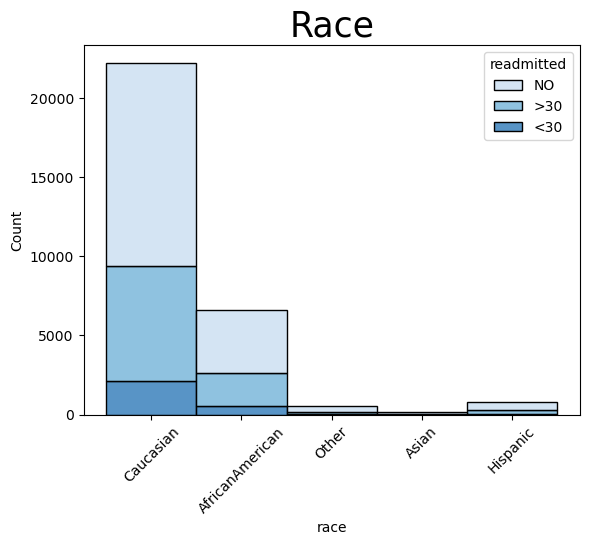

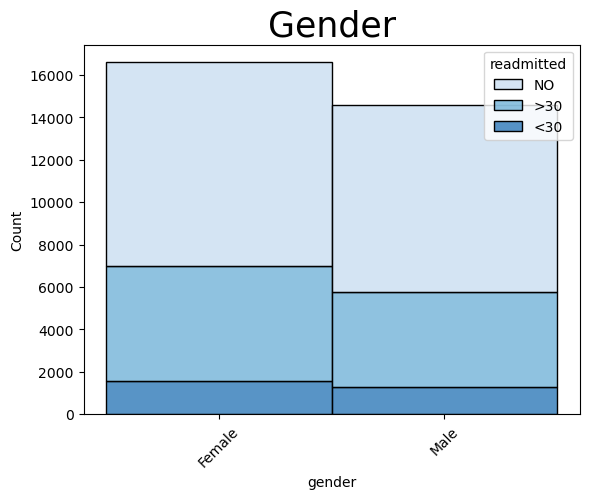

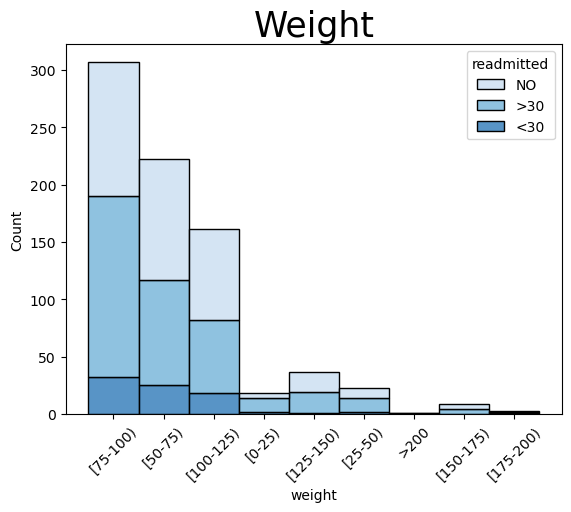

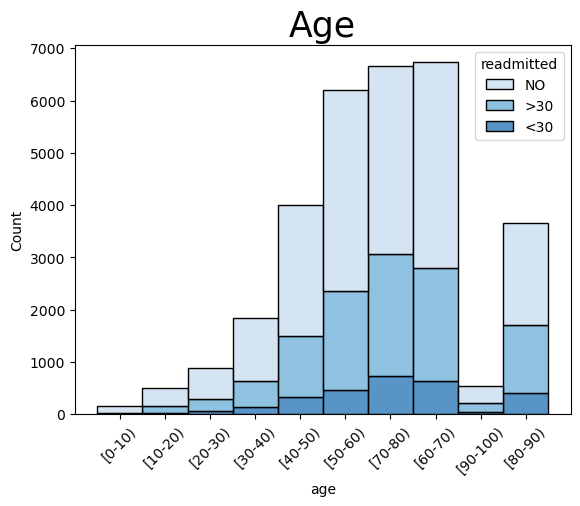

In [334]:
sns.histplot(binwidth=1, x="race", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Race',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=0.5, x="gender", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Gender',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=1, x="weight", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Weight',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=1, x="age", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Age',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

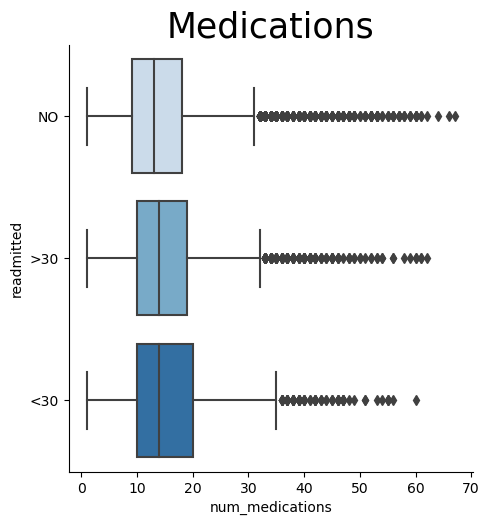

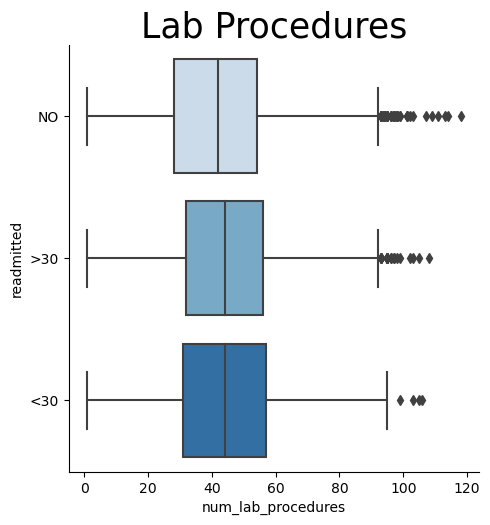

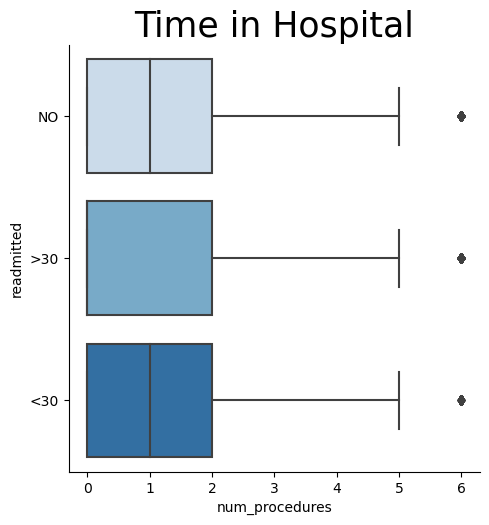

In [338]:
sns.catplot(x="num_medications", y="readmitted", data=df,kind="box",palette = 'Blues')
plt.title('Medications',fontdict = {'fontsize' : 25})
plt.show()

sns.catplot(x="num_lab_procedures", y="readmitted", data=df,kind="box",palette = 'Blues')
plt.title('Lab Procedures',fontdict = {'fontsize' : 25})
plt.show()

sns.catplot(x="num_procedures", y="readmitted", data=df,kind="box",palette = 'Blues')
plt.title('Time in Hospital',fontdict = {'fontsize' : 25})
plt.show()

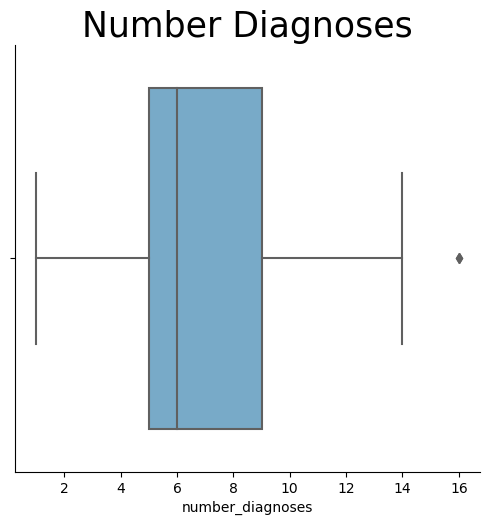

In [336]:
sns.catplot(x="number_diagnoses", data=df,kind="box",palette = 'Blues')
plt.title('Number Diagnoses',fontdict = {'fontsize' : 25})
plt.show()

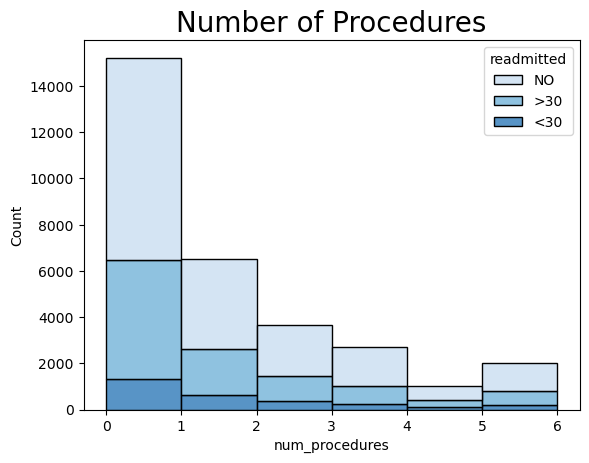

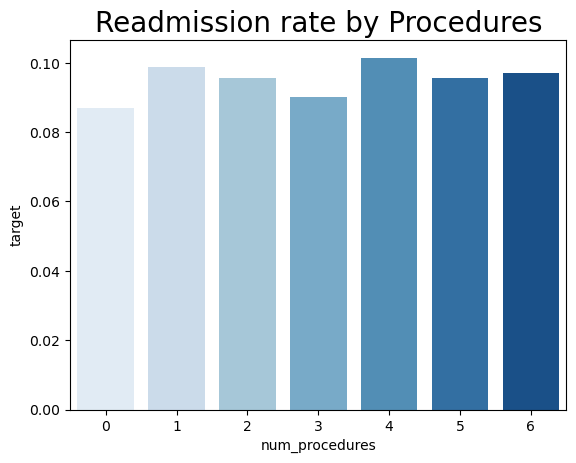

In [337]:
sns.histplot(binwidth=1, x="num_procedures", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Number of Procedures',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['num_procedures'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Procedures',fontdict = {'fontsize' : 20})
plt.show()

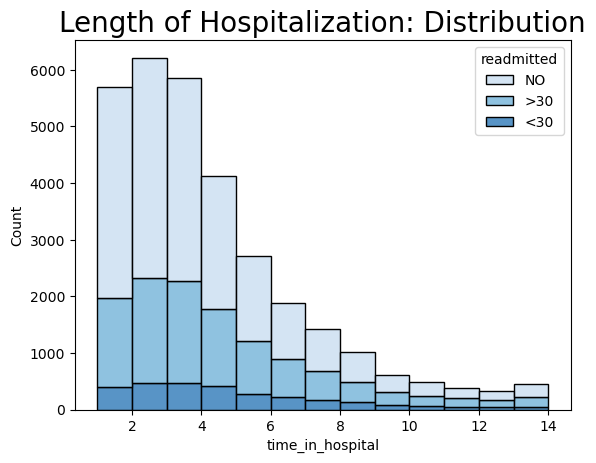

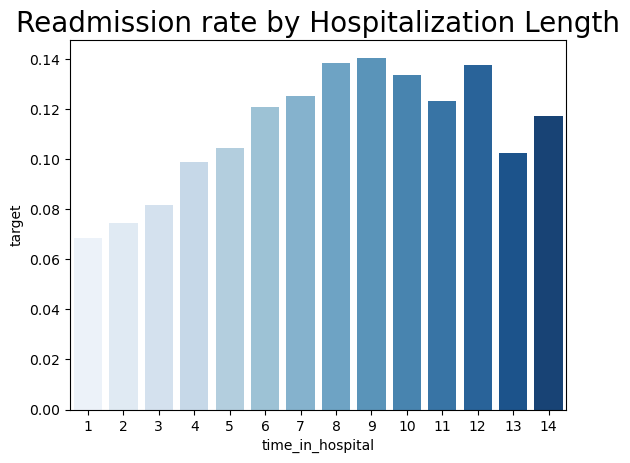

In [339]:
sns.histplot(binwidth=1, x="time_in_hospital", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Length of Hospitalization: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['time_in_hospital'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Hospitalization Length',fontdict = {'fontsize' : 20})
plt.show()

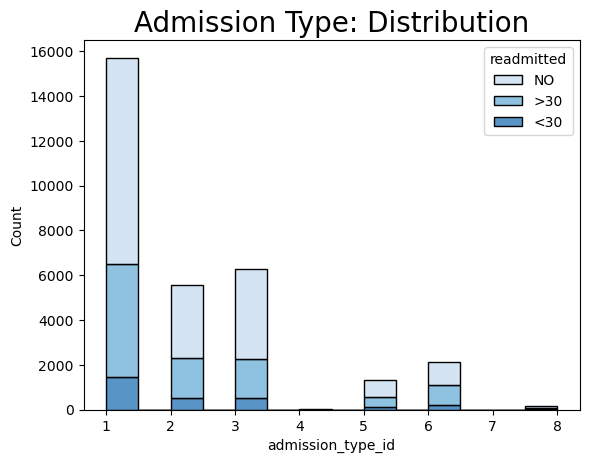

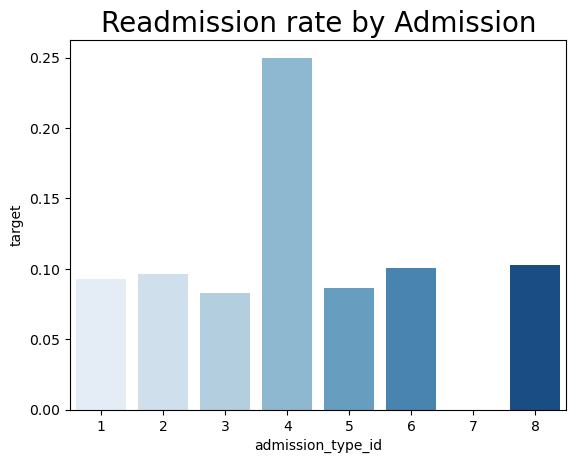

In [31]:
sns.histplot(binwidth=0.5, x="admission_type_id", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Admission Type: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['admission_type_id'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Admission',fontdict ={'fontsize' : 20})
plt.show()

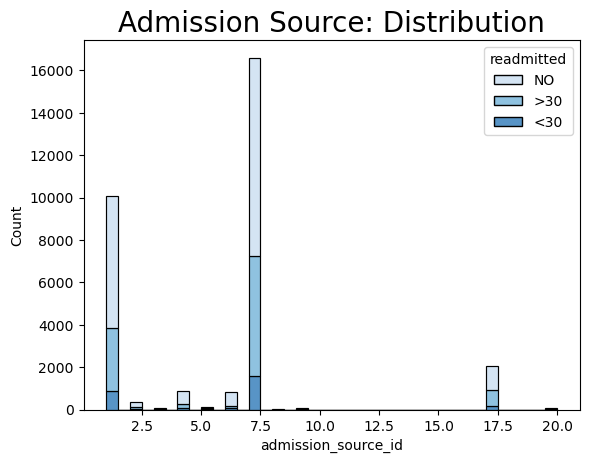

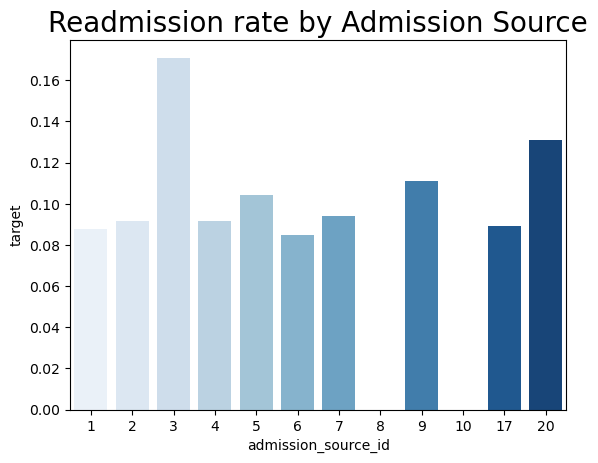

In [32]:
sns.histplot(binwidth=0.5, x="admission_source_id", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Admission Source: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['admission_source_id'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Admission Source',fontdict ={'fontsize' : 20})
plt.show()

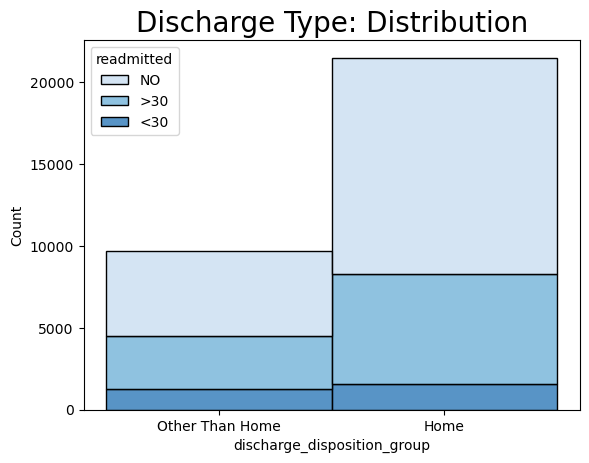

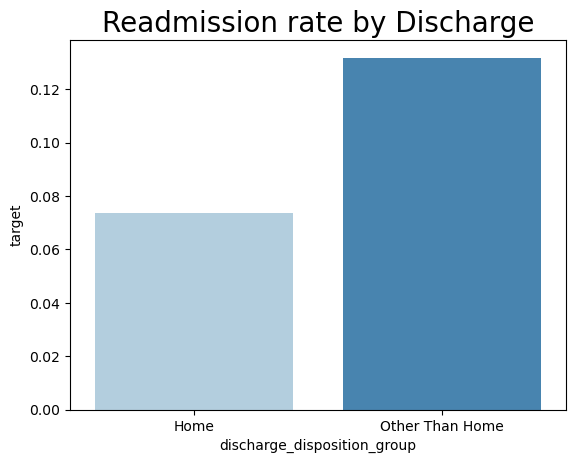

In [340]:
df["discharge_disposition_group"] = 'Home'
df.loc[df['discharge_disposition_id'] > 2, 'discharge_disposition_group'] = 'Other Than Home'


sns.histplot(binwidth=0.5, x="discharge_disposition_group", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Discharge Type: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['discharge_disposition_group'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Discharge',fontdict ={'fontsize' : 20})
plt.show()

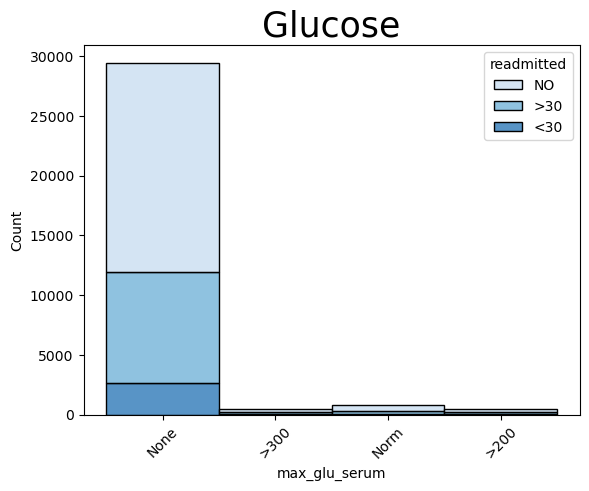

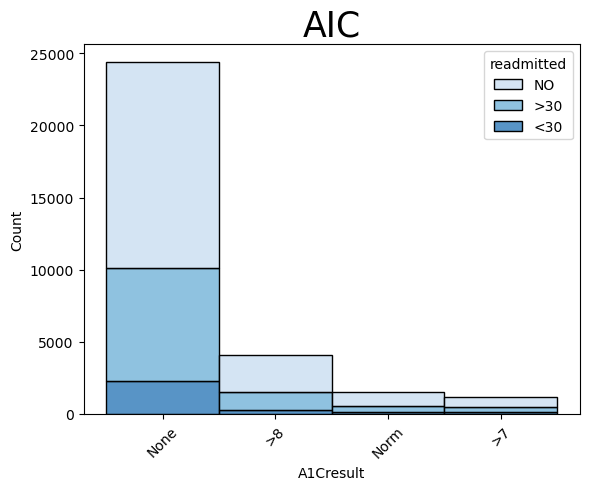

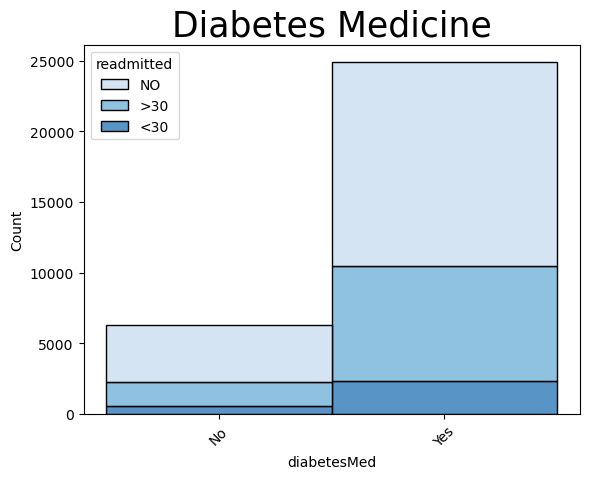

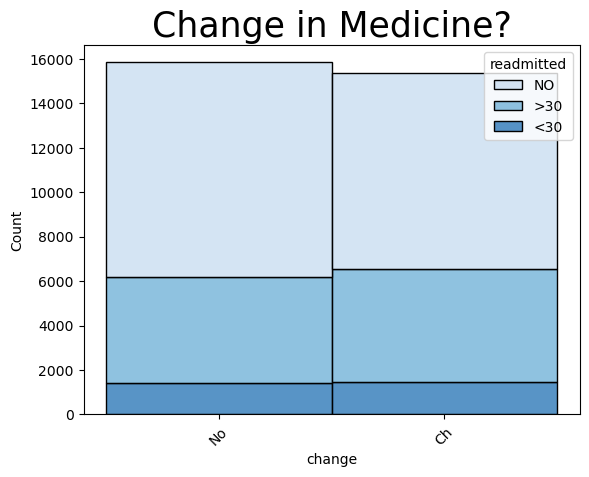

In [34]:
sns.histplot(binwidth=1, x="max_glu_serum", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Glucose',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=0.5, x="A1Cresult", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('AIC',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=1, x="diabetesMed", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Diabetes Medicine',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

sns.histplot(binwidth=1, x="change", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Change in Medicine?',fontdict = {'fontsize' : 25})
plt.xticks(rotation = 45)
plt.show()

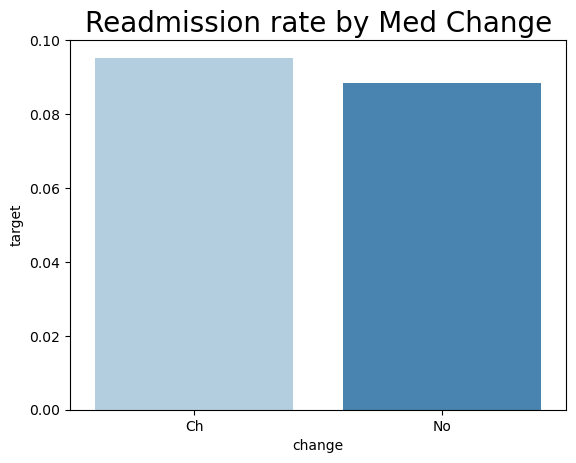

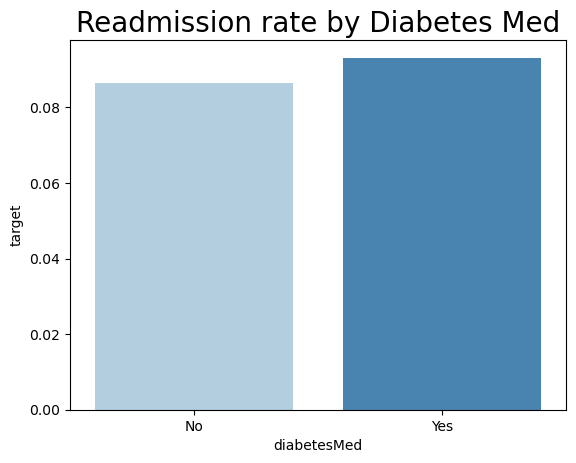

In [35]:
th_agg = df.groupby(by=['change'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Med Change',fontdict ={'fontsize' : 20})
plt.show()

th_agg = df.groupby(by=['diabetesMed'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Diabetes Med',fontdict ={'fontsize' : 20})
plt.show()

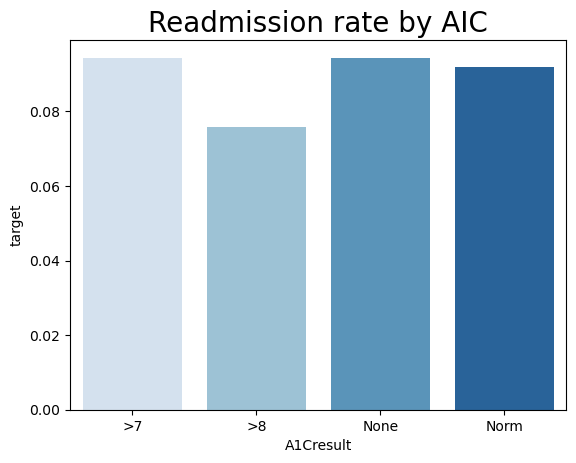

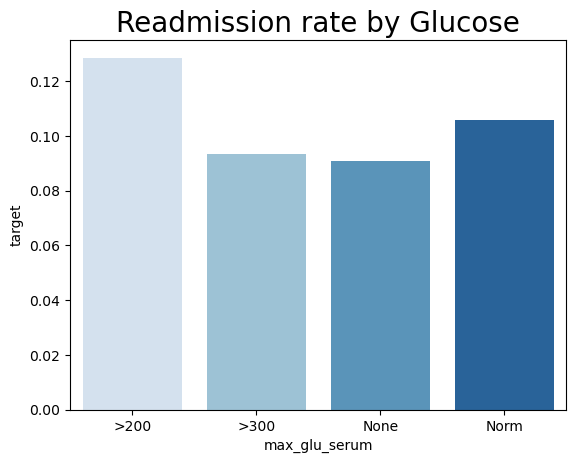

In [36]:
th_agg = df.groupby(by=['A1Cresult'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by AIC',fontdict ={'fontsize' : 20})
plt.show()

th_agg = df.groupby(by=['max_glu_serum'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Glucose',fontdict ={'fontsize' : 20})
plt.show()

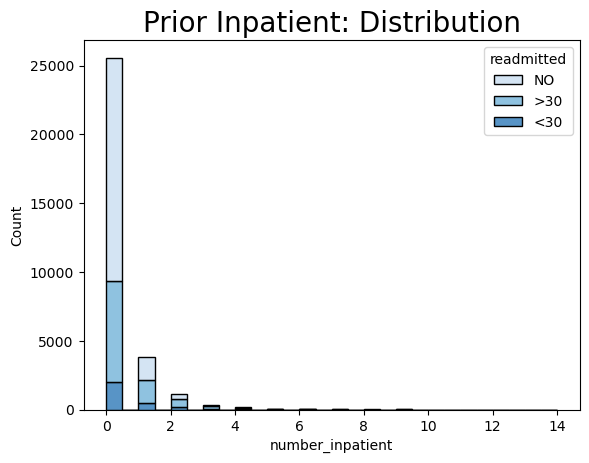

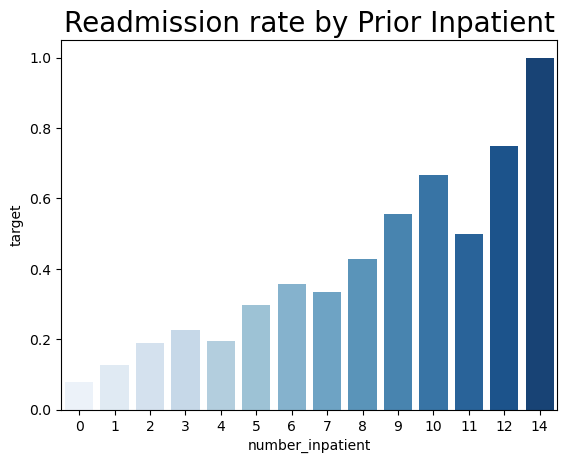

In [341]:
sns.histplot(binwidth=0.5, x="number_inpatient", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Prior Inpatient: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_inpatient'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Prior Inpatient',fontdict ={'fontsize' : 20})
plt.show()

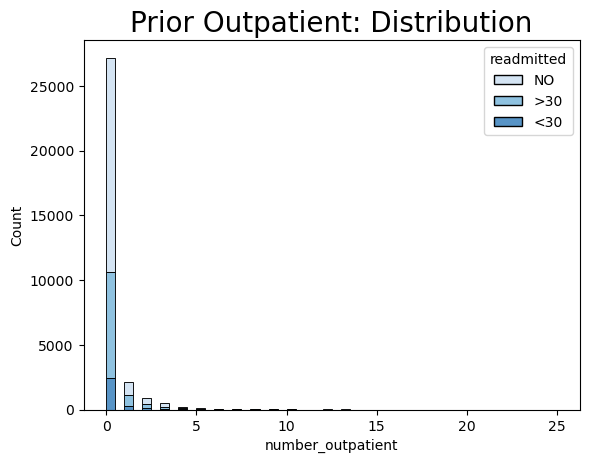

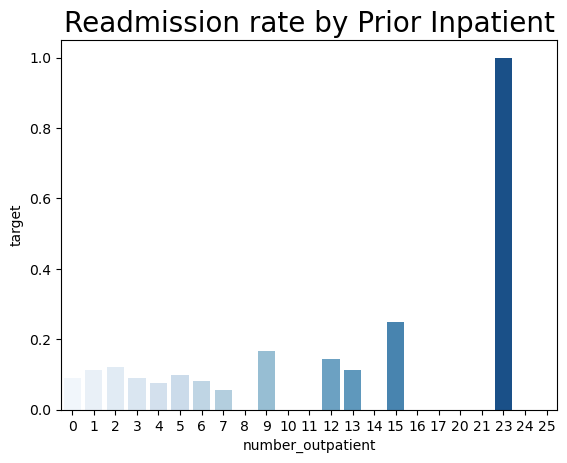

In [342]:
sns.histplot(binwidth=0.5, x="number_outpatient", hue="readmitted", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Prior Outpatient: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_outpatient'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Prior Inpatient',fontdict ={'fontsize' : 20})
plt.show()

# Data Cleansing and Feature Transformation

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31188 entries, 0 to 101761
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   patient_nbr                  31188 non-null  int64 
 1   race                         30339 non-null  object
 2   gender                       31188 non-null  object
 3   age                          31188 non-null  object
 4   weight                       781 non-null    object
 5   admission_type_id            31188 non-null  int64 
 6   discharge_disposition_id     31188 non-null  int64 
 7   admission_source_id          31188 non-null  int64 
 8   time_in_hospital             31188 non-null  int64 
 9   num_lab_procedures           31188 non-null  int64 
 10  num_procedures               31188 non-null  int64 
 11  num_medications              31188 non-null  int64 
 12  number_outpatient            31188 non-null  int64 
 13  number_emergency             3

In [40]:
# just going to drop rows where no diagnois, race, gender or admission/discharge data

drop_Idx = set(df[(df['discharge_disposition_id'] == 11)].index)

drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 18].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 25].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 26].index))
drop_Idx = drop_Idx.union(set(df[df['admission_type_id'] == 6].index))
drop_Idx = drop_Idx.union(set(df[df['admission_type_id'] == 5].index))
drop_Idx = drop_Idx.union(set(df[df['admission_type_id'] == 8].index))
drop_Idx = drop_Idx.union(set(df[df['admission_source_id'] == 9].index))
drop_Idx = drop_Idx.union(set(df[df['admission_source_id'] == 15].index))
drop_Idx = drop_Idx.union(set(df[df['admission_source_id'] == 17].index))
drop_Idx = drop_Idx.union(set(df[df['admission_source_id'] == 20].index))
drop_Idx = drop_Idx.union(set(df[df['admission_source_id'] == 21].index))

#dropping discharge to hospice or death
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 13].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 14].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 19].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 21].index))

new_Idx = list(set(df.index) - set(drop_Idx))
#df = df.iloc[new_Idx]

In [41]:
df = df.drop(drop_Idx)

In [42]:
df.shape

(25666, 47)

In [43]:
# fill race nulls with mode
df['race'].fillna(df['race'].mode(), inplace=True)

In [44]:
drop_list = ['discharge_disposition_id','weight','patient_nbr','readmitted']
df = df.drop(drop_list, axis=1)
df.head()

race  gender      age  admission_type_id  admission_source_id  \
1        Caucasian  Female  [10-20)                  1                    7   
2  AfricanAmerican  Female  [20-30)                  1                    7   
3        Caucasian    Male  [30-40)                  1                    7   
4        Caucasian    Male  [40-50)                  1                    7   
5        Caucasian    Male  [50-60)                  2                    2   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_outpatient  ...  insulin  glyburide-metformin glipizide-metformin  \
1                  0  ...       Up                   No                  No   
2                  2  ...       No                   No                  No   
3                  0  ...       Up                   No                  No   
4                  0  ...   Steady                   No                  No   
5                  0  ...   Steady                   No                  No   

  glimepiride-pioglitazone metformin-rosiglitazone  metformin-pioglitazone  \
1                       No                      No                      No   
2                       No                      No                      No   
3                       No                      No                      No   
4                       No                      No                      No   
5                       No                      No                      No   

  change diabetesMed target discharge_disposition_group  
1     Ch         Yes      0                        Home  
2     No         Yes      0                        Home  
3     Ch         Yes      0                        Home  
4     Ch         Yes      0                        Home  
5     No         Yes      0                        Home  

[5 rows x 43 columns]

#### Grouping discharge and admission codes

In [45]:
df['admission_type_id'] = df['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) ))



In [46]:
df['admission_source_id'] = df['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) ))))

In [47]:
df['admission_type_id']= df['admission_type_id'].map(str)
df['admission_source_id']= df['admission_source_id'].map(str)

In [48]:
# A1Cresult and max_glu_serum
df['A1Cresult'] = df['A1Cresult'].replace(['>7','>8','Norm','None'],['High','High','Norm','None'])
df['max_glu_serum'] = df['max_glu_serum'].replace(['>200','>300','Norm','None'],['High','High','Norm','None'])

In [49]:
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

df['age'] = df['age'].apply(lambda x : replaceDict[x])
print(df['age'].head())

1    15
2    25
3    35
4    45
5    55
Name: age, dtype: int64


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25666 entries, 1 to 101761
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   race                         24924 non-null  object
 1   gender                       25666 non-null  object
 2   age                          25666 non-null  int64 
 3   admission_type_id            25666 non-null  object
 4   admission_source_id          25666 non-null  object
 5   time_in_hospital             25666 non-null  int64 
 6   num_lab_procedures           25666 non-null  int64 
 7   num_procedures               25666 non-null  int64 
 8   num_medications              25666 non-null  int64 
 9   number_outpatient            25666 non-null  int64 
 10  number_emergency             25666 non-null  int64 
 11  number_inpatient             25666 non-null  int64 
 12  diag_1                       25666 non-null  object
 13  diag_2                       2

### Custom features

In [51]:
df['num_patient'] = df['number_outpatient'] + df['number_inpatient'] + df['number_emergency']

In [52]:
th_max = max(df['time_in_hospital'])
p_max = max(df['num_procedures'])
m_max = max(df['num_medications'])
lb_max = max(df['num_lab_procedures'])
d_max = max(df['number_diagnoses'])


In [53]:

df['severity_index'] = (df['time_in_hospital']/th_max) + (df['num_procedures']/p_max) + (df['num_medications']/m_max) + (df['num_lab_procedures']/lb_max)  + (df['number_diagnoses']/d_max)

In [54]:
drugs = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

number_of_changes = []
for i in tqdm(range(len(df))) :
    changeCount = 0
    for col in drugs : 
        if df.iloc[i][col] in ['Up', 'Down'] :
            changeCount += 1
    number_of_changes.append(changeCount)

df['number_of_changes'] = number_of_changes

100%|██████████| 25666/25666 [04:40<00:00, 91.40it/s] 


In [55]:
number_of_changes_down = []
for i in tqdm(range(len(df))) :
    changeCount = 0
    for col in drugs : 
        if df.iloc[i][col] in ['Down'] :
            changeCount += 1
    number_of_changes_down.append(changeCount)

df['number_of_changes_down'] = number_of_changes_down

100%|██████████| 25666/25666 [01:26<00:00, 296.20it/s]


In [56]:
number_of_changes_up = []
for i in tqdm(range(len(df))) :
    changeCount = 0
    for col in drugs : 
        if df.iloc[i][col] in ['Up'] :
            changeCount += 1
    number_of_changes_up.append(changeCount)

df['number_of_changes_up'] = number_of_changes_up

100%|██████████| 25666/25666 [01:23<00:00, 308.56it/s]


In [57]:
number_steady = []
for i in tqdm(range(len(df))) :
    changeCount = 0
    for col in drugs : 
        if df.iloc[i][col] in ['Steady'] :
            changeCount += 1
    number_steady.append(changeCount)

df['number_steady'] = number_steady

100%|██████████| 25666/25666 [01:25<00:00, 301.87it/s]


In [58]:
df.head()

race  gender  age admission_type_id admission_source_id  \
1        Caucasian  Female   15                 1                   7   
2  AfricanAmerican  Female   25                 1                   7   
3        Caucasian    Male   35                 1                   7   
4        Caucasian    Male   45                 1                   7   
5        Caucasian    Male   55                 1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_outpatient  ...  change  diabetesMed target  \
1                  0  ...      Ch          Yes      0   
2                  2  ...      No          Yes      0   
3                  0  ...      Ch          Yes      0   
4                  0  ...      Ch          Yes      0   
5                  0  ...      No          Yes      0   

  discharge_disposition_group num_patient  severity_index number_of_changes  \
1                        Home           0        1.545442                 1   
2                        Home           3        1.638441                 0   
3                        Home           0        1.358711                 1   
4                        Home           0        0.935535                 0   
5                        Home           0        2.278304                 0   

  number_of_changes_down number_of_changes_up number_steady  
1                      0                    1             0  
2                      0                    0             1  
3                      0                    1             0  
4                      0                    0             2  
5                      0                    0             1  

[5 rows x 49 columns]

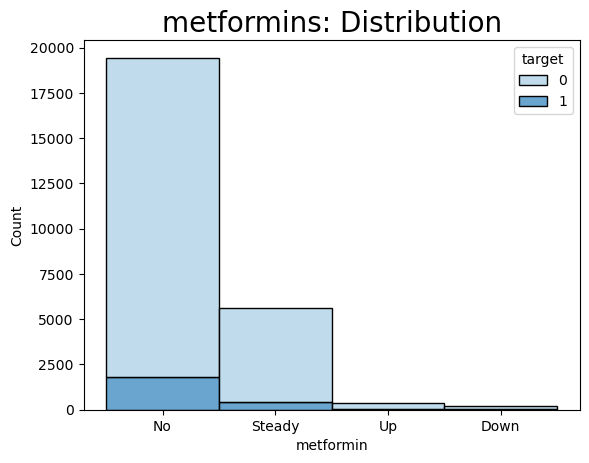

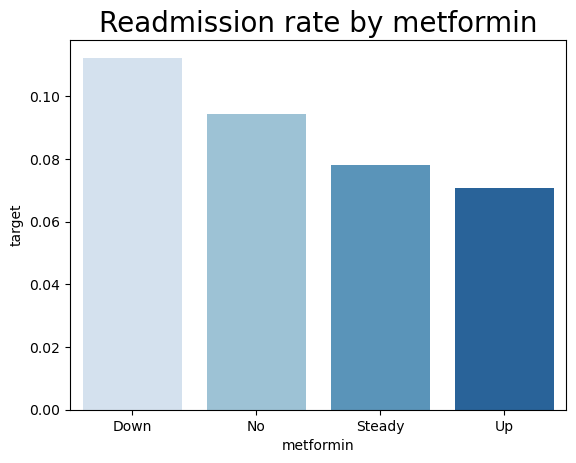

In [59]:
sns.histplot(binwidth=0.5, x="metformin", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('metformins: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['metformin'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by metformin',fontdict ={'fontsize' : 20})
plt.show()

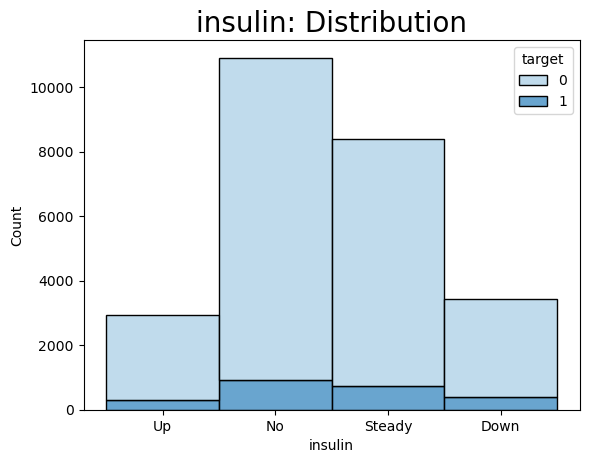

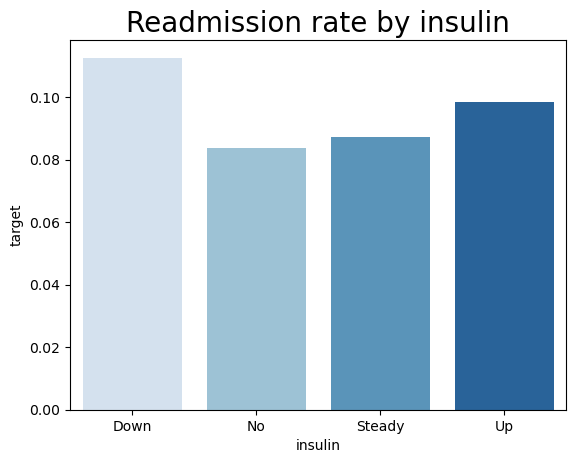

In [60]:
sns.histplot(binwidth=0.5, x="insulin", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('insulin: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['insulin'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by insulin',fontdict ={'fontsize' : 20})
plt.show()

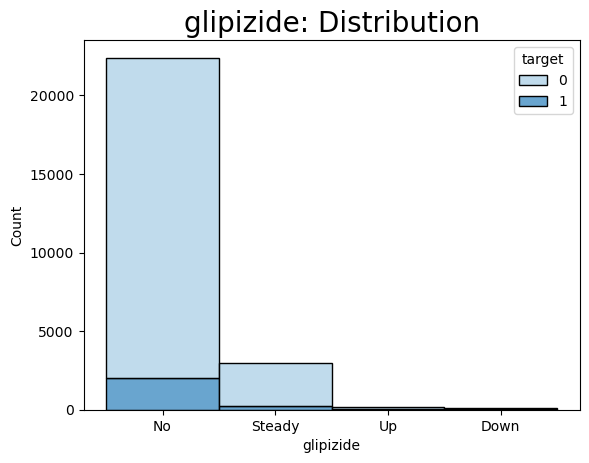

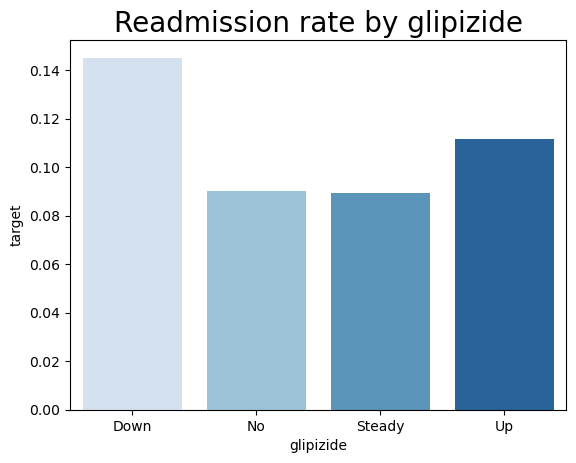

In [61]:
sns.histplot(binwidth=0.5, x="glipizide", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('glipizide: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['glipizide'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by glipizide',fontdict ={'fontsize' : 20})
plt.show()

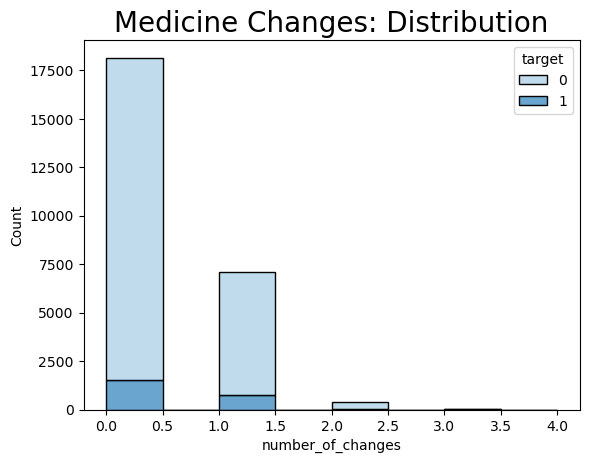

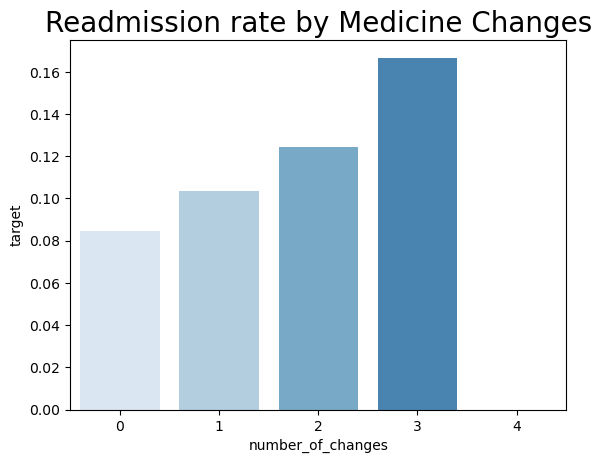

In [62]:
sns.histplot(binwidth=0.5, x="number_of_changes", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Medicine Changes: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_of_changes'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Medicine Changes',fontdict ={'fontsize' : 20})
plt.show()

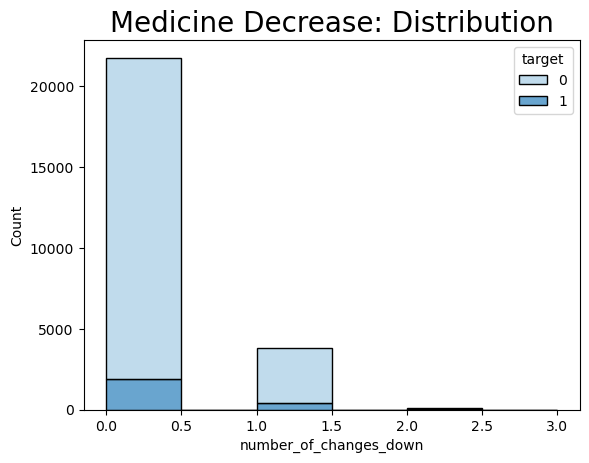

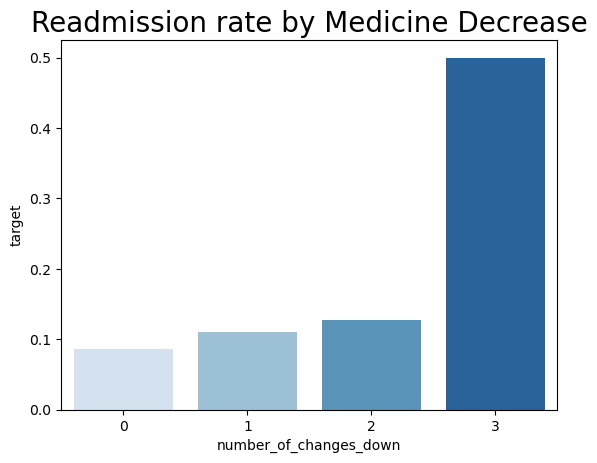

In [63]:
sns.histplot(binwidth=0.5, x="number_of_changes_down", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Medicine Decrease: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_of_changes_down'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Medicine Decrease',fontdict ={'fontsize' : 20})
plt.show()

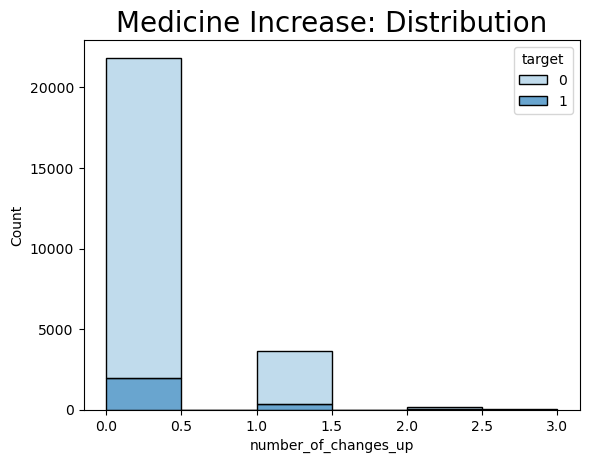

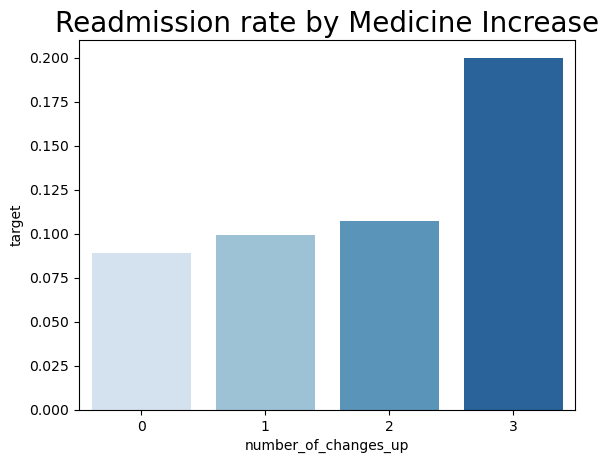

In [64]:
sns.histplot(binwidth=0.5, x="number_of_changes_up", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Medicine Increase: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_of_changes_up'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Medicine Increase',fontdict ={'fontsize' : 20})
plt.show()

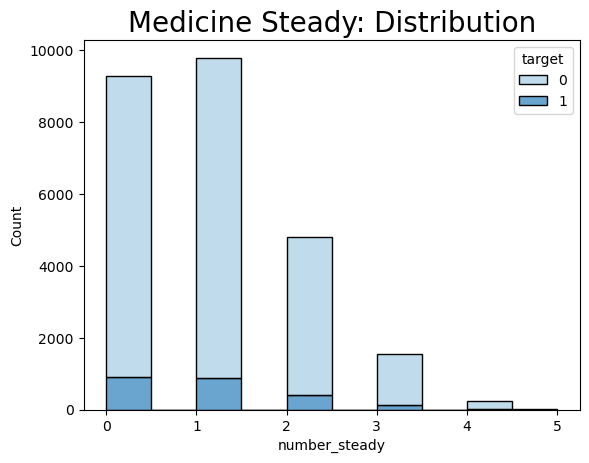

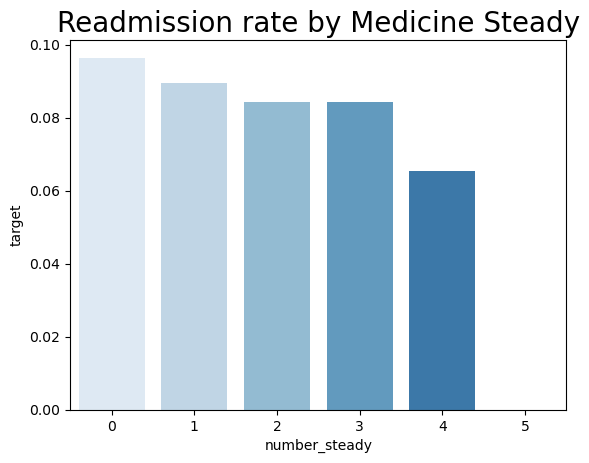

In [65]:
sns.histplot(binwidth=0.5, x="number_steady", hue="target", data=df, stat="count", multiple="stack",palette = 'Blues')
plt.title('Medicine Steady: Distribution',fontdict = {'fontsize' : 20})

plt.show()

th_agg = df.groupby(by=['number_steady'])['target'].mean()

sns.color_palette("Blues", as_cmap=True)
sns.barplot(x=th_agg.index, y=th_agg,palette = 'Blues')
plt.title('Readmission rate by Medicine Steady',fontdict ={'fontsize' : 20})
plt.show()

In [66]:
df.groupby(by=['metformin','insulin'])['target'].mean().unstack()

insulin        Down        No    Steady        Up
metformin                                        
Down       0.133333  0.088608  0.132353  0.105263
No         0.112915  0.087713  0.091196  0.102477
Steady     0.110140  0.074142  0.074195  0.077652
Up         0.111111  0.039683  0.060811  0.129630

In [67]:
df.groupby(by=['metformin','insulin'])['target'].count().unstack()

insulin    Down    No  Steady    Up
metformin                          
Down         30    79      68    19
No         2772  7992    6338  2342
Steady      572  2711    1833   528
Up           54   126     148    54

In [68]:
df.groupby(by=['metformin','glyburide'])['target'].mean().unstack()

glyburide      Down        No    Steady        Up
metformin                                        
Down       0.300000  0.107383  0.000000  0.300000
No         0.083333  0.093128  0.101911  0.186441
Steady     0.060606  0.077911  0.079365  0.084507
Up         0.166667  0.061017  0.083333  0.142857

In [69]:
df.groupby(by=['metformin','glyburide'])['target'].count().unstack()

glyburide  Down     No  Steady   Up
metformin                          
Down         10    149      27   10
No           84  17986    1256  118
Steady       33   4595     945   71
Up            6    295      60   21

In [70]:
df.groupby(by=['number_steady','number_of_changes'])['target'].mean().unstack()

number_of_changes         0         1         2         3    4
number_steady                                                 
0                  0.084484  0.109322  0.103659  0.259259  0.0
1                  0.086205  0.099889  0.141176  0.000000  0.0
2                  0.082224  0.088525  0.148148       NaN  NaN
3                  0.084919  0.081522  0.000000       NaN  NaN
4                  0.070093  0.000000       NaN       NaN  NaN
5                  0.000000       NaN       NaN       NaN  NaN

In [71]:
df.groupby(by=['number_steady','number_of_changes'])['target'].count().unstack()

number_of_changes       0       1      2     3    4
number_steady                                      
0                  4924.0  4162.0  164.0  27.0  2.0
1                  7807.0  1802.0  170.0  15.0  1.0
2                  3831.0   915.0   54.0   NaN  NaN
3                  1366.0   184.0    6.0   NaN  NaN
4                   214.0    15.0    NaN   NaN  NaN
5                     7.0     NaN    NaN   NaN  NaN

In [72]:
df.groupby(by=['number_of_changes','A1Cresult'])['target'].mean().unstack()

A1Cresult              High      None      Norm
number_of_changes                              
0                  0.071006  0.087105  0.081741
1                  0.085829  0.109179  0.106061
2                  0.106667  0.139013  0.095238
3                  0.095238  0.277778  0.000000
4                  0.000000  0.000000       NaN

In [73]:
df.groupby(by=['number_of_changes','max_glu_serum'])['target'].mean().unstack()

max_glu_serum          High      None      Norm
number_of_changes                              
0                  0.161765  0.084274  0.111111
1                  0.166667  0.103224       NaN
2                  0.000000  0.124682       NaN
3                  0.000000  0.170732       NaN
4                       NaN  0.000000       NaN

In [74]:
df.groupby(by=['metformin','number_of_changes'])['target'].mean().unstack()

number_of_changes         0         1         2         3    4
metformin                                                     
Down                    NaN  0.094488  0.127273  0.250000  0.0
No                 0.088057  0.108907  0.128834  0.000000  NaN
Steady             0.073431  0.091267  0.142857       NaN  NaN
Up                      NaN  0.042553  0.108333  0.153846  0.0

In [75]:
df.groupby(by=['number_of_changes_down','number_of_changes_up'])['target'].mean().unstack()

number_of_changes_up           0         1        2         3
number_of_changes_down                                       
0                       0.084578  0.097158  0.10274  0.222222
1                       0.109091  0.137143  0.15000  0.000000
2                       0.136986  0.090909  0.00000       NaN
3                       0.500000       NaN      NaN       NaN

In [76]:
df.groupby(by=['number_steady','number_of_changes_up'])['target'].mean().unstack()

number_of_changes_up         0         1         2         3
number_steady                                               
0                     0.092887  0.107617  0.119403  0.285714
1                     0.089547  0.090164  0.083333  0.000000
2                     0.083392  0.087129  0.153846       NaN
3                     0.084371  0.084112  0.000000       NaN
4                     0.068807  0.000000       NaN       NaN
5                     0.000000       NaN       NaN       NaN

In [77]:
df.groupby(by=['number_steady','number_of_changes_up'])['target'].count().unstack()

number_of_changes_up       0       1     2    3
number_steady                                  
0                     7170.0  2035.0  67.0  7.0
1                     8744.0   976.0  72.0  3.0
2                     4269.0   505.0  26.0  NaN
3                     1446.0   107.0   3.0  NaN
4                      218.0    11.0   NaN  NaN
5                        7.0     NaN   NaN  NaN

## Outlier Removal, transform strings to dummies

In [78]:

#df = df.reset_index(drop=True)
df.head()

race  gender  age admission_type_id admission_source_id  \
1        Caucasian  Female   15                 1                   7   
2  AfricanAmerican  Female   25                 1                   7   
3        Caucasian    Male   35                 1                   7   
4        Caucasian    Male   45                 1                   7   
5        Caucasian    Male   55                 1                   1   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   
5                 3                  31               6               16   

   number_outpatient  ...  change  diabetesMed target  \
1                  0  ...      Ch          Yes      0   
2                  2  ...      No          Yes      0   
3                  0  ...      Ch          Yes      0   
4                  0  ...      Ch          Yes      0   
5                  0  ...      No          Yes      0   

  discharge_disposition_group num_patient  severity_index number_of_changes  \
1                        Home           0        1.545442                 1   
2                        Home           3        1.638441                 0   
3                        Home           0        1.358711                 1   
4                        Home           0        0.935535                 0   
5                        Home           0        2.278304                 0   

  number_of_changes_down number_of_changes_up number_steady  
1                      0                    1             0  
2                      0                    0             1  
3                      0                    1             0  
4                      0                    0             2  
5                      0                    0             1  

[5 rows x 49 columns]

In [79]:
df.tail()

race  gender  age admission_type_id admission_source_id  \
101749        Caucasian  Female   75                 3                   1   
101753            Other    Male   45                 1                   7   
101754        Caucasian  Female   75                 1                   7   
101759        Caucasian    Male   85                 1                   7   
101761  AfricanAmerican    Male   75                 1                   7   

        time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
101749                 3                  27               1               29   
101753                13                  51               2               13   
101754                 9                  50               2               33   
101759                 1                   1               0               15   
101761                 3                  51               0               16   

        number_outpatient  ...  change  diabetesMed target  \
101749                  0  ...      Ch          Yes      0   
101753                  0  ...      Ch          Yes      0   
101754                  0  ...      Ch          Yes      0   
101759                  3  ...      Ch          Yes      0   
101761                  0  ...      Ch          Yes      0   

       discharge_disposition_group num_patient  severity_index  \
101749             Other Than Home           1        1.605102   
101753                        Home           0        2.450638   
101754                        Home           0        2.454957   
101759                        Home           3        0.741284   
101761             Other Than Home           0        1.447795   

       number_of_changes number_of_changes_down number_of_changes_up  \
101749                 0                      0                    0   
101753                 1                      1                    0   
101754                 1                      0                    1   
101759                 1                      0                    1   
101761                 1                      1                    0   

       number_steady  
101749             3  
101753             1  
101754             1  
101759             0  
101761             1  

[5 rows x 49 columns]

In [80]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [81]:
print('Pre-outlier removal:',df.num_medications.shape)
df_outlier_removed=remove_outlier_IQR(df.num_medications)
print('Post-outlier removal:',df_outlier_removed.shape)

ind_diff=df.index.difference(df_outlier_removed.index)

for i in range(0, len(ind_diff),1):
    df_final=df.drop([ind_diff[i]])
    test_df=df_final

Pre-outlier removal: (25666,)
Post-outlier removal: (24927,)


In [82]:
update_df = df.drop(ind_diff)


In [83]:
print('Pre-outlier removal:',update_df.num_lab_procedures.shape)
df_outlier_removed=remove_outlier_IQR(update_df.num_lab_procedures)
print('Post-outlier removal:',df_outlier_removed.shape)

ind_diff=update_df.index.difference(df_outlier_removed.index)


Pre-outlier removal: (24927,)
Post-outlier removal: (24847,)


In [84]:
update_df = update_df.drop(ind_diff)

In [85]:
update_df.shape

(24847, 49)

In [86]:
df = update_df

### Next: prep for feature selection

In [87]:
# seperate x from y, and seperate x num from x cate
X = df.drop('target', axis=1)
X = pd.get_dummies(X)
Y = df['target']

In [88]:
columns = list(X.columns)
columns

['age',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'num_patient',
 'severity_index',
 'number_of_changes',
 'number_of_changes_down',
 'number_of_changes_up',
 'number_steady',
 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'gender_Female',
 'gender_Male',
 'admission_type_id_1',
 'admission_type_id_3',
 'admission_type_id_4',
 'admission_source_id_1',
 'admission_source_id_4',
 'admission_source_id_7',
 'admission_source_id_8',
 'diag_1_Circulatory',
 'diag_1_Diabetes',
 'diag_1_Digestive',
 'diag_1_Genitourinary',
 'diag_1_Injury',
 'diag_1_Musculoskeletal',
 'diag_1_Neoplasms',
 'diag_1_No Diagnosis',
 'diag_1_Other',
 'diag_1_Respiratory',
 'diag_2_Circulatory',
 'diag_2_Diabetes',
 'diag_2_Digestive',
 'diag_2_Genitourinary',
 'diag_2_Injury',
 'diag_2_Musculoskeletal',
 'diag_2_Neoplasms',
 'diag_2_No Diagnosis

In [89]:
norm = MinMaxScaler()
X = norm.fit_transform(X)

X = pd.DataFrame(X, columns = columns)
X.head()

age  time_in_hospital  num_lab_procedures  num_procedures  \
0  0.111111          0.153846            0.666667        0.000000   
1  0.222222          0.076923            0.114943        0.833333   
2  0.333333          0.076923            0.494253        0.166667   
3  0.444444          0.000000            0.574713        0.000000   
4  0.555556          0.153846            0.344828        1.000000   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0         0.566667               0.00               0.0          0.000000   
1         0.400000               0.08               0.0          0.083333   
2         0.500000               0.00               0.0          0.000000   
3         0.233333               0.00               0.0          0.000000   
4         0.500000               0.00               0.0          0.000000   

   number_diagnoses  num_patient  ...  glimepiride-pioglitazone_No  \
0          0.533333     0.000000  ...                          0.0   
1          0.333333     0.061224  ...                          0.0   
2          0.400000     0.000000  ...                          0.0   
3          0.266667     0.000000  ...                          0.0   
4          0.533333     0.000000  ...                          0.0   

   metformin-rosiglitazone_No  metformin-pioglitazone_No  \
0                         0.0                        1.0   
1                         0.0                        1.0   
2                         0.0                        1.0   
3                         0.0                        1.0   
4                         0.0                        1.0   

   metformin-pioglitazone_Steady  change_Ch  change_No  diabetesMed_No  \
0                            0.0        1.0        0.0             0.0   
1                            0.0        0.0        1.0             0.0   
2                            0.0        1.0        0.0             0.0   
3                            0.0        1.0        0.0             0.0   
4                            0.0        0.0        1.0             0.0   

   diabetesMed_Yes  discharge_disposition_group_Home  \
0              1.0                               1.0   
1              1.0                               1.0   
2              1.0                               1.0   
3              1.0                               1.0   
4              1.0                               1.0   

   discharge_disposition_group_Other Than Home  
0                                          0.0  
1                                          0.0  
2                                          0.0  
3                                          0.0  
4                                          0.0  

[5 rows x 132 columns]

In [90]:
X.shape

(24847, 132)

In [91]:
#Y = Y.reset_index(drop=True)
Y

1         0
2         0
3         0
4         0
5         0
         ..
101748    0
101749    0
101753    0
101759    0
101761    0
Name: target, Length: 24847, dtype: int64

# Feature selection

In [222]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [93]:
feature_names = list(x_train.columns)

forest = RandomForestClassifier(random_state=0)
forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([
   tree.feature_importances_ for tree in forest.estimators_], axis=0)
feature_importances = pd.Series(importances, index=feature_names)


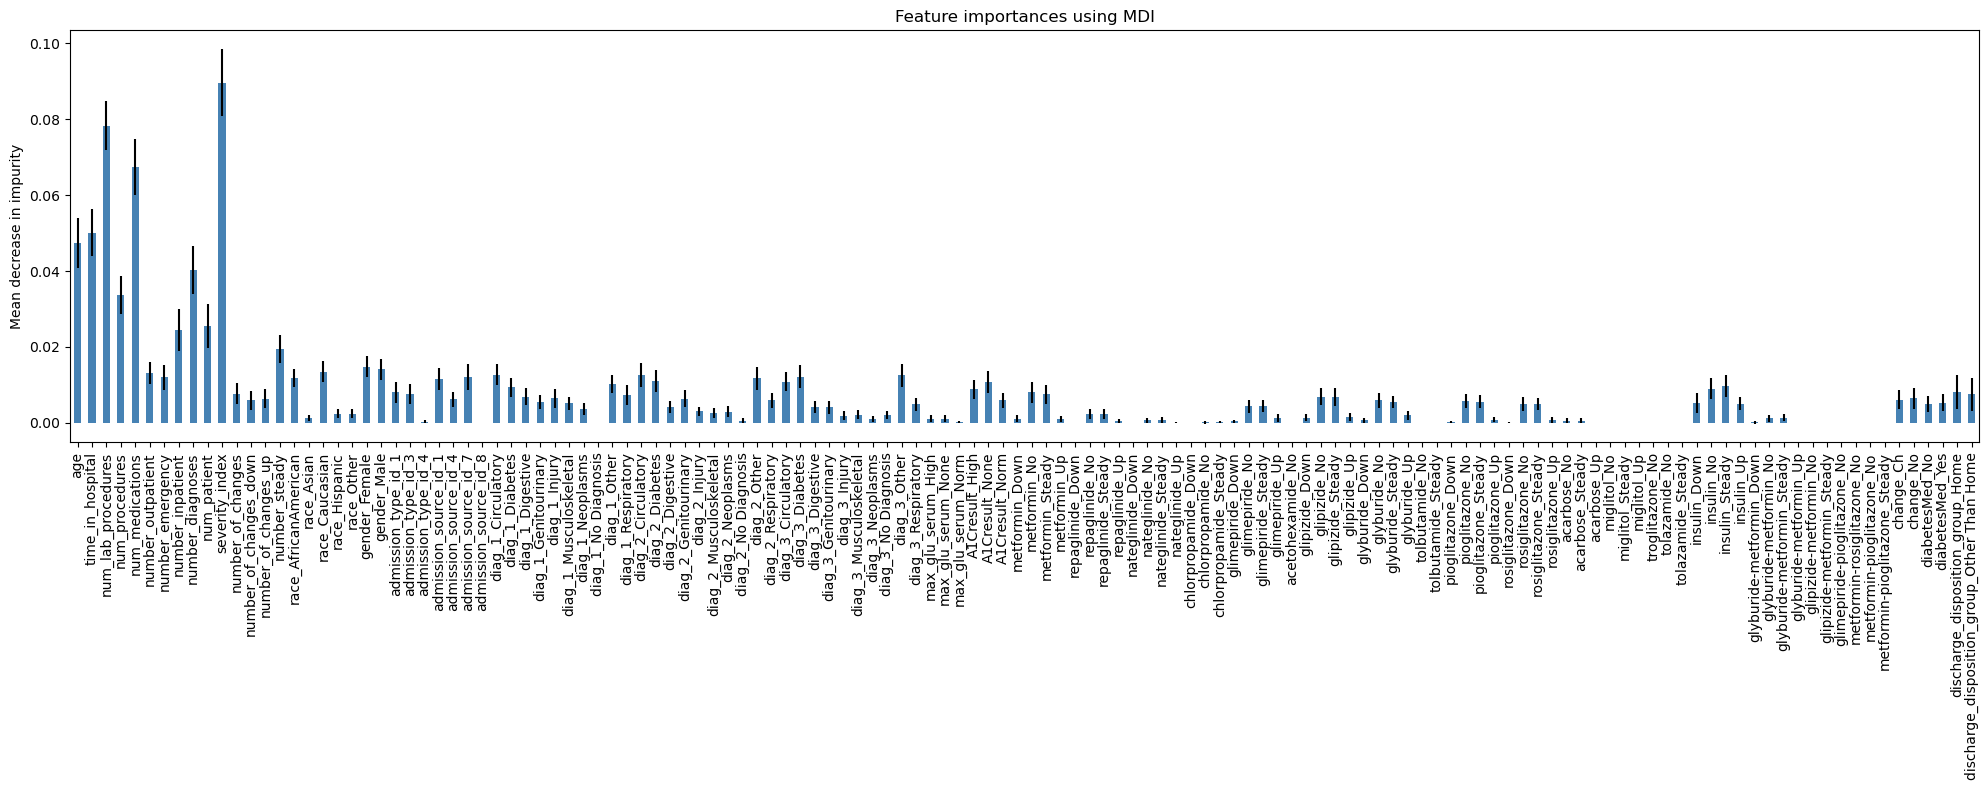

severity_index                                 0.089666
num_lab_procedures                             0.078325
num_medications                                0.067399
time_in_hospital                               0.050112
age                                            0.047452
number_diagnoses                               0.040317
num_procedures                                 0.033605
num_patient                                    0.025516
number_inpatient                               0.024432
number_steady                                  0.019439
gender_Female                                  0.014821
gender_Male                                    0.014091
race_Caucasian                                 0.013511
number_outpatient                              0.013212
diag_1_Circulatory                             0.012722
diag_2_Circulatory                             0.012644
diag_3_Other                                   0.012582
diag_3_Diabetes                                0

In [94]:
fig, ax = plt.subplots(figsize=(20, 8), sharex=False)
feature_importances.plot.bar(yerr=std, ax=ax,color="steelblue")
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

feature_importances.sort_values(ascending=False)[0:50]

In [95]:
sum(feature_importances.sort_values(ascending=False))

1.0000000000000004

In [96]:
# create xg selected top features
colsrf = feature_importances.sort_values(ascending=False)[0:40].index
colsrf = colsrf.tolist()

x_train_rf = x_train.filter(colsrf)
x_train_rf.head()

severity_index  num_lab_procedures  num_medications  time_in_hospital  \
9625         0.373214            0.402299         0.866667          0.076923   
10037        0.186663            0.000000         0.200000          0.153846   
5222         0.266987            0.689655         0.200000          0.153846   
4113         0.246804            0.735632         0.266667          0.076923   
5326         0.438658            0.505747         0.500000          0.461538   

            age  number_diagnoses  num_procedures  num_patient  \
9625   0.555556          0.400000        0.166667     0.040816   
10037  0.555556          0.266667        0.166667     0.020408   
5222   0.666667          0.200000        0.000000     0.000000   
4113   0.777778          0.133333        0.000000     0.020408   
5326   0.444444          0.533333        0.000000     0.040816   

       number_inpatient  number_steady  ...  A1Cresult_High  \
9625           0.083333            0.4  ...             0.0   
10037          0.083333            0.2  ...             0.0   
5222           0.000000            0.2  ...             1.0   
4113           0.083333            0.4  ...             1.0   
5326           0.166667            0.2  ...             1.0   

       admission_type_id_1  discharge_disposition_group_Home  metformin_No  \
9625                   0.0                               0.0           0.0   
10037                  0.0                               0.0           1.0   
5222                   1.0                               1.0           1.0   
4113                   1.0                               1.0           0.0   
5326                   0.0                               0.0           1.0   

       number_of_changes  admission_type_id_3  \
9625                 0.0                  1.0   
10037                0.5                  1.0   
5222                 0.0                  0.0   
4113                 0.0                  0.0   
5326                 0.0                  1.0   

       discharge_disposition_group_Other Than Home  metformin_Steady  \
9625                                           1.0               1.0   
10037                                          1.0               0.0   
5222                                           0.0               0.0   
4113                                           0.0               1.0   
5326                                           1.0               0.0   

       diag_1_Respiratory  diag_1_Digestive  
9625                  0.0               0.0  
10037                 0.0               0.0  
5222                  0.0               0.0  
4113                  0.0               0.0  
5326                  0.0               0.0  

[5 rows x 40 columns]

In [97]:
# recalculate vif
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_rf.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_rf.values, i)
                          for i in range(len(x_train_rf.columns))]

print(vif_data)

                                        feature          VIF
0                                severity_index          inf
1                            num_lab_procedures          inf
2                               num_medications          inf
3                              time_in_hospital          inf
4                                           age     1.396391
5                              number_diagnoses          inf
6                                num_procedures          inf
7                                   num_patient          inf
8                              number_inpatient          inf
9                                 number_steady     2.535746
10                                gender_Female          inf
11                                  gender_Male          inf
12                               race_Caucasian     3.208092
13                            number_outpatient          inf
14                           diag_1_Circulatory     2.066201
15                      

In [98]:
drop_list = ['severity_index']
x_train_rf_v1 = x_train_rf.drop(drop_list, axis=1)

# recalculate vif
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_rf_v1.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_rf_v1.values, i)
                          for i in range(len(x_train_rf_v1.columns))]

print(vif_data)

                                        feature          VIF
0                            num_lab_procedures     1.347414
1                               num_medications     1.701838
2                              time_in_hospital     1.436814
3                                           age     1.396391
4                              number_diagnoses     1.335852
5                                num_procedures     1.331196
6                                   num_patient          inf
7                              number_inpatient          inf
8                                 number_steady     2.535746
9                                 gender_Female          inf
10                                  gender_Male          inf
11                               race_Caucasian     3.208092
12                            number_outpatient          inf
13                           diag_1_Circulatory     2.066201
14                           diag_2_Circulatory     1.844550
15                      

In [99]:
drop_list = ['gender_Male','num_patient','admission_type_id_1','metformin_Steady']
x_train_rf_v2 = x_train_rf_v1.drop(drop_list, axis=1)

# recalculate vif
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_rf_v2.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_rf_v2.values, i)
                          for i in range(len(x_train_rf_v2.columns))]

print(vif_data)

                                        feature         VIF
0                            num_lab_procedures    1.347361
1                               num_medications    1.701760
2                              time_in_hospital    1.436460
3                                           age    1.395986
4                              number_diagnoses    1.335589
5                                num_procedures    1.331185
6                              number_inpatient    1.085046
7                                 number_steady    2.497369
8                                 gender_Female    1.030509
9                                race_Caucasian    3.207922
10                            number_outpatient    1.044970
11                           diag_1_Circulatory    2.065824
12                           diag_2_Circulatory    1.844525
13                                 diag_3_Other    2.065425
14                              diag_3_Diabetes   20.808589
15                             number_em

In [100]:
drop_list = ['diag_2_Diabetes','diag_3_Diabetes','discharge_disposition_group_Other Than Home']
x_train_rf_v3 = x_train_rf_v2.drop(drop_list, axis=1)

# recalculate vif
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_rf_v3.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train_rf_v3.values, i)
                          for i in range(len(x_train_rf_v3.columns))]

print(vif_data)

                             feature        VIF
0                 num_lab_procedures   7.129155
1                    num_medications   8.234182
2                   time_in_hospital   2.962770
3                                age  14.302911
4                   number_diagnoses   8.823942
5                     num_procedures   2.021808
6                   number_inpatient   1.230324
7                      number_steady   4.952043
8                      gender_Female   2.190939
9                     race_Caucasian   9.914048
10                 number_outpatient   1.109143
11                diag_1_Circulatory   2.668184
12                diag_2_Circulatory   1.862768
13                      diag_3_Other   1.755217
14                  number_emergency   1.098363
15             admission_source_id_7   9.369076
16              race_AfricanAmerican   3.830238
17                      diag_2_Other   1.867645
18             admission_source_id_1   6.615462
19                diag_3_Circulatory   1

In [101]:
x_train_rf = x_train_rf_v3
cols = list(x_train_rf.columns)
x_test_rf = x_test.loc[:,cols]

In [102]:
cols

['num_lab_procedures',
 'num_medications',
 'time_in_hospital',
 'age',
 'number_diagnoses',
 'num_procedures',
 'number_inpatient',
 'number_steady',
 'gender_Female',
 'race_Caucasian',
 'number_outpatient',
 'diag_1_Circulatory',
 'diag_2_Circulatory',
 'diag_3_Other',
 'number_emergency',
 'admission_source_id_7',
 'race_AfricanAmerican',
 'diag_2_Other',
 'admission_source_id_1',
 'diag_3_Circulatory',
 'A1Cresult_None',
 'diag_1_Other',
 'insulin_Steady',
 'diag_1_Diabetes',
 'insulin_No',
 'A1Cresult_High',
 'discharge_disposition_group_Home',
 'metformin_No',
 'number_of_changes',
 'admission_type_id_3',
 'diag_1_Respiratory',
 'diag_1_Digestive']

In [103]:
print('x train',x_train_rf.shape)
print('y train',y_train.shape)
print('x test',x_test_rf.shape)
print('y test',y_test.shape)

x train (18635, 32)
y train (18635,)
x test (6212, 32)
y test (6212,)


## Models

### Using class weights for imbalanced set

In [104]:

class_weights_val = class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)
class_weights_val

array([0.54918661, 5.58268424])

In [105]:
class_weights = {
    0:class_weights_val[0],
    1:class_weights_val[1]}

In [106]:
log_model = LogisticRegression(class_weight=class_weights,penalty = 'none')    
ridge_model = LogisticRegression(class_weight=class_weights,C=0.1)
lasso_model = LogisticRegression(class_weight=class_weights,penalty='l1',solver ='liblinear',C=0.5)
RF_model = RandomForestClassifier(class_weight=class_weights)    
KNN_model = KNeighborsClassifier(n_neighbors=10,weights = 'distance')    
NB_model = GaussianNB()   
SVC_model = SVC(class_weight = class_weights)
XG_model = XGBClassifier(eval_metric='mlogloss')
GB_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=42)
lgbm_model = LGBMClassifier(random_state = 42,max_depth=3)
cat_model = CatBoostClassifier(random_state = 42, max_depth=3,class_weights=class_weights)

In [107]:
def fit_predict(x_train,x_test,y_train,y_test):
    x_sm = x_train
    y_sm = y_train
    
    RF_model.fit(x_sm,y_sm)
    y_pred = RF_model.predict(x_test)
    print('\nRF Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    log_model.fit(x_sm,y_sm)
    y_pred = log_model.predict(x_test)
    print('\nLog Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    
    
    ridge_model.fit(x_sm,y_sm)
    y_pred = ridge_model.predict(x_test)
    print('\nRidge Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    
    
    lasso_model.fit(x_sm,y_sm)
    y_pred = lasso_model.predict(x_test)
    print('\nLasso Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    KNN_model.fit(x_sm,y_sm)
    y_pred = KNN_model.predict(x_test)
    print('\nKNN Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    SVC_model.fit(x_sm,y_sm)
    y_pred = SVC_model.predict(x_test)
    print('\nSVC Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    NB_model.fit(x_sm,y_sm)
    y_pred = NB_model.predict(x_test)
    print('\nNaive Bayes Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    XG_model.fit(x_sm,y_sm)
    y_pred = XG_model.predict(x_test)
    print('\nXG Boost Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    GB_model.fit(x_sm,y_sm)
    y_pred = GB_model.predict(x_test)
    print('\nGradient Boosting Classifier Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lgbm_model.fit(x_sm,y_sm)
    y_pred = lgbm_model.predict(x_test)
    print('\nLight GBM Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    cat_model.fit(x_sm,y_sm)
    y_pred = cat_model.predict(x_test)
    print('\nCat Boosting Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))

In [108]:
fit_predict(x_train_rf,x_test_rf,y_train,y_test)


RF Model:
Accuracy:
 0.9138763683193818
Precision:
 0.0
Recall:
 0.0
AUC: 0.5
Balanced Accuracy: 0.5
f1 Score: 0.0

Log Model:
Accuracy:
 0.6508370895041854
Precision:
 0.13428827215756492
Recall:
 0.5607476635514018
AUC: 0.6100373864700817
Balanced Accuracy: 0.6100373864700818

Ridge Model:
Accuracy:
 0.6423052157115261
Precision:
 0.1321412996075011
Recall:
 0.5663551401869159
AUC: 0.6079089422970866
Balanced Accuracy: 0.6079089422970867

Lasso Model:
Accuracy:
 0.6506761107533805
Precision:
 0.1342281879194631
Recall:
 0.5607476635514018
AUC: 0.6099493117827468
Balanced Accuracy: 0.6099493117827468
f1 Score: 0.21660649819494582

KNN Model:
Accuracy:
 0.9130714745653574
Precision:
 0.0
Recall:
 0.0
AUC: 0.4995596265633257
Balanced Accuracy: 0.4995596265633257
f1 Score: 0.0

SVC Model:
Accuracy:
 0.6434320669671604
Precision:
 0.12533452274754683
Recall:
 0.525233644859813
AUC: 0.5899023605662462
Balanced Accuracy: 0.5899023605662461
f1 Score: 0.20237666546633057

Naive Bayes Model:


151:	learn: 0.6464376	total: 1.09s	remaining: 6.06s
152:	learn: 0.6463512	total: 1.09s	remaining: 6.04s
153:	learn: 0.6462559	total: 1.09s	remaining: 6.02s
154:	learn: 0.6461702	total: 1.1s	remaining: 6s
155:	learn: 0.6460956	total: 1.1s	remaining: 5.97s
156:	learn: 0.6460564	total: 1.11s	remaining: 5.95s
157:	learn: 0.6459897	total: 1.11s	remaining: 5.93s
158:	learn: 0.6459595	total: 1.12s	remaining: 5.9s
159:	learn: 0.6458914	total: 1.12s	remaining: 5.88s
160:	learn: 0.6458487	total: 1.12s	remaining: 5.85s
161:	learn: 0.6458081	total: 1.13s	remaining: 5.84s
162:	learn: 0.6456836	total: 1.13s	remaining: 5.82s
163:	learn: 0.6455652	total: 1.14s	remaining: 5.79s
164:	learn: 0.6454729	total: 1.14s	remaining: 5.77s
165:	learn: 0.6454143	total: 1.14s	remaining: 5.75s
166:	learn: 0.6453483	total: 1.15s	remaining: 5.73s
167:	learn: 0.6453013	total: 1.15s	remaining: 5.71s
168:	learn: 0.6452632	total: 1.16s	remaining: 5.69s
169:	learn: 0.6451912	total: 1.16s	remaining: 5.67s
170:	learn: 0.6451

317:	learn: 0.6330565	total: 1.98s	remaining: 4.24s
318:	learn: 0.6329649	total: 1.98s	remaining: 4.23s
319:	learn: 0.6328990	total: 1.99s	remaining: 4.22s
320:	learn: 0.6328005	total: 1.99s	remaining: 4.21s
321:	learn: 0.6326866	total: 2s	remaining: 4.2s
322:	learn: 0.6325790	total: 2s	remaining: 4.19s
323:	learn: 0.6325067	total: 2s	remaining: 4.18s
324:	learn: 0.6324225	total: 2.01s	remaining: 4.18s
325:	learn: 0.6323415	total: 2.02s	remaining: 4.17s
326:	learn: 0.6322634	total: 2.02s	remaining: 4.16s
327:	learn: 0.6321864	total: 2.02s	remaining: 4.15s
328:	learn: 0.6320971	total: 2.03s	remaining: 4.14s
329:	learn: 0.6320113	total: 2.03s	remaining: 4.13s
330:	learn: 0.6319222	total: 2.04s	remaining: 4.12s
331:	learn: 0.6318469	total: 2.04s	remaining: 4.11s
332:	learn: 0.6317067	total: 2.05s	remaining: 4.1s
333:	learn: 0.6315986	total: 2.05s	remaining: 4.09s
334:	learn: 0.6315125	total: 2.06s	remaining: 4.08s
335:	learn: 0.6313689	total: 2.06s	remaining: 4.07s
336:	learn: 0.6312723	t

506:	learn: 0.6170549	total: 2.86s	remaining: 2.79s
507:	learn: 0.6169832	total: 2.87s	remaining: 2.78s
508:	learn: 0.6169110	total: 2.88s	remaining: 2.77s
509:	learn: 0.6168486	total: 2.88s	remaining: 2.77s
510:	learn: 0.6167780	total: 2.91s	remaining: 2.79s
511:	learn: 0.6167102	total: 2.92s	remaining: 2.78s
512:	learn: 0.6166236	total: 2.92s	remaining: 2.77s
513:	learn: 0.6165646	total: 2.93s	remaining: 2.77s
514:	learn: 0.6165199	total: 2.93s	remaining: 2.76s
515:	learn: 0.6164671	total: 2.94s	remaining: 2.76s
516:	learn: 0.6163354	total: 2.94s	remaining: 2.75s
517:	learn: 0.6163118	total: 2.95s	remaining: 2.75s
518:	learn: 0.6162298	total: 2.96s	remaining: 2.74s
519:	learn: 0.6161524	total: 2.96s	remaining: 2.73s
520:	learn: 0.6161055	total: 2.96s	remaining: 2.73s
521:	learn: 0.6160426	total: 2.97s	remaining: 2.72s
522:	learn: 0.6159979	total: 2.97s	remaining: 2.71s
523:	learn: 0.6158988	total: 2.98s	remaining: 2.71s
524:	learn: 0.6158244	total: 2.98s	remaining: 2.7s
525:	learn: 0

699:	learn: 0.6046298	total: 3.76s	remaining: 1.61s
700:	learn: 0.6045666	total: 3.77s	remaining: 1.61s
701:	learn: 0.6045201	total: 3.77s	remaining: 1.6s
702:	learn: 0.6044520	total: 3.78s	remaining: 1.59s
703:	learn: 0.6043949	total: 3.78s	remaining: 1.59s
704:	learn: 0.6043886	total: 3.79s	remaining: 1.58s
705:	learn: 0.6043400	total: 3.79s	remaining: 1.58s
706:	learn: 0.6042588	total: 3.79s	remaining: 1.57s
707:	learn: 0.6042217	total: 3.8s	remaining: 1.57s
708:	learn: 0.6041677	total: 3.8s	remaining: 1.56s
709:	learn: 0.6041061	total: 3.81s	remaining: 1.55s
710:	learn: 0.6040484	total: 3.81s	remaining: 1.55s
711:	learn: 0.6040032	total: 3.81s	remaining: 1.54s
712:	learn: 0.6038951	total: 3.82s	remaining: 1.54s
713:	learn: 0.6038368	total: 3.82s	remaining: 1.53s
714:	learn: 0.6037499	total: 3.83s	remaining: 1.52s
715:	learn: 0.6036701	total: 3.83s	remaining: 1.52s
716:	learn: 0.6036250	total: 3.83s	remaining: 1.51s
717:	learn: 0.6035669	total: 3.84s	remaining: 1.51s
718:	learn: 0.6

879:	learn: 0.5947222	total: 4.47s	remaining: 609ms
880:	learn: 0.5946582	total: 4.47s	remaining: 604ms
881:	learn: 0.5946291	total: 4.48s	remaining: 599ms
882:	learn: 0.5945796	total: 4.48s	remaining: 594ms
883:	learn: 0.5945185	total: 4.49s	remaining: 589ms
884:	learn: 0.5944623	total: 4.49s	remaining: 583ms
885:	learn: 0.5944244	total: 4.49s	remaining: 578ms
886:	learn: 0.5943827	total: 4.5s	remaining: 573ms
887:	learn: 0.5943139	total: 4.5s	remaining: 568ms
888:	learn: 0.5942637	total: 4.5s	remaining: 563ms
889:	learn: 0.5942047	total: 4.51s	remaining: 557ms
890:	learn: 0.5941622	total: 4.51s	remaining: 552ms
891:	learn: 0.5941444	total: 4.52s	remaining: 547ms
892:	learn: 0.5940888	total: 4.52s	remaining: 542ms
893:	learn: 0.5940506	total: 4.53s	remaining: 537ms
894:	learn: 0.5940175	total: 4.53s	remaining: 532ms
895:	learn: 0.5939697	total: 4.54s	remaining: 526ms
896:	learn: 0.5939197	total: 4.54s	remaining: 521ms
897:	learn: 0.5938897	total: 4.54s	remaining: 516ms
898:	learn: 0.5

### SMOTE and SMOTEEEN for over and undersampling techniques

In [109]:
log_model = LogisticRegression(penalty = 'none')    
ridge_model = LogisticRegression()
lasso_model = LogisticRegression(penalty='l1',solver ='liblinear')
svc_model = SVC()
RF_model = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10) 
KNN_model = KNeighborsClassifier(n_neighbors=5)    
NB_model = GaussianNB()   
XG_model = XGBClassifier(eval_metric='mlogloss')
GB_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=5, random_state=42)
lgbm_model = LGBMClassifier(random_state = 42,max_depth=3)
cat_model = CatBoostClassifier(random_state = 42, max_depth=3)

 #### SMOTE

In [110]:
def fit_predict_smote(x_train,x_test,y_train,y_test):
    sm = SMOTE(random_state=20)
    x_sm, y_sm = sm.fit_resample(x_train, y_train)
    print('Smote Used: Original dataset shape {}'.format(Counter(y_train)))
    print('New dataset shape {}'.format(Counter(y_sm)))
    
    
    RF_model.fit(x_sm,y_sm)
    y_pred = RF_model.predict(x_test)
    print('\nRF Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    log_model.fit(x_sm,y_sm)
    y_pred = log_model.predict(x_test)
    print('\nLog Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    ridge_model.fit(x_sm,y_sm)
    y_pred = ridge_model.predict(x_test)
    print('\nRidge Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lasso_model.fit(x_sm,y_sm)
    y_pred = lasso_model.predict(x_test)
    print('\nLasso Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    KNN_model.fit(x_sm,y_sm)
    y_pred = KNN_model.predict(x_test)
    print('\nKNN Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    SVC_model.fit(x_sm,y_sm)
    y_pred = SVC_model.predict(x_test)
    print('\nSVC Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    NB_model.fit(x_sm,y_sm)
    y_pred = NB_model.predict(x_test)
    print('\nNaive Bayes Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    XG_model.fit(x_sm,y_sm)
    y_pred = XG_model.predict(x_test)
    print('\nXG Boost Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    GB_model.fit(x_sm,y_sm)
    y_pred = GB_model.predict(x_test)
    print('\nGradient Boosting Classifier Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lgbm_model.fit(x_sm,y_sm)
    y_pred = lgbm_model.predict(x_test)
    print('\nLight GBM Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    eval_dataset = Pool(x_test,y_test)
    cat_model.fit(x_sm,y_sm,eval_set=eval_dataset)
    y_pred = cat_model.predict(x_test)
    print('\nCat Boosting Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))

In [111]:
fit_predict_smote(x_train_rf,x_test_rf,y_train,y_test)

Smote Used: Original dataset shape Counter({0: 16966, 1: 1669})
New dataset shape Counter({0: 16966, 1: 16966})

RF Model:
Accuracy:
 0.9047005795235029
Precision:
 0.2
Recall:
 0.03551401869158879
AUC: 0.511063333108345
Balanced Accuracy: 0.5110633331083451
f1 Score: 0.06031746031746032

Log Model:
Accuracy:
 0.6442369607211847
Precision:
 0.12893221089942403
Recall:
 0.5439252336448598
AUC: 0.5988077815220951
Balanced Accuracy: 0.5988077815220951
f1 Score: 0.20845272206303725

Ridge Model:
Accuracy:
 0.6435930457179653
Precision:
 0.1293598233995585
Recall:
 0.5476635514018692
AUC: 0.6001484922765907
Balanced Accuracy: 0.6001484922765907
f1 Score: 0.2092857142857143

Lasso Model:
Accuracy:
 0.645363811976819
Precision:
 0.12933333333333333
Recall:
 0.5439252336448598
AUC: 0.5994243043334392
Balanced Accuracy: 0.5994243043334393
f1 Score: 0.2089766606822262

KNN Model:
Accuracy:
 0.6997746297488732
Precision:
 0.09500609013398295
Recall:
 0.29158878504672897
AUC: 0.5149154071437625
Ba

87:	learn: 0.2091835	test: 0.3090332	best: 0.3090332 (87)	total: 571ms	remaining: 5.92s
88:	learn: 0.2089369	test: 0.3085022	best: 0.3085022 (88)	total: 577ms	remaining: 5.91s
89:	learn: 0.2088218	test: 0.3080388	best: 0.3080388 (89)	total: 584ms	remaining: 5.9s
90:	learn: 0.2079733	test: 0.3075621	best: 0.3075621 (90)	total: 590ms	remaining: 5.89s
91:	learn: 0.2078565	test: 0.3072671	best: 0.3072671 (91)	total: 596ms	remaining: 5.88s
92:	learn: 0.2076870	test: 0.3068678	best: 0.3068678 (92)	total: 603ms	remaining: 5.88s
93:	learn: 0.2072723	test: 0.3064847	best: 0.3064847 (93)	total: 609ms	remaining: 5.87s
94:	learn: 0.2067924	test: 0.3061843	best: 0.3061843 (94)	total: 616ms	remaining: 5.86s
95:	learn: 0.2066538	test: 0.3058558	best: 0.3058558 (95)	total: 621ms	remaining: 5.85s
96:	learn: 0.2056265	test: 0.3054847	best: 0.3054847 (96)	total: 627ms	remaining: 5.84s
97:	learn: 0.2046033	test: 0.3050100	best: 0.3050100 (97)	total: 633ms	remaining: 5.83s
98:	learn: 0.2044744	test: 0.3046

206:	learn: 0.1718029	test: 0.2882689	best: 0.2882651 (205)	total: 1.3s	remaining: 4.97s
207:	learn: 0.1717598	test: 0.2882445	best: 0.2882445 (207)	total: 1.3s	remaining: 4.97s
208:	learn: 0.1717404	test: 0.2882186	best: 0.2882186 (208)	total: 1.31s	remaining: 4.96s
209:	learn: 0.1716702	test: 0.2882346	best: 0.2882186 (208)	total: 1.32s	remaining: 4.95s
210:	learn: 0.1716366	test: 0.2882416	best: 0.2882186 (208)	total: 1.32s	remaining: 4.95s
211:	learn: 0.1715905	test: 0.2882670	best: 0.2882186 (208)	total: 1.33s	remaining: 4.94s
212:	learn: 0.1715393	test: 0.2883580	best: 0.2882186 (208)	total: 1.33s	remaining: 4.93s
213:	learn: 0.1714842	test: 0.2883046	best: 0.2882186 (208)	total: 1.34s	remaining: 4.93s
214:	learn: 0.1714430	test: 0.2882933	best: 0.2882186 (208)	total: 1.35s	remaining: 4.92s
215:	learn: 0.1713882	test: 0.2883149	best: 0.2882186 (208)	total: 1.35s	remaining: 4.92s
216:	learn: 0.1713344	test: 0.2883254	best: 0.2882186 (208)	total: 1.36s	remaining: 4.91s
217:	learn: 

301:	learn: 0.1663587	test: 0.2879448	best: 0.2878876 (287)	total: 2.02s	remaining: 4.68s
302:	learn: 0.1663217	test: 0.2879412	best: 0.2878876 (287)	total: 2.03s	remaining: 4.67s
303:	learn: 0.1662815	test: 0.2878971	best: 0.2878876 (287)	total: 2.04s	remaining: 4.67s
304:	learn: 0.1662335	test: 0.2879052	best: 0.2878876 (287)	total: 2.05s	remaining: 4.66s
305:	learn: 0.1661835	test: 0.2878193	best: 0.2878193 (305)	total: 2.05s	remaining: 4.66s
306:	learn: 0.1661642	test: 0.2877918	best: 0.2877918 (306)	total: 2.06s	remaining: 4.65s
307:	learn: 0.1661324	test: 0.2877835	best: 0.2877835 (307)	total: 2.06s	remaining: 4.64s
308:	learn: 0.1660969	test: 0.2877657	best: 0.2877657 (308)	total: 2.07s	remaining: 4.63s
309:	learn: 0.1660637	test: 0.2877057	best: 0.2877057 (309)	total: 2.08s	remaining: 4.63s
310:	learn: 0.1660310	test: 0.2877412	best: 0.2877057 (309)	total: 2.08s	remaining: 4.62s
311:	learn: 0.1659972	test: 0.2876885	best: 0.2876885 (311)	total: 2.09s	remaining: 4.61s
312:	learn

413:	learn: 0.1623963	test: 0.2875979	best: 0.2873583 (387)	total: 2.75s	remaining: 3.9s
414:	learn: 0.1623768	test: 0.2876135	best: 0.2873583 (387)	total: 2.76s	remaining: 3.89s
415:	learn: 0.1623567	test: 0.2876277	best: 0.2873583 (387)	total: 2.77s	remaining: 3.89s
416:	learn: 0.1623293	test: 0.2876327	best: 0.2873583 (387)	total: 2.78s	remaining: 3.88s
417:	learn: 0.1622906	test: 0.2876426	best: 0.2873583 (387)	total: 2.78s	remaining: 3.88s
418:	learn: 0.1622728	test: 0.2876409	best: 0.2873583 (387)	total: 2.79s	remaining: 3.87s
419:	learn: 0.1621004	test: 0.2876419	best: 0.2873583 (387)	total: 2.8s	remaining: 3.87s
420:	learn: 0.1620787	test: 0.2876483	best: 0.2873583 (387)	total: 2.81s	remaining: 3.86s
421:	learn: 0.1620600	test: 0.2876794	best: 0.2873583 (387)	total: 2.81s	remaining: 3.85s
422:	learn: 0.1620300	test: 0.2877208	best: 0.2873583 (387)	total: 2.82s	remaining: 3.85s
423:	learn: 0.1619972	test: 0.2877052	best: 0.2873583 (387)	total: 2.83s	remaining: 3.84s
424:	learn: 

523:	learn: 0.1591418	test: 0.2881306	best: 0.2873583 (387)	total: 3.48s	remaining: 3.16s
524:	learn: 0.1591186	test: 0.2881098	best: 0.2873583 (387)	total: 3.49s	remaining: 3.16s
525:	learn: 0.1590810	test: 0.2881031	best: 0.2873583 (387)	total: 3.5s	remaining: 3.15s
526:	learn: 0.1590482	test: 0.2881085	best: 0.2873583 (387)	total: 3.5s	remaining: 3.14s
527:	learn: 0.1590162	test: 0.2880580	best: 0.2873583 (387)	total: 3.51s	remaining: 3.14s
528:	learn: 0.1589851	test: 0.2880318	best: 0.2873583 (387)	total: 3.52s	remaining: 3.13s
529:	learn: 0.1589497	test: 0.2880428	best: 0.2873583 (387)	total: 3.52s	remaining: 3.13s
530:	learn: 0.1589224	test: 0.2880464	best: 0.2873583 (387)	total: 3.53s	remaining: 3.12s
531:	learn: 0.1588907	test: 0.2880560	best: 0.2873583 (387)	total: 3.54s	remaining: 3.11s
532:	learn: 0.1588558	test: 0.2880687	best: 0.2873583 (387)	total: 3.55s	remaining: 3.11s
533:	learn: 0.1588311	test: 0.2880776	best: 0.2873583 (387)	total: 3.56s	remaining: 3.1s
534:	learn: 0

626:	learn: 0.1561943	test: 0.2884562	best: 0.2873583 (387)	total: 4.21s	remaining: 2.5s
627:	learn: 0.1561793	test: 0.2884449	best: 0.2873583 (387)	total: 4.22s	remaining: 2.5s
628:	learn: 0.1561705	test: 0.2884558	best: 0.2873583 (387)	total: 4.22s	remaining: 2.49s
629:	learn: 0.1561244	test: 0.2884806	best: 0.2873583 (387)	total: 4.23s	remaining: 2.48s
630:	learn: 0.1561039	test: 0.2884945	best: 0.2873583 (387)	total: 4.24s	remaining: 2.48s
631:	learn: 0.1560876	test: 0.2885266	best: 0.2873583 (387)	total: 4.25s	remaining: 2.47s
632:	learn: 0.1560720	test: 0.2885659	best: 0.2873583 (387)	total: 4.25s	remaining: 2.47s
633:	learn: 0.1560519	test: 0.2885564	best: 0.2873583 (387)	total: 4.26s	remaining: 2.46s
634:	learn: 0.1560405	test: 0.2885788	best: 0.2873583 (387)	total: 4.27s	remaining: 2.45s
635:	learn: 0.1560311	test: 0.2886016	best: 0.2873583 (387)	total: 4.27s	remaining: 2.44s
636:	learn: 0.1560221	test: 0.2886248	best: 0.2873583 (387)	total: 4.28s	remaining: 2.44s
637:	learn: 

737:	learn: 0.1537295	test: 0.2888958	best: 0.2873583 (387)	total: 4.94s	remaining: 1.75s
738:	learn: 0.1537127	test: 0.2888770	best: 0.2873583 (387)	total: 4.95s	remaining: 1.75s
739:	learn: 0.1536813	test: 0.2889438	best: 0.2873583 (387)	total: 4.95s	remaining: 1.74s
740:	learn: 0.1536686	test: 0.2889216	best: 0.2873583 (387)	total: 4.96s	remaining: 1.73s
741:	learn: 0.1536386	test: 0.2889140	best: 0.2873583 (387)	total: 4.96s	remaining: 1.73s
742:	learn: 0.1536198	test: 0.2888802	best: 0.2873583 (387)	total: 4.97s	remaining: 1.72s
743:	learn: 0.1535931	test: 0.2888558	best: 0.2873583 (387)	total: 4.98s	remaining: 1.71s
744:	learn: 0.1535712	test: 0.2888218	best: 0.2873583 (387)	total: 4.98s	remaining: 1.71s
745:	learn: 0.1535584	test: 0.2888105	best: 0.2873583 (387)	total: 4.99s	remaining: 1.7s
746:	learn: 0.1535434	test: 0.2887777	best: 0.2873583 (387)	total: 5s	remaining: 1.69s
747:	learn: 0.1535361	test: 0.2887919	best: 0.2873583 (387)	total: 5s	remaining: 1.69s
748:	learn: 0.153

850:	learn: 0.1512386	test: 0.2892957	best: 0.2873583 (387)	total: 5.67s	remaining: 992ms
851:	learn: 0.1512196	test: 0.2893195	best: 0.2873583 (387)	total: 5.67s	remaining: 985ms
852:	learn: 0.1512130	test: 0.2893136	best: 0.2873583 (387)	total: 5.68s	remaining: 979ms
853:	learn: 0.1512018	test: 0.2893362	best: 0.2873583 (387)	total: 5.69s	remaining: 972ms
854:	learn: 0.1511590	test: 0.2893244	best: 0.2873583 (387)	total: 5.69s	remaining: 965ms
855:	learn: 0.1511391	test: 0.2893325	best: 0.2873583 (387)	total: 5.7s	remaining: 959ms
856:	learn: 0.1511265	test: 0.2893271	best: 0.2873583 (387)	total: 5.71s	remaining: 952ms
857:	learn: 0.1511095	test: 0.2893121	best: 0.2873583 (387)	total: 5.71s	remaining: 946ms
858:	learn: 0.1510722	test: 0.2892588	best: 0.2873583 (387)	total: 5.72s	remaining: 939ms
859:	learn: 0.1510612	test: 0.2892599	best: 0.2873583 (387)	total: 5.73s	remaining: 932ms
860:	learn: 0.1510544	test: 0.2892721	best: 0.2873583 (387)	total: 5.73s	remaining: 926ms
861:	learn:

963:	learn: 0.1493123	test: 0.2897805	best: 0.2873583 (387)	total: 6.39s	remaining: 239ms
964:	learn: 0.1492903	test: 0.2897532	best: 0.2873583 (387)	total: 6.4s	remaining: 232ms
965:	learn: 0.1492755	test: 0.2897705	best: 0.2873583 (387)	total: 6.41s	remaining: 226ms
966:	learn: 0.1492676	test: 0.2897733	best: 0.2873583 (387)	total: 6.41s	remaining: 219ms
967:	learn: 0.1492499	test: 0.2897642	best: 0.2873583 (387)	total: 6.42s	remaining: 212ms
968:	learn: 0.1492359	test: 0.2897442	best: 0.2873583 (387)	total: 6.43s	remaining: 206ms
969:	learn: 0.1492147	test: 0.2897539	best: 0.2873583 (387)	total: 6.43s	remaining: 199ms
970:	learn: 0.1491989	test: 0.2897613	best: 0.2873583 (387)	total: 6.44s	remaining: 192ms
971:	learn: 0.1491768	test: 0.2897174	best: 0.2873583 (387)	total: 6.45s	remaining: 186ms
972:	learn: 0.1491717	test: 0.2897008	best: 0.2873583 (387)	total: 6.46s	remaining: 179ms
973:	learn: 0.1491601	test: 0.2897340	best: 0.2873583 (387)	total: 6.46s	remaining: 173ms
974:	learn:

## SMOTEENN

In [112]:
def fit_predict_smoteenn(x_train,x_test,y_train,y_test):
    sm = SMOTEENN(random_state=20)
    x_sm, y_sm = sm.fit_resample(x_train, y_train)
    print('Smote-EEN Used: Original dataset shape {}'.format(Counter(y_train)))
    print('New dataset shape {}'.format(Counter(y_sm)))
    
    RF_model.fit(x_sm,y_sm)
    y_pred = RF_model.predict(x_test)
    print('\nRF Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    log_model.fit(x_sm,y_sm)
    y_pred = log_model.predict(x_test)
    print('\nLog Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    ridge_model.fit(x_sm,y_sm)
    y_pred = ridge_model.predict(x_test)
    print('\nRidge Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lasso_model.fit(x_sm,y_sm)
    y_pred = lasso_model.predict(x_test)
    print('\nLasso Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    KNN_model.fit(x_sm,y_sm)
    y_pred = KNN_model.predict(x_test)
    print('\nKNN Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    SVC_model.fit(x_sm,y_sm)
    y_pred = SVC_model.predict(x_test)
    print('\nSVC Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    NB_model.fit(x_sm,y_sm)
    y_pred = NB_model.predict(x_test)
    print('\nNaive Bayes Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    XG_model.fit(x_sm,y_sm)
    y_pred = XG_model.predict(x_test)
    print('\nXG Boost Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    GB_model.fit(x_sm,y_sm)
    y_pred = GB_model.predict(x_test)
    print('\nGradient Boosting Classifier Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lgbm_model.fit(x_sm,y_sm)
    y_pred = lgbm_model.predict(x_test)
    print('\nLight GBM Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    eval_dataset = Pool(x_test,y_test)
    cat_model.fit(x_sm,y_sm,eval_set=eval_dataset)
    y_pred = cat_model.predict(x_test)
    print('\nCat Boosting Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))

In [113]:
fit_predict_smoteenn(x_train_rf,x_test_rf,y_train,y_test)

Smote-EEN Used: Original dataset shape Counter({0: 16966, 1: 1669})
New dataset shape Counter({1: 16492, 0: 11329})

RF Model:
Accuracy:
 0.8720218931101095
Precision:
 0.16321243523316062
Recall:
 0.11775700934579439
AUC: 0.5304303806637375
Balanced Accuracy: 0.5304303806637375
f1 Score: 0.13680781758957652

Log Model:
Accuracy:
 0.4864777849323889
Precision:
 0.11150131694468832
Recall:
 0.7121495327102804
AUC: 0.5886800156065054
Balanced Accuracy: 0.5886800156065053
f1 Score: 0.19281376518218624

Ridge Model:
Accuracy:
 0.47875080489375405
Precision:
 0.10950592314360011
Recall:
 0.708411214953271
AUC: 0.5827594211105971
Balanced Accuracy: 0.5827594211105971
f1 Score: 0.18968968968968966

Lasso Model:
Accuracy:
 0.4840631036703155
Precision:
 0.11078717201166181
Recall:
 0.7102803738317757
AUC: 0.5865123905445649
Balanced Accuracy: 0.5865123905445649
f1 Score: 0.19167717528373268

KNN Model:
Accuracy:
 0.5993238892466195
Precision:
 0.09393183707398171
Recall:
 0.4224299065420561
AU

76:	learn: 0.2367706	test: 0.3756443	best: 0.3756443 (76)	total: 388ms	remaining: 4.66s
77:	learn: 0.2360302	test: 0.3745279	best: 0.3745279 (77)	total: 394ms	remaining: 4.65s
78:	learn: 0.2358214	test: 0.3735853	best: 0.3735853 (78)	total: 398ms	remaining: 4.64s
79:	learn: 0.2345362	test: 0.3725054	best: 0.3725054 (79)	total: 403ms	remaining: 4.64s
80:	learn: 0.2332438	test: 0.3714182	best: 0.3714182 (80)	total: 409ms	remaining: 4.63s
81:	learn: 0.2310056	test: 0.3700278	best: 0.3700278 (81)	total: 413ms	remaining: 4.63s
82:	learn: 0.2301292	test: 0.3690432	best: 0.3690432 (82)	total: 418ms	remaining: 4.62s
83:	learn: 0.2299896	test: 0.3682453	best: 0.3682453 (83)	total: 423ms	remaining: 4.62s
84:	learn: 0.2297820	test: 0.3672927	best: 0.3672927 (84)	total: 428ms	remaining: 4.61s
85:	learn: 0.2295921	test: 0.3665936	best: 0.3665936 (85)	total: 432ms	remaining: 4.59s
86:	learn: 0.2293862	test: 0.3658335	best: 0.3658335 (86)	total: 436ms	remaining: 4.57s
87:	learn: 0.2266348	test: 0.364

198:	learn: 0.1777231	test: 0.3181869	best: 0.3181869 (198)	total: 933ms	remaining: 3.75s
199:	learn: 0.1776463	test: 0.3180107	best: 0.3180107 (199)	total: 938ms	remaining: 3.75s
200:	learn: 0.1775703	test: 0.3178969	best: 0.3178969 (200)	total: 943ms	remaining: 3.75s
201:	learn: 0.1768931	test: 0.3175057	best: 0.3175057 (201)	total: 948ms	remaining: 3.75s
202:	learn: 0.1761960	test: 0.3170840	best: 0.3170840 (202)	total: 954ms	remaining: 3.74s
203:	learn: 0.1761015	test: 0.3168133	best: 0.3168133 (203)	total: 959ms	remaining: 3.74s
204:	learn: 0.1760131	test: 0.3166085	best: 0.3166085 (204)	total: 963ms	remaining: 3.73s
205:	learn: 0.1757078	test: 0.3164290	best: 0.3164290 (205)	total: 968ms	remaining: 3.73s
206:	learn: 0.1756629	test: 0.3163525	best: 0.3163525 (206)	total: 974ms	remaining: 3.73s
207:	learn: 0.1755851	test: 0.3162531	best: 0.3162531 (207)	total: 979ms	remaining: 3.73s
208:	learn: 0.1755371	test: 0.3161651	best: 0.3161651 (208)	total: 984ms	remaining: 3.72s
209:	learn

311:	learn: 0.1666924	test: 0.3119071	best: 0.3119071 (311)	total: 1.48s	remaining: 3.26s
312:	learn: 0.1666611	test: 0.3118726	best: 0.3118726 (312)	total: 1.49s	remaining: 3.26s
313:	learn: 0.1666104	test: 0.3118795	best: 0.3118726 (312)	total: 1.49s	remaining: 3.26s
314:	learn: 0.1665706	test: 0.3119129	best: 0.3118726 (312)	total: 1.5s	remaining: 3.26s
315:	learn: 0.1665167	test: 0.3119157	best: 0.3118726 (312)	total: 1.51s	remaining: 3.26s
316:	learn: 0.1664588	test: 0.3119533	best: 0.3118726 (312)	total: 1.51s	remaining: 3.26s
317:	learn: 0.1664134	test: 0.3119581	best: 0.3118726 (312)	total: 1.52s	remaining: 3.25s
318:	learn: 0.1663556	test: 0.3119448	best: 0.3118726 (312)	total: 1.52s	remaining: 3.25s
319:	learn: 0.1660529	test: 0.3118806	best: 0.3118726 (312)	total: 1.53s	remaining: 3.25s
320:	learn: 0.1660114	test: 0.3118598	best: 0.3118598 (320)	total: 1.54s	remaining: 3.26s
321:	learn: 0.1659799	test: 0.3118858	best: 0.3118598 (320)	total: 1.55s	remaining: 3.25s
322:	learn:

405:	learn: 0.1622300	test: 0.3118205	best: 0.3116660 (391)	total: 2.02s	remaining: 2.95s
406:	learn: 0.1621784	test: 0.3118194	best: 0.3116660 (391)	total: 2.02s	remaining: 2.95s
407:	learn: 0.1621707	test: 0.3118241	best: 0.3116660 (391)	total: 2.03s	remaining: 2.94s
408:	learn: 0.1621462	test: 0.3117852	best: 0.3116660 (391)	total: 2.03s	remaining: 2.94s
409:	learn: 0.1621076	test: 0.3117559	best: 0.3116660 (391)	total: 2.04s	remaining: 2.93s
410:	learn: 0.1620763	test: 0.3117873	best: 0.3116660 (391)	total: 2.04s	remaining: 2.93s
411:	learn: 0.1620516	test: 0.3118148	best: 0.3116660 (391)	total: 2.05s	remaining: 2.92s
412:	learn: 0.1620045	test: 0.3117732	best: 0.3116660 (391)	total: 2.05s	remaining: 2.92s
413:	learn: 0.1619686	test: 0.3117371	best: 0.3116660 (391)	total: 2.06s	remaining: 2.91s
414:	learn: 0.1619255	test: 0.3117485	best: 0.3116660 (391)	total: 2.06s	remaining: 2.91s
415:	learn: 0.1618926	test: 0.3116997	best: 0.3116660 (391)	total: 2.07s	remaining: 2.9s
416:	learn:

527:	learn: 0.1574791	test: 0.3109999	best: 0.3108166 (487)	total: 2.57s	remaining: 2.29s
528:	learn: 0.1574549	test: 0.3109755	best: 0.3108166 (487)	total: 2.57s	remaining: 2.29s
529:	learn: 0.1574306	test: 0.3109680	best: 0.3108166 (487)	total: 2.58s	remaining: 2.29s
530:	learn: 0.1574124	test: 0.3109360	best: 0.3108166 (487)	total: 2.58s	remaining: 2.28s
531:	learn: 0.1573890	test: 0.3109245	best: 0.3108166 (487)	total: 2.59s	remaining: 2.28s
532:	learn: 0.1573515	test: 0.3109629	best: 0.3108166 (487)	total: 2.59s	remaining: 2.27s
533:	learn: 0.1573349	test: 0.3109960	best: 0.3108166 (487)	total: 2.6s	remaining: 2.27s
534:	learn: 0.1572915	test: 0.3110305	best: 0.3108166 (487)	total: 2.6s	remaining: 2.26s
535:	learn: 0.1572691	test: 0.3110546	best: 0.3108166 (487)	total: 2.61s	remaining: 2.26s
536:	learn: 0.1572239	test: 0.3110904	best: 0.3108166 (487)	total: 2.61s	remaining: 2.25s
537:	learn: 0.1571962	test: 0.3111127	best: 0.3108166 (487)	total: 2.62s	remaining: 2.25s
538:	learn: 

644:	learn: 0.1539818	test: 0.3112612	best: 0.3108166 (487)	total: 3.11s	remaining: 1.71s
645:	learn: 0.1539643	test: 0.3112696	best: 0.3108166 (487)	total: 3.12s	remaining: 1.71s
646:	learn: 0.1539544	test: 0.3112595	best: 0.3108166 (487)	total: 3.12s	remaining: 1.7s
647:	learn: 0.1539167	test: 0.3112498	best: 0.3108166 (487)	total: 3.13s	remaining: 1.7s
648:	learn: 0.1539003	test: 0.3112906	best: 0.3108166 (487)	total: 3.13s	remaining: 1.69s
649:	learn: 0.1538867	test: 0.3113069	best: 0.3108166 (487)	total: 3.14s	remaining: 1.69s
650:	learn: 0.1538659	test: 0.3113119	best: 0.3108166 (487)	total: 3.14s	remaining: 1.68s
651:	learn: 0.1538477	test: 0.3112762	best: 0.3108166 (487)	total: 3.15s	remaining: 1.68s
652:	learn: 0.1538335	test: 0.3112980	best: 0.3108166 (487)	total: 3.15s	remaining: 1.68s
653:	learn: 0.1538119	test: 0.3113099	best: 0.3108166 (487)	total: 3.16s	remaining: 1.67s
654:	learn: 0.1537802	test: 0.3112416	best: 0.3108166 (487)	total: 3.16s	remaining: 1.67s
655:	learn: 

761:	learn: 0.1503810	test: 0.3115492	best: 0.3108166 (487)	total: 3.65s	remaining: 1.14s
762:	learn: 0.1503653	test: 0.3115955	best: 0.3108166 (487)	total: 3.66s	remaining: 1.14s
763:	learn: 0.1503260	test: 0.3115911	best: 0.3108166 (487)	total: 3.66s	remaining: 1.13s
764:	learn: 0.1503084	test: 0.3115806	best: 0.3108166 (487)	total: 3.67s	remaining: 1.13s
765:	learn: 0.1502725	test: 0.3115636	best: 0.3108166 (487)	total: 3.67s	remaining: 1.12s
766:	learn: 0.1502497	test: 0.3115632	best: 0.3108166 (487)	total: 3.67s	remaining: 1.12s
767:	learn: 0.1502288	test: 0.3115807	best: 0.3108166 (487)	total: 3.68s	remaining: 1.11s
768:	learn: 0.1501969	test: 0.3115723	best: 0.3108166 (487)	total: 3.69s	remaining: 1.11s
769:	learn: 0.1501693	test: 0.3116032	best: 0.3108166 (487)	total: 3.69s	remaining: 1.1s
770:	learn: 0.1501556	test: 0.3116203	best: 0.3108166 (487)	total: 3.69s	remaining: 1.1s
771:	learn: 0.1501291	test: 0.3115913	best: 0.3108166 (487)	total: 3.7s	remaining: 1.09s
772:	learn: 0

880:	learn: 0.1476451	test: 0.3123363	best: 0.3108166 (487)	total: 4.2s	remaining: 567ms
881:	learn: 0.1476334	test: 0.3123130	best: 0.3108166 (487)	total: 4.2s	remaining: 562ms
882:	learn: 0.1476215	test: 0.3123235	best: 0.3108166 (487)	total: 4.21s	remaining: 557ms
883:	learn: 0.1476155	test: 0.3123286	best: 0.3108166 (487)	total: 4.21s	remaining: 552ms
884:	learn: 0.1475962	test: 0.3123432	best: 0.3108166 (487)	total: 4.21s	remaining: 548ms
885:	learn: 0.1475888	test: 0.3123556	best: 0.3108166 (487)	total: 4.22s	remaining: 543ms
886:	learn: 0.1475675	test: 0.3123436	best: 0.3108166 (487)	total: 4.22s	remaining: 538ms
887:	learn: 0.1475519	test: 0.3123583	best: 0.3108166 (487)	total: 4.23s	remaining: 534ms
888:	learn: 0.1475330	test: 0.3123340	best: 0.3108166 (487)	total: 4.24s	remaining: 529ms
889:	learn: 0.1474981	test: 0.3123665	best: 0.3108166 (487)	total: 4.24s	remaining: 524ms
890:	learn: 0.1474825	test: 0.3123935	best: 0.3108166 (487)	total: 4.25s	remaining: 519ms
891:	learn: 


Cat Boosting Model:
Accuracy:
 0.9100128783000644
Precision:
 0.22727272727272727
Recall:
 0.018691588785046728
AUC: 0.5063512550231382
Balanced Accuracy: 0.506351255023138
f1 Score: 0.03454231433506044


## Undersampling attempt

In [114]:
def fit_predict_us(x_train,x_test,y_train,y_test):
    Z = pd.concat([x_train.reset_index(drop=True),y_train.reset_index(drop=True)], axis=1)
    not_readmitted = Z[Z.target==0]
    readmitted = Z[Z.target==1]

    not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = len(readmitted),
                                random_state = 42)

    downsampled = pd.concat([not_readmitted_sampled, readmitted])
    y_sm = downsampled.target
    x_sm = downsampled.drop('target', axis=1)
    
    print('Undersampling Used: Original dataset shape {}'.format(Counter(y_train)))
    print('New dataset shape {}'.format(Counter(y_sm)))
    
    
    RF_model.fit(x_sm,y_sm)
    y_pred = RF_model.predict(x_test)
    print('\nRF Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    log_model.fit(x_sm,y_sm)
    y_pred = log_model.predict(x_test)
    print('\nLog Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    ridge_model.fit(x_sm,y_sm)
    y_pred = ridge_model.predict(x_test)
    print('\nRidge Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lasso_model.fit(x_sm,y_sm)
    y_pred = lasso_model.predict(x_test)
    print('\nLasso Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    KNN_model.fit(x_sm,y_sm)
    y_pred = KNN_model.predict(x_test)
    print('\nKNN Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    SVC_model.fit(x_sm,y_sm)
    y_pred = SVC_model.predict(x_test)
    print('\nSVC Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    NB_model.fit(x_sm,y_sm)
    y_pred = NB_model.predict(x_test)
    print('\nNaive Bayes Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    XG_model.fit(x_sm,y_sm)
    y_pred = XG_model.predict(x_test)
    print('\nXG Boost Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    GB_model.fit(x_sm,y_sm)
    y_pred = GB_model.predict(x_test)
    print('\nGradient Boosting Classifier Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    
    lgbm_model.fit(x_sm,y_sm)
    y_pred = lgbm_model.predict(x_test)
    print('\nLight GBM Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))
    
    eval_dataset = Pool(x_test,y_test)
    cat_model.fit(x_sm,y_sm,eval_set=eval_dataset)
    y_pred = cat_model.predict(x_test)
    print('\nCat Boosting Model:')
    print('Accuracy:\n',metrics.accuracy_score(y_test, y_pred))
    print('Precision:\n',metrics.precision_score(y_test, y_pred))
    print('Recall:\n',metrics.recall_score(y_test, y_pred))
    print('AUC:',metrics.roc_auc_score(y_test, y_pred))
    print('Balanced Accuracy:',metrics.balanced_accuracy_score(y_test, y_pred))
    print('f1 Score:',metrics.f1_score(y_test,y_pred))

In [115]:
fit_predict_us(x_train_rf, x_test_rf, y_train, y_test)

Undersampling Used: Original dataset shape Counter({0: 16966, 1: 1669})
New dataset shape Counter({0: 1669, 1: 1669})

RF Model:
Accuracy:
 0.5754990341274951
Precision:
 0.11586257309941521
Recall:
 0.5925233644859813
AUC: 0.5832090135799645
Balanced Accuracy: 0.5832090135799644
f1 Score: 0.19382451849587284

Log Model:
Accuracy:
 0.6389246619446233
Precision:
 0.13157894736842105
Recall:
 0.5700934579439252
AUC: 0.6077523833668895
Balanced Accuracy: 0.6077523833668894
f1 Score: 0.21381002453557657

Ridge Model:
Accuracy:
 0.6352221506761108
Precision:
 0.13123135918193438
Recall:
 0.5757009345794393
AUC: 0.6082661798139402
Balanced Accuracy: 0.6082661798139402
f1 Score: 0.21374045801526717

Lasso Model:
Accuracy:
 0.6415003219575016
Precision:
 0.13344887348353554
Recall:
 0.5757009345794393
AUC: 0.6117010926199997
Balanced Accuracy: 0.6117010926199997
f1 Score: 0.2166725290186423

KNN Model:
Accuracy:
 0.557630392788152
Precision:
 0.09483705602343465
Recall:
 0.48411214953271026
AU

120:	learn: 0.6408210	test: 0.6584318	best: 0.6581606 (102)	total: 191ms	remaining: 1.39s
121:	learn: 0.6405635	test: 0.6583837	best: 0.6581606 (102)	total: 193ms	remaining: 1.39s
122:	learn: 0.6404586	test: 0.6583404	best: 0.6581606 (102)	total: 195ms	remaining: 1.39s
123:	learn: 0.6401997	test: 0.6583623	best: 0.6581606 (102)	total: 196ms	remaining: 1.39s
124:	learn: 0.6401399	test: 0.6583851	best: 0.6581606 (102)	total: 198ms	remaining: 1.38s
125:	learn: 0.6400269	test: 0.6583182	best: 0.6581606 (102)	total: 199ms	remaining: 1.38s
126:	learn: 0.6399940	test: 0.6583481	best: 0.6581606 (102)	total: 201ms	remaining: 1.38s
127:	learn: 0.6398415	test: 0.6582956	best: 0.6581606 (102)	total: 203ms	remaining: 1.38s
128:	learn: 0.6396456	test: 0.6583785	best: 0.6581606 (102)	total: 205ms	remaining: 1.38s
129:	learn: 0.6394639	test: 0.6584094	best: 0.6581606 (102)	total: 206ms	remaining: 1.38s
130:	learn: 0.6393329	test: 0.6583266	best: 0.6581606 (102)	total: 208ms	remaining: 1.38s
131:	learn

229:	learn: 0.6247445	test: 0.6582567	best: 0.6581016 (143)	total: 369ms	remaining: 1.23s
230:	learn: 0.6246749	test: 0.6582438	best: 0.6581016 (143)	total: 371ms	remaining: 1.23s
231:	learn: 0.6245659	test: 0.6582688	best: 0.6581016 (143)	total: 372ms	remaining: 1.23s
232:	learn: 0.6243945	test: 0.6582509	best: 0.6581016 (143)	total: 374ms	remaining: 1.23s
233:	learn: 0.6242651	test: 0.6582604	best: 0.6581016 (143)	total: 375ms	remaining: 1.23s
234:	learn: 0.6241166	test: 0.6582639	best: 0.6581016 (143)	total: 377ms	remaining: 1.23s
235:	learn: 0.6238858	test: 0.6583883	best: 0.6581016 (143)	total: 379ms	remaining: 1.23s
236:	learn: 0.6237789	test: 0.6584102	best: 0.6581016 (143)	total: 380ms	remaining: 1.22s
237:	learn: 0.6236217	test: 0.6584889	best: 0.6581016 (143)	total: 382ms	remaining: 1.22s
238:	learn: 0.6234493	test: 0.6585675	best: 0.6581016 (143)	total: 383ms	remaining: 1.22s
239:	learn: 0.6232914	test: 0.6585312	best: 0.6581016 (143)	total: 385ms	remaining: 1.22s
240:	learn

347:	learn: 0.6073745	test: 0.6606446	best: 0.6581016 (143)	total: 546ms	remaining: 1.02s
348:	learn: 0.6072019	test: 0.6606108	best: 0.6581016 (143)	total: 548ms	remaining: 1.02s
349:	learn: 0.6070796	test: 0.6606857	best: 0.6581016 (143)	total: 550ms	remaining: 1.02s
350:	learn: 0.6070741	test: 0.6606984	best: 0.6581016 (143)	total: 551ms	remaining: 1.02s
351:	learn: 0.6068484	test: 0.6607759	best: 0.6581016 (143)	total: 553ms	remaining: 1.02s
352:	learn: 0.6066821	test: 0.6607764	best: 0.6581016 (143)	total: 554ms	remaining: 1.02s
353:	learn: 0.6066687	test: 0.6607771	best: 0.6581016 (143)	total: 556ms	remaining: 1.01s
354:	learn: 0.6065538	test: 0.6607475	best: 0.6581016 (143)	total: 558ms	remaining: 1.01s
355:	learn: 0.6064035	test: 0.6607605	best: 0.6581016 (143)	total: 559ms	remaining: 1.01s
356:	learn: 0.6062216	test: 0.6607829	best: 0.6581016 (143)	total: 561ms	remaining: 1.01s
357:	learn: 0.6061374	test: 0.6607180	best: 0.6581016 (143)	total: 563ms	remaining: 1.01s
358:	learn

458:	learn: 0.5952442	test: 0.6626950	best: 0.6581016 (143)	total: 723ms	remaining: 852ms
459:	learn: 0.5951145	test: 0.6627654	best: 0.6581016 (143)	total: 725ms	remaining: 851ms
460:	learn: 0.5949944	test: 0.6628236	best: 0.6581016 (143)	total: 726ms	remaining: 849ms
461:	learn: 0.5949753	test: 0.6628214	best: 0.6581016 (143)	total: 728ms	remaining: 848ms
462:	learn: 0.5949280	test: 0.6628399	best: 0.6581016 (143)	total: 730ms	remaining: 846ms
463:	learn: 0.5946979	test: 0.6628999	best: 0.6581016 (143)	total: 731ms	remaining: 845ms
464:	learn: 0.5945380	test: 0.6629034	best: 0.6581016 (143)	total: 733ms	remaining: 844ms
465:	learn: 0.5943997	test: 0.6629474	best: 0.6581016 (143)	total: 735ms	remaining: 842ms
466:	learn: 0.5942807	test: 0.6629956	best: 0.6581016 (143)	total: 737ms	remaining: 841ms
467:	learn: 0.5941288	test: 0.6630721	best: 0.6581016 (143)	total: 738ms	remaining: 839ms
468:	learn: 0.5940298	test: 0.6631151	best: 0.6581016 (143)	total: 740ms	remaining: 838ms
469:	learn

567:	learn: 0.5837403	test: 0.6655857	best: 0.6581016 (143)	total: 899ms	remaining: 683ms
568:	learn: 0.5836364	test: 0.6656290	best: 0.6581016 (143)	total: 900ms	remaining: 682ms
569:	learn: 0.5835147	test: 0.6656404	best: 0.6581016 (143)	total: 902ms	remaining: 681ms
570:	learn: 0.5834354	test: 0.6656997	best: 0.6581016 (143)	total: 904ms	remaining: 679ms
571:	learn: 0.5833036	test: 0.6656580	best: 0.6581016 (143)	total: 906ms	remaining: 678ms
572:	learn: 0.5831153	test: 0.6658726	best: 0.6581016 (143)	total: 907ms	remaining: 676ms
573:	learn: 0.5830219	test: 0.6658937	best: 0.6581016 (143)	total: 909ms	remaining: 675ms
574:	learn: 0.5829226	test: 0.6658384	best: 0.6581016 (143)	total: 911ms	remaining: 673ms
575:	learn: 0.5827811	test: 0.6659072	best: 0.6581016 (143)	total: 916ms	remaining: 674ms
576:	learn: 0.5827269	test: 0.6659085	best: 0.6581016 (143)	total: 918ms	remaining: 673ms
577:	learn: 0.5827000	test: 0.6659294	best: 0.6581016 (143)	total: 920ms	remaining: 672ms
578:	learn

670:	learn: 0.5751194	test: 0.6676966	best: 0.6581016 (143)	total: 1.07s	remaining: 526ms
671:	learn: 0.5750223	test: 0.6676675	best: 0.6581016 (143)	total: 1.07s	remaining: 524ms
672:	learn: 0.5749100	test: 0.6676052	best: 0.6581016 (143)	total: 1.07s	remaining: 523ms
673:	learn: 0.5748860	test: 0.6675899	best: 0.6581016 (143)	total: 1.08s	remaining: 521ms
674:	learn: 0.5747972	test: 0.6676096	best: 0.6581016 (143)	total: 1.08s	remaining: 520ms
675:	learn: 0.5747552	test: 0.6675862	best: 0.6581016 (143)	total: 1.08s	remaining: 518ms
676:	learn: 0.5746876	test: 0.6676869	best: 0.6581016 (143)	total: 1.08s	remaining: 517ms
677:	learn: 0.5746223	test: 0.6677346	best: 0.6581016 (143)	total: 1.08s	remaining: 515ms
678:	learn: 0.5745335	test: 0.6677531	best: 0.6581016 (143)	total: 1.09s	remaining: 514ms
679:	learn: 0.5744170	test: 0.6677896	best: 0.6581016 (143)	total: 1.09s	remaining: 512ms
680:	learn: 0.5743172	test: 0.6678148	best: 0.6581016 (143)	total: 1.09s	remaining: 510ms
681:	learn

770:	learn: 0.5669101	test: 0.6701223	best: 0.6581016 (143)	total: 1.25s	remaining: 370ms
771:	learn: 0.5668824	test: 0.6701872	best: 0.6581016 (143)	total: 1.25s	remaining: 369ms
772:	learn: 0.5668236	test: 0.6702073	best: 0.6581016 (143)	total: 1.25s	remaining: 368ms
773:	learn: 0.5667177	test: 0.6702312	best: 0.6581016 (143)	total: 1.25s	remaining: 366ms
774:	learn: 0.5666321	test: 0.6702887	best: 0.6581016 (143)	total: 1.26s	remaining: 365ms
775:	learn: 0.5665825	test: 0.6702848	best: 0.6581016 (143)	total: 1.26s	remaining: 363ms
776:	learn: 0.5665379	test: 0.6702596	best: 0.6581016 (143)	total: 1.26s	remaining: 362ms
777:	learn: 0.5664258	test: 0.6702359	best: 0.6581016 (143)	total: 1.26s	remaining: 360ms
778:	learn: 0.5663978	test: 0.6702405	best: 0.6581016 (143)	total: 1.26s	remaining: 359ms
779:	learn: 0.5663728	test: 0.6702163	best: 0.6581016 (143)	total: 1.27s	remaining: 358ms
780:	learn: 0.5663032	test: 0.6702576	best: 0.6581016 (143)	total: 1.27s	remaining: 356ms
781:	learn

916:	learn: 0.5565327	test: 0.6722768	best: 0.6581016 (143)	total: 1.59s	remaining: 144ms
917:	learn: 0.5565308	test: 0.6722734	best: 0.6581016 (143)	total: 1.59s	remaining: 142ms
918:	learn: 0.5565158	test: 0.6722710	best: 0.6581016 (143)	total: 1.59s	remaining: 140ms
919:	learn: 0.5564828	test: 0.6723344	best: 0.6581016 (143)	total: 1.59s	remaining: 138ms
920:	learn: 0.5564130	test: 0.6722935	best: 0.6581016 (143)	total: 1.59s	remaining: 137ms
921:	learn: 0.5564082	test: 0.6723089	best: 0.6581016 (143)	total: 1.6s	remaining: 135ms
922:	learn: 0.5563792	test: 0.6723280	best: 0.6581016 (143)	total: 1.6s	remaining: 133ms
923:	learn: 0.5563374	test: 0.6723324	best: 0.6581016 (143)	total: 1.6s	remaining: 132ms
924:	learn: 0.5563343	test: 0.6723193	best: 0.6581016 (143)	total: 1.6s	remaining: 130ms
925:	learn: 0.5562435	test: 0.6724148	best: 0.6581016 (143)	total: 1.6s	remaining: 128ms
926:	learn: 0.5562428	test: 0.6724148	best: 0.6581016 (143)	total: 1.61s	remaining: 127ms
927:	learn: 0.5

# Grid Search

In [116]:
class_weights[0]/class_weights[1]

0.09837321702227984

In [117]:
Z = pd.concat([x_train.reset_index(drop=True),y_train.reset_index(drop=True)], axis=1)
not_readmitted = Z[Z.target==0]
readmitted = Z[Z.target==1]

not_readmitted_sampled = resample(not_readmitted,
                            replace = False, 
                            n_samples = len(readmitted),
                            random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])
y_ds = downsampled.target
x_ds = downsampled.drop('target', axis=1)

### XG Boost

In [118]:
kfolds = StratifiedKFold(3)

estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    importance_type='weight'
    #, scale_pos_weight = class_weights[0]/class_weights[1]
)

parameters = {
    'max_depth': [2,3,4,5],
    'n_estimators': [200,400],
   'learning_rate': [0.1, 0.01, 0.05],
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = kfolds.split(x_ds, y_ds),
    verbose=3,
    return_train_score=True
)

grid_search.fit(x_ds, y_ds)

cv_results = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[14:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [119]:
y_pred_xg = grid_search.best_estimator_.predict(x_test)
print (metrics.roc_auc_score(y_test, y_pred_xg))
print ('Best Params',grid_search.best_params_)
print(confusion_matrix(y_test,y_pred_xg))

0.6184634177258952
Best Params {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
[[3584 2093]
 [ 211  324]]


### Log Model

In [120]:
kfolds = StratifiedKFold(3)

estimator = LogisticRegression(
    penalty= 'elasticnet',
    solver='saga',
    class_weight = class_weights
)

parameters = {
    'l1_ratio':[0,0.25,0.5,0.75,1],
    'C':[0.0001,0.001,0.01,0.1,0.2,0.5,1,2,5,10],
#    'learning_rate': [0.1, 0.01, 0.05],
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = kfolds.split(x_train, y_train),
    verbose=3,
    return_train_score=True
)

grid_search.fit(x_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [121]:
y_pred_log = grid_search.best_estimator_.predict(x_test)
print (metrics.roc_auc_score(y_test, y_pred_log))
print ('Best Params',grid_search.best_params_)
print(confusion_matrix(y_test,y_pred_log))
print(metrics.precision_score(y_test,y_pred_log))
print(metrics.recall_score(y_test,y_pred_log))
print(metrics.f1_score(y_test,y_pred_log))

0.6093034856174858
Best Params {'C': 0.1, 'l1_ratio': 0.75}
[[3671 2006]
 [ 229  306]]
0.1323529411764706
0.5719626168224299
0.2149631190727081


### LGBM Model

In [122]:
lgbm_model = LGBMClassifier(random_state = 42)

parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}


print('Undersampling Used: Original dataset shape {}'.format(Counter(y_train)))
print('New dataset shape {}'.format(Counter(y_ds)))

clf=RandomizedSearchCV(lgbm_model,parameters,scoring='roc_auc',n_iter=100)
clf.fit(X=x_ds, y=y_ds)
print(clf.best_params_)
predicted=clf.predict(x_test)
print('Classification of the result is:')
print(metrics.roc_auc_score(y_test, predicted))
print(metrics.precision_score(y_test,predicted))
print(metrics.recall_score(y_test,predicted))
print(metrics.f1_score(y_test,predicted))

Undersampling Used: Original dataset shape Counter({0: 16966, 1: 1669})
New dataset shape Counter({0: 1669, 1: 1669})
{'reg_alpha': 0, 'num_leaves': 20, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.05}
Classification of the result is:
0.5957449225354315
0.12321711568938193
0.5813084112149532
0.20333442301405688


### Cat boost classifier

In [123]:


eval_dataset = Pool(x_test,
                    y_test)

#Instantiate CatBoostClassifier
cbc = CatBoostClassifier(class_weights = class_weights,use_best_model=True)

# Creating the hyperparameter grid
param_dist = { "learning_rate": np.linspace(0,0.2,5),
               "max_depth": range(3, 10)}
               
#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbc , param_dist, scoring='roc_auc', cv =5)

#Fit the model
rscv.fit(x_train, y_train,
          eval_set=eval_dataset)

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

0:	learn: 0.6831778	test: 0.6860129	best: 0.6860129 (0)	total: 7.82ms	remaining: 7.81s
1:	learn: 0.6756050	test: 0.6793096	best: 0.6793096 (1)	total: 15.4ms	remaining: 7.67s
2:	learn: 0.6694389	test: 0.6751660	best: 0.6751660 (2)	total: 23.2ms	remaining: 7.7s
3:	learn: 0.6627662	test: 0.6715068	best: 0.6715068 (3)	total: 31.6ms	remaining: 7.86s
4:	learn: 0.6604992	test: 0.6692215	best: 0.6692215 (4)	total: 34.9ms	remaining: 6.95s
5:	learn: 0.6571671	test: 0.6664623	best: 0.6664623 (5)	total: 42.1ms	remaining: 6.98s
6:	learn: 0.6523288	test: 0.6650518	best: 0.6650518 (6)	total: 49.6ms	remaining: 7.03s
7:	learn: 0.6468496	test: 0.6628108	best: 0.6628108 (7)	total: 58.7ms	remaining: 7.28s
8:	learn: 0.6437412	test: 0.6621250	best: 0.6621250 (8)	total: 66.9ms	remaining: 7.36s
9:	learn: 0.6403545	test: 0.6615697	best: 0.6615697 (9)	total: 75.3ms	remaining: 7.45s
10:	learn: 0.6355197	test: 0.6631255	best: 0.6615697 (9)	total: 83.9ms	remaining: 7.54s
11:	learn: 0.6334763	test: 0.6623474	best: 

110:	learn: 0.4286873	test: 0.7410961	best: 0.6615697 (9)	total: 943ms	remaining: 7.55s
111:	learn: 0.4260974	test: 0.7421966	best: 0.6615697 (9)	total: 951ms	remaining: 7.54s
112:	learn: 0.4248366	test: 0.7432144	best: 0.6615697 (9)	total: 959ms	remaining: 7.53s
113:	learn: 0.4221350	test: 0.7439642	best: 0.6615697 (9)	total: 968ms	remaining: 7.53s
114:	learn: 0.4210072	test: 0.7444003	best: 0.6615697 (9)	total: 977ms	remaining: 7.51s
115:	learn: 0.4198034	test: 0.7446754	best: 0.6615697 (9)	total: 985ms	remaining: 7.5s
116:	learn: 0.4177592	test: 0.7461998	best: 0.6615697 (9)	total: 994ms	remaining: 7.5s
117:	learn: 0.4161501	test: 0.7473933	best: 0.6615697 (9)	total: 1s	remaining: 7.49s
118:	learn: 0.4147854	test: 0.7472134	best: 0.6615697 (9)	total: 1.01s	remaining: 7.48s
119:	learn: 0.4131027	test: 0.7486994	best: 0.6615697 (9)	total: 1.02s	remaining: 7.47s
120:	learn: 0.4111335	test: 0.7490100	best: 0.6615697 (9)	total: 1.03s	remaining: 7.47s
121:	learn: 0.4091492	test: 0.7492212

212:	learn: 0.2960442	test: 0.8377494	best: 0.6615697 (9)	total: 2.09s	remaining: 7.71s
213:	learn: 0.2953991	test: 0.8388238	best: 0.6615697 (9)	total: 2.1s	remaining: 7.7s
214:	learn: 0.2943482	test: 0.8406031	best: 0.6615697 (9)	total: 2.11s	remaining: 7.69s
215:	learn: 0.2927965	test: 0.8430467	best: 0.6615697 (9)	total: 2.12s	remaining: 7.68s
216:	learn: 0.2915584	test: 0.8440627	best: 0.6615697 (9)	total: 2.13s	remaining: 7.67s
217:	learn: 0.2910731	test: 0.8449905	best: 0.6615697 (9)	total: 2.13s	remaining: 7.66s
218:	learn: 0.2897366	test: 0.8465007	best: 0.6615697 (9)	total: 2.14s	remaining: 7.64s
219:	learn: 0.2888501	test: 0.8467559	best: 0.6615697 (9)	total: 2.15s	remaining: 7.63s
220:	learn: 0.2876667	test: 0.8478592	best: 0.6615697 (9)	total: 2.16s	remaining: 7.62s
221:	learn: 0.2868524	test: 0.8486438	best: 0.6615697 (9)	total: 2.17s	remaining: 7.6s
222:	learn: 0.2857026	test: 0.8495955	best: 0.6615697 (9)	total: 2.18s	remaining: 7.59s
223:	learn: 0.2844541	test: 0.85172

313:	learn: 0.2132457	test: 0.9533336	best: 0.6615697 (9)	total: 3.03s	remaining: 6.62s
314:	learn: 0.2123018	test: 0.9556940	best: 0.6615697 (9)	total: 3.05s	remaining: 6.63s
315:	learn: 0.2122978	test: 0.9557060	best: 0.6615697 (9)	total: 3.06s	remaining: 6.61s
316:	learn: 0.2116952	test: 0.9570552	best: 0.6615697 (9)	total: 3.07s	remaining: 6.61s
317:	learn: 0.2111252	test: 0.9583597	best: 0.6615697 (9)	total: 3.08s	remaining: 6.6s
318:	learn: 0.2104221	test: 0.9612652	best: 0.6615697 (9)	total: 3.1s	remaining: 6.61s
319:	learn: 0.2104180	test: 0.9612977	best: 0.6615697 (9)	total: 3.1s	remaining: 6.59s
320:	learn: 0.2098321	test: 0.9624039	best: 0.6615697 (9)	total: 3.11s	remaining: 6.58s
321:	learn: 0.2093701	test: 0.9635078	best: 0.6615697 (9)	total: 3.12s	remaining: 6.57s
322:	learn: 0.2088199	test: 0.9638927	best: 0.6615697 (9)	total: 3.13s	remaining: 6.57s
323:	learn: 0.2080862	test: 0.9662077	best: 0.6615697 (9)	total: 3.14s	remaining: 6.56s
324:	learn: 0.2074193	test: 0.96714

408:	learn: 0.1598590	test: 1.0690755	best: 0.6615697 (9)	total: 3.96s	remaining: 5.72s
409:	learn: 0.1594612	test: 1.0698836	best: 0.6615697 (9)	total: 3.97s	remaining: 5.71s
410:	learn: 0.1591266	test: 1.0699819	best: 0.6615697 (9)	total: 3.98s	remaining: 5.7s
411:	learn: 0.1588077	test: 1.0709482	best: 0.6615697 (9)	total: 3.99s	remaining: 5.69s
412:	learn: 0.1584627	test: 1.0711915	best: 0.6615697 (9)	total: 4s	remaining: 5.68s
413:	learn: 0.1581275	test: 1.0717964	best: 0.6615697 (9)	total: 4s	remaining: 5.67s
414:	learn: 0.1575588	test: 1.0732781	best: 0.6615697 (9)	total: 4.01s	remaining: 5.66s
415:	learn: 0.1572695	test: 1.0739902	best: 0.6615697 (9)	total: 4.02s	remaining: 5.64s
416:	learn: 0.1571206	test: 1.0752388	best: 0.6615697 (9)	total: 4.03s	remaining: 5.63s
417:	learn: 0.1565943	test: 1.0781131	best: 0.6615697 (9)	total: 4.04s	remaining: 5.62s
418:	learn: 0.1559955	test: 1.0797078	best: 0.6615697 (9)	total: 4.04s	remaining: 5.61s
419:	learn: 0.1554664	test: 1.0813193	b

512:	learn: 0.1178527	test: 1.1781865	best: 0.6615697 (9)	total: 4.92s	remaining: 4.67s
513:	learn: 0.1176511	test: 1.1784606	best: 0.6615697 (9)	total: 4.93s	remaining: 4.66s
514:	learn: 0.1174204	test: 1.1785692	best: 0.6615697 (9)	total: 4.94s	remaining: 4.65s
515:	learn: 0.1168464	test: 1.1800622	best: 0.6615697 (9)	total: 4.95s	remaining: 4.64s
516:	learn: 0.1166630	test: 1.1814926	best: 0.6615697 (9)	total: 4.96s	remaining: 4.63s
517:	learn: 0.1164249	test: 1.1817906	best: 0.6615697 (9)	total: 4.97s	remaining: 4.62s
518:	learn: 0.1158636	test: 1.1831092	best: 0.6615697 (9)	total: 4.98s	remaining: 4.61s
519:	learn: 0.1156753	test: 1.1835632	best: 0.6615697 (9)	total: 4.99s	remaining: 4.6s
520:	learn: 0.1153470	test: 1.1853411	best: 0.6615697 (9)	total: 4.99s	remaining: 4.59s
521:	learn: 0.1147556	test: 1.1864662	best: 0.6615697 (9)	total: 5s	remaining: 4.58s
522:	learn: 0.1146155	test: 1.1874776	best: 0.6615697 (9)	total: 5.01s	remaining: 4.57s
523:	learn: 0.1142929	test: 1.187967

607:	learn: 0.0908838	test: 1.2721963	best: 0.6615697 (9)	total: 5.78s	remaining: 3.73s
608:	learn: 0.0904768	test: 1.2747640	best: 0.6615697 (9)	total: 5.79s	remaining: 3.72s
609:	learn: 0.0903512	test: 1.2747524	best: 0.6615697 (9)	total: 5.8s	remaining: 3.71s
610:	learn: 0.0902542	test: 1.2761435	best: 0.6615697 (9)	total: 5.81s	remaining: 3.7s
611:	learn: 0.0901453	test: 1.2755943	best: 0.6615697 (9)	total: 5.82s	remaining: 3.69s
612:	learn: 0.0898817	test: 1.2769802	best: 0.6615697 (9)	total: 5.83s	remaining: 3.68s
613:	learn: 0.0896179	test: 1.2789503	best: 0.6615697 (9)	total: 5.84s	remaining: 3.67s
614:	learn: 0.0896168	test: 1.2790300	best: 0.6615697 (9)	total: 5.84s	remaining: 3.66s
615:	learn: 0.0894992	test: 1.2798239	best: 0.6615697 (9)	total: 5.86s	remaining: 3.65s
616:	learn: 0.0892963	test: 1.2798407	best: 0.6615697 (9)	total: 5.87s	remaining: 3.64s
617:	learn: 0.0890702	test: 1.2805094	best: 0.6615697 (9)	total: 5.88s	remaining: 3.63s
618:	learn: 0.0889057	test: 1.2810

709:	learn: 0.0712347	test: 1.3693393	best: 0.6615697 (9)	total: 6.72s	remaining: 2.75s
710:	learn: 0.0712342	test: 1.3694265	best: 0.6615697 (9)	total: 6.73s	remaining: 2.74s
711:	learn: 0.0710495	test: 1.3706223	best: 0.6615697 (9)	total: 6.74s	remaining: 2.73s
712:	learn: 0.0708758	test: 1.3714692	best: 0.6615697 (9)	total: 6.75s	remaining: 2.72s
713:	learn: 0.0707417	test: 1.3726512	best: 0.6615697 (9)	total: 6.76s	remaining: 2.71s
714:	learn: 0.0705266	test: 1.3735719	best: 0.6615697 (9)	total: 6.77s	remaining: 2.7s
715:	learn: 0.0702906	test: 1.3756508	best: 0.6615697 (9)	total: 6.78s	remaining: 2.69s
716:	learn: 0.0702901	test: 1.3757207	best: 0.6615697 (9)	total: 6.79s	remaining: 2.68s
717:	learn: 0.0702583	test: 1.3758309	best: 0.6615697 (9)	total: 6.79s	remaining: 2.67s
718:	learn: 0.0699674	test: 1.3769491	best: 0.6615697 (9)	total: 6.8s	remaining: 2.66s
719:	learn: 0.0698469	test: 1.3772094	best: 0.6615697 (9)	total: 6.81s	remaining: 2.65s
720:	learn: 0.0696896	test: 1.3791

812:	learn: 0.0564436	test: 1.4616756	best: 0.6615697 (9)	total: 7.66s	remaining: 1.76s
813:	learn: 0.0563683	test: 1.4621076	best: 0.6615697 (9)	total: 7.67s	remaining: 1.75s
814:	learn: 0.0563499	test: 1.4622711	best: 0.6615697 (9)	total: 7.67s	remaining: 1.74s
815:	learn: 0.0563462	test: 1.4622826	best: 0.6615697 (9)	total: 7.68s	remaining: 1.73s
816:	learn: 0.0562587	test: 1.4633169	best: 0.6615697 (9)	total: 7.69s	remaining: 1.72s
817:	learn: 0.0561071	test: 1.4643696	best: 0.6615697 (9)	total: 7.7s	remaining: 1.71s
818:	learn: 0.0560448	test: 1.4647599	best: 0.6615697 (9)	total: 7.71s	remaining: 1.7s
819:	learn: 0.0558378	test: 1.4667391	best: 0.6615697 (9)	total: 7.72s	remaining: 1.69s
820:	learn: 0.0556933	test: 1.4669208	best: 0.6615697 (9)	total: 7.73s	remaining: 1.68s
821:	learn: 0.0555675	test: 1.4681516	best: 0.6615697 (9)	total: 7.74s	remaining: 1.68s
822:	learn: 0.0554335	test: 1.4690890	best: 0.6615697 (9)	total: 7.75s	remaining: 1.67s
823:	learn: 0.0553452	test: 1.4693

918:	learn: 0.0475640	test: 1.5328009	best: 0.6615697 (9)	total: 8.6s	remaining: 758ms
919:	learn: 0.0473920	test: 1.5333206	best: 0.6615697 (9)	total: 8.61s	remaining: 749ms
920:	learn: 0.0471845	test: 1.5362192	best: 0.6615697 (9)	total: 8.62s	remaining: 739ms
921:	learn: 0.0471196	test: 1.5362333	best: 0.6615697 (9)	total: 8.63s	remaining: 730ms
922:	learn: 0.0470621	test: 1.5366965	best: 0.6615697 (9)	total: 8.64s	remaining: 721ms
923:	learn: 0.0469555	test: 1.5371110	best: 0.6615697 (9)	total: 8.65s	remaining: 711ms
924:	learn: 0.0468997	test: 1.5372744	best: 0.6615697 (9)	total: 8.66s	remaining: 702ms
925:	learn: 0.0468291	test: 1.5381630	best: 0.6615697 (9)	total: 8.67s	remaining: 693ms
926:	learn: 0.0468291	test: 1.5382013	best: 0.6615697 (9)	total: 8.68s	remaining: 684ms
927:	learn: 0.0468285	test: 1.5382130	best: 0.6615697 (9)	total: 8.69s	remaining: 674ms
928:	learn: 0.0468279	test: 1.5382549	best: 0.6615697 (9)	total: 8.7s	remaining: 665ms
929:	learn: 0.0468235	test: 1.5382

23:	learn: 0.6035107	test: 0.6734441	best: 0.6644841 (11)	total: 192ms	remaining: 7.8s
24:	learn: 0.6018960	test: 0.6735575	best: 0.6644841 (11)	total: 200ms	remaining: 7.79s
25:	learn: 0.6002954	test: 0.6747920	best: 0.6644841 (11)	total: 208ms	remaining: 7.8s
26:	learn: 0.5990820	test: 0.6755025	best: 0.6644841 (11)	total: 216ms	remaining: 7.78s
27:	learn: 0.5962533	test: 0.6762671	best: 0.6644841 (11)	total: 224ms	remaining: 7.79s
28:	learn: 0.5945644	test: 0.6767400	best: 0.6644841 (11)	total: 232ms	remaining: 7.76s
29:	learn: 0.5919633	test: 0.6763795	best: 0.6644841 (11)	total: 240ms	remaining: 7.77s
30:	learn: 0.5898690	test: 0.6770860	best: 0.6644841 (11)	total: 248ms	remaining: 7.76s
31:	learn: 0.5874038	test: 0.6769072	best: 0.6644841 (11)	total: 257ms	remaining: 7.77s
32:	learn: 0.5868135	test: 0.6766490	best: 0.6644841 (11)	total: 265ms	remaining: 7.76s
33:	learn: 0.5845270	test: 0.6761231	best: 0.6644841 (11)	total: 275ms	remaining: 7.82s
34:	learn: 0.5820443	test: 0.67630

121:	learn: 0.4129596	test: 0.7658207	best: 0.6644841 (11)	total: 1.15s	remaining: 8.3s
122:	learn: 0.4105045	test: 0.7677956	best: 0.6644841 (11)	total: 1.16s	remaining: 8.28s
123:	learn: 0.4074321	test: 0.7678951	best: 0.6644841 (11)	total: 1.17s	remaining: 8.27s
124:	learn: 0.4052945	test: 0.7683297	best: 0.6644841 (11)	total: 1.18s	remaining: 8.25s
125:	learn: 0.4035232	test: 0.7706198	best: 0.6644841 (11)	total: 1.19s	remaining: 8.24s
126:	learn: 0.4018112	test: 0.7723254	best: 0.6644841 (11)	total: 1.2s	remaining: 8.22s
127:	learn: 0.4004165	test: 0.7726983	best: 0.6644841 (11)	total: 1.2s	remaining: 8.2s
128:	learn: 0.3985074	test: 0.7746551	best: 0.6644841 (11)	total: 1.21s	remaining: 8.18s
129:	learn: 0.3971449	test: 0.7763422	best: 0.6644841 (11)	total: 1.22s	remaining: 8.16s
130:	learn: 0.3962191	test: 0.7778595	best: 0.6644841 (11)	total: 1.23s	remaining: 8.13s
131:	learn: 0.3936821	test: 0.7800806	best: 0.6644841 (11)	total: 1.23s	remaining: 8.11s
132:	learn: 0.3912151	tes

223:	learn: 0.2779980	test: 0.8901761	best: 0.6644841 (11)	total: 2.12s	remaining: 7.33s
224:	learn: 0.2767792	test: 0.8906627	best: 0.6644841 (11)	total: 2.12s	remaining: 7.32s
225:	learn: 0.2760161	test: 0.8904291	best: 0.6644841 (11)	total: 2.13s	remaining: 7.3s
226:	learn: 0.2748384	test: 0.8918505	best: 0.6644841 (11)	total: 2.14s	remaining: 7.29s
227:	learn: 0.2738277	test: 0.8934486	best: 0.6644841 (11)	total: 2.15s	remaining: 7.28s
228:	learn: 0.2723568	test: 0.8950319	best: 0.6644841 (11)	total: 2.16s	remaining: 7.27s
229:	learn: 0.2713497	test: 0.8953634	best: 0.6644841 (11)	total: 2.17s	remaining: 7.25s
230:	learn: 0.2704918	test: 0.8961211	best: 0.6644841 (11)	total: 2.17s	remaining: 7.24s
231:	learn: 0.2692436	test: 0.8977773	best: 0.6644841 (11)	total: 2.18s	remaining: 7.22s
232:	learn: 0.2674949	test: 0.9001193	best: 0.6644841 (11)	total: 2.19s	remaining: 7.21s
233:	learn: 0.2667982	test: 0.9009446	best: 0.6644841 (11)	total: 2.2s	remaining: 7.2s
234:	learn: 0.2661636	te

318:	learn: 0.2012107	test: 1.0036870	best: 0.6644841 (11)	total: 3.07s	remaining: 6.55s
319:	learn: 0.2002975	test: 1.0059761	best: 0.6644841 (11)	total: 3.08s	remaining: 6.54s
320:	learn: 0.1999178	test: 1.0067390	best: 0.6644841 (11)	total: 3.09s	remaining: 6.53s
321:	learn: 0.1992876	test: 1.0080508	best: 0.6644841 (11)	total: 3.09s	remaining: 6.52s
322:	learn: 0.1983731	test: 1.0091369	best: 0.6644841 (11)	total: 3.11s	remaining: 6.51s
323:	learn: 0.1978128	test: 1.0108524	best: 0.6644841 (11)	total: 3.12s	remaining: 6.52s
324:	learn: 0.1971667	test: 1.0120883	best: 0.6644841 (11)	total: 3.13s	remaining: 6.51s
325:	learn: 0.1960819	test: 1.0150743	best: 0.6644841 (11)	total: 3.14s	remaining: 6.5s
326:	learn: 0.1953123	test: 1.0161192	best: 0.6644841 (11)	total: 3.15s	remaining: 6.49s
327:	learn: 0.1950111	test: 1.0162145	best: 0.6644841 (11)	total: 3.16s	remaining: 6.47s
328:	learn: 0.1947257	test: 1.0164924	best: 0.6644841 (11)	total: 3.17s	remaining: 6.46s
329:	learn: 0.1939747	

423:	learn: 0.1440325	test: 1.1381127	best: 0.6644841 (11)	total: 4s	remaining: 5.44s
424:	learn: 0.1434888	test: 1.1394795	best: 0.6644841 (11)	total: 4.01s	remaining: 5.43s
425:	learn: 0.1429292	test: 1.1400328	best: 0.6644841 (11)	total: 4.02s	remaining: 5.42s
426:	learn: 0.1424560	test: 1.1405719	best: 0.6644841 (11)	total: 4.03s	remaining: 5.4s
427:	learn: 0.1420909	test: 1.1418364	best: 0.6644841 (11)	total: 4.04s	remaining: 5.39s
428:	learn: 0.1417093	test: 1.1434165	best: 0.6644841 (11)	total: 4.04s	remaining: 5.38s
429:	learn: 0.1412817	test: 1.1444250	best: 0.6644841 (11)	total: 4.05s	remaining: 5.37s
430:	learn: 0.1409416	test: 1.1459919	best: 0.6644841 (11)	total: 4.06s	remaining: 5.36s
431:	learn: 0.1405232	test: 1.1465360	best: 0.6644841 (11)	total: 4.07s	remaining: 5.35s
432:	learn: 0.1405101	test: 1.1465433	best: 0.6644841 (11)	total: 4.08s	remaining: 5.34s
433:	learn: 0.1402942	test: 1.1468571	best: 0.6644841 (11)	total: 4.08s	remaining: 5.32s
434:	learn: 0.1399165	tes

519:	learn: 0.1122683	test: 1.2331336	best: 0.6644841 (11)	total: 4.78s	remaining: 4.41s
520:	learn: 0.1117958	test: 1.2340047	best: 0.6644841 (11)	total: 4.79s	remaining: 4.4s
521:	learn: 0.1115442	test: 1.2339281	best: 0.6644841 (11)	total: 4.8s	remaining: 4.39s
522:	learn: 0.1112392	test: 1.2348814	best: 0.6644841 (11)	total: 4.8s	remaining: 4.38s
523:	learn: 0.1108861	test: 1.2355787	best: 0.6644841 (11)	total: 4.81s	remaining: 4.37s
524:	learn: 0.1104587	test: 1.2376313	best: 0.6644841 (11)	total: 4.83s	remaining: 4.37s
525:	learn: 0.1101359	test: 1.2391238	best: 0.6644841 (11)	total: 4.84s	remaining: 4.36s
526:	learn: 0.1098575	test: 1.2398338	best: 0.6644841 (11)	total: 4.85s	remaining: 4.35s
527:	learn: 0.1096607	test: 1.2403694	best: 0.6644841 (11)	total: 4.86s	remaining: 4.34s
528:	learn: 0.1092961	test: 1.2417013	best: 0.6644841 (11)	total: 4.86s	remaining: 4.33s
529:	learn: 0.1090648	test: 1.2428105	best: 0.6644841 (11)	total: 4.87s	remaining: 4.32s
530:	learn: 0.1087104	te

627:	learn: 0.0843145	test: 1.3346152	best: 0.6644841 (11)	total: 5.71s	remaining: 3.38s
628:	learn: 0.0840923	test: 1.3352977	best: 0.6644841 (11)	total: 5.72s	remaining: 3.38s
629:	learn: 0.0840875	test: 1.3354189	best: 0.6644841 (11)	total: 5.73s	remaining: 3.37s
630:	learn: 0.0840789	test: 1.3354399	best: 0.6644841 (11)	total: 5.74s	remaining: 3.35s
631:	learn: 0.0840712	test: 1.3353948	best: 0.6644841 (11)	total: 5.75s	remaining: 3.35s
632:	learn: 0.0838227	test: 1.3375582	best: 0.6644841 (11)	total: 5.75s	remaining: 3.34s
633:	learn: 0.0833929	test: 1.3391761	best: 0.6644841 (11)	total: 5.77s	remaining: 3.33s
634:	learn: 0.0831619	test: 1.3405363	best: 0.6644841 (11)	total: 5.77s	remaining: 3.32s
635:	learn: 0.0829376	test: 1.3409933	best: 0.6644841 (11)	total: 5.78s	remaining: 3.31s
636:	learn: 0.0827654	test: 1.3418777	best: 0.6644841 (11)	total: 5.79s	remaining: 3.3s
637:	learn: 0.0826387	test: 1.3420966	best: 0.6644841 (11)	total: 5.8s	remaining: 3.29s
638:	learn: 0.0826151	t

740:	learn: 0.0647571	test: 1.4349361	best: 0.6644841 (11)	total: 6.66s	remaining: 2.33s
741:	learn: 0.0646292	test: 1.4357132	best: 0.6644841 (11)	total: 6.67s	remaining: 2.32s
742:	learn: 0.0645167	test: 1.4360860	best: 0.6644841 (11)	total: 6.68s	remaining: 2.31s
743:	learn: 0.0642900	test: 1.4382378	best: 0.6644841 (11)	total: 6.69s	remaining: 2.3s
744:	learn: 0.0641915	test: 1.4392335	best: 0.6644841 (11)	total: 6.7s	remaining: 2.29s
745:	learn: 0.0640874	test: 1.4404410	best: 0.6644841 (11)	total: 6.71s	remaining: 2.29s
746:	learn: 0.0639282	test: 1.4417578	best: 0.6644841 (11)	total: 6.72s	remaining: 2.28s
747:	learn: 0.0636977	test: 1.4435227	best: 0.6644841 (11)	total: 6.73s	remaining: 2.27s
748:	learn: 0.0636606	test: 1.4436578	best: 0.6644841 (11)	total: 6.74s	remaining: 2.26s
749:	learn: 0.0634011	test: 1.4446529	best: 0.6644841 (11)	total: 6.75s	remaining: 2.25s
750:	learn: 0.0631610	test: 1.4459965	best: 0.6644841 (11)	total: 6.75s	remaining: 2.24s
751:	learn: 0.0630792	t

833:	learn: 0.0540179	test: 1.4995969	best: 0.6644841 (11)	total: 7.4s	remaining: 1.47s
834:	learn: 0.0539252	test: 1.5004685	best: 0.6644841 (11)	total: 7.41s	remaining: 1.46s
835:	learn: 0.0538393	test: 1.5011945	best: 0.6644841 (11)	total: 7.42s	remaining: 1.46s
836:	learn: 0.0538127	test: 1.5012897	best: 0.6644841 (11)	total: 7.43s	remaining: 1.45s
837:	learn: 0.0537403	test: 1.5019347	best: 0.6644841 (11)	total: 7.44s	remaining: 1.44s
838:	learn: 0.0536150	test: 1.5022694	best: 0.6644841 (11)	total: 7.45s	remaining: 1.43s
839:	learn: 0.0536134	test: 1.5023359	best: 0.6644841 (11)	total: 7.45s	remaining: 1.42s
840:	learn: 0.0536019	test: 1.5024439	best: 0.6644841 (11)	total: 7.46s	remaining: 1.41s
841:	learn: 0.0536014	test: 1.5024943	best: 0.6644841 (11)	total: 7.47s	remaining: 1.4s
842:	learn: 0.0535824	test: 1.5026090	best: 0.6644841 (11)	total: 7.47s	remaining: 1.39s
843:	learn: 0.0535823	test: 1.5026333	best: 0.6644841 (11)	total: 7.48s	remaining: 1.38s
844:	learn: 0.0535693	t

939:	learn: 0.0442438	test: 1.5755221	best: 0.6644841 (11)	total: 8.36s	remaining: 533ms
940:	learn: 0.0441999	test: 1.5761845	best: 0.6644841 (11)	total: 8.37s	remaining: 525ms
941:	learn: 0.0441046	test: 1.5768619	best: 0.6644841 (11)	total: 8.38s	remaining: 516ms
942:	learn: 0.0440171	test: 1.5778388	best: 0.6644841 (11)	total: 8.39s	remaining: 507ms
943:	learn: 0.0439660	test: 1.5783843	best: 0.6644841 (11)	total: 8.39s	remaining: 498ms
944:	learn: 0.0439268	test: 1.5787301	best: 0.6644841 (11)	total: 8.4s	remaining: 489ms
945:	learn: 0.0438393	test: 1.5794855	best: 0.6644841 (11)	total: 8.41s	remaining: 480ms
946:	learn: 0.0437372	test: 1.5803611	best: 0.6644841 (11)	total: 8.42s	remaining: 471ms
947:	learn: 0.0436848	test: 1.5813134	best: 0.6644841 (11)	total: 8.43s	remaining: 462ms
948:	learn: 0.0436588	test: 1.5812643	best: 0.6644841 (11)	total: 8.44s	remaining: 453ms
949:	learn: 0.0435619	test: 1.5820266	best: 0.6644841 (11)	total: 8.45s	remaining: 445ms
950:	learn: 0.0434759	

40:	learn: 0.5698289	test: 0.6769111	best: 0.6646977 (16)	total: 376ms	remaining: 8.79s
41:	learn: 0.5689176	test: 0.6765979	best: 0.6646977 (16)	total: 386ms	remaining: 8.8s
42:	learn: 0.5682695	test: 0.6771820	best: 0.6646977 (16)	total: 395ms	remaining: 8.8s
43:	learn: 0.5656161	test: 0.6779843	best: 0.6646977 (16)	total: 406ms	remaining: 8.83s
44:	learn: 0.5631112	test: 0.6785185	best: 0.6646977 (16)	total: 417ms	remaining: 8.84s
45:	learn: 0.5624847	test: 0.6796319	best: 0.6646977 (16)	total: 428ms	remaining: 8.87s
46:	learn: 0.5616594	test: 0.6795791	best: 0.6646977 (16)	total: 436ms	remaining: 8.85s
47:	learn: 0.5602530	test: 0.6802040	best: 0.6646977 (16)	total: 446ms	remaining: 8.84s
48:	learn: 0.5589199	test: 0.6810997	best: 0.6646977 (16)	total: 455ms	remaining: 8.83s
49:	learn: 0.5578538	test: 0.6808202	best: 0.6646977 (16)	total: 464ms	remaining: 8.82s
50:	learn: 0.5558677	test: 0.6813402	best: 0.6646977 (16)	total: 474ms	remaining: 8.82s
51:	learn: 0.5540558	test: 0.68202

140:	learn: 0.3794804	test: 0.7748613	best: 0.6646977 (16)	total: 1.33s	remaining: 8.08s
141:	learn: 0.3784084	test: 0.7763009	best: 0.6646977 (16)	total: 1.33s	remaining: 8.07s
142:	learn: 0.3763559	test: 0.7783197	best: 0.6646977 (16)	total: 1.34s	remaining: 8.06s
143:	learn: 0.3746064	test: 0.7799366	best: 0.6646977 (16)	total: 1.35s	remaining: 8.05s
144:	learn: 0.3727396	test: 0.7823251	best: 0.6646977 (16)	total: 1.36s	remaining: 8.04s
145:	learn: 0.3711404	test: 0.7850323	best: 0.6646977 (16)	total: 1.37s	remaining: 8.03s
146:	learn: 0.3704166	test: 0.7851743	best: 0.6646977 (16)	total: 1.38s	remaining: 8.02s
147:	learn: 0.3685601	test: 0.7855999	best: 0.6646977 (16)	total: 1.39s	remaining: 8.01s
148:	learn: 0.3685265	test: 0.7857360	best: 0.6646977 (16)	total: 1.4s	remaining: 7.99s
149:	learn: 0.3676966	test: 0.7861779	best: 0.6646977 (16)	total: 1.41s	remaining: 7.97s
150:	learn: 0.3659721	test: 0.7868871	best: 0.6646977 (16)	total: 1.42s	remaining: 7.96s
151:	learn: 0.3648198	

245:	learn: 0.2586390	test: 0.9014575	best: 0.6646977 (16)	total: 2.25s	remaining: 6.88s
246:	learn: 0.2580161	test: 0.9027445	best: 0.6646977 (16)	total: 2.27s	remaining: 6.91s
247:	learn: 0.2572737	test: 0.9032745	best: 0.6646977 (16)	total: 2.27s	remaining: 6.9s
248:	learn: 0.2565495	test: 0.9040238	best: 0.6646977 (16)	total: 2.3s	remaining: 6.92s
249:	learn: 0.2560641	test: 0.9043527	best: 0.6646977 (16)	total: 2.3s	remaining: 6.91s
250:	learn: 0.2553700	test: 0.9052596	best: 0.6646977 (16)	total: 2.31s	remaining: 6.9s
251:	learn: 0.2549252	test: 0.9053643	best: 0.6646977 (16)	total: 2.32s	remaining: 6.89s
252:	learn: 0.2540408	test: 0.9083979	best: 0.6646977 (16)	total: 2.33s	remaining: 6.88s
253:	learn: 0.2531085	test: 0.9093993	best: 0.6646977 (16)	total: 2.34s	remaining: 6.86s
254:	learn: 0.2522989	test: 0.9103421	best: 0.6646977 (16)	total: 2.35s	remaining: 6.85s
255:	learn: 0.2510381	test: 0.9120467	best: 0.6646977 (16)	total: 2.35s	remaining: 6.84s
256:	learn: 0.2504074	tes

342:	learn: 0.1892331	test: 1.0246571	best: 0.6646977 (16)	total: 3.16s	remaining: 6.05s
343:	learn: 0.1885816	test: 1.0265115	best: 0.6646977 (16)	total: 3.17s	remaining: 6.04s
344:	learn: 0.1881551	test: 1.0271089	best: 0.6646977 (16)	total: 3.18s	remaining: 6.04s
345:	learn: 0.1877969	test: 1.0280421	best: 0.6646977 (16)	total: 3.19s	remaining: 6.03s
346:	learn: 0.1872464	test: 1.0296182	best: 0.6646977 (16)	total: 3.2s	remaining: 6.02s
347:	learn: 0.1863470	test: 1.0304140	best: 0.6646977 (16)	total: 3.21s	remaining: 6.01s
348:	learn: 0.1858512	test: 1.0309413	best: 0.6646977 (16)	total: 3.21s	remaining: 6s
349:	learn: 0.1852544	test: 1.0318133	best: 0.6646977 (16)	total: 3.22s	remaining: 5.99s
350:	learn: 0.1847545	test: 1.0327534	best: 0.6646977 (16)	total: 3.23s	remaining: 5.98s
351:	learn: 0.1844673	test: 1.0330704	best: 0.6646977 (16)	total: 3.24s	remaining: 5.96s
352:	learn: 0.1836756	test: 1.0339209	best: 0.6646977 (16)	total: 3.25s	remaining: 5.95s
353:	learn: 0.1830005	tes

446:	learn: 0.1393240	test: 1.1348131	best: 0.6646977 (16)	total: 4.08s	remaining: 5.05s
447:	learn: 0.1390010	test: 1.1349415	best: 0.6646977 (16)	total: 4.09s	remaining: 5.04s
448:	learn: 0.1385641	test: 1.1358002	best: 0.6646977 (16)	total: 4.1s	remaining: 5.04s
449:	learn: 0.1379809	test: 1.1381052	best: 0.6646977 (16)	total: 4.11s	remaining: 5.03s
450:	learn: 0.1376006	test: 1.1386618	best: 0.6646977 (16)	total: 4.12s	remaining: 5.02s
451:	learn: 0.1371445	test: 1.1413818	best: 0.6646977 (16)	total: 4.13s	remaining: 5.01s
452:	learn: 0.1369130	test: 1.1428361	best: 0.6646977 (16)	total: 4.14s	remaining: 5s
453:	learn: 0.1366530	test: 1.1432608	best: 0.6646977 (16)	total: 4.15s	remaining: 4.99s
454:	learn: 0.1361416	test: 1.1445491	best: 0.6646977 (16)	total: 4.16s	remaining: 4.98s
455:	learn: 0.1360502	test: 1.1450790	best: 0.6646977 (16)	total: 4.17s	remaining: 4.97s
456:	learn: 0.1359878	test: 1.1452498	best: 0.6646977 (16)	total: 4.18s	remaining: 4.96s
457:	learn: 0.1358727	tes

554:	learn: 0.1058138	test: 1.2397296	best: 0.6646977 (16)	total: 5.04s	remaining: 4.04s
555:	learn: 0.1055406	test: 1.2400281	best: 0.6646977 (16)	total: 5.05s	remaining: 4.04s
556:	learn: 0.1050882	test: 1.2414663	best: 0.6646977 (16)	total: 5.06s	remaining: 4.03s
557:	learn: 0.1049088	test: 1.2412204	best: 0.6646977 (16)	total: 5.07s	remaining: 4.02s
558:	learn: 0.1045024	test: 1.2429163	best: 0.6646977 (16)	total: 5.08s	remaining: 4.01s
559:	learn: 0.1040748	test: 1.2449643	best: 0.6646977 (16)	total: 5.09s	remaining: 4s
560:	learn: 0.1037649	test: 1.2461031	best: 0.6646977 (16)	total: 5.1s	remaining: 3.99s
561:	learn: 0.1034323	test: 1.2475999	best: 0.6646977 (16)	total: 5.11s	remaining: 3.98s
562:	learn: 0.1033031	test: 1.2480142	best: 0.6646977 (16)	total: 5.12s	remaining: 3.97s
563:	learn: 0.1030549	test: 1.2495417	best: 0.6646977 (16)	total: 5.12s	remaining: 3.96s
564:	learn: 0.1027930	test: 1.2506597	best: 0.6646977 (16)	total: 5.13s	remaining: 3.95s
565:	learn: 0.1027447	tes

660:	learn: 0.0825525	test: 1.3442071	best: 0.6646977 (16)	total: 5.97s	remaining: 3.06s
661:	learn: 0.0824747	test: 1.3447660	best: 0.6646977 (16)	total: 5.98s	remaining: 3.05s
662:	learn: 0.0823948	test: 1.3450928	best: 0.6646977 (16)	total: 5.99s	remaining: 3.04s
663:	learn: 0.0821655	test: 1.3456743	best: 0.6646977 (16)	total: 6s	remaining: 3.04s
664:	learn: 0.0820237	test: 1.3461486	best: 0.6646977 (16)	total: 6.01s	remaining: 3.03s
665:	learn: 0.0818406	test: 1.3464654	best: 0.6646977 (16)	total: 6.01s	remaining: 3.02s
666:	learn: 0.0816360	test: 1.3481464	best: 0.6646977 (16)	total: 6.02s	remaining: 3.01s
667:	learn: 0.0814229	test: 1.3486390	best: 0.6646977 (16)	total: 6.03s	remaining: 3s
668:	learn: 0.0811191	test: 1.3502331	best: 0.6646977 (16)	total: 6.04s	remaining: 2.99s
669:	learn: 0.0809483	test: 1.3510714	best: 0.6646977 (16)	total: 6.05s	remaining: 2.98s
670:	learn: 0.0808426	test: 1.3517790	best: 0.6646977 (16)	total: 6.06s	remaining: 2.97s
671:	learn: 0.0806415	test:

773:	learn: 0.0632134	test: 1.4399431	best: 0.6646977 (16)	total: 6.89s	remaining: 2.01s
774:	learn: 0.0630237	test: 1.4410038	best: 0.6646977 (16)	total: 6.9s	remaining: 2s
775:	learn: 0.0628129	test: 1.4430520	best: 0.6646977 (16)	total: 6.91s	remaining: 1.99s
776:	learn: 0.0626415	test: 1.4447969	best: 0.6646977 (16)	total: 6.92s	remaining: 1.98s
777:	learn: 0.0625039	test: 1.4451913	best: 0.6646977 (16)	total: 6.92s	remaining: 1.98s
778:	learn: 0.0623946	test: 1.4458756	best: 0.6646977 (16)	total: 6.93s	remaining: 1.97s
779:	learn: 0.0621587	test: 1.4466944	best: 0.6646977 (16)	total: 6.94s	remaining: 1.96s
780:	learn: 0.0620422	test: 1.4471383	best: 0.6646977 (16)	total: 6.95s	remaining: 1.95s
781:	learn: 0.0618787	test: 1.4482591	best: 0.6646977 (16)	total: 6.96s	remaining: 1.94s
782:	learn: 0.0616682	test: 1.4503612	best: 0.6646977 (16)	total: 6.96s	remaining: 1.93s
783:	learn: 0.0614331	test: 1.4523830	best: 0.6646977 (16)	total: 6.97s	remaining: 1.92s
784:	learn: 0.0611670	tes

868:	learn: 0.0523294	test: 1.5183142	best: 0.6646977 (16)	total: 7.66s	remaining: 1.15s
869:	learn: 0.0522175	test: 1.5184457	best: 0.6646977 (16)	total: 7.67s	remaining: 1.15s
870:	learn: 0.0521225	test: 1.5195715	best: 0.6646977 (16)	total: 7.67s	remaining: 1.14s
871:	learn: 0.0520226	test: 1.5210618	best: 0.6646977 (16)	total: 7.68s	remaining: 1.13s
872:	learn: 0.0519061	test: 1.5224848	best: 0.6646977 (16)	total: 7.69s	remaining: 1.12s
873:	learn: 0.0518065	test: 1.5229744	best: 0.6646977 (16)	total: 7.7s	remaining: 1.11s
874:	learn: 0.0517350	test: 1.5227767	best: 0.6646977 (16)	total: 7.71s	remaining: 1.1s
875:	learn: 0.0517350	test: 1.5227816	best: 0.6646977 (16)	total: 7.71s	remaining: 1.09s
876:	learn: 0.0515586	test: 1.5236849	best: 0.6646977 (16)	total: 7.72s	remaining: 1.08s
877:	learn: 0.0515437	test: 1.5240908	best: 0.6646977 (16)	total: 7.74s	remaining: 1.07s
878:	learn: 0.0515060	test: 1.5242947	best: 0.6646977 (16)	total: 7.74s	remaining: 1.06s
879:	learn: 0.0513950	t

979:	learn: 0.0422507	test: 1.5971220	best: 0.6646977 (16)	total: 8.58s	remaining: 175ms
980:	learn: 0.0421934	test: 1.5974922	best: 0.6646977 (16)	total: 8.59s	remaining: 166ms
981:	learn: 0.0421399	test: 1.5988036	best: 0.6646977 (16)	total: 8.6s	remaining: 158ms
982:	learn: 0.0421239	test: 1.5984153	best: 0.6646977 (16)	total: 8.61s	remaining: 149ms
983:	learn: 0.0419940	test: 1.6002312	best: 0.6646977 (16)	total: 8.62s	remaining: 140ms
984:	learn: 0.0418841	test: 1.6012872	best: 0.6646977 (16)	total: 8.62s	remaining: 131ms
985:	learn: 0.0418293	test: 1.6015030	best: 0.6646977 (16)	total: 8.63s	remaining: 123ms
986:	learn: 0.0417010	test: 1.6025469	best: 0.6646977 (16)	total: 8.64s	remaining: 114ms
987:	learn: 0.0415942	test: 1.6042211	best: 0.6646977 (16)	total: 8.65s	remaining: 105ms
988:	learn: 0.0415358	test: 1.6043528	best: 0.6646977 (16)	total: 8.66s	remaining: 96.3ms
989:	learn: 0.0414819	test: 1.6052604	best: 0.6646977 (16)	total: 8.66s	remaining: 87.5ms
990:	learn: 0.041442

86:	learn: 0.4757011	test: 0.7134836	best: 0.6657379 (6)	total: 765ms	remaining: 8.02s
87:	learn: 0.4738787	test: 0.7138845	best: 0.6657379 (6)	total: 773ms	remaining: 8.01s
88:	learn: 0.4716080	test: 0.7152749	best: 0.6657379 (6)	total: 783ms	remaining: 8.01s
89:	learn: 0.4684139	test: 0.7168613	best: 0.6657379 (6)	total: 793ms	remaining: 8.02s
90:	learn: 0.4656526	test: 0.7174984	best: 0.6657379 (6)	total: 802ms	remaining: 8.01s
91:	learn: 0.4639168	test: 0.7194102	best: 0.6657379 (6)	total: 810ms	remaining: 7.99s
92:	learn: 0.4635093	test: 0.7198229	best: 0.6657379 (6)	total: 817ms	remaining: 7.97s
93:	learn: 0.4605128	test: 0.7228677	best: 0.6657379 (6)	total: 826ms	remaining: 7.96s
94:	learn: 0.4590351	test: 0.7225774	best: 0.6657379 (6)	total: 838ms	remaining: 7.98s
95:	learn: 0.4571990	test: 0.7234952	best: 0.6657379 (6)	total: 846ms	remaining: 7.96s
96:	learn: 0.4547163	test: 0.7249707	best: 0.6657379 (6)	total: 854ms	remaining: 7.95s
97:	learn: 0.4518833	test: 0.7269007	best: 

197:	learn: 0.2989860	test: 0.8456208	best: 0.6657379 (6)	total: 1.7s	remaining: 6.89s
198:	learn: 0.2984533	test: 0.8456580	best: 0.6657379 (6)	total: 1.71s	remaining: 6.88s
199:	learn: 0.2977108	test: 0.8460144	best: 0.6657379 (6)	total: 1.72s	remaining: 6.87s
200:	learn: 0.2963792	test: 0.8465180	best: 0.6657379 (6)	total: 1.73s	remaining: 6.87s
201:	learn: 0.2955177	test: 0.8480488	best: 0.6657379 (6)	total: 1.74s	remaining: 6.86s
202:	learn: 0.2942198	test: 0.8492599	best: 0.6657379 (6)	total: 1.74s	remaining: 6.85s
203:	learn: 0.2927809	test: 0.8498844	best: 0.6657379 (6)	total: 1.75s	remaining: 6.84s
204:	learn: 0.2918765	test: 0.8500206	best: 0.6657379 (6)	total: 1.76s	remaining: 6.83s
205:	learn: 0.2911512	test: 0.8502789	best: 0.6657379 (6)	total: 1.77s	remaining: 6.82s
206:	learn: 0.2899919	test: 0.8521935	best: 0.6657379 (6)	total: 1.78s	remaining: 6.81s
207:	learn: 0.2883561	test: 0.8534369	best: 0.6657379 (6)	total: 1.78s	remaining: 6.8s
208:	learn: 0.2875548	test: 0.8542

312:	learn: 0.2043497	test: 0.9672918	best: 0.6657379 (6)	total: 2.63s	remaining: 5.78s
313:	learn: 0.2039932	test: 0.9679480	best: 0.6657379 (6)	total: 2.64s	remaining: 5.77s
314:	learn: 0.2035903	test: 0.9688950	best: 0.6657379 (6)	total: 2.65s	remaining: 5.76s
315:	learn: 0.2029665	test: 0.9696431	best: 0.6657379 (6)	total: 2.65s	remaining: 5.75s
316:	learn: 0.2022515	test: 0.9706780	best: 0.6657379 (6)	total: 2.66s	remaining: 5.74s
317:	learn: 0.2018616	test: 0.9712719	best: 0.6657379 (6)	total: 2.67s	remaining: 5.73s
318:	learn: 0.2012599	test: 0.9727824	best: 0.6657379 (6)	total: 2.68s	remaining: 5.72s
319:	learn: 0.2006988	test: 0.9746743	best: 0.6657379 (6)	total: 2.69s	remaining: 5.71s
320:	learn: 0.2006346	test: 0.9749352	best: 0.6657379 (6)	total: 2.7s	remaining: 5.7s
321:	learn: 0.2001793	test: 0.9767132	best: 0.6657379 (6)	total: 2.7s	remaining: 5.69s
322:	learn: 0.1996616	test: 0.9773202	best: 0.6657379 (6)	total: 2.71s	remaining: 5.68s
323:	learn: 0.1990652	test: 0.97787

425:	learn: 0.1477425	test: 1.0846003	best: 0.6657379 (6)	total: 3.58s	remaining: 4.82s
426:	learn: 0.1475014	test: 1.0851942	best: 0.6657379 (6)	total: 3.59s	remaining: 4.81s
427:	learn: 0.1467421	test: 1.0873202	best: 0.6657379 (6)	total: 3.6s	remaining: 4.81s
428:	learn: 0.1463635	test: 1.0881792	best: 0.6657379 (6)	total: 3.6s	remaining: 4.8s
429:	learn: 0.1458686	test: 1.0901398	best: 0.6657379 (6)	total: 3.61s	remaining: 4.79s
430:	learn: 0.1455890	test: 1.0909170	best: 0.6657379 (6)	total: 3.62s	remaining: 4.78s
431:	learn: 0.1454515	test: 1.0917120	best: 0.6657379 (6)	total: 3.63s	remaining: 4.77s
432:	learn: 0.1449911	test: 1.0930040	best: 0.6657379 (6)	total: 3.64s	remaining: 4.76s
433:	learn: 0.1445772	test: 1.0940548	best: 0.6657379 (6)	total: 3.65s	remaining: 4.75s
434:	learn: 0.1441570	test: 1.0954256	best: 0.6657379 (6)	total: 3.65s	remaining: 4.75s
435:	learn: 0.1438715	test: 1.0962040	best: 0.6657379 (6)	total: 3.66s	remaining: 4.74s
436:	learn: 0.1431285	test: 1.09793

521:	learn: 0.1129731	test: 1.1835867	best: 0.6657379 (6)	total: 4.35s	remaining: 3.99s
522:	learn: 0.1127596	test: 1.1840316	best: 0.6657379 (6)	total: 4.36s	remaining: 3.98s
523:	learn: 0.1124771	test: 1.1864831	best: 0.6657379 (6)	total: 4.37s	remaining: 3.97s
524:	learn: 0.1122212	test: 1.1867867	best: 0.6657379 (6)	total: 4.38s	remaining: 3.96s
525:	learn: 0.1120140	test: 1.1878217	best: 0.6657379 (6)	total: 4.39s	remaining: 3.95s
526:	learn: 0.1114861	test: 1.1896332	best: 0.6657379 (6)	total: 4.4s	remaining: 3.94s
527:	learn: 0.1111450	test: 1.1917287	best: 0.6657379 (6)	total: 4.4s	remaining: 3.94s
528:	learn: 0.1107038	test: 1.1935485	best: 0.6657379 (6)	total: 4.41s	remaining: 3.93s
529:	learn: 0.1104756	test: 1.1945591	best: 0.6657379 (6)	total: 4.42s	remaining: 3.92s
530:	learn: 0.1100403	test: 1.1968602	best: 0.6657379 (6)	total: 4.43s	remaining: 3.92s
531:	learn: 0.1097185	test: 1.1986448	best: 0.6657379 (6)	total: 4.44s	remaining: 3.91s
532:	learn: 0.1094241	test: 1.2001

634:	learn: 0.0834576	test: 1.3063343	best: 0.6657379 (6)	total: 5.29s	remaining: 3.04s
635:	learn: 0.0833162	test: 1.3066230	best: 0.6657379 (6)	total: 5.3s	remaining: 3.03s
636:	learn: 0.0830631	test: 1.3076993	best: 0.6657379 (6)	total: 5.3s	remaining: 3.02s
637:	learn: 0.0829814	test: 1.3082817	best: 0.6657379 (6)	total: 5.31s	remaining: 3.01s
638:	learn: 0.0827961	test: 1.3102259	best: 0.6657379 (6)	total: 5.32s	remaining: 3.01s
639:	learn: 0.0826040	test: 1.3108926	best: 0.6657379 (6)	total: 5.33s	remaining: 3s
640:	learn: 0.0823020	test: 1.3112343	best: 0.6657379 (6)	total: 5.34s	remaining: 2.99s
641:	learn: 0.0819391	test: 1.3113794	best: 0.6657379 (6)	total: 5.34s	remaining: 2.98s
642:	learn: 0.0817715	test: 1.3132411	best: 0.6657379 (6)	total: 5.35s	remaining: 2.97s
643:	learn: 0.0815767	test: 1.3139591	best: 0.6657379 (6)	total: 5.36s	remaining: 2.96s
644:	learn: 0.0813713	test: 1.3153838	best: 0.6657379 (6)	total: 5.37s	remaining: 2.96s
645:	learn: 0.0812446	test: 1.3154306

735:	learn: 0.0645755	test: 1.4084138	best: 0.6657379 (6)	total: 6.21s	remaining: 2.23s
736:	learn: 0.0643390	test: 1.4098306	best: 0.6657379 (6)	total: 6.22s	remaining: 2.22s
737:	learn: 0.0641998	test: 1.4111255	best: 0.6657379 (6)	total: 6.23s	remaining: 2.21s
738:	learn: 0.0640687	test: 1.4115471	best: 0.6657379 (6)	total: 6.24s	remaining: 2.2s
739:	learn: 0.0638245	test: 1.4124041	best: 0.6657379 (6)	total: 6.25s	remaining: 2.19s
740:	learn: 0.0636465	test: 1.4141067	best: 0.6657379 (6)	total: 6.26s	remaining: 2.19s
741:	learn: 0.0634719	test: 1.4150490	best: 0.6657379 (6)	total: 6.26s	remaining: 2.18s
742:	learn: 0.0632421	test: 1.4175128	best: 0.6657379 (6)	total: 6.27s	remaining: 2.17s
743:	learn: 0.0631578	test: 1.4178612	best: 0.6657379 (6)	total: 6.28s	remaining: 2.16s
744:	learn: 0.0631578	test: 1.4178844	best: 0.6657379 (6)	total: 6.29s	remaining: 2.15s
745:	learn: 0.0630088	test: 1.4187229	best: 0.6657379 (6)	total: 6.3s	remaining: 2.14s
746:	learn: 0.0628025	test: 1.4214

848:	learn: 0.0505579	test: 1.5029909	best: 0.6657379 (6)	total: 7.2s	remaining: 1.28s
849:	learn: 0.0504037	test: 1.5041229	best: 0.6657379 (6)	total: 7.21s	remaining: 1.27s
850:	learn: 0.0502658	test: 1.5048368	best: 0.6657379 (6)	total: 7.22s	remaining: 1.26s
851:	learn: 0.0501433	test: 1.5054871	best: 0.6657379 (6)	total: 7.23s	remaining: 1.26s
852:	learn: 0.0500077	test: 1.5062614	best: 0.6657379 (6)	total: 7.24s	remaining: 1.25s
853:	learn: 0.0500076	test: 1.5063242	best: 0.6657379 (6)	total: 7.25s	remaining: 1.24s
854:	learn: 0.0498566	test: 1.5076250	best: 0.6657379 (6)	total: 7.26s	remaining: 1.23s
855:	learn: 0.0497309	test: 1.5091884	best: 0.6657379 (6)	total: 7.27s	remaining: 1.22s
856:	learn: 0.0495154	test: 1.5103859	best: 0.6657379 (6)	total: 7.28s	remaining: 1.21s
857:	learn: 0.0494135	test: 1.5107303	best: 0.6657379 (6)	total: 7.29s	remaining: 1.21s
858:	learn: 0.0493467	test: 1.5111130	best: 0.6657379 (6)	total: 7.3s	remaining: 1.2s
859:	learn: 0.0492672	test: 1.51113

951:	learn: 0.0418571	test: 1.5728785	best: 0.6657379 (6)	total: 8.15s	remaining: 411ms
952:	learn: 0.0417218	test: 1.5736469	best: 0.6657379 (6)	total: 8.16s	remaining: 402ms
953:	learn: 0.0417218	test: 1.5736533	best: 0.6657379 (6)	total: 8.16s	remaining: 394ms
954:	learn: 0.0416511	test: 1.5745234	best: 0.6657379 (6)	total: 8.17s	remaining: 385ms
955:	learn: 0.0415765	test: 1.5743602	best: 0.6657379 (6)	total: 8.18s	remaining: 377ms
956:	learn: 0.0415764	test: 1.5744331	best: 0.6657379 (6)	total: 8.19s	remaining: 368ms
957:	learn: 0.0415241	test: 1.5741051	best: 0.6657379 (6)	total: 8.2s	remaining: 359ms
958:	learn: 0.0413706	test: 1.5752140	best: 0.6657379 (6)	total: 8.21s	remaining: 351ms
959:	learn: 0.0412769	test: 1.5761621	best: 0.6657379 (6)	total: 8.22s	remaining: 342ms
960:	learn: 0.0412137	test: 1.5763834	best: 0.6657379 (6)	total: 8.22s	remaining: 334ms
961:	learn: 0.0411529	test: 1.5761950	best: 0.6657379 (6)	total: 8.23s	remaining: 325ms
962:	learn: 0.0410539	test: 1.577

44:	learn: 0.5730576	test: 0.6763363	best: 0.6655900 (17)	total: 465ms	remaining: 9.86s
45:	learn: 0.5699891	test: 0.6794579	best: 0.6655900 (17)	total: 475ms	remaining: 9.84s
46:	learn: 0.5673219	test: 0.6802267	best: 0.6655900 (17)	total: 485ms	remaining: 9.83s
47:	learn: 0.5661125	test: 0.6819761	best: 0.6655900 (17)	total: 494ms	remaining: 9.79s
48:	learn: 0.5636833	test: 0.6825088	best: 0.6655900 (17)	total: 503ms	remaining: 9.76s
49:	learn: 0.5612842	test: 0.6831251	best: 0.6655900 (17)	total: 512ms	remaining: 9.72s
50:	learn: 0.5587726	test: 0.6835650	best: 0.6655900 (17)	total: 520ms	remaining: 9.69s
51:	learn: 0.5580733	test: 0.6845155	best: 0.6655900 (17)	total: 529ms	remaining: 9.63s
52:	learn: 0.5572577	test: 0.6852528	best: 0.6655900 (17)	total: 536ms	remaining: 9.59s
53:	learn: 0.5565013	test: 0.6856352	best: 0.6655900 (17)	total: 545ms	remaining: 9.54s
54:	learn: 0.5520161	test: 0.6866894	best: 0.6655900 (17)	total: 554ms	remaining: 9.52s
55:	learn: 0.5493072	test: 0.688

148:	learn: 0.3801824	test: 0.7763473	best: 0.6655900 (17)	total: 1.39s	remaining: 7.93s
149:	learn: 0.3798679	test: 0.7764971	best: 0.6655900 (17)	total: 1.4s	remaining: 7.92s
150:	learn: 0.3780355	test: 0.7781798	best: 0.6655900 (17)	total: 1.41s	remaining: 7.91s
151:	learn: 0.3761255	test: 0.7781359	best: 0.6655900 (17)	total: 1.42s	remaining: 7.9s
152:	learn: 0.3744730	test: 0.7804566	best: 0.6655900 (17)	total: 1.43s	remaining: 7.89s
153:	learn: 0.3726945	test: 0.7806660	best: 0.6655900 (17)	total: 1.44s	remaining: 7.89s
154:	learn: 0.3711748	test: 0.7825337	best: 0.6655900 (17)	total: 1.44s	remaining: 7.88s
155:	learn: 0.3695849	test: 0.7846485	best: 0.6655900 (17)	total: 1.45s	remaining: 7.87s
156:	learn: 0.3682630	test: 0.7853073	best: 0.6655900 (17)	total: 1.47s	remaining: 7.87s
157:	learn: 0.3669638	test: 0.7857818	best: 0.6655900 (17)	total: 1.48s	remaining: 7.86s
158:	learn: 0.3655932	test: 0.7859868	best: 0.6655900 (17)	total: 1.48s	remaining: 7.85s
159:	learn: 0.3632018	t

251:	learn: 0.2640497	test: 0.8976542	best: 0.6655900 (17)	total: 2.34s	remaining: 6.93s
252:	learn: 0.2632309	test: 0.8992870	best: 0.6655900 (17)	total: 2.35s	remaining: 6.92s
253:	learn: 0.2616425	test: 0.9010416	best: 0.6655900 (17)	total: 2.35s	remaining: 6.92s
254:	learn: 0.2603864	test: 0.9034144	best: 0.6655900 (17)	total: 2.37s	remaining: 6.91s
255:	learn: 0.2592457	test: 0.9051749	best: 0.6655900 (17)	total: 2.37s	remaining: 6.9s
256:	learn: 0.2582252	test: 0.9062341	best: 0.6655900 (17)	total: 2.38s	remaining: 6.89s
257:	learn: 0.2573470	test: 0.9075044	best: 0.6655900 (17)	total: 2.39s	remaining: 6.88s
258:	learn: 0.2567108	test: 0.9079228	best: 0.6655900 (17)	total: 2.4s	remaining: 6.86s
259:	learn: 0.2558181	test: 0.9091326	best: 0.6655900 (17)	total: 2.41s	remaining: 6.85s
260:	learn: 0.2546527	test: 0.9102766	best: 0.6655900 (17)	total: 2.42s	remaining: 6.84s
261:	learn: 0.2541794	test: 0.9110148	best: 0.6655900 (17)	total: 2.42s	remaining: 6.83s
262:	learn: 0.2534658	t

354:	learn: 0.1845559	test: 1.0215887	best: 0.6655900 (17)	total: 3.26s	remaining: 5.92s
355:	learn: 0.1841571	test: 1.0212235	best: 0.6655900 (17)	total: 3.27s	remaining: 5.91s
356:	learn: 0.1836014	test: 1.0219812	best: 0.6655900 (17)	total: 3.27s	remaining: 5.9s
357:	learn: 0.1831267	test: 1.0230164	best: 0.6655900 (17)	total: 3.29s	remaining: 5.89s
358:	learn: 0.1824896	test: 1.0245944	best: 0.6655900 (17)	total: 3.3s	remaining: 5.89s
359:	learn: 0.1820571	test: 1.0258657	best: 0.6655900 (17)	total: 3.31s	remaining: 5.88s
360:	learn: 0.1816209	test: 1.0271143	best: 0.6655900 (17)	total: 3.31s	remaining: 5.87s
361:	learn: 0.1810256	test: 1.0282577	best: 0.6655900 (17)	total: 3.32s	remaining: 5.86s
362:	learn: 0.1804981	test: 1.0291375	best: 0.6655900 (17)	total: 3.33s	remaining: 5.85s
363:	learn: 0.1799409	test: 1.0301701	best: 0.6655900 (17)	total: 3.34s	remaining: 5.84s
364:	learn: 0.1791812	test: 1.0308916	best: 0.6655900 (17)	total: 3.35s	remaining: 5.83s
365:	learn: 0.1786353	t

461:	learn: 0.1347738	test: 1.1354634	best: 0.6655900 (17)	total: 4.2s	remaining: 4.89s
462:	learn: 0.1345068	test: 1.1367778	best: 0.6655900 (17)	total: 4.21s	remaining: 4.88s
463:	learn: 0.1342594	test: 1.1371414	best: 0.6655900 (17)	total: 4.22s	remaining: 4.88s
464:	learn: 0.1339720	test: 1.1377786	best: 0.6655900 (17)	total: 4.23s	remaining: 4.87s
465:	learn: 0.1335453	test: 1.1391377	best: 0.6655900 (17)	total: 4.24s	remaining: 4.86s
466:	learn: 0.1333198	test: 1.1400126	best: 0.6655900 (17)	total: 4.25s	remaining: 4.84s
467:	learn: 0.1332053	test: 1.1405371	best: 0.6655900 (17)	total: 4.25s	remaining: 4.83s
468:	learn: 0.1326267	test: 1.1431791	best: 0.6655900 (17)	total: 4.26s	remaining: 4.82s
469:	learn: 0.1323078	test: 1.1434300	best: 0.6655900 (17)	total: 4.27s	remaining: 4.81s
470:	learn: 0.1318147	test: 1.1437669	best: 0.6655900 (17)	total: 4.28s	remaining: 4.8s
471:	learn: 0.1315576	test: 1.1442349	best: 0.6655900 (17)	total: 4.29s	remaining: 4.79s
472:	learn: 0.1312943	t

575:	learn: 0.0972341	test: 1.2581221	best: 0.6655900 (17)	total: 5.15s	remaining: 3.79s
576:	learn: 0.0968989	test: 1.2589143	best: 0.6655900 (17)	total: 5.16s	remaining: 3.78s
577:	learn: 0.0966431	test: 1.2598465	best: 0.6655900 (17)	total: 5.17s	remaining: 3.77s
578:	learn: 0.0964957	test: 1.2603439	best: 0.6655900 (17)	total: 5.17s	remaining: 3.76s
579:	learn: 0.0962163	test: 1.2614492	best: 0.6655900 (17)	total: 5.18s	remaining: 3.75s
580:	learn: 0.0959428	test: 1.2633176	best: 0.6655900 (17)	total: 5.19s	remaining: 3.75s
581:	learn: 0.0955507	test: 1.2645070	best: 0.6655900 (17)	total: 5.2s	remaining: 3.74s
582:	learn: 0.0952832	test: 1.2656396	best: 0.6655900 (17)	total: 5.21s	remaining: 3.73s
583:	learn: 0.0950247	test: 1.2671678	best: 0.6655900 (17)	total: 5.22s	remaining: 3.72s
584:	learn: 0.0948784	test: 1.2678277	best: 0.6655900 (17)	total: 5.22s	remaining: 3.71s
585:	learn: 0.0945591	test: 1.2693891	best: 0.6655900 (17)	total: 5.23s	remaining: 3.7s
586:	learn: 0.0943822	t

668:	learn: 0.0758819	test: 1.3504513	best: 0.6655900 (17)	total: 5.91s	remaining: 2.92s
669:	learn: 0.0758011	test: 1.3505138	best: 0.6655900 (17)	total: 5.92s	remaining: 2.92s
670:	learn: 0.0756823	test: 1.3509637	best: 0.6655900 (17)	total: 5.93s	remaining: 2.91s
671:	learn: 0.0756481	test: 1.3507311	best: 0.6655900 (17)	total: 5.93s	remaining: 2.9s
672:	learn: 0.0754062	test: 1.3518856	best: 0.6655900 (17)	total: 5.94s	remaining: 2.89s
673:	learn: 0.0752024	test: 1.3524415	best: 0.6655900 (17)	total: 5.95s	remaining: 2.88s
674:	learn: 0.0750395	test: 1.3539236	best: 0.6655900 (17)	total: 5.96s	remaining: 2.87s
675:	learn: 0.0748071	test: 1.3556692	best: 0.6655900 (17)	total: 5.97s	remaining: 2.86s
676:	learn: 0.0746264	test: 1.3566393	best: 0.6655900 (17)	total: 5.97s	remaining: 2.85s
677:	learn: 0.0744004	test: 1.3575543	best: 0.6655900 (17)	total: 5.98s	remaining: 2.84s
678:	learn: 0.0742157	test: 1.3586447	best: 0.6655900 (17)	total: 5.99s	remaining: 2.83s
679:	learn: 0.0740438	

781:	learn: 0.0587025	test: 1.4493789	best: 0.6655900 (17)	total: 6.83s	remaining: 1.9s
782:	learn: 0.0585491	test: 1.4499361	best: 0.6655900 (17)	total: 6.84s	remaining: 1.9s
783:	learn: 0.0585073	test: 1.4498069	best: 0.6655900 (17)	total: 6.85s	remaining: 1.89s
784:	learn: 0.0583482	test: 1.4507688	best: 0.6655900 (17)	total: 6.86s	remaining: 1.88s
785:	learn: 0.0581813	test: 1.4521158	best: 0.6655900 (17)	total: 6.87s	remaining: 1.87s
786:	learn: 0.0580246	test: 1.4532378	best: 0.6655900 (17)	total: 6.87s	remaining: 1.86s
787:	learn: 0.0578306	test: 1.4538295	best: 0.6655900 (17)	total: 6.88s	remaining: 1.85s
788:	learn: 0.0577292	test: 1.4548248	best: 0.6655900 (17)	total: 6.89s	remaining: 1.84s
789:	learn: 0.0575823	test: 1.4553499	best: 0.6655900 (17)	total: 6.9s	remaining: 1.83s
790:	learn: 0.0574399	test: 1.4565312	best: 0.6655900 (17)	total: 6.91s	remaining: 1.82s
791:	learn: 0.0573101	test: 1.4574418	best: 0.6655900 (17)	total: 6.91s	remaining: 1.81s
792:	learn: 0.0571775	te

892:	learn: 0.0459481	test: 1.5415580	best: 0.6655900 (17)	total: 7.76s	remaining: 930ms
893:	learn: 0.0458900	test: 1.5419926	best: 0.6655900 (17)	total: 7.77s	remaining: 921ms
894:	learn: 0.0457705	test: 1.5440090	best: 0.6655900 (17)	total: 7.78s	remaining: 913ms
895:	learn: 0.0457244	test: 1.5447360	best: 0.6655900 (17)	total: 7.79s	remaining: 904ms
896:	learn: 0.0456528	test: 1.5450372	best: 0.6655900 (17)	total: 7.8s	remaining: 895ms
897:	learn: 0.0455708	test: 1.5455585	best: 0.6655900 (17)	total: 7.8s	remaining: 887ms
898:	learn: 0.0454527	test: 1.5473659	best: 0.6655900 (17)	total: 7.81s	remaining: 878ms
899:	learn: 0.0453379	test: 1.5492383	best: 0.6655900 (17)	total: 7.83s	remaining: 870ms
900:	learn: 0.0452650	test: 1.5500243	best: 0.6655900 (17)	total: 7.84s	remaining: 861ms
901:	learn: 0.0451821	test: 1.5500747	best: 0.6655900 (17)	total: 7.85s	remaining: 853ms
902:	learn: 0.0450636	test: 1.5512057	best: 0.6655900 (17)	total: 7.86s	remaining: 844ms
903:	learn: 0.0449967	t

0:	learn: 0.6816557	test: 0.6832742	best: 0.6832742 (0)	total: 5.41ms	remaining: 5.4s
1:	learn: 0.6739163	test: 0.6761681	best: 0.6761681 (1)	total: 9.63ms	remaining: 4.8s
2:	learn: 0.6686286	test: 0.6709642	best: 0.6709642 (2)	total: 14.3ms	remaining: 4.77s
3:	learn: 0.6654764	test: 0.6684495	best: 0.6684495 (3)	total: 18.3ms	remaining: 4.57s
4:	learn: 0.6627892	test: 0.6658196	best: 0.6658196 (4)	total: 23.1ms	remaining: 4.59s
5:	learn: 0.6608704	test: 0.6648868	best: 0.6648868 (5)	total: 27.4ms	remaining: 4.54s
6:	learn: 0.6584697	test: 0.6633006	best: 0.6633006 (6)	total: 31.6ms	remaining: 4.49s
7:	learn: 0.6564311	test: 0.6634831	best: 0.6633006 (6)	total: 36ms	remaining: 4.46s
8:	learn: 0.6550535	test: 0.6633387	best: 0.6633006 (6)	total: 40.5ms	remaining: 4.46s
9:	learn: 0.6537500	test: 0.6621501	best: 0.6621501 (9)	total: 44.9ms	remaining: 4.45s
10:	learn: 0.6522044	test: 0.6617131	best: 0.6617131 (10)	total: 49.3ms	remaining: 4.43s
11:	learn: 0.6508624	test: 0.6619984	best: 0.

116:	learn: 0.5510419	test: 0.6908675	best: 0.6602518 (15)	total: 542ms	remaining: 4.09s
117:	learn: 0.5501372	test: 0.6924787	best: 0.6602518 (15)	total: 548ms	remaining: 4.09s
118:	learn: 0.5491380	test: 0.6921651	best: 0.6602518 (15)	total: 553ms	remaining: 4.09s
119:	learn: 0.5484549	test: 0.6928961	best: 0.6602518 (15)	total: 557ms	remaining: 4.09s
120:	learn: 0.5479877	test: 0.6931009	best: 0.6602518 (15)	total: 562ms	remaining: 4.08s
121:	learn: 0.5471210	test: 0.6936451	best: 0.6602518 (15)	total: 567ms	remaining: 4.08s
122:	learn: 0.5462043	test: 0.6935993	best: 0.6602518 (15)	total: 571ms	remaining: 4.07s
123:	learn: 0.5455699	test: 0.6936997	best: 0.6602518 (15)	total: 576ms	remaining: 4.07s
124:	learn: 0.5449714	test: 0.6937934	best: 0.6602518 (15)	total: 581ms	remaining: 4.06s
125:	learn: 0.5439490	test: 0.6940196	best: 0.6602518 (15)	total: 585ms	remaining: 4.06s
126:	learn: 0.5431367	test: 0.6944311	best: 0.6602518 (15)	total: 589ms	remaining: 4.05s
127:	learn: 0.5420979

239:	learn: 0.4648507	test: 0.7428206	best: 0.6602518 (15)	total: 1.09s	remaining: 3.44s
240:	learn: 0.4641159	test: 0.7436268	best: 0.6602518 (15)	total: 1.09s	remaining: 3.44s
241:	learn: 0.4634662	test: 0.7433967	best: 0.6602518 (15)	total: 1.1s	remaining: 3.44s
242:	learn: 0.4626464	test: 0.7434242	best: 0.6602518 (15)	total: 1.1s	remaining: 3.43s
243:	learn: 0.4619582	test: 0.7444841	best: 0.6602518 (15)	total: 1.11s	remaining: 3.43s
244:	learn: 0.4615435	test: 0.7460131	best: 0.6602518 (15)	total: 1.11s	remaining: 3.42s
245:	learn: 0.4609363	test: 0.7460761	best: 0.6602518 (15)	total: 1.12s	remaining: 3.42s
246:	learn: 0.4605232	test: 0.7469555	best: 0.6602518 (15)	total: 1.12s	remaining: 3.42s
247:	learn: 0.4600341	test: 0.7479637	best: 0.6602518 (15)	total: 1.13s	remaining: 3.41s
248:	learn: 0.4597063	test: 0.7476505	best: 0.6602518 (15)	total: 1.13s	remaining: 3.41s
249:	learn: 0.4591742	test: 0.7477811	best: 0.6602518 (15)	total: 1.14s	remaining: 3.41s
250:	learn: 0.4589405	t

361:	learn: 0.4045866	test: 0.7938363	best: 0.6602518 (15)	total: 1.63s	remaining: 2.88s
362:	learn: 0.4041043	test: 0.7935478	best: 0.6602518 (15)	total: 1.64s	remaining: 2.88s
363:	learn: 0.4040866	test: 0.7935114	best: 0.6602518 (15)	total: 1.64s	remaining: 2.87s
364:	learn: 0.4035706	test: 0.7937539	best: 0.6602518 (15)	total: 1.65s	remaining: 2.87s
365:	learn: 0.4029492	test: 0.7945802	best: 0.6602518 (15)	total: 1.65s	remaining: 2.86s
366:	learn: 0.4023660	test: 0.7948559	best: 0.6602518 (15)	total: 1.66s	remaining: 2.86s
367:	learn: 0.4019233	test: 0.7945168	best: 0.6602518 (15)	total: 1.66s	remaining: 2.85s
368:	learn: 0.4014082	test: 0.7943913	best: 0.6602518 (15)	total: 1.67s	remaining: 2.85s
369:	learn: 0.4009881	test: 0.7947549	best: 0.6602518 (15)	total: 1.67s	remaining: 2.85s
370:	learn: 0.4003083	test: 0.7960271	best: 0.6602518 (15)	total: 1.68s	remaining: 2.84s
371:	learn: 0.3999782	test: 0.7972514	best: 0.6602518 (15)	total: 1.68s	remaining: 2.84s
372:	learn: 0.3996871

486:	learn: 0.3554960	test: 0.8489307	best: 0.6602518 (15)	total: 2.18s	remaining: 2.3s
487:	learn: 0.3551874	test: 0.8503233	best: 0.6602518 (15)	total: 2.19s	remaining: 2.29s
488:	learn: 0.3548744	test: 0.8507853	best: 0.6602518 (15)	total: 2.19s	remaining: 2.29s
489:	learn: 0.3546082	test: 0.8507701	best: 0.6602518 (15)	total: 2.19s	remaining: 2.29s
490:	learn: 0.3546036	test: 0.8508249	best: 0.6602518 (15)	total: 2.2s	remaining: 2.28s
491:	learn: 0.3542061	test: 0.8510321	best: 0.6602518 (15)	total: 2.2s	remaining: 2.28s
492:	learn: 0.3537991	test: 0.8514727	best: 0.6602518 (15)	total: 2.21s	remaining: 2.27s
493:	learn: 0.3535152	test: 0.8522555	best: 0.6602518 (15)	total: 2.21s	remaining: 2.27s
494:	learn: 0.3531034	test: 0.8522929	best: 0.6602518 (15)	total: 2.22s	remaining: 2.26s
495:	learn: 0.3526933	test: 0.8529359	best: 0.6602518 (15)	total: 2.22s	remaining: 2.26s
496:	learn: 0.3524473	test: 0.8529734	best: 0.6602518 (15)	total: 2.23s	remaining: 2.25s
497:	learn: 0.3519154	te

607:	learn: 0.3155528	test: 0.8941740	best: 0.6602518 (15)	total: 2.73s	remaining: 1.76s
608:	learn: 0.3152363	test: 0.8946910	best: 0.6602518 (15)	total: 2.73s	remaining: 1.75s
609:	learn: 0.3150544	test: 0.8959019	best: 0.6602518 (15)	total: 2.74s	remaining: 1.75s
610:	learn: 0.3146709	test: 0.8972071	best: 0.6602518 (15)	total: 2.74s	remaining: 1.75s
611:	learn: 0.3144682	test: 0.8972872	best: 0.6602518 (15)	total: 2.75s	remaining: 1.74s
612:	learn: 0.3141784	test: 0.8969043	best: 0.6602518 (15)	total: 2.75s	remaining: 1.74s
613:	learn: 0.3137665	test: 0.8967518	best: 0.6602518 (15)	total: 2.75s	remaining: 1.73s
614:	learn: 0.3135149	test: 0.8977077	best: 0.6602518 (15)	total: 2.76s	remaining: 1.73s
615:	learn: 0.3131731	test: 0.8987844	best: 0.6602518 (15)	total: 2.77s	remaining: 1.72s
616:	learn: 0.3129524	test: 0.8994411	best: 0.6602518 (15)	total: 2.77s	remaining: 1.72s
617:	learn: 0.3127308	test: 0.8997868	best: 0.6602518 (15)	total: 2.77s	remaining: 1.71s
618:	learn: 0.3125353

729:	learn: 0.2828114	test: 0.9451105	best: 0.6602518 (15)	total: 3.27s	remaining: 1.21s
730:	learn: 0.2825188	test: 0.9457670	best: 0.6602518 (15)	total: 3.27s	remaining: 1.21s
731:	learn: 0.2821392	test: 0.9456285	best: 0.6602518 (15)	total: 3.28s	remaining: 1.2s
732:	learn: 0.2819620	test: 0.9454274	best: 0.6602518 (15)	total: 3.28s	remaining: 1.2s
733:	learn: 0.2817611	test: 0.9453123	best: 0.6602518 (15)	total: 3.29s	remaining: 1.19s
734:	learn: 0.2814978	test: 0.9449782	best: 0.6602518 (15)	total: 3.29s	remaining: 1.19s
735:	learn: 0.2811049	test: 0.9465644	best: 0.6602518 (15)	total: 3.3s	remaining: 1.18s
736:	learn: 0.2808778	test: 0.9468935	best: 0.6602518 (15)	total: 3.3s	remaining: 1.18s
737:	learn: 0.2806857	test: 0.9468027	best: 0.6602518 (15)	total: 3.31s	remaining: 1.17s
738:	learn: 0.2803438	test: 0.9482452	best: 0.6602518 (15)	total: 3.31s	remaining: 1.17s
739:	learn: 0.2801093	test: 0.9483054	best: 0.6602518 (15)	total: 3.32s	remaining: 1.17s
740:	learn: 0.2799028	tes

851:	learn: 0.2526351	test: 0.9855927	best: 0.6602518 (15)	total: 3.82s	remaining: 663ms
852:	learn: 0.2525173	test: 0.9855025	best: 0.6602518 (15)	total: 3.82s	remaining: 659ms
853:	learn: 0.2525136	test: 0.9854823	best: 0.6602518 (15)	total: 3.83s	remaining: 655ms
854:	learn: 0.2523550	test: 0.9860425	best: 0.6602518 (15)	total: 3.83s	remaining: 650ms
855:	learn: 0.2520692	test: 0.9868229	best: 0.6602518 (15)	total: 3.84s	remaining: 646ms
856:	learn: 0.2520028	test: 0.9867685	best: 0.6602518 (15)	total: 3.84s	remaining: 641ms
857:	learn: 0.2516599	test: 0.9886856	best: 0.6602518 (15)	total: 3.85s	remaining: 637ms
858:	learn: 0.2515440	test: 0.9891926	best: 0.6602518 (15)	total: 3.85s	remaining: 633ms
859:	learn: 0.2513059	test: 0.9889117	best: 0.6602518 (15)	total: 3.86s	remaining: 629ms
860:	learn: 0.2511052	test: 0.9888588	best: 0.6602518 (15)	total: 3.87s	remaining: 624ms
861:	learn: 0.2508943	test: 0.9888459	best: 0.6602518 (15)	total: 3.87s	remaining: 620ms
862:	learn: 0.2507115

956:	learn: 0.2309962	test: 1.0285545	best: 0.6602518 (15)	total: 4.36s	remaining: 196ms
957:	learn: 0.2308007	test: 1.0286639	best: 0.6602518 (15)	total: 4.36s	remaining: 191ms
958:	learn: 0.2305077	test: 1.0284325	best: 0.6602518 (15)	total: 4.37s	remaining: 187ms
959:	learn: 0.2302510	test: 1.0278660	best: 0.6602518 (15)	total: 4.37s	remaining: 182ms
960:	learn: 0.2301167	test: 1.0281438	best: 0.6602518 (15)	total: 4.38s	remaining: 178ms
961:	learn: 0.2299864	test: 1.0284567	best: 0.6602518 (15)	total: 4.39s	remaining: 173ms
962:	learn: 0.2297364	test: 1.0295267	best: 0.6602518 (15)	total: 4.39s	remaining: 169ms
963:	learn: 0.2294421	test: 1.0309981	best: 0.6602518 (15)	total: 4.4s	remaining: 164ms
964:	learn: 0.2293321	test: 1.0311447	best: 0.6602518 (15)	total: 4.41s	remaining: 160ms
965:	learn: 0.2291730	test: 1.0319433	best: 0.6602518 (15)	total: 4.41s	remaining: 155ms
966:	learn: 0.2289139	test: 1.0322483	best: 0.6602518 (15)	total: 4.42s	remaining: 151ms
967:	learn: 0.2288216	

54:	learn: 0.6108040	test: 0.6687605	best: 0.6603533 (17)	total: 250ms	remaining: 4.29s
55:	learn: 0.6097998	test: 0.6687200	best: 0.6603533 (17)	total: 255ms	remaining: 4.3s
56:	learn: 0.6083110	test: 0.6687526	best: 0.6603533 (17)	total: 260ms	remaining: 4.31s
57:	learn: 0.6073206	test: 0.6684703	best: 0.6603533 (17)	total: 266ms	remaining: 4.31s
58:	learn: 0.6063843	test: 0.6683540	best: 0.6603533 (17)	total: 271ms	remaining: 4.32s
59:	learn: 0.6049547	test: 0.6690110	best: 0.6603533 (17)	total: 276ms	remaining: 4.32s
60:	learn: 0.6039146	test: 0.6692976	best: 0.6603533 (17)	total: 281ms	remaining: 4.33s
61:	learn: 0.6027339	test: 0.6690112	best: 0.6603533 (17)	total: 286ms	remaining: 4.33s
62:	learn: 0.6016871	test: 0.6711778	best: 0.6603533 (17)	total: 292ms	remaining: 4.34s
63:	learn: 0.6007674	test: 0.6714113	best: 0.6603533 (17)	total: 297ms	remaining: 4.34s
64:	learn: 0.5995544	test: 0.6714558	best: 0.6603533 (17)	total: 301ms	remaining: 4.34s
65:	learn: 0.5981680	test: 0.6713

163:	learn: 0.5150675	test: 0.7241140	best: 0.6603533 (17)	total: 798ms	remaining: 4.07s
164:	learn: 0.5144778	test: 0.7244545	best: 0.6603533 (17)	total: 804ms	remaining: 4.07s
165:	learn: 0.5136606	test: 0.7255156	best: 0.6603533 (17)	total: 810ms	remaining: 4.07s
166:	learn: 0.5129519	test: 0.7251286	best: 0.6603533 (17)	total: 816ms	remaining: 4.07s
167:	learn: 0.5122770	test: 0.7251328	best: 0.6603533 (17)	total: 822ms	remaining: 4.07s
168:	learn: 0.5113493	test: 0.7267937	best: 0.6603533 (17)	total: 827ms	remaining: 4.07s
169:	learn: 0.5107146	test: 0.7269656	best: 0.6603533 (17)	total: 833ms	remaining: 4.07s
170:	learn: 0.5099721	test: 0.7259212	best: 0.6603533 (17)	total: 838ms	remaining: 4.06s
171:	learn: 0.5092108	test: 0.7256290	best: 0.6603533 (17)	total: 845ms	remaining: 4.07s
172:	learn: 0.5084178	test: 0.7265533	best: 0.6603533 (17)	total: 850ms	remaining: 4.06s
173:	learn: 0.5076669	test: 0.7265210	best: 0.6603533 (17)	total: 856ms	remaining: 4.07s
174:	learn: 0.5070525

265:	learn: 0.4564579	test: 0.7616917	best: 0.6603533 (17)	total: 1.34s	remaining: 3.71s
266:	learn: 0.4558837	test: 0.7621860	best: 0.6603533 (17)	total: 1.35s	remaining: 3.7s
267:	learn: 0.4554058	test: 0.7625636	best: 0.6603533 (17)	total: 1.35s	remaining: 3.7s
268:	learn: 0.4548400	test: 0.7638389	best: 0.6603533 (17)	total: 1.36s	remaining: 3.69s
269:	learn: 0.4543317	test: 0.7642938	best: 0.6603533 (17)	total: 1.36s	remaining: 3.69s
270:	learn: 0.4537699	test: 0.7647096	best: 0.6603533 (17)	total: 1.37s	remaining: 3.68s
271:	learn: 0.4531789	test: 0.7651412	best: 0.6603533 (17)	total: 1.37s	remaining: 3.68s
272:	learn: 0.4525219	test: 0.7652674	best: 0.6603533 (17)	total: 1.38s	remaining: 3.67s
273:	learn: 0.4517869	test: 0.7650475	best: 0.6603533 (17)	total: 1.39s	remaining: 3.67s
274:	learn: 0.4511274	test: 0.7651985	best: 0.6603533 (17)	total: 1.39s	remaining: 3.66s
275:	learn: 0.4511095	test: 0.7651580	best: 0.6603533 (17)	total: 1.39s	remaining: 3.66s
276:	learn: 0.4505286	t

379:	learn: 0.4002982	test: 0.8071719	best: 0.6603533 (17)	total: 1.89s	remaining: 3.08s
380:	learn: 0.3997853	test: 0.8082286	best: 0.6603533 (17)	total: 1.89s	remaining: 3.08s
381:	learn: 0.3993376	test: 0.8091295	best: 0.6603533 (17)	total: 1.9s	remaining: 3.07s
382:	learn: 0.3987646	test: 0.8095507	best: 0.6603533 (17)	total: 1.9s	remaining: 3.07s
383:	learn: 0.3984503	test: 0.8109118	best: 0.6603533 (17)	total: 1.91s	remaining: 3.06s
384:	learn: 0.3980221	test: 0.8114271	best: 0.6603533 (17)	total: 1.91s	remaining: 3.06s
385:	learn: 0.3974312	test: 0.8118263	best: 0.6603533 (17)	total: 1.92s	remaining: 3.05s
386:	learn: 0.3970677	test: 0.8118463	best: 0.6603533 (17)	total: 1.92s	remaining: 3.05s
387:	learn: 0.3966163	test: 0.8122626	best: 0.6603533 (17)	total: 1.93s	remaining: 3.04s
388:	learn: 0.3963371	test: 0.8127171	best: 0.6603533 (17)	total: 1.93s	remaining: 3.04s
389:	learn: 0.3960596	test: 0.8129013	best: 0.6603533 (17)	total: 1.94s	remaining: 3.03s
390:	learn: 0.3957674	t

492:	learn: 0.3578689	test: 0.8505100	best: 0.6603533 (17)	total: 2.43s	remaining: 2.5s
493:	learn: 0.3578644	test: 0.8505060	best: 0.6603533 (17)	total: 2.44s	remaining: 2.5s
494:	learn: 0.3575834	test: 0.8508488	best: 0.6603533 (17)	total: 2.44s	remaining: 2.49s
495:	learn: 0.3575791	test: 0.8509313	best: 0.6603533 (17)	total: 2.45s	remaining: 2.49s
496:	learn: 0.3571999	test: 0.8510232	best: 0.6603533 (17)	total: 2.45s	remaining: 2.48s
497:	learn: 0.3565416	test: 0.8524154	best: 0.6603533 (17)	total: 2.46s	remaining: 2.48s
498:	learn: 0.3562560	test: 0.8525940	best: 0.6603533 (17)	total: 2.46s	remaining: 2.47s
499:	learn: 0.3560561	test: 0.8532993	best: 0.6603533 (17)	total: 2.47s	remaining: 2.47s
500:	learn: 0.3557782	test: 0.8533019	best: 0.6603533 (17)	total: 2.47s	remaining: 2.46s
501:	learn: 0.3555355	test: 0.8531683	best: 0.6603533 (17)	total: 2.48s	remaining: 2.46s
502:	learn: 0.3549221	test: 0.8530680	best: 0.6603533 (17)	total: 2.48s	remaining: 2.45s
503:	learn: 0.3546778	t

604:	learn: 0.3231321	test: 0.8914782	best: 0.6603533 (17)	total: 2.98s	remaining: 1.94s
605:	learn: 0.3229522	test: 0.8916323	best: 0.6603533 (17)	total: 2.98s	remaining: 1.94s
606:	learn: 0.3227998	test: 0.8920296	best: 0.6603533 (17)	total: 2.99s	remaining: 1.94s
607:	learn: 0.3224560	test: 0.8930955	best: 0.6603533 (17)	total: 3s	remaining: 1.93s
608:	learn: 0.3217722	test: 0.8939620	best: 0.6603533 (17)	total: 3s	remaining: 1.93s
609:	learn: 0.3214478	test: 0.8947184	best: 0.6603533 (17)	total: 3.01s	remaining: 1.92s
610:	learn: 0.3211681	test: 0.8947581	best: 0.6603533 (17)	total: 3.01s	remaining: 1.92s
611:	learn: 0.3208464	test: 0.8954846	best: 0.6603533 (17)	total: 3.02s	remaining: 1.91s
612:	learn: 0.3205349	test: 0.8954990	best: 0.6603533 (17)	total: 3.02s	remaining: 1.91s
613:	learn: 0.3202249	test: 0.8958148	best: 0.6603533 (17)	total: 3.03s	remaining: 1.9s
614:	learn: 0.3198316	test: 0.8966178	best: 0.6603533 (17)	total: 3.03s	remaining: 1.9s
615:	learn: 0.3195615	test: 0

717:	learn: 0.2896272	test: 0.9424816	best: 0.6603533 (17)	total: 3.53s	remaining: 1.39s
718:	learn: 0.2895066	test: 0.9422097	best: 0.6603533 (17)	total: 3.53s	remaining: 1.38s
719:	learn: 0.2892001	test: 0.9429783	best: 0.6603533 (17)	total: 3.54s	remaining: 1.38s
720:	learn: 0.2890947	test: 0.9433592	best: 0.6603533 (17)	total: 3.54s	remaining: 1.37s
721:	learn: 0.2884201	test: 0.9430597	best: 0.6603533 (17)	total: 3.55s	remaining: 1.36s
722:	learn: 0.2882651	test: 0.9429821	best: 0.6603533 (17)	total: 3.55s	remaining: 1.36s
723:	learn: 0.2880211	test: 0.9434310	best: 0.6603533 (17)	total: 3.56s	remaining: 1.35s
724:	learn: 0.2878336	test: 0.9434515	best: 0.6603533 (17)	total: 3.56s	remaining: 1.35s
725:	learn: 0.2878306	test: 0.9435049	best: 0.6603533 (17)	total: 3.56s	remaining: 1.34s
726:	learn: 0.2875878	test: 0.9439750	best: 0.6603533 (17)	total: 3.57s	remaining: 1.34s
727:	learn: 0.2873333	test: 0.9448548	best: 0.6603533 (17)	total: 3.58s	remaining: 1.34s
728:	learn: 0.2869437

832:	learn: 0.2607060	test: 0.9858664	best: 0.6603533 (17)	total: 4.07s	remaining: 817ms
833:	learn: 0.2605938	test: 0.9864472	best: 0.6603533 (17)	total: 4.08s	remaining: 812ms
834:	learn: 0.2604149	test: 0.9867874	best: 0.6603533 (17)	total: 4.08s	remaining: 807ms
835:	learn: 0.2599752	test: 0.9883494	best: 0.6603533 (17)	total: 4.09s	remaining: 803ms
836:	learn: 0.2597600	test: 0.9889870	best: 0.6603533 (17)	total: 4.1s	remaining: 798ms
837:	learn: 0.2596360	test: 0.9892924	best: 0.6603533 (17)	total: 4.1s	remaining: 793ms
838:	learn: 0.2595118	test: 0.9896289	best: 0.6603533 (17)	total: 4.11s	remaining: 788ms
839:	learn: 0.2593613	test: 0.9899272	best: 0.6603533 (17)	total: 4.11s	remaining: 783ms
840:	learn: 0.2591231	test: 0.9901811	best: 0.6603533 (17)	total: 4.12s	remaining: 779ms
841:	learn: 0.2588507	test: 0.9908432	best: 0.6603533 (17)	total: 4.12s	remaining: 774ms
842:	learn: 0.2586739	test: 0.9913777	best: 0.6603533 (17)	total: 4.13s	remaining: 769ms
843:	learn: 0.2584539	t

942:	learn: 0.2383656	test: 1.0217692	best: 0.6603533 (17)	total: 4.62s	remaining: 279ms
943:	learn: 0.2380701	test: 1.0221072	best: 0.6603533 (17)	total: 4.63s	remaining: 274ms
944:	learn: 0.2379757	test: 1.0216438	best: 0.6603533 (17)	total: 4.63s	remaining: 270ms
945:	learn: 0.2377168	test: 1.0219959	best: 0.6603533 (17)	total: 4.64s	remaining: 265ms
946:	learn: 0.2374879	test: 1.0219333	best: 0.6603533 (17)	total: 4.64s	remaining: 260ms
947:	learn: 0.2373884	test: 1.0221391	best: 0.6603533 (17)	total: 4.65s	remaining: 255ms
948:	learn: 0.2373815	test: 1.0222005	best: 0.6603533 (17)	total: 4.65s	remaining: 250ms
949:	learn: 0.2373029	test: 1.0231392	best: 0.6603533 (17)	total: 4.66s	remaining: 245ms
950:	learn: 0.2370869	test: 1.0234081	best: 0.6603533 (17)	total: 4.66s	remaining: 240ms
951:	learn: 0.2369230	test: 1.0239046	best: 0.6603533 (17)	total: 4.67s	remaining: 235ms
952:	learn: 0.2368041	test: 1.0237759	best: 0.6603533 (17)	total: 4.67s	remaining: 230ms
953:	learn: 0.2365693

40:	learn: 0.6256765	test: 0.6657596	best: 0.6613087 (19)	total: 195ms	remaining: 4.57s
41:	learn: 0.6250289	test: 0.6656427	best: 0.6613087 (19)	total: 200ms	remaining: 4.57s
42:	learn: 0.6244714	test: 0.6659334	best: 0.6613087 (19)	total: 205ms	remaining: 4.57s
43:	learn: 0.6237226	test: 0.6658454	best: 0.6613087 (19)	total: 210ms	remaining: 4.57s
44:	learn: 0.6225887	test: 0.6663278	best: 0.6613087 (19)	total: 215ms	remaining: 4.57s
45:	learn: 0.6218772	test: 0.6662592	best: 0.6613087 (19)	total: 220ms	remaining: 4.56s
46:	learn: 0.6203328	test: 0.6656625	best: 0.6613087 (19)	total: 225ms	remaining: 4.56s
47:	learn: 0.6189275	test: 0.6650313	best: 0.6613087 (19)	total: 230ms	remaining: 4.56s
48:	learn: 0.6180327	test: 0.6650717	best: 0.6613087 (19)	total: 235ms	remaining: 4.56s
49:	learn: 0.6167723	test: 0.6657330	best: 0.6613087 (19)	total: 240ms	remaining: 4.56s
50:	learn: 0.6155054	test: 0.6662054	best: 0.6613087 (19)	total: 244ms	remaining: 4.54s
51:	learn: 0.6149364	test: 0.666

158:	learn: 0.5162485	test: 0.7091029	best: 0.6613087 (19)	total: 745ms	remaining: 3.94s
159:	learn: 0.5158546	test: 0.7089291	best: 0.6613087 (19)	total: 750ms	remaining: 3.94s
160:	learn: 0.5149970	test: 0.7086475	best: 0.6613087 (19)	total: 755ms	remaining: 3.93s
161:	learn: 0.5142391	test: 0.7093529	best: 0.6613087 (19)	total: 760ms	remaining: 3.93s
162:	learn: 0.5134769	test: 0.7098222	best: 0.6613087 (19)	total: 765ms	remaining: 3.93s
163:	learn: 0.5124081	test: 0.7106666	best: 0.6613087 (19)	total: 770ms	remaining: 3.92s
164:	learn: 0.5123704	test: 0.7106062	best: 0.6613087 (19)	total: 775ms	remaining: 3.92s
165:	learn: 0.5116831	test: 0.7110684	best: 0.6613087 (19)	total: 780ms	remaining: 3.92s
166:	learn: 0.5107795	test: 0.7118118	best: 0.6613087 (19)	total: 785ms	remaining: 3.91s
167:	learn: 0.5101399	test: 0.7121121	best: 0.6613087 (19)	total: 790ms	remaining: 3.91s
168:	learn: 0.5096279	test: 0.7121748	best: 0.6613087 (19)	total: 794ms	remaining: 3.91s
169:	learn: 0.5095871

270:	learn: 0.4472246	test: 0.7515858	best: 0.6613087 (19)	total: 1.29s	remaining: 3.46s
271:	learn: 0.4466006	test: 0.7514612	best: 0.6613087 (19)	total: 1.29s	remaining: 3.46s
272:	learn: 0.4458497	test: 0.7517069	best: 0.6613087 (19)	total: 1.3s	remaining: 3.46s
273:	learn: 0.4453254	test: 0.7522483	best: 0.6613087 (19)	total: 1.3s	remaining: 3.45s
274:	learn: 0.4448954	test: 0.7532101	best: 0.6613087 (19)	total: 1.31s	remaining: 3.44s
275:	learn: 0.4441188	test: 0.7547224	best: 0.6613087 (19)	total: 1.31s	remaining: 3.44s
276:	learn: 0.4435165	test: 0.7542510	best: 0.6613087 (19)	total: 1.32s	remaining: 3.43s
277:	learn: 0.4431913	test: 0.7539429	best: 0.6613087 (19)	total: 1.32s	remaining: 3.43s
278:	learn: 0.4428151	test: 0.7537433	best: 0.6613087 (19)	total: 1.32s	remaining: 3.42s
279:	learn: 0.4421971	test: 0.7549005	best: 0.6613087 (19)	total: 1.33s	remaining: 3.42s
280:	learn: 0.4417878	test: 0.7548167	best: 0.6613087 (19)	total: 1.33s	remaining: 3.41s
281:	learn: 0.4414166	t

396:	learn: 0.3905727	test: 0.8063991	best: 0.6613087 (19)	total: 1.83s	remaining: 2.79s
397:	learn: 0.3900160	test: 0.8057425	best: 0.6613087 (19)	total: 1.84s	remaining: 2.78s
398:	learn: 0.3895976	test: 0.8065583	best: 0.6613087 (19)	total: 1.84s	remaining: 2.78s
399:	learn: 0.3892012	test: 0.8066365	best: 0.6613087 (19)	total: 1.85s	remaining: 2.77s
400:	learn: 0.3886563	test: 0.8082891	best: 0.6613087 (19)	total: 1.85s	remaining: 2.77s
401:	learn: 0.3884173	test: 0.8092505	best: 0.6613087 (19)	total: 1.86s	remaining: 2.76s
402:	learn: 0.3880695	test: 0.8099908	best: 0.6613087 (19)	total: 1.86s	remaining: 2.76s
403:	learn: 0.3874880	test: 0.8102071	best: 0.6613087 (19)	total: 1.87s	remaining: 2.75s
404:	learn: 0.3869185	test: 0.8111418	best: 0.6613087 (19)	total: 1.87s	remaining: 2.75s
405:	learn: 0.3863100	test: 0.8132122	best: 0.6613087 (19)	total: 1.88s	remaining: 2.75s
406:	learn: 0.3857875	test: 0.8133981	best: 0.6613087 (19)	total: 1.88s	remaining: 2.74s
407:	learn: 0.3853977

521:	learn: 0.3439838	test: 0.8497422	best: 0.6613087 (19)	total: 2.38s	remaining: 2.18s
522:	learn: 0.3435441	test: 0.8494219	best: 0.6613087 (19)	total: 2.38s	remaining: 2.17s
523:	learn: 0.3432278	test: 0.8503965	best: 0.6613087 (19)	total: 2.39s	remaining: 2.17s
524:	learn: 0.3430259	test: 0.8510873	best: 0.6613087 (19)	total: 2.39s	remaining: 2.16s
525:	learn: 0.3427531	test: 0.8510824	best: 0.6613087 (19)	total: 2.4s	remaining: 2.16s
526:	learn: 0.3422727	test: 0.8511171	best: 0.6613087 (19)	total: 2.4s	remaining: 2.15s
527:	learn: 0.3420309	test: 0.8508713	best: 0.6613087 (19)	total: 2.41s	remaining: 2.15s
528:	learn: 0.3418258	test: 0.8509225	best: 0.6613087 (19)	total: 2.41s	remaining: 2.15s
529:	learn: 0.3415491	test: 0.8516417	best: 0.6613087 (19)	total: 2.42s	remaining: 2.14s
530:	learn: 0.3413258	test: 0.8516199	best: 0.6613087 (19)	total: 2.42s	remaining: 2.14s
531:	learn: 0.3409126	test: 0.8518604	best: 0.6613087 (19)	total: 2.42s	remaining: 2.13s
532:	learn: 0.3404744	t

642:	learn: 0.3084071	test: 0.8961814	best: 0.6613087 (19)	total: 2.92s	remaining: 1.62s
643:	learn: 0.3080859	test: 0.8965000	best: 0.6613087 (19)	total: 2.93s	remaining: 1.62s
644:	learn: 0.3078075	test: 0.8973518	best: 0.6613087 (19)	total: 2.93s	remaining: 1.61s
645:	learn: 0.3075047	test: 0.8975015	best: 0.6613087 (19)	total: 2.94s	remaining: 1.61s
646:	learn: 0.3071881	test: 0.8977583	best: 0.6613087 (19)	total: 2.94s	remaining: 1.6s
647:	learn: 0.3069147	test: 0.8985517	best: 0.6613087 (19)	total: 2.95s	remaining: 1.6s
648:	learn: 0.3065372	test: 0.9010551	best: 0.6613087 (19)	total: 2.95s	remaining: 1.6s
649:	learn: 0.3061356	test: 0.9028496	best: 0.6613087 (19)	total: 2.96s	remaining: 1.59s
650:	learn: 0.3058200	test: 0.9031017	best: 0.6613087 (19)	total: 2.96s	remaining: 1.59s
651:	learn: 0.3055256	test: 0.9038367	best: 0.6613087 (19)	total: 2.97s	remaining: 1.58s
652:	learn: 0.3053571	test: 0.9039429	best: 0.6613087 (19)	total: 2.97s	remaining: 1.58s
653:	learn: 0.3051164	te

767:	learn: 0.2764368	test: 0.9480947	best: 0.6613087 (19)	total: 3.47s	remaining: 1.05s
768:	learn: 0.2762868	test: 0.9482713	best: 0.6613087 (19)	total: 3.47s	remaining: 1.04s
769:	learn: 0.2760043	test: 0.9491488	best: 0.6613087 (19)	total: 3.48s	remaining: 1.04s
770:	learn: 0.2756979	test: 0.9499693	best: 0.6613087 (19)	total: 3.48s	remaining: 1.03s
771:	learn: 0.2754587	test: 0.9501513	best: 0.6613087 (19)	total: 3.49s	remaining: 1.03s
772:	learn: 0.2748599	test: 0.9512440	best: 0.6613087 (19)	total: 3.49s	remaining: 1.02s
773:	learn: 0.2744670	test: 0.9513209	best: 0.6613087 (19)	total: 3.5s	remaining: 1.02s
774:	learn: 0.2743070	test: 0.9523081	best: 0.6613087 (19)	total: 3.5s	remaining: 1.02s
775:	learn: 0.2739773	test: 0.9525274	best: 0.6613087 (19)	total: 3.5s	remaining: 1.01s
776:	learn: 0.2736468	test: 0.9526012	best: 0.6613087 (19)	total: 3.51s	remaining: 1.01s
777:	learn: 0.2735034	test: 0.9530540	best: 0.6613087 (19)	total: 3.51s	remaining: 1s
778:	learn: 0.2732304	test:

894:	learn: 0.2485413	test: 0.9977408	best: 0.6613087 (19)	total: 4.01s	remaining: 471ms
895:	learn: 0.2482966	test: 0.9993255	best: 0.6613087 (19)	total: 4.02s	remaining: 467ms
896:	learn: 0.2480407	test: 0.9986688	best: 0.6613087 (19)	total: 4.02s	remaining: 462ms
897:	learn: 0.2477475	test: 0.9992092	best: 0.6613087 (19)	total: 4.03s	remaining: 458ms
898:	learn: 0.2474230	test: 0.9995701	best: 0.6613087 (19)	total: 4.04s	remaining: 453ms
899:	learn: 0.2473963	test: 0.9997140	best: 0.6613087 (19)	total: 4.04s	remaining: 449ms
900:	learn: 0.2471629	test: 0.9994900	best: 0.6613087 (19)	total: 4.04s	remaining: 444ms
901:	learn: 0.2468407	test: 1.0003010	best: 0.6613087 (19)	total: 4.05s	remaining: 440ms
902:	learn: 0.2467009	test: 1.0001255	best: 0.6613087 (19)	total: 4.05s	remaining: 436ms
903:	learn: 0.2464489	test: 1.0002065	best: 0.6613087 (19)	total: 4.06s	remaining: 431ms
904:	learn: 0.2461626	test: 1.0010002	best: 0.6613087 (19)	total: 4.06s	remaining: 427ms
905:	learn: 0.2460312

1:	learn: 0.6733755	test: 0.6741480	best: 0.6741480 (1)	total: 8.58ms	remaining: 4.28s
2:	learn: 0.6688940	test: 0.6713544	best: 0.6713544 (2)	total: 13.4ms	remaining: 4.45s
3:	learn: 0.6652994	test: 0.6680843	best: 0.6680843 (3)	total: 18.2ms	remaining: 4.53s
4:	learn: 0.6622910	test: 0.6664856	best: 0.6664856 (4)	total: 23.1ms	remaining: 4.59s
5:	learn: 0.6591745	test: 0.6645154	best: 0.6645154 (5)	total: 27.8ms	remaining: 4.6s
6:	learn: 0.6565081	test: 0.6637573	best: 0.6637573 (6)	total: 32.2ms	remaining: 4.57s
7:	learn: 0.6543970	test: 0.6637659	best: 0.6637573 (6)	total: 36.8ms	remaining: 4.57s
8:	learn: 0.6524256	test: 0.6630148	best: 0.6630148 (8)	total: 41.4ms	remaining: 4.56s
9:	learn: 0.6498304	test: 0.6628760	best: 0.6628760 (9)	total: 46.1ms	remaining: 4.56s
10:	learn: 0.6478455	test: 0.6615983	best: 0.6615983 (10)	total: 50.4ms	remaining: 4.53s
11:	learn: 0.6463591	test: 0.6615315	best: 0.6615315 (11)	total: 54.5ms	remaining: 4.49s
12:	learn: 0.6449131	test: 0.6620205	bes

125:	learn: 0.5395183	test: 0.7084046	best: 0.6615315 (11)	total: 549ms	remaining: 3.81s
126:	learn: 0.5387691	test: 0.7087088	best: 0.6615315 (11)	total: 554ms	remaining: 3.81s
127:	learn: 0.5383147	test: 0.7092667	best: 0.6615315 (11)	total: 559ms	remaining: 3.81s
128:	learn: 0.5378968	test: 0.7089562	best: 0.6615315 (11)	total: 563ms	remaining: 3.8s
129:	learn: 0.5373453	test: 0.7091743	best: 0.6615315 (11)	total: 568ms	remaining: 3.8s
130:	learn: 0.5364399	test: 0.7095333	best: 0.6615315 (11)	total: 572ms	remaining: 3.8s
131:	learn: 0.5358080	test: 0.7099172	best: 0.6615315 (11)	total: 577ms	remaining: 3.79s
132:	learn: 0.5346200	test: 0.7096849	best: 0.6615315 (11)	total: 581ms	remaining: 3.79s
133:	learn: 0.5335287	test: 0.7100609	best: 0.6615315 (11)	total: 585ms	remaining: 3.78s
134:	learn: 0.5329019	test: 0.7104468	best: 0.6615315 (11)	total: 589ms	remaining: 3.78s
135:	learn: 0.5321558	test: 0.7101913	best: 0.6615315 (11)	total: 593ms	remaining: 3.77s
136:	learn: 0.5314794	te

250:	learn: 0.4579208	test: 0.7607998	best: 0.6615315 (11)	total: 1.09s	remaining: 3.26s
251:	learn: 0.4571024	test: 0.7609054	best: 0.6615315 (11)	total: 1.1s	remaining: 3.26s
252:	learn: 0.4565058	test: 0.7623320	best: 0.6615315 (11)	total: 1.1s	remaining: 3.26s
253:	learn: 0.4555436	test: 0.7626116	best: 0.6615315 (11)	total: 1.11s	remaining: 3.26s
254:	learn: 0.4548921	test: 0.7627908	best: 0.6615315 (11)	total: 1.11s	remaining: 3.25s
255:	learn: 0.4544977	test: 0.7630023	best: 0.6615315 (11)	total: 1.12s	remaining: 3.25s
256:	learn: 0.4539919	test: 0.7634564	best: 0.6615315 (11)	total: 1.12s	remaining: 3.24s
257:	learn: 0.4535726	test: 0.7633386	best: 0.6615315 (11)	total: 1.13s	remaining: 3.24s
258:	learn: 0.4525010	test: 0.7656711	best: 0.6615315 (11)	total: 1.13s	remaining: 3.24s
259:	learn: 0.4521516	test: 0.7660683	best: 0.6615315 (11)	total: 1.14s	remaining: 3.23s
260:	learn: 0.4515927	test: 0.7659922	best: 0.6615315 (11)	total: 1.14s	remaining: 3.23s
261:	learn: 0.4509163	t

373:	learn: 0.3991535	test: 0.8015071	best: 0.6615315 (11)	total: 1.64s	remaining: 2.74s
374:	learn: 0.3985208	test: 0.8022492	best: 0.6615315 (11)	total: 1.64s	remaining: 2.73s
375:	learn: 0.3981813	test: 0.8022132	best: 0.6615315 (11)	total: 1.65s	remaining: 2.73s
376:	learn: 0.3976742	test: 0.8016695	best: 0.6615315 (11)	total: 1.65s	remaining: 2.73s
377:	learn: 0.3973879	test: 0.8025152	best: 0.6615315 (11)	total: 1.65s	remaining: 2.72s
378:	learn: 0.3965935	test: 0.8047970	best: 0.6615315 (11)	total: 1.66s	remaining: 2.72s
379:	learn: 0.3961163	test: 0.8063480	best: 0.6615315 (11)	total: 1.66s	remaining: 2.71s
380:	learn: 0.3953077	test: 0.8085811	best: 0.6615315 (11)	total: 1.67s	remaining: 2.71s
381:	learn: 0.3948159	test: 0.8092130	best: 0.6615315 (11)	total: 1.67s	remaining: 2.71s
382:	learn: 0.3942692	test: 0.8084255	best: 0.6615315 (11)	total: 1.68s	remaining: 2.7s
383:	learn: 0.3937863	test: 0.8085953	best: 0.6615315 (11)	total: 1.68s	remaining: 2.7s
384:	learn: 0.3935806	t

500:	learn: 0.3471780	test: 0.8535078	best: 0.6615315 (11)	total: 2.18s	remaining: 2.18s
501:	learn: 0.3469401	test: 0.8535351	best: 0.6615315 (11)	total: 2.19s	remaining: 2.17s
502:	learn: 0.3465686	test: 0.8536884	best: 0.6615315 (11)	total: 2.19s	remaining: 2.17s
503:	learn: 0.3461556	test: 0.8537569	best: 0.6615315 (11)	total: 2.2s	remaining: 2.16s
504:	learn: 0.3458147	test: 0.8539164	best: 0.6615315 (11)	total: 2.2s	remaining: 2.16s
505:	learn: 0.3454437	test: 0.8545873	best: 0.6615315 (11)	total: 2.21s	remaining: 2.15s
506:	learn: 0.3451519	test: 0.8546928	best: 0.6615315 (11)	total: 2.21s	remaining: 2.15s
507:	learn: 0.3449304	test: 0.8553261	best: 0.6615315 (11)	total: 2.22s	remaining: 2.15s
508:	learn: 0.3445159	test: 0.8563532	best: 0.6615315 (11)	total: 2.22s	remaining: 2.14s
509:	learn: 0.3444331	test: 0.8565220	best: 0.6615315 (11)	total: 2.23s	remaining: 2.14s
510:	learn: 0.3442159	test: 0.8563928	best: 0.6615315 (11)	total: 2.23s	remaining: 2.13s
511:	learn: 0.3438603	t

622:	learn: 0.3095242	test: 0.9030708	best: 0.6615315 (11)	total: 2.73s	remaining: 1.65s
623:	learn: 0.3093651	test: 0.9034182	best: 0.6615315 (11)	total: 2.74s	remaining: 1.65s
624:	learn: 0.3091682	test: 0.9036446	best: 0.6615315 (11)	total: 2.74s	remaining: 1.64s
625:	learn: 0.3089108	test: 0.9034084	best: 0.6615315 (11)	total: 2.75s	remaining: 1.64s
626:	learn: 0.3085499	test: 0.9032095	best: 0.6615315 (11)	total: 2.75s	remaining: 1.64s
627:	learn: 0.3082548	test: 0.9039057	best: 0.6615315 (11)	total: 2.75s	remaining: 1.63s
628:	learn: 0.3080372	test: 0.9046863	best: 0.6615315 (11)	total: 2.76s	remaining: 1.63s
629:	learn: 0.3078037	test: 0.9047362	best: 0.6615315 (11)	total: 2.76s	remaining: 1.62s
630:	learn: 0.3075872	test: 0.9050128	best: 0.6615315 (11)	total: 2.77s	remaining: 1.62s
631:	learn: 0.3070727	test: 0.9049927	best: 0.6615315 (11)	total: 2.78s	remaining: 1.62s
632:	learn: 0.3068806	test: 0.9053257	best: 0.6615315 (11)	total: 2.79s	remaining: 1.62s
633:	learn: 0.3066138

741:	learn: 0.2779104	test: 0.9435256	best: 0.6615315 (11)	total: 3.28s	remaining: 1.14s
742:	learn: 0.2776830	test: 0.9440172	best: 0.6615315 (11)	total: 3.28s	remaining: 1.14s
743:	learn: 0.2773834	test: 0.9446298	best: 0.6615315 (11)	total: 3.29s	remaining: 1.13s
744:	learn: 0.2772179	test: 0.9446771	best: 0.6615315 (11)	total: 3.29s	remaining: 1.13s
745:	learn: 0.2769509	test: 0.9450276	best: 0.6615315 (11)	total: 3.3s	remaining: 1.12s
746:	learn: 0.2766265	test: 0.9453425	best: 0.6615315 (11)	total: 3.3s	remaining: 1.12s
747:	learn: 0.2763896	test: 0.9461369	best: 0.6615315 (11)	total: 3.31s	remaining: 1.11s
748:	learn: 0.2761558	test: 0.9466275	best: 0.6615315 (11)	total: 3.31s	remaining: 1.11s
749:	learn: 0.2758610	test: 0.9470766	best: 0.6615315 (11)	total: 3.32s	remaining: 1.1s
750:	learn: 0.2755510	test: 0.9476633	best: 0.6615315 (11)	total: 3.32s	remaining: 1.1s
751:	learn: 0.2752777	test: 0.9485275	best: 0.6615315 (11)	total: 3.33s	remaining: 1.1s
752:	learn: 0.2749922	test

867:	learn: 0.2490981	test: 0.9929579	best: 0.6615315 (11)	total: 3.82s	remaining: 581ms
868:	learn: 0.2489359	test: 0.9926650	best: 0.6615315 (11)	total: 3.83s	remaining: 577ms
869:	learn: 0.2486801	test: 0.9922352	best: 0.6615315 (11)	total: 3.83s	remaining: 573ms
870:	learn: 0.2484497	test: 0.9923211	best: 0.6615315 (11)	total: 3.84s	remaining: 568ms
871:	learn: 0.2481102	test: 0.9922057	best: 0.6615315 (11)	total: 3.84s	remaining: 564ms
872:	learn: 0.2478668	test: 0.9925140	best: 0.6615315 (11)	total: 3.85s	remaining: 560ms
873:	learn: 0.2476770	test: 0.9944554	best: 0.6615315 (11)	total: 3.85s	remaining: 555ms
874:	learn: 0.2475040	test: 0.9947625	best: 0.6615315 (11)	total: 3.85s	remaining: 551ms
875:	learn: 0.2473261	test: 0.9950738	best: 0.6615315 (11)	total: 3.86s	remaining: 546ms
876:	learn: 0.2471210	test: 0.9942773	best: 0.6615315 (11)	total: 3.86s	remaining: 542ms
877:	learn: 0.2469743	test: 0.9945311	best: 0.6615315 (11)	total: 3.87s	remaining: 538ms
878:	learn: 0.2466995

987:	learn: 0.2256605	test: 1.0354762	best: 0.6615315 (11)	total: 4.37s	remaining: 53ms
988:	learn: 0.2254641	test: 1.0363958	best: 0.6615315 (11)	total: 4.37s	remaining: 48.6ms
989:	learn: 0.2252734	test: 1.0366341	best: 0.6615315 (11)	total: 4.38s	remaining: 44.2ms
990:	learn: 0.2249594	test: 1.0367727	best: 0.6615315 (11)	total: 4.38s	remaining: 39.8ms
991:	learn: 0.2247398	test: 1.0373779	best: 0.6615315 (11)	total: 4.39s	remaining: 35.4ms
992:	learn: 0.2246261	test: 1.0378525	best: 0.6615315 (11)	total: 4.39s	remaining: 31ms
993:	learn: 0.2244202	test: 1.0383705	best: 0.6615315 (11)	total: 4.39s	remaining: 26.5ms
994:	learn: 0.2242158	test: 1.0389590	best: 0.6615315 (11)	total: 4.4s	remaining: 22.1ms
995:	learn: 0.2239878	test: 1.0397203	best: 0.6615315 (11)	total: 4.4s	remaining: 17.7ms
996:	learn: 0.2237361	test: 1.0398247	best: 0.6615315 (11)	total: 4.41s	remaining: 13.3ms
997:	learn: 0.2235563	test: 1.0401721	best: 0.6615315 (11)	total: 4.41s	remaining: 8.84ms
998:	learn: 0.22

99:	learn: 0.5667615	test: 0.6958860	best: 0.6624005 (7)	total: 419ms	remaining: 3.77s
100:	learn: 0.5660099	test: 0.6968096	best: 0.6624005 (7)	total: 424ms	remaining: 3.77s
101:	learn: 0.5648122	test: 0.6970221	best: 0.6624005 (7)	total: 429ms	remaining: 3.77s
102:	learn: 0.5636246	test: 0.6975161	best: 0.6624005 (7)	total: 433ms	remaining: 3.77s
103:	learn: 0.5629959	test: 0.6977046	best: 0.6624005 (7)	total: 438ms	remaining: 3.77s
104:	learn: 0.5624817	test: 0.6977082	best: 0.6624005 (7)	total: 442ms	remaining: 3.77s
105:	learn: 0.5619463	test: 0.6978292	best: 0.6624005 (7)	total: 447ms	remaining: 3.77s
106:	learn: 0.5611466	test: 0.6980210	best: 0.6624005 (7)	total: 451ms	remaining: 3.76s
107:	learn: 0.5601685	test: 0.6981543	best: 0.6624005 (7)	total: 455ms	remaining: 3.76s
108:	learn: 0.5592032	test: 0.6991647	best: 0.6624005 (7)	total: 460ms	remaining: 3.76s
109:	learn: 0.5581669	test: 0.7008803	best: 0.6624005 (7)	total: 464ms	remaining: 3.75s
110:	learn: 0.5569679	test: 0.701

210:	learn: 0.4851691	test: 0.7480895	best: 0.6624005 (7)	total: 967ms	remaining: 3.62s
211:	learn: 0.4848626	test: 0.7484803	best: 0.6624005 (7)	total: 973ms	remaining: 3.62s
212:	learn: 0.4845451	test: 0.7484398	best: 0.6624005 (7)	total: 978ms	remaining: 3.61s
213:	learn: 0.4839977	test: 0.7486567	best: 0.6624005 (7)	total: 983ms	remaining: 3.61s
214:	learn: 0.4830298	test: 0.7486782	best: 0.6624005 (7)	total: 988ms	remaining: 3.61s
215:	learn: 0.4822840	test: 0.7495315	best: 0.6624005 (7)	total: 993ms	remaining: 3.6s
216:	learn: 0.4822482	test: 0.7494740	best: 0.6624005 (7)	total: 997ms	remaining: 3.6s
217:	learn: 0.4815673	test: 0.7506152	best: 0.6624005 (7)	total: 1s	remaining: 3.6s
218:	learn: 0.4810637	test: 0.7506408	best: 0.6624005 (7)	total: 1.01s	remaining: 3.59s
219:	learn: 0.4805538	test: 0.7507313	best: 0.6624005 (7)	total: 1.01s	remaining: 3.59s
220:	learn: 0.4801294	test: 0.7508741	best: 0.6624005 (7)	total: 1.02s	remaining: 3.58s
221:	learn: 0.4795267	test: 0.7508776	

321:	learn: 0.4248339	test: 0.7950679	best: 0.6624005 (7)	total: 1.51s	remaining: 3.18s
322:	learn: 0.4245321	test: 0.7953655	best: 0.6624005 (7)	total: 1.51s	remaining: 3.17s
323:	learn: 0.4239935	test: 0.7959594	best: 0.6624005 (7)	total: 1.52s	remaining: 3.17s
324:	learn: 0.4236957	test: 0.7967503	best: 0.6624005 (7)	total: 1.52s	remaining: 3.16s
325:	learn: 0.4232345	test: 0.7971129	best: 0.6624005 (7)	total: 1.53s	remaining: 3.16s
326:	learn: 0.4228126	test: 0.7972856	best: 0.6624005 (7)	total: 1.53s	remaining: 3.15s
327:	learn: 0.4221672	test: 0.7974991	best: 0.6624005 (7)	total: 1.54s	remaining: 3.15s
328:	learn: 0.4215119	test: 0.7970455	best: 0.6624005 (7)	total: 1.54s	remaining: 3.15s
329:	learn: 0.4211628	test: 0.7978315	best: 0.6624005 (7)	total: 1.55s	remaining: 3.14s
330:	learn: 0.4206294	test: 0.7983905	best: 0.6624005 (7)	total: 1.55s	remaining: 3.14s
331:	learn: 0.4206169	test: 0.7984363	best: 0.6624005 (7)	total: 1.56s	remaining: 3.13s
332:	learn: 0.4201244	test: 0.79

425:	learn: 0.3819566	test: 0.8323981	best: 0.6624005 (7)	total: 2.06s	remaining: 2.77s
426:	learn: 0.3815613	test: 0.8325195	best: 0.6624005 (7)	total: 2.06s	remaining: 2.77s
427:	learn: 0.3811688	test: 0.8328214	best: 0.6624005 (7)	total: 2.06s	remaining: 2.76s
428:	learn: 0.3807953	test: 0.8328367	best: 0.6624005 (7)	total: 2.07s	remaining: 2.76s
429:	learn: 0.3806406	test: 0.8327803	best: 0.6624005 (7)	total: 2.08s	remaining: 2.75s
430:	learn: 0.3801196	test: 0.8332250	best: 0.6624005 (7)	total: 2.08s	remaining: 2.75s
431:	learn: 0.3796541	test: 0.8330170	best: 0.6624005 (7)	total: 2.09s	remaining: 2.74s
432:	learn: 0.3791287	test: 0.8330205	best: 0.6624005 (7)	total: 2.09s	remaining: 2.74s
433:	learn: 0.3785457	test: 0.8334515	best: 0.6624005 (7)	total: 2.1s	remaining: 2.73s
434:	learn: 0.3782635	test: 0.8335453	best: 0.6624005 (7)	total: 2.1s	remaining: 2.73s
435:	learn: 0.3777846	test: 0.8338383	best: 0.6624005 (7)	total: 2.11s	remaining: 2.73s
436:	learn: 0.3772148	test: 0.8348

523:	learn: 0.3443036	test: 0.8780630	best: 0.6624005 (7)	total: 2.6s	remaining: 2.36s
524:	learn: 0.3438389	test: 0.8786148	best: 0.6624005 (7)	total: 2.6s	remaining: 2.36s
525:	learn: 0.3432904	test: 0.8789493	best: 0.6624005 (7)	total: 2.61s	remaining: 2.35s
526:	learn: 0.3432846	test: 0.8790063	best: 0.6624005 (7)	total: 2.62s	remaining: 2.35s
527:	learn: 0.3428146	test: 0.8801843	best: 0.6624005 (7)	total: 2.62s	remaining: 2.34s
528:	learn: 0.3425678	test: 0.8809314	best: 0.6624005 (7)	total: 2.63s	remaining: 2.34s
529:	learn: 0.3422666	test: 0.8808478	best: 0.6624005 (7)	total: 2.63s	remaining: 2.33s
530:	learn: 0.3418470	test: 0.8808996	best: 0.6624005 (7)	total: 2.64s	remaining: 2.33s
531:	learn: 0.3416236	test: 0.8812369	best: 0.6624005 (7)	total: 2.64s	remaining: 2.32s
532:	learn: 0.3413895	test: 0.8818174	best: 0.6624005 (7)	total: 2.65s	remaining: 2.32s
533:	learn: 0.3413847	test: 0.8818915	best: 0.6624005 (7)	total: 2.65s	remaining: 2.31s
534:	learn: 0.3411106	test: 0.8828

627:	learn: 0.3102192	test: 0.9205176	best: 0.6624005 (7)	total: 3.15s	remaining: 1.86s
628:	learn: 0.3100691	test: 0.9201608	best: 0.6624005 (7)	total: 3.15s	remaining: 1.86s
629:	learn: 0.3096792	test: 0.9210279	best: 0.6624005 (7)	total: 3.15s	remaining: 1.85s
630:	learn: 0.3092581	test: 0.9214996	best: 0.6624005 (7)	total: 3.16s	remaining: 1.85s
631:	learn: 0.3092547	test: 0.9215645	best: 0.6624005 (7)	total: 3.17s	remaining: 1.84s
632:	learn: 0.3092160	test: 0.9215918	best: 0.6624005 (7)	total: 3.17s	remaining: 1.84s
633:	learn: 0.3092105	test: 0.9216516	best: 0.6624005 (7)	total: 3.18s	remaining: 1.83s
634:	learn: 0.3090094	test: 0.9219980	best: 0.6624005 (7)	total: 3.18s	remaining: 1.83s
635:	learn: 0.3087783	test: 0.9224928	best: 0.6624005 (7)	total: 3.19s	remaining: 1.82s
636:	learn: 0.3084573	test: 0.9230512	best: 0.6624005 (7)	total: 3.19s	remaining: 1.82s
637:	learn: 0.3083342	test: 0.9230134	best: 0.6624005 (7)	total: 3.2s	remaining: 1.81s
638:	learn: 0.3080401	test: 0.923

728:	learn: 0.2829885	test: 0.9629075	best: 0.6624005 (7)	total: 3.69s	remaining: 1.37s
729:	learn: 0.2827371	test: 0.9630916	best: 0.6624005 (7)	total: 3.7s	remaining: 1.37s
730:	learn: 0.2824368	test: 0.9636427	best: 0.6624005 (7)	total: 3.7s	remaining: 1.36s
731:	learn: 0.2821639	test: 0.9635715	best: 0.6624005 (7)	total: 3.71s	remaining: 1.36s
732:	learn: 0.2819399	test: 0.9636701	best: 0.6624005 (7)	total: 3.71s	remaining: 1.35s
733:	learn: 0.2817652	test: 0.9639675	best: 0.6624005 (7)	total: 3.72s	remaining: 1.35s
734:	learn: 0.2814948	test: 0.9637793	best: 0.6624005 (7)	total: 3.72s	remaining: 1.34s
735:	learn: 0.2812866	test: 0.9637860	best: 0.6624005 (7)	total: 3.73s	remaining: 1.34s
736:	learn: 0.2809376	test: 0.9649212	best: 0.6624005 (7)	total: 3.73s	remaining: 1.33s
737:	learn: 0.2807146	test: 0.9656288	best: 0.6624005 (7)	total: 3.74s	remaining: 1.33s
738:	learn: 0.2804668	test: 0.9661709	best: 0.6624005 (7)	total: 3.74s	remaining: 1.32s
739:	learn: 0.2803179	test: 0.9666

831:	learn: 0.2593952	test: 1.0040475	best: 0.6624005 (7)	total: 4.24s	remaining: 855ms
832:	learn: 0.2590655	test: 1.0045918	best: 0.6624005 (7)	total: 4.24s	remaining: 850ms
833:	learn: 0.2588593	test: 1.0047963	best: 0.6624005 (7)	total: 4.25s	remaining: 845ms
834:	learn: 0.2586574	test: 1.0048722	best: 0.6624005 (7)	total: 4.25s	remaining: 840ms
835:	learn: 0.2583670	test: 1.0067939	best: 0.6624005 (7)	total: 4.26s	remaining: 835ms
836:	learn: 0.2580785	test: 1.0088360	best: 0.6624005 (7)	total: 4.26s	remaining: 830ms
837:	learn: 0.2578068	test: 1.0095960	best: 0.6624005 (7)	total: 4.27s	remaining: 825ms
838:	learn: 0.2576810	test: 1.0103249	best: 0.6624005 (7)	total: 4.27s	remaining: 820ms
839:	learn: 0.2573371	test: 1.0112709	best: 0.6624005 (7)	total: 4.28s	remaining: 815ms
840:	learn: 0.2571485	test: 1.0112874	best: 0.6624005 (7)	total: 4.28s	remaining: 810ms
841:	learn: 0.2569279	test: 1.0117868	best: 0.6624005 (7)	total: 4.29s	remaining: 805ms
842:	learn: 0.2567066	test: 1.01

931:	learn: 0.2380028	test: 1.0454230	best: 0.6624005 (7)	total: 4.78s	remaining: 349ms
932:	learn: 0.2378364	test: 1.0465860	best: 0.6624005 (7)	total: 4.79s	remaining: 344ms
933:	learn: 0.2374873	test: 1.0469547	best: 0.6624005 (7)	total: 4.79s	remaining: 339ms
934:	learn: 0.2373788	test: 1.0469483	best: 0.6624005 (7)	total: 4.8s	remaining: 334ms
935:	learn: 0.2371139	test: 1.0477977	best: 0.6624005 (7)	total: 4.8s	remaining: 328ms
936:	learn: 0.2370073	test: 1.0474641	best: 0.6624005 (7)	total: 4.81s	remaining: 323ms
937:	learn: 0.2366543	test: 1.0476831	best: 0.6624005 (7)	total: 4.81s	remaining: 318ms
938:	learn: 0.2364216	test: 1.0483731	best: 0.6624005 (7)	total: 4.82s	remaining: 313ms
939:	learn: 0.2362595	test: 1.0494199	best: 0.6624005 (7)	total: 4.83s	remaining: 308ms
940:	learn: 0.2360808	test: 1.0505262	best: 0.6624005 (7)	total: 4.83s	remaining: 303ms
941:	learn: 0.2359051	test: 1.0504589	best: 0.6624005 (7)	total: 4.84s	remaining: 298ms
942:	learn: 0.2357098	test: 1.0498

64:	learn: 0.6327805	test: 0.6610562	best: 0.6582247 (37)	total: 282ms	remaining: 4.06s
65:	learn: 0.6324348	test: 0.6610316	best: 0.6582247 (37)	total: 287ms	remaining: 4.06s
66:	learn: 0.6320343	test: 0.6606728	best: 0.6582247 (37)	total: 292ms	remaining: 4.06s
67:	learn: 0.6315625	test: 0.6614200	best: 0.6582247 (37)	total: 297ms	remaining: 4.07s
68:	learn: 0.6310639	test: 0.6617030	best: 0.6582247 (37)	total: 302ms	remaining: 4.07s
69:	learn: 0.6309300	test: 0.6616829	best: 0.6582247 (37)	total: 306ms	remaining: 4.07s
70:	learn: 0.6304421	test: 0.6620551	best: 0.6582247 (37)	total: 311ms	remaining: 4.07s
71:	learn: 0.6297464	test: 0.6624116	best: 0.6582247 (37)	total: 316ms	remaining: 4.07s
72:	learn: 0.6292625	test: 0.6625882	best: 0.6582247 (37)	total: 321ms	remaining: 4.07s
73:	learn: 0.6288121	test: 0.6627995	best: 0.6582247 (37)	total: 326ms	remaining: 4.08s
74:	learn: 0.6283344	test: 0.6631781	best: 0.6582247 (37)	total: 331ms	remaining: 4.08s
75:	learn: 0.6278841	test: 0.663

181:	learn: 0.5815830	test: 0.6850863	best: 0.6582247 (37)	total: 820ms	remaining: 3.69s
182:	learn: 0.5813089	test: 0.6853936	best: 0.6582247 (37)	total: 825ms	remaining: 3.68s
183:	learn: 0.5809587	test: 0.6862161	best: 0.6582247 (37)	total: 830ms	remaining: 3.68s
184:	learn: 0.5806228	test: 0.6860462	best: 0.6582247 (37)	total: 835ms	remaining: 3.68s
185:	learn: 0.5803914	test: 0.6860911	best: 0.6582247 (37)	total: 840ms	remaining: 3.67s
186:	learn: 0.5801802	test: 0.6862678	best: 0.6582247 (37)	total: 845ms	remaining: 3.67s
187:	learn: 0.5797561	test: 0.6860135	best: 0.6582247 (37)	total: 850ms	remaining: 3.67s
188:	learn: 0.5795369	test: 0.6857293	best: 0.6582247 (37)	total: 854ms	remaining: 3.67s
189:	learn: 0.5793601	test: 0.6860561	best: 0.6582247 (37)	total: 859ms	remaining: 3.66s
190:	learn: 0.5790828	test: 0.6857694	best: 0.6582247 (37)	total: 864ms	remaining: 3.66s
191:	learn: 0.5787632	test: 0.6857072	best: 0.6582247 (37)	total: 868ms	remaining: 3.65s
192:	learn: 0.5784630

304:	learn: 0.5436294	test: 0.7020470	best: 0.6582247 (37)	total: 1.36s	remaining: 3.1s
305:	learn: 0.5432865	test: 0.7017411	best: 0.6582247 (37)	total: 1.37s	remaining: 3.1s
306:	learn: 0.5430501	test: 0.7019499	best: 0.6582247 (37)	total: 1.37s	remaining: 3.09s
307:	learn: 0.5425426	test: 0.7030323	best: 0.6582247 (37)	total: 1.38s	remaining: 3.09s
308:	learn: 0.5421529	test: 0.7033531	best: 0.6582247 (37)	total: 1.38s	remaining: 3.09s
309:	learn: 0.5418501	test: 0.7035597	best: 0.6582247 (37)	total: 1.38s	remaining: 3.08s
310:	learn: 0.5413811	test: 0.7040575	best: 0.6582247 (37)	total: 1.39s	remaining: 3.08s
311:	learn: 0.5413054	test: 0.7041139	best: 0.6582247 (37)	total: 1.39s	remaining: 3.07s
312:	learn: 0.5409574	test: 0.7038460	best: 0.6582247 (37)	total: 1.4s	remaining: 3.07s
313:	learn: 0.5406863	test: 0.7036767	best: 0.6582247 (37)	total: 1.4s	remaining: 3.07s
314:	learn: 0.5404096	test: 0.7036004	best: 0.6582247 (37)	total: 1.41s	remaining: 3.06s
315:	learn: 0.5399824	tes

428:	learn: 0.5124047	test: 0.7203712	best: 0.6582247 (37)	total: 1.91s	remaining: 2.54s
429:	learn: 0.5121551	test: 0.7206461	best: 0.6582247 (37)	total: 1.91s	remaining: 2.54s
430:	learn: 0.5119373	test: 0.7206472	best: 0.6582247 (37)	total: 1.92s	remaining: 2.53s
431:	learn: 0.5116491	test: 0.7208103	best: 0.6582247 (37)	total: 1.92s	remaining: 2.53s
432:	learn: 0.5113966	test: 0.7210324	best: 0.6582247 (37)	total: 1.93s	remaining: 2.52s
433:	learn: 0.5109754	test: 0.7210215	best: 0.6582247 (37)	total: 1.93s	remaining: 2.52s
434:	learn: 0.5106225	test: 0.7211657	best: 0.6582247 (37)	total: 1.94s	remaining: 2.51s
435:	learn: 0.5103627	test: 0.7214029	best: 0.6582247 (37)	total: 1.94s	remaining: 2.51s
436:	learn: 0.5100643	test: 0.7213186	best: 0.6582247 (37)	total: 1.94s	remaining: 2.5s
437:	learn: 0.5098574	test: 0.7212393	best: 0.6582247 (37)	total: 1.95s	remaining: 2.5s
438:	learn: 0.5095312	test: 0.7215951	best: 0.6582247 (37)	total: 1.95s	remaining: 2.5s
439:	learn: 0.5092043	te

552:	learn: 0.4835831	test: 0.7458911	best: 0.6582247 (37)	total: 2.45s	remaining: 1.98s
553:	learn: 0.4835404	test: 0.7461011	best: 0.6582247 (37)	total: 2.45s	remaining: 1.98s
554:	learn: 0.4832159	test: 0.7473930	best: 0.6582247 (37)	total: 2.46s	remaining: 1.97s
555:	learn: 0.4831060	test: 0.7474941	best: 0.6582247 (37)	total: 2.46s	remaining: 1.97s
556:	learn: 0.4828703	test: 0.7477049	best: 0.6582247 (37)	total: 2.47s	remaining: 1.96s
557:	learn: 0.4824845	test: 0.7494037	best: 0.6582247 (37)	total: 2.47s	remaining: 1.96s
558:	learn: 0.4823064	test: 0.7498733	best: 0.6582247 (37)	total: 2.48s	remaining: 1.95s
559:	learn: 0.4820551	test: 0.7497436	best: 0.6582247 (37)	total: 2.48s	remaining: 1.95s
560:	learn: 0.4818254	test: 0.7513174	best: 0.6582247 (37)	total: 2.48s	remaining: 1.94s
561:	learn: 0.4816418	test: 0.7512846	best: 0.6582247 (37)	total: 2.49s	remaining: 1.94s
562:	learn: 0.4814100	test: 0.7513694	best: 0.6582247 (37)	total: 2.49s	remaining: 1.93s
563:	learn: 0.4813039

687:	learn: 0.4569770	test: 0.7775667	best: 0.6582247 (37)	total: 2.99s	remaining: 1.35s
688:	learn: 0.4567415	test: 0.7783042	best: 0.6582247 (37)	total: 2.99s	remaining: 1.35s
689:	learn: 0.4566206	test: 0.7783047	best: 0.6582247 (37)	total: 3s	remaining: 1.34s
690:	learn: 0.4564174	test: 0.7783172	best: 0.6582247 (37)	total: 3s	remaining: 1.34s
691:	learn: 0.4562891	test: 0.7782399	best: 0.6582247 (37)	total: 3s	remaining: 1.34s
692:	learn: 0.4560631	test: 0.7784910	best: 0.6582247 (37)	total: 3.01s	remaining: 1.33s
693:	learn: 0.4559240	test: 0.7784025	best: 0.6582247 (37)	total: 3.01s	remaining: 1.33s
694:	learn: 0.4555556	test: 0.7790128	best: 0.6582247 (37)	total: 3.02s	remaining: 1.32s
695:	learn: 0.4554261	test: 0.7785381	best: 0.6582247 (37)	total: 3.02s	remaining: 1.32s
696:	learn: 0.4553035	test: 0.7787769	best: 0.6582247 (37)	total: 3.02s	remaining: 1.31s
697:	learn: 0.4552197	test: 0.7787823	best: 0.6582247 (37)	total: 3.03s	remaining: 1.31s
698:	learn: 0.4550230	test: 0.

825:	learn: 0.4350173	test: 0.7997300	best: 0.6582247 (37)	total: 3.53s	remaining: 744ms
826:	learn: 0.4348574	test: 0.7996331	best: 0.6582247 (37)	total: 3.54s	remaining: 740ms
827:	learn: 0.4346377	test: 0.7997753	best: 0.6582247 (37)	total: 3.54s	remaining: 735ms
828:	learn: 0.4346317	test: 0.7997430	best: 0.6582247 (37)	total: 3.54s	remaining: 731ms
829:	learn: 0.4345519	test: 0.7996310	best: 0.6582247 (37)	total: 3.55s	remaining: 727ms
830:	learn: 0.4344152	test: 0.7996804	best: 0.6582247 (37)	total: 3.55s	remaining: 722ms
831:	learn: 0.4343037	test: 0.7999321	best: 0.6582247 (37)	total: 3.56s	remaining: 718ms
832:	learn: 0.4342221	test: 0.7999260	best: 0.6582247 (37)	total: 3.56s	remaining: 714ms
833:	learn: 0.4340419	test: 0.8000749	best: 0.6582247 (37)	total: 3.56s	remaining: 710ms
834:	learn: 0.4338637	test: 0.7999519	best: 0.6582247 (37)	total: 3.57s	remaining: 705ms
835:	learn: 0.4336454	test: 0.8004315	best: 0.6582247 (37)	total: 3.57s	remaining: 701ms
836:	learn: 0.4334694

967:	learn: 0.4135833	test: 0.8196084	best: 0.6582247 (37)	total: 4.08s	remaining: 135ms
968:	learn: 0.4134543	test: 0.8197365	best: 0.6582247 (37)	total: 4.08s	remaining: 131ms
969:	learn: 0.4132789	test: 0.8203588	best: 0.6582247 (37)	total: 4.08s	remaining: 126ms
970:	learn: 0.4130149	test: 0.8200947	best: 0.6582247 (37)	total: 4.09s	remaining: 122ms
971:	learn: 0.4129079	test: 0.8199773	best: 0.6582247 (37)	total: 4.09s	remaining: 118ms
972:	learn: 0.4127974	test: 0.8206986	best: 0.6582247 (37)	total: 4.1s	remaining: 114ms
973:	learn: 0.4126491	test: 0.8206182	best: 0.6582247 (37)	total: 4.1s	remaining: 109ms
974:	learn: 0.4125496	test: 0.8206205	best: 0.6582247 (37)	total: 4.1s	remaining: 105ms
975:	learn: 0.4124411	test: 0.8211170	best: 0.6582247 (37)	total: 4.11s	remaining: 101ms
976:	learn: 0.4123453	test: 0.8211280	best: 0.6582247 (37)	total: 4.11s	remaining: 96.8ms
977:	learn: 0.4121804	test: 0.8210628	best: 0.6582247 (37)	total: 4.12s	remaining: 92.6ms
978:	learn: 0.4120007	

101:	learn: 0.6133887	test: 0.6686859	best: 0.6598520 (29)	total: 365ms	remaining: 3.22s
102:	learn: 0.6130481	test: 0.6685789	best: 0.6598520 (29)	total: 369ms	remaining: 3.22s
103:	learn: 0.6126130	test: 0.6690953	best: 0.6598520 (29)	total: 373ms	remaining: 3.21s
104:	learn: 0.6118978	test: 0.6699093	best: 0.6598520 (29)	total: 377ms	remaining: 3.21s
105:	learn: 0.6113490	test: 0.6695308	best: 0.6598520 (29)	total: 381ms	remaining: 3.21s
106:	learn: 0.6107866	test: 0.6697657	best: 0.6598520 (29)	total: 384ms	remaining: 3.21s
107:	learn: 0.6102049	test: 0.6695761	best: 0.6598520 (29)	total: 388ms	remaining: 3.2s
108:	learn: 0.6097334	test: 0.6701355	best: 0.6598520 (29)	total: 391ms	remaining: 3.2s
109:	learn: 0.6093117	test: 0.6704291	best: 0.6598520 (29)	total: 395ms	remaining: 3.19s
110:	learn: 0.6088637	test: 0.6712843	best: 0.6598520 (29)	total: 398ms	remaining: 3.19s
111:	learn: 0.6083783	test: 0.6711708	best: 0.6598520 (29)	total: 402ms	remaining: 3.19s
112:	learn: 0.6082720	t

196:	learn: 0.5751349	test: 0.6844782	best: 0.6598520 (29)	total: 726ms	remaining: 2.96s
197:	learn: 0.5749987	test: 0.6844778	best: 0.6598520 (29)	total: 731ms	remaining: 2.96s
198:	learn: 0.5745141	test: 0.6847763	best: 0.6598520 (29)	total: 735ms	remaining: 2.96s
199:	learn: 0.5740723	test: 0.6846512	best: 0.6598520 (29)	total: 739ms	remaining: 2.96s
200:	learn: 0.5736974	test: 0.6843917	best: 0.6598520 (29)	total: 743ms	remaining: 2.95s
201:	learn: 0.5733013	test: 0.6853210	best: 0.6598520 (29)	total: 747ms	remaining: 2.95s
202:	learn: 0.5730380	test: 0.6855015	best: 0.6598520 (29)	total: 750ms	remaining: 2.95s
203:	learn: 0.5726923	test: 0.6854707	best: 0.6598520 (29)	total: 754ms	remaining: 2.94s
204:	learn: 0.5722766	test: 0.6855916	best: 0.6598520 (29)	total: 758ms	remaining: 2.94s
205:	learn: 0.5720263	test: 0.6857744	best: 0.6598520 (29)	total: 762ms	remaining: 2.94s
206:	learn: 0.5716286	test: 0.6861155	best: 0.6598520 (29)	total: 765ms	remaining: 2.93s
207:	learn: 0.5711726

296:	learn: 0.5445791	test: 0.7053883	best: 0.6598520 (29)	total: 1.09s	remaining: 2.58s
297:	learn: 0.5443494	test: 0.7061638	best: 0.6598520 (29)	total: 1.09s	remaining: 2.57s
298:	learn: 0.5443246	test: 0.7061066	best: 0.6598520 (29)	total: 1.09s	remaining: 2.57s
299:	learn: 0.5441570	test: 0.7061864	best: 0.6598520 (29)	total: 1.1s	remaining: 2.57s
300:	learn: 0.5438367	test: 0.7066287	best: 0.6598520 (29)	total: 1.1s	remaining: 2.56s
301:	learn: 0.5436729	test: 0.7069639	best: 0.6598520 (29)	total: 1.11s	remaining: 2.56s
302:	learn: 0.5434192	test: 0.7068745	best: 0.6598520 (29)	total: 1.11s	remaining: 2.56s
303:	learn: 0.5431885	test: 0.7071085	best: 0.6598520 (29)	total: 1.11s	remaining: 2.55s
304:	learn: 0.5430470	test: 0.7072705	best: 0.6598520 (29)	total: 1.12s	remaining: 2.55s
305:	learn: 0.5428598	test: 0.7073097	best: 0.6598520 (29)	total: 1.12s	remaining: 2.55s
306:	learn: 0.5428050	test: 0.7073116	best: 0.6598520 (29)	total: 1.13s	remaining: 2.54s
307:	learn: 0.5425222	t

397:	learn: 0.5188616	test: 0.7215700	best: 0.6598520 (29)	total: 1.45s	remaining: 2.2s
398:	learn: 0.5186289	test: 0.7216613	best: 0.6598520 (29)	total: 1.46s	remaining: 2.19s
399:	learn: 0.5184831	test: 0.7222858	best: 0.6598520 (29)	total: 1.46s	remaining: 2.19s
400:	learn: 0.5181047	test: 0.7217799	best: 0.6598520 (29)	total: 1.46s	remaining: 2.19s
401:	learn: 0.5177117	test: 0.7225396	best: 0.6598520 (29)	total: 1.47s	remaining: 2.19s
402:	learn: 0.5175062	test: 0.7227614	best: 0.6598520 (29)	total: 1.47s	remaining: 2.18s
403:	learn: 0.5173641	test: 0.7225372	best: 0.6598520 (29)	total: 1.48s	remaining: 2.18s
404:	learn: 0.5169587	test: 0.7238453	best: 0.6598520 (29)	total: 1.48s	remaining: 2.17s
405:	learn: 0.5168127	test: 0.7238836	best: 0.6598520 (29)	total: 1.48s	remaining: 2.17s
406:	learn: 0.5166233	test: 0.7237658	best: 0.6598520 (29)	total: 1.49s	remaining: 2.17s
407:	learn: 0.5163218	test: 0.7237045	best: 0.6598520 (29)	total: 1.49s	remaining: 2.16s
408:	learn: 0.5160160	

496:	learn: 0.4975226	test: 0.7325942	best: 0.6598520 (29)	total: 1.81s	remaining: 1.84s
497:	learn: 0.4972292	test: 0.7331341	best: 0.6598520 (29)	total: 1.82s	remaining: 1.83s
498:	learn: 0.4970955	test: 0.7331859	best: 0.6598520 (29)	total: 1.82s	remaining: 1.83s
499:	learn: 0.4967451	test: 0.7335948	best: 0.6598520 (29)	total: 1.83s	remaining: 1.83s
500:	learn: 0.4966231	test: 0.7333979	best: 0.6598520 (29)	total: 1.83s	remaining: 1.83s
501:	learn: 0.4963940	test: 0.7335182	best: 0.6598520 (29)	total: 1.84s	remaining: 1.82s
502:	learn: 0.4961353	test: 0.7336904	best: 0.6598520 (29)	total: 1.84s	remaining: 1.82s
503:	learn: 0.4959205	test: 0.7336505	best: 0.6598520 (29)	total: 1.84s	remaining: 1.81s
504:	learn: 0.4956615	test: 0.7336851	best: 0.6598520 (29)	total: 1.85s	remaining: 1.81s
505:	learn: 0.4954127	test: 0.7338281	best: 0.6598520 (29)	total: 1.85s	remaining: 1.81s
506:	learn: 0.4950948	test: 0.7337094	best: 0.6598520 (29)	total: 1.86s	remaining: 1.81s
507:	learn: 0.4948926

591:	learn: 0.4769620	test: 0.7484257	best: 0.6598520 (29)	total: 2.18s	remaining: 1.5s
592:	learn: 0.4767425	test: 0.7483704	best: 0.6598520 (29)	total: 2.18s	remaining: 1.5s
593:	learn: 0.4765472	test: 0.7487288	best: 0.6598520 (29)	total: 2.18s	remaining: 1.49s
594:	learn: 0.4765312	test: 0.7487321	best: 0.6598520 (29)	total: 2.19s	remaining: 1.49s
595:	learn: 0.4764147	test: 0.7488421	best: 0.6598520 (29)	total: 2.19s	remaining: 1.49s
596:	learn: 0.4761262	test: 0.7489192	best: 0.6598520 (29)	total: 2.19s	remaining: 1.48s
597:	learn: 0.4759768	test: 0.7489267	best: 0.6598520 (29)	total: 2.2s	remaining: 1.48s
598:	learn: 0.4757108	test: 0.7495702	best: 0.6598520 (29)	total: 2.2s	remaining: 1.48s
599:	learn: 0.4756199	test: 0.7496283	best: 0.6598520 (29)	total: 2.21s	remaining: 1.47s
600:	learn: 0.4751433	test: 0.7499374	best: 0.6598520 (29)	total: 2.21s	remaining: 1.47s
601:	learn: 0.4749355	test: 0.7497421	best: 0.6598520 (29)	total: 2.21s	remaining: 1.46s
602:	learn: 0.4748065	tes

690:	learn: 0.4585440	test: 0.7637764	best: 0.6598520 (29)	total: 2.54s	remaining: 1.14s
691:	learn: 0.4583654	test: 0.7638286	best: 0.6598520 (29)	total: 2.54s	remaining: 1.13s
692:	learn: 0.4581872	test: 0.7640352	best: 0.6598520 (29)	total: 2.55s	remaining: 1.13s
693:	learn: 0.4580138	test: 0.7641550	best: 0.6598520 (29)	total: 2.55s	remaining: 1.13s
694:	learn: 0.4578380	test: 0.7641478	best: 0.6598520 (29)	total: 2.56s	remaining: 1.12s
695:	learn: 0.4577079	test: 0.7639601	best: 0.6598520 (29)	total: 2.56s	remaining: 1.12s
696:	learn: 0.4574693	test: 0.7645777	best: 0.6598520 (29)	total: 2.56s	remaining: 1.11s
697:	learn: 0.4572471	test: 0.7643608	best: 0.6598520 (29)	total: 2.57s	remaining: 1.11s
698:	learn: 0.4572123	test: 0.7643351	best: 0.6598520 (29)	total: 2.57s	remaining: 1.11s
699:	learn: 0.4570408	test: 0.7644465	best: 0.6598520 (29)	total: 2.58s	remaining: 1.1s
700:	learn: 0.4568553	test: 0.7643388	best: 0.6598520 (29)	total: 2.58s	remaining: 1.1s
701:	learn: 0.4567280	t

790:	learn: 0.4407699	test: 0.7765923	best: 0.6598520 (29)	total: 2.9s	remaining: 767ms
791:	learn: 0.4406349	test: 0.7767016	best: 0.6598520 (29)	total: 2.91s	remaining: 764ms
792:	learn: 0.4405347	test: 0.7770161	best: 0.6598520 (29)	total: 2.91s	remaining: 760ms
793:	learn: 0.4403129	test: 0.7772464	best: 0.6598520 (29)	total: 2.92s	remaining: 757ms
794:	learn: 0.4402961	test: 0.7773017	best: 0.6598520 (29)	total: 2.92s	remaining: 753ms
795:	learn: 0.4400381	test: 0.7777540	best: 0.6598520 (29)	total: 2.92s	remaining: 749ms
796:	learn: 0.4398148	test: 0.7781917	best: 0.6598520 (29)	total: 2.93s	remaining: 746ms
797:	learn: 0.4396919	test: 0.7782195	best: 0.6598520 (29)	total: 2.93s	remaining: 742ms
798:	learn: 0.4395372	test: 0.7782801	best: 0.6598520 (29)	total: 2.94s	remaining: 739ms
799:	learn: 0.4394173	test: 0.7783995	best: 0.6598520 (29)	total: 2.94s	remaining: 735ms
800:	learn: 0.4392282	test: 0.7787222	best: 0.6598520 (29)	total: 2.94s	remaining: 731ms
801:	learn: 0.4390884	

891:	learn: 0.4255571	test: 0.7885248	best: 0.6598520 (29)	total: 3.27s	remaining: 396ms
892:	learn: 0.4254726	test: 0.7885839	best: 0.6598520 (29)	total: 3.27s	remaining: 392ms
893:	learn: 0.4254680	test: 0.7886305	best: 0.6598520 (29)	total: 3.28s	remaining: 388ms
894:	learn: 0.4253201	test: 0.7888440	best: 0.6598520 (29)	total: 3.28s	remaining: 385ms
895:	learn: 0.4251954	test: 0.7889991	best: 0.6598520 (29)	total: 3.29s	remaining: 381ms
896:	learn: 0.4250518	test: 0.7889952	best: 0.6598520 (29)	total: 3.29s	remaining: 378ms
897:	learn: 0.4248981	test: 0.7892200	best: 0.6598520 (29)	total: 3.29s	remaining: 374ms
898:	learn: 0.4245295	test: 0.7896163	best: 0.6598520 (29)	total: 3.3s	remaining: 371ms
899:	learn: 0.4244571	test: 0.7894919	best: 0.6598520 (29)	total: 3.3s	remaining: 367ms
900:	learn: 0.4243217	test: 0.7895208	best: 0.6598520 (29)	total: 3.31s	remaining: 363ms
901:	learn: 0.4242083	test: 0.7903408	best: 0.6598520 (29)	total: 3.31s	remaining: 360ms
902:	learn: 0.4241063	t

988:	learn: 0.4122975	test: 0.7994318	best: 0.6598520 (29)	total: 3.63s	remaining: 40.4ms
989:	learn: 0.4121482	test: 0.7996463	best: 0.6598520 (29)	total: 3.63s	remaining: 36.7ms
990:	learn: 0.4121352	test: 0.7996847	best: 0.6598520 (29)	total: 3.64s	remaining: 33ms
991:	learn: 0.4118455	test: 0.8004791	best: 0.6598520 (29)	total: 3.64s	remaining: 29.4ms
992:	learn: 0.4116751	test: 0.8004789	best: 0.6598520 (29)	total: 3.65s	remaining: 25.7ms
993:	learn: 0.4115099	test: 0.8005707	best: 0.6598520 (29)	total: 3.65s	remaining: 22ms
994:	learn: 0.4113574	test: 0.8009745	best: 0.6598520 (29)	total: 3.65s	remaining: 18.4ms
995:	learn: 0.4112816	test: 0.8012956	best: 0.6598520 (29)	total: 3.66s	remaining: 14.7ms
996:	learn: 0.4111351	test: 0.8018421	best: 0.6598520 (29)	total: 3.66s	remaining: 11ms
997:	learn: 0.4110091	test: 0.8018552	best: 0.6598520 (29)	total: 3.67s	remaining: 7.34ms
998:	learn: 0.4109351	test: 0.8017273	best: 0.6598520 (29)	total: 3.67s	remaining: 3.67ms
999:	learn: 0.41

118:	learn: 0.6036539	test: 0.6764935	best: 0.6601838 (31)	total: 429ms	remaining: 3.18s
119:	learn: 0.6029758	test: 0.6763416	best: 0.6601838 (31)	total: 433ms	remaining: 3.18s
120:	learn: 0.6025203	test: 0.6765167	best: 0.6601838 (31)	total: 437ms	remaining: 3.18s
121:	learn: 0.6018875	test: 0.6762057	best: 0.6601838 (31)	total: 441ms	remaining: 3.18s
122:	learn: 0.6014556	test: 0.6759315	best: 0.6601838 (31)	total: 445ms	remaining: 3.17s
123:	learn: 0.6010434	test: 0.6760822	best: 0.6601838 (31)	total: 449ms	remaining: 3.17s
124:	learn: 0.6004977	test: 0.6762118	best: 0.6601838 (31)	total: 453ms	remaining: 3.17s
125:	learn: 0.6000401	test: 0.6769842	best: 0.6601838 (31)	total: 457ms	remaining: 3.17s
126:	learn: 0.5995913	test: 0.6771290	best: 0.6601838 (31)	total: 461ms	remaining: 3.17s
127:	learn: 0.5992843	test: 0.6768631	best: 0.6601838 (31)	total: 465ms	remaining: 3.17s
128:	learn: 0.5989161	test: 0.6770333	best: 0.6601838 (31)	total: 470ms	remaining: 3.17s
129:	learn: 0.5986124

220:	learn: 0.5643644	test: 0.6895606	best: 0.6601838 (31)	total: 793ms	remaining: 2.79s
221:	learn: 0.5640148	test: 0.6903066	best: 0.6601838 (31)	total: 796ms	remaining: 2.79s
222:	learn: 0.5635587	test: 0.6901615	best: 0.6601838 (31)	total: 800ms	remaining: 2.79s
223:	learn: 0.5633423	test: 0.6902461	best: 0.6601838 (31)	total: 803ms	remaining: 2.78s
224:	learn: 0.5630601	test: 0.6900494	best: 0.6601838 (31)	total: 807ms	remaining: 2.78s
225:	learn: 0.5627776	test: 0.6898818	best: 0.6601838 (31)	total: 811ms	remaining: 2.78s
226:	learn: 0.5624806	test: 0.6905044	best: 0.6601838 (31)	total: 815ms	remaining: 2.77s
227:	learn: 0.5624472	test: 0.6905932	best: 0.6601838 (31)	total: 819ms	remaining: 2.77s
228:	learn: 0.5618317	test: 0.6908560	best: 0.6601838 (31)	total: 823ms	remaining: 2.77s
229:	learn: 0.5614917	test: 0.6908436	best: 0.6601838 (31)	total: 827ms	remaining: 2.77s
230:	learn: 0.5612205	test: 0.6911223	best: 0.6601838 (31)	total: 830ms	remaining: 2.76s
231:	learn: 0.5608589

353:	learn: 0.5283630	test: 0.7088975	best: 0.6601838 (31)	total: 1.33s	remaining: 2.43s
354:	learn: 0.5281837	test: 0.7087975	best: 0.6601838 (31)	total: 1.33s	remaining: 2.42s
355:	learn: 0.5279232	test: 0.7088267	best: 0.6601838 (31)	total: 1.34s	remaining: 2.42s
356:	learn: 0.5276578	test: 0.7089279	best: 0.6601838 (31)	total: 1.34s	remaining: 2.42s
357:	learn: 0.5274688	test: 0.7092492	best: 0.6601838 (31)	total: 1.35s	remaining: 2.42s
358:	learn: 0.5272777	test: 0.7096316	best: 0.6601838 (31)	total: 1.35s	remaining: 2.41s
359:	learn: 0.5270690	test: 0.7097462	best: 0.6601838 (31)	total: 1.36s	remaining: 2.41s
360:	learn: 0.5270343	test: 0.7100072	best: 0.6601838 (31)	total: 1.36s	remaining: 2.41s
361:	learn: 0.5266886	test: 0.7096323	best: 0.6601838 (31)	total: 1.36s	remaining: 2.4s
362:	learn: 0.5265388	test: 0.7097606	best: 0.6601838 (31)	total: 1.37s	remaining: 2.4s
363:	learn: 0.5263361	test: 0.7098664	best: 0.6601838 (31)	total: 1.37s	remaining: 2.4s
364:	learn: 0.5261161	te

450:	learn: 0.5051153	test: 0.7182504	best: 0.6601838 (31)	total: 1.69s	remaining: 2.06s
451:	learn: 0.5048259	test: 0.7184293	best: 0.6601838 (31)	total: 1.7s	remaining: 2.06s
452:	learn: 0.5045775	test: 0.7182674	best: 0.6601838 (31)	total: 1.7s	remaining: 2.05s
453:	learn: 0.5043235	test: 0.7182813	best: 0.6601838 (31)	total: 1.71s	remaining: 2.05s
454:	learn: 0.5040143	test: 0.7187568	best: 0.6601838 (31)	total: 1.71s	remaining: 2.05s
455:	learn: 0.5036899	test: 0.7191526	best: 0.6601838 (31)	total: 1.71s	remaining: 2.04s
456:	learn: 0.5034723	test: 0.7194210	best: 0.6601838 (31)	total: 1.72s	remaining: 2.04s
457:	learn: 0.5032033	test: 0.7199536	best: 0.6601838 (31)	total: 1.72s	remaining: 2.04s
458:	learn: 0.5030314	test: 0.7198526	best: 0.6601838 (31)	total: 1.72s	remaining: 2.03s
459:	learn: 0.5028774	test: 0.7197960	best: 0.6601838 (31)	total: 1.73s	remaining: 2.03s
460:	learn: 0.5026404	test: 0.7199310	best: 0.6601838 (31)	total: 1.73s	remaining: 2.02s
461:	learn: 0.5023962	t

552:	learn: 0.4833583	test: 0.7334670	best: 0.6601838 (31)	total: 2.06s	remaining: 1.66s
553:	learn: 0.4832008	test: 0.7336019	best: 0.6601838 (31)	total: 2.06s	remaining: 1.66s
554:	learn: 0.4830105	test: 0.7336857	best: 0.6601838 (31)	total: 2.06s	remaining: 1.66s
555:	learn: 0.4829074	test: 0.7336906	best: 0.6601838 (31)	total: 2.07s	remaining: 1.65s
556:	learn: 0.4826880	test: 0.7336136	best: 0.6601838 (31)	total: 2.07s	remaining: 1.65s
557:	learn: 0.4825311	test: 0.7337770	best: 0.6601838 (31)	total: 2.08s	remaining: 1.65s
558:	learn: 0.4821786	test: 0.7337348	best: 0.6601838 (31)	total: 2.08s	remaining: 1.64s
559:	learn: 0.4820316	test: 0.7339731	best: 0.6601838 (31)	total: 2.08s	remaining: 1.64s
560:	learn: 0.4818927	test: 0.7340720	best: 0.6601838 (31)	total: 2.09s	remaining: 1.64s
561:	learn: 0.4815208	test: 0.7342504	best: 0.6601838 (31)	total: 2.09s	remaining: 1.63s
562:	learn: 0.4811940	test: 0.7345286	best: 0.6601838 (31)	total: 2.1s	remaining: 1.63s
563:	learn: 0.4811818	

654:	learn: 0.4642372	test: 0.7456746	best: 0.6601838 (31)	total: 2.42s	remaining: 1.27s
655:	learn: 0.4640666	test: 0.7457678	best: 0.6601838 (31)	total: 2.42s	remaining: 1.27s
656:	learn: 0.4638240	test: 0.7458565	best: 0.6601838 (31)	total: 2.43s	remaining: 1.27s
657:	learn: 0.4636498	test: 0.7456740	best: 0.6601838 (31)	total: 2.43s	remaining: 1.26s
658:	learn: 0.4634994	test: 0.7456410	best: 0.6601838 (31)	total: 2.44s	remaining: 1.26s
659:	learn: 0.4633164	test: 0.7456289	best: 0.6601838 (31)	total: 2.44s	remaining: 1.26s
660:	learn: 0.4631730	test: 0.7459388	best: 0.6601838 (31)	total: 2.44s	remaining: 1.25s
661:	learn: 0.4629443	test: 0.7459895	best: 0.6601838 (31)	total: 2.45s	remaining: 1.25s
662:	learn: 0.4626680	test: 0.7463263	best: 0.6601838 (31)	total: 2.45s	remaining: 1.25s
663:	learn: 0.4624894	test: 0.7463843	best: 0.6601838 (31)	total: 2.46s	remaining: 1.24s
664:	learn: 0.4624110	test: 0.7469754	best: 0.6601838 (31)	total: 2.46s	remaining: 1.24s
665:	learn: 0.4622135

751:	learn: 0.4477614	test: 0.7585248	best: 0.6601838 (31)	total: 2.78s	remaining: 918ms
752:	learn: 0.4476523	test: 0.7587047	best: 0.6601838 (31)	total: 2.79s	remaining: 914ms
753:	learn: 0.4475441	test: 0.7588245	best: 0.6601838 (31)	total: 2.79s	remaining: 911ms
754:	learn: 0.4474121	test: 0.7591454	best: 0.6601838 (31)	total: 2.8s	remaining: 907ms
755:	learn: 0.4471321	test: 0.7593989	best: 0.6601838 (31)	total: 2.8s	remaining: 904ms
756:	learn: 0.4469809	test: 0.7593936	best: 0.6601838 (31)	total: 2.81s	remaining: 901ms
757:	learn: 0.4466763	test: 0.7609042	best: 0.6601838 (31)	total: 2.81s	remaining: 897ms
758:	learn: 0.4465531	test: 0.7613404	best: 0.6601838 (31)	total: 2.81s	remaining: 894ms
759:	learn: 0.4464161	test: 0.7611656	best: 0.6601838 (31)	total: 2.82s	remaining: 891ms
760:	learn: 0.4462112	test: 0.7613532	best: 0.6601838 (31)	total: 2.83s	remaining: 887ms
761:	learn: 0.4460039	test: 0.7613943	best: 0.6601838 (31)	total: 2.83s	remaining: 884ms
762:	learn: 0.4458170	t

880:	learn: 0.4288421	test: 0.7776959	best: 0.6601838 (31)	total: 3.32s	remaining: 449ms
881:	learn: 0.4286772	test: 0.7783295	best: 0.6601838 (31)	total: 3.33s	remaining: 445ms
882:	learn: 0.4284767	test: 0.7785051	best: 0.6601838 (31)	total: 3.33s	remaining: 441ms
883:	learn: 0.4283720	test: 0.7785290	best: 0.6601838 (31)	total: 3.33s	remaining: 438ms
884:	learn: 0.4281562	test: 0.7784813	best: 0.6601838 (31)	total: 3.34s	remaining: 434ms
885:	learn: 0.4280250	test: 0.7786229	best: 0.6601838 (31)	total: 3.34s	remaining: 430ms
886:	learn: 0.4278500	test: 0.7787768	best: 0.6601838 (31)	total: 3.35s	remaining: 427ms
887:	learn: 0.4278443	test: 0.7787692	best: 0.6601838 (31)	total: 3.35s	remaining: 423ms
888:	learn: 0.4276481	test: 0.7789095	best: 0.6601838 (31)	total: 3.36s	remaining: 419ms
889:	learn: 0.4274321	test: 0.7792397	best: 0.6601838 (31)	total: 3.36s	remaining: 415ms
890:	learn: 0.4272651	test: 0.7792707	best: 0.6601838 (31)	total: 3.37s	remaining: 412ms
891:	learn: 0.4271755

1:	learn: 0.6786932	test: 0.6789152	best: 0.6789152 (1)	total: 7.92ms	remaining: 3.95s
2:	learn: 0.6743454	test: 0.6757597	best: 0.6757597 (2)	total: 11.9ms	remaining: 3.95s
3:	learn: 0.6713052	test: 0.6735041	best: 0.6735041 (3)	total: 16.2ms	remaining: 4.03s
4:	learn: 0.6685525	test: 0.6713594	best: 0.6713594 (4)	total: 19.8ms	remaining: 3.94s
5:	learn: 0.6655984	test: 0.6690447	best: 0.6690447 (5)	total: 23.5ms	remaining: 3.9s
6:	learn: 0.6640415	test: 0.6682438	best: 0.6682438 (6)	total: 27ms	remaining: 3.83s
7:	learn: 0.6619930	test: 0.6664638	best: 0.6664638 (7)	total: 30.5ms	remaining: 3.78s
8:	learn: 0.6607222	test: 0.6656875	best: 0.6656875 (8)	total: 34.6ms	remaining: 3.8s
9:	learn: 0.6597272	test: 0.6655887	best: 0.6655887 (9)	total: 39.3ms	remaining: 3.89s
10:	learn: 0.6581910	test: 0.6651582	best: 0.6651582 (10)	total: 43.2ms	remaining: 3.89s
11:	learn: 0.6568557	test: 0.6655215	best: 0.6651582 (10)	total: 47.2ms	remaining: 3.88s
12:	learn: 0.6553003	test: 0.6639270	best: 

125:	learn: 0.5963495	test: 0.6757910	best: 0.6613261 (31)	total: 545ms	remaining: 3.78s
126:	learn: 0.5959137	test: 0.6755368	best: 0.6613261 (31)	total: 550ms	remaining: 3.78s
127:	learn: 0.5956324	test: 0.6756812	best: 0.6613261 (31)	total: 555ms	remaining: 3.78s
128:	learn: 0.5950140	test: 0.6759374	best: 0.6613261 (31)	total: 560ms	remaining: 3.78s
129:	learn: 0.5946316	test: 0.6764561	best: 0.6613261 (31)	total: 566ms	remaining: 3.79s
130:	learn: 0.5941990	test: 0.6772979	best: 0.6613261 (31)	total: 572ms	remaining: 3.79s
131:	learn: 0.5937805	test: 0.6775218	best: 0.6613261 (31)	total: 577ms	remaining: 3.79s
132:	learn: 0.5932822	test: 0.6780670	best: 0.6613261 (31)	total: 582ms	remaining: 3.79s
133:	learn: 0.5928653	test: 0.6776048	best: 0.6613261 (31)	total: 587ms	remaining: 3.79s
134:	learn: 0.5923147	test: 0.6778088	best: 0.6613261 (31)	total: 592ms	remaining: 3.79s
135:	learn: 0.5918517	test: 0.6779245	best: 0.6613261 (31)	total: 596ms	remaining: 3.79s
136:	learn: 0.5912799

249:	learn: 0.5507491	test: 0.6937564	best: 0.6613261 (31)	total: 1.09s	remaining: 3.26s
250:	learn: 0.5505140	test: 0.6936294	best: 0.6613261 (31)	total: 1.09s	remaining: 3.26s
251:	learn: 0.5501409	test: 0.6936789	best: 0.6613261 (31)	total: 1.1s	remaining: 3.26s
252:	learn: 0.5497387	test: 0.6939952	best: 0.6613261 (31)	total: 1.1s	remaining: 3.25s
253:	learn: 0.5491677	test: 0.6942952	best: 0.6613261 (31)	total: 1.11s	remaining: 3.25s
254:	learn: 0.5490475	test: 0.6941664	best: 0.6613261 (31)	total: 1.11s	remaining: 3.25s
255:	learn: 0.5486944	test: 0.6943085	best: 0.6613261 (31)	total: 1.12s	remaining: 3.25s
256:	learn: 0.5483800	test: 0.6945238	best: 0.6613261 (31)	total: 1.12s	remaining: 3.24s
257:	learn: 0.5480982	test: 0.6945441	best: 0.6613261 (31)	total: 1.13s	remaining: 3.24s
258:	learn: 0.5478573	test: 0.6939389	best: 0.6613261 (31)	total: 1.13s	remaining: 3.23s
259:	learn: 0.5472499	test: 0.6952804	best: 0.6613261 (31)	total: 1.13s	remaining: 3.23s
260:	learn: 0.5469262	t

382:	learn: 0.5163664	test: 0.7145891	best: 0.6613261 (31)	total: 1.63s	remaining: 2.63s
383:	learn: 0.5161591	test: 0.7152844	best: 0.6613261 (31)	total: 1.64s	remaining: 2.63s
384:	learn: 0.5158888	test: 0.7155468	best: 0.6613261 (31)	total: 1.64s	remaining: 2.62s
385:	learn: 0.5155895	test: 0.7155600	best: 0.6613261 (31)	total: 1.65s	remaining: 2.62s
386:	learn: 0.5152741	test: 0.7157001	best: 0.6613261 (31)	total: 1.65s	remaining: 2.61s
387:	learn: 0.5150236	test: 0.7154817	best: 0.6613261 (31)	total: 1.65s	remaining: 2.61s
388:	learn: 0.5146425	test: 0.7153539	best: 0.6613261 (31)	total: 1.66s	remaining: 2.6s
389:	learn: 0.5144745	test: 0.7153708	best: 0.6613261 (31)	total: 1.66s	remaining: 2.6s
390:	learn: 0.5141738	test: 0.7153497	best: 0.6613261 (31)	total: 1.67s	remaining: 2.6s
391:	learn: 0.5138410	test: 0.7157088	best: 0.6613261 (31)	total: 1.67s	remaining: 2.59s
392:	learn: 0.5135864	test: 0.7160044	best: 0.6613261 (31)	total: 1.67s	remaining: 2.59s
393:	learn: 0.5132855	te

475:	learn: 0.4957353	test: 0.7267744	best: 0.6613261 (31)	total: 2s	remaining: 2.2s
476:	learn: 0.4955582	test: 0.7271455	best: 0.6613261 (31)	total: 2s	remaining: 2.19s
477:	learn: 0.4953236	test: 0.7266751	best: 0.6613261 (31)	total: 2s	remaining: 2.19s
478:	learn: 0.4950339	test: 0.7268448	best: 0.6613261 (31)	total: 2.01s	remaining: 2.19s
479:	learn: 0.4948188	test: 0.7269533	best: 0.6613261 (31)	total: 2.01s	remaining: 2.18s
480:	learn: 0.4944069	test: 0.7266733	best: 0.6613261 (31)	total: 2.02s	remaining: 2.18s
481:	learn: 0.4939740	test: 0.7264158	best: 0.6613261 (31)	total: 2.02s	remaining: 2.17s
482:	learn: 0.4937572	test: 0.7266311	best: 0.6613261 (31)	total: 2.03s	remaining: 2.17s
483:	learn: 0.4935867	test: 0.7265200	best: 0.6613261 (31)	total: 2.03s	remaining: 2.17s
484:	learn: 0.4933816	test: 0.7270188	best: 0.6613261 (31)	total: 2.04s	remaining: 2.16s
485:	learn: 0.4932193	test: 0.7272917	best: 0.6613261 (31)	total: 2.04s	remaining: 2.16s
486:	learn: 0.4930270	test: 0.7

612:	learn: 0.4684821	test: 0.7435694	best: 0.6613261 (31)	total: 2.54s	remaining: 1.6s
613:	learn: 0.4683889	test: 0.7436153	best: 0.6613261 (31)	total: 2.55s	remaining: 1.6s
614:	learn: 0.4682594	test: 0.7435522	best: 0.6613261 (31)	total: 2.55s	remaining: 1.6s
615:	learn: 0.4681734	test: 0.7436908	best: 0.6613261 (31)	total: 2.55s	remaining: 1.59s
616:	learn: 0.4679700	test: 0.7439208	best: 0.6613261 (31)	total: 2.56s	remaining: 1.59s
617:	learn: 0.4678295	test: 0.7438473	best: 0.6613261 (31)	total: 2.56s	remaining: 1.58s
618:	learn: 0.4677015	test: 0.7443180	best: 0.6613261 (31)	total: 2.57s	remaining: 1.58s
619:	learn: 0.4675400	test: 0.7444458	best: 0.6613261 (31)	total: 2.57s	remaining: 1.58s
620:	learn: 0.4670909	test: 0.7439835	best: 0.6613261 (31)	total: 2.58s	remaining: 1.57s
621:	learn: 0.4669111	test: 0.7440859	best: 0.6613261 (31)	total: 2.58s	remaining: 1.57s
622:	learn: 0.4665895	test: 0.7442986	best: 0.6613261 (31)	total: 2.59s	remaining: 1.56s
623:	learn: 0.4664499	te

743:	learn: 0.4447038	test: 0.7600781	best: 0.6613261 (31)	total: 3.08s	remaining: 1.06s
744:	learn: 0.4444856	test: 0.7596582	best: 0.6613261 (31)	total: 3.09s	remaining: 1.06s
745:	learn: 0.4443256	test: 0.7597943	best: 0.6613261 (31)	total: 3.09s	remaining: 1.05s
746:	learn: 0.4441896	test: 0.7596981	best: 0.6613261 (31)	total: 3.1s	remaining: 1.05s
747:	learn: 0.4440429	test: 0.7596680	best: 0.6613261 (31)	total: 3.1s	remaining: 1.04s
748:	learn: 0.4438741	test: 0.7599601	best: 0.6613261 (31)	total: 3.1s	remaining: 1.04s
749:	learn: 0.4436596	test: 0.7599642	best: 0.6613261 (31)	total: 3.11s	remaining: 1.04s
750:	learn: 0.4435657	test: 0.7601492	best: 0.6613261 (31)	total: 3.11s	remaining: 1.03s
751:	learn: 0.4435412	test: 0.7601617	best: 0.6613261 (31)	total: 3.12s	remaining: 1.03s
752:	learn: 0.4431666	test: 0.7603951	best: 0.6613261 (31)	total: 3.12s	remaining: 1.02s
753:	learn: 0.4429569	test: 0.7607727	best: 0.6613261 (31)	total: 3.13s	remaining: 1.02s
754:	learn: 0.4427749	te

881:	learn: 0.4221284	test: 0.7791952	best: 0.6613261 (31)	total: 3.63s	remaining: 486ms
882:	learn: 0.4220020	test: 0.7794761	best: 0.6613261 (31)	total: 3.63s	remaining: 482ms
883:	learn: 0.4218776	test: 0.7796370	best: 0.6613261 (31)	total: 3.64s	remaining: 477ms
884:	learn: 0.4217098	test: 0.7800843	best: 0.6613261 (31)	total: 3.64s	remaining: 473ms
885:	learn: 0.4215133	test: 0.7801534	best: 0.6613261 (31)	total: 3.65s	remaining: 469ms
886:	learn: 0.4212755	test: 0.7804166	best: 0.6613261 (31)	total: 3.65s	remaining: 465ms
887:	learn: 0.4211849	test: 0.7806260	best: 0.6613261 (31)	total: 3.65s	remaining: 461ms
888:	learn: 0.4211333	test: 0.7808540	best: 0.6613261 (31)	total: 3.66s	remaining: 457ms
889:	learn: 0.4210038	test: 0.7809281	best: 0.6613261 (31)	total: 3.66s	remaining: 453ms
890:	learn: 0.4208658	test: 0.7808272	best: 0.6613261 (31)	total: 3.67s	remaining: 448ms
891:	learn: 0.4207216	test: 0.7807729	best: 0.6613261 (31)	total: 3.67s	remaining: 444ms
892:	learn: 0.4205023

1:	learn: 0.6799276	test: 0.6810446	best: 0.6810446 (1)	total: 8.13ms	remaining: 4.06s
2:	learn: 0.6758578	test: 0.6768332	best: 0.6768332 (2)	total: 12.8ms	remaining: 4.25s
3:	learn: 0.6732818	test: 0.6746335	best: 0.6746335 (3)	total: 17.2ms	remaining: 4.28s
4:	learn: 0.6712282	test: 0.6729061	best: 0.6729061 (4)	total: 21.6ms	remaining: 4.3s
5:	learn: 0.6687386	test: 0.6712287	best: 0.6712287 (5)	total: 25.7ms	remaining: 4.26s
6:	learn: 0.6660273	test: 0.6688161	best: 0.6688161 (6)	total: 29.8ms	remaining: 4.22s
7:	learn: 0.6637601	test: 0.6663506	best: 0.6663506 (7)	total: 33.8ms	remaining: 4.19s
8:	learn: 0.6628180	test: 0.6657604	best: 0.6657604 (8)	total: 37.6ms	remaining: 4.14s
9:	learn: 0.6618050	test: 0.6656881	best: 0.6656881 (9)	total: 41.7ms	remaining: 4.13s
10:	learn: 0.6611919	test: 0.6654063	best: 0.6654063 (10)	total: 45.2ms	remaining: 4.07s
11:	learn: 0.6597721	test: 0.6649854	best: 0.6649854 (11)	total: 49.5ms	remaining: 4.07s
12:	learn: 0.6587803	test: 0.6639945	bes

137:	learn: 0.5995416	test: 0.6777994	best: 0.6603616 (19)	total: 549ms	remaining: 3.43s
138:	learn: 0.5992783	test: 0.6779898	best: 0.6603616 (19)	total: 553ms	remaining: 3.43s
139:	learn: 0.5988124	test: 0.6783654	best: 0.6603616 (19)	total: 557ms	remaining: 3.42s
140:	learn: 0.5985442	test: 0.6783427	best: 0.6603616 (19)	total: 561ms	remaining: 3.42s
141:	learn: 0.5981127	test: 0.6786993	best: 0.6603616 (19)	total: 565ms	remaining: 3.41s
142:	learn: 0.5976892	test: 0.6786543	best: 0.6603616 (19)	total: 569ms	remaining: 3.41s
143:	learn: 0.5972077	test: 0.6788651	best: 0.6603616 (19)	total: 573ms	remaining: 3.4s
144:	learn: 0.5968836	test: 0.6788539	best: 0.6603616 (19)	total: 577ms	remaining: 3.4s
145:	learn: 0.5964537	test: 0.6793562	best: 0.6603616 (19)	total: 582ms	remaining: 3.4s
146:	learn: 0.5956533	test: 0.6789548	best: 0.6603616 (19)	total: 586ms	remaining: 3.4s
147:	learn: 0.5951961	test: 0.6788127	best: 0.6603616 (19)	total: 590ms	remaining: 3.4s
148:	learn: 0.5948550	test

274:	learn: 0.5513900	test: 0.6976093	best: 0.6603616 (19)	total: 1.09s	remaining: 2.88s
275:	learn: 0.5509844	test: 0.6982525	best: 0.6603616 (19)	total: 1.1s	remaining: 2.88s
276:	learn: 0.5505571	test: 0.6983416	best: 0.6603616 (19)	total: 1.1s	remaining: 2.87s
277:	learn: 0.5505295	test: 0.6984685	best: 0.6603616 (19)	total: 1.1s	remaining: 2.87s
278:	learn: 0.5500734	test: 0.7000950	best: 0.6603616 (19)	total: 1.11s	remaining: 2.87s
279:	learn: 0.5498972	test: 0.7007179	best: 0.6603616 (19)	total: 1.11s	remaining: 2.86s
280:	learn: 0.5496013	test: 0.7007587	best: 0.6603616 (19)	total: 1.12s	remaining: 2.86s
281:	learn: 0.5494160	test: 0.7007628	best: 0.6603616 (19)	total: 1.12s	remaining: 2.86s
282:	learn: 0.5491231	test: 0.7008031	best: 0.6603616 (19)	total: 1.13s	remaining: 2.85s
283:	learn: 0.5488051	test: 0.7009745	best: 0.6603616 (19)	total: 1.13s	remaining: 2.85s
284:	learn: 0.5485858	test: 0.7010990	best: 0.6603616 (19)	total: 1.13s	remaining: 2.85s
285:	learn: 0.5482685	te

408:	learn: 0.5166852	test: 0.7191361	best: 0.6603616 (19)	total: 1.63s	remaining: 2.36s
409:	learn: 0.5164673	test: 0.7194461	best: 0.6603616 (19)	total: 1.64s	remaining: 2.36s
410:	learn: 0.5161942	test: 0.7195248	best: 0.6603616 (19)	total: 1.64s	remaining: 2.36s
411:	learn: 0.5159241	test: 0.7195936	best: 0.6603616 (19)	total: 1.65s	remaining: 2.35s
412:	learn: 0.5157262	test: 0.7196186	best: 0.6603616 (19)	total: 1.65s	remaining: 2.35s
413:	learn: 0.5154930	test: 0.7197648	best: 0.6603616 (19)	total: 1.66s	remaining: 2.35s
414:	learn: 0.5151505	test: 0.7205578	best: 0.6603616 (19)	total: 1.66s	remaining: 2.34s
415:	learn: 0.5149284	test: 0.7209712	best: 0.6603616 (19)	total: 1.67s	remaining: 2.34s
416:	learn: 0.5145367	test: 0.7212228	best: 0.6603616 (19)	total: 1.67s	remaining: 2.34s
417:	learn: 0.5145178	test: 0.7211793	best: 0.6603616 (19)	total: 1.68s	remaining: 2.33s
418:	learn: 0.5143452	test: 0.7210269	best: 0.6603616 (19)	total: 1.68s	remaining: 2.33s
419:	learn: 0.5139959

549:	learn: 0.4862229	test: 0.7413730	best: 0.6603616 (19)	total: 2.18s	remaining: 1.78s
550:	learn: 0.4859781	test: 0.7415628	best: 0.6603616 (19)	total: 2.19s	remaining: 1.78s
551:	learn: 0.4858902	test: 0.7416406	best: 0.6603616 (19)	total: 2.19s	remaining: 1.78s
552:	learn: 0.4857855	test: 0.7417720	best: 0.6603616 (19)	total: 2.19s	remaining: 1.77s
553:	learn: 0.4856525	test: 0.7418458	best: 0.6603616 (19)	total: 2.2s	remaining: 1.77s
554:	learn: 0.4854606	test: 0.7420038	best: 0.6603616 (19)	total: 2.2s	remaining: 1.76s
555:	learn: 0.4853556	test: 0.7422659	best: 0.6603616 (19)	total: 2.2s	remaining: 1.76s
556:	learn: 0.4851986	test: 0.7424360	best: 0.6603616 (19)	total: 2.21s	remaining: 1.76s
557:	learn: 0.4849585	test: 0.7425918	best: 0.6603616 (19)	total: 2.21s	remaining: 1.75s
558:	learn: 0.4847695	test: 0.7423317	best: 0.6603616 (19)	total: 2.21s	remaining: 1.75s
559:	learn: 0.4845148	test: 0.7426238	best: 0.6603616 (19)	total: 2.22s	remaining: 1.74s
560:	learn: 0.4843321	te

647:	learn: 0.4679623	test: 0.7570507	best: 0.6603616 (19)	total: 2.54s	remaining: 1.38s
648:	learn: 0.4678036	test: 0.7572776	best: 0.6603616 (19)	total: 2.54s	remaining: 1.38s
649:	learn: 0.4675113	test: 0.7575196	best: 0.6603616 (19)	total: 2.55s	remaining: 1.37s
650:	learn: 0.4673607	test: 0.7577762	best: 0.6603616 (19)	total: 2.55s	remaining: 1.37s
651:	learn: 0.4671320	test: 0.7576198	best: 0.6603616 (19)	total: 2.56s	remaining: 1.36s
652:	learn: 0.4666733	test: 0.7578324	best: 0.6603616 (19)	total: 2.56s	remaining: 1.36s
653:	learn: 0.4664234	test: 0.7578013	best: 0.6603616 (19)	total: 2.56s	remaining: 1.36s
654:	learn: 0.4662572	test: 0.7579602	best: 0.6603616 (19)	total: 2.57s	remaining: 1.35s
655:	learn: 0.4661246	test: 0.7578721	best: 0.6603616 (19)	total: 2.57s	remaining: 1.35s
656:	learn: 0.4658438	test: 0.7575430	best: 0.6603616 (19)	total: 2.58s	remaining: 1.34s
657:	learn: 0.4656321	test: 0.7576725	best: 0.6603616 (19)	total: 2.58s	remaining: 1.34s
658:	learn: 0.4653852

749:	learn: 0.4495539	test: 0.7746024	best: 0.6603616 (19)	total: 2.91s	remaining: 969ms
750:	learn: 0.4494782	test: 0.7746417	best: 0.6603616 (19)	total: 2.91s	remaining: 965ms
751:	learn: 0.4493091	test: 0.7745020	best: 0.6603616 (19)	total: 2.91s	remaining: 961ms
752:	learn: 0.4492702	test: 0.7746284	best: 0.6603616 (19)	total: 2.92s	remaining: 958ms
753:	learn: 0.4491145	test: 0.7745286	best: 0.6603616 (19)	total: 2.92s	remaining: 954ms
754:	learn: 0.4491064	test: 0.7745073	best: 0.6603616 (19)	total: 2.93s	remaining: 950ms
755:	learn: 0.4489429	test: 0.7745343	best: 0.6603616 (19)	total: 2.93s	remaining: 946ms
756:	learn: 0.4488668	test: 0.7746053	best: 0.6603616 (19)	total: 2.94s	remaining: 942ms
757:	learn: 0.4486924	test: 0.7749010	best: 0.6603616 (19)	total: 2.94s	remaining: 938ms
758:	learn: 0.4486065	test: 0.7748497	best: 0.6603616 (19)	total: 2.94s	remaining: 935ms
759:	learn: 0.4485333	test: 0.7748141	best: 0.6603616 (19)	total: 2.95s	remaining: 931ms
760:	learn: 0.4484624

846:	learn: 0.4346491	test: 0.7870025	best: 0.6603616 (19)	total: 3.27s	remaining: 590ms
847:	learn: 0.4345405	test: 0.7869620	best: 0.6603616 (19)	total: 3.27s	remaining: 587ms
848:	learn: 0.4342585	test: 0.7869211	best: 0.6603616 (19)	total: 3.28s	remaining: 583ms
849:	learn: 0.4339294	test: 0.7874824	best: 0.6603616 (19)	total: 3.28s	remaining: 579ms
850:	learn: 0.4336726	test: 0.7872199	best: 0.6603616 (19)	total: 3.29s	remaining: 575ms
851:	learn: 0.4335590	test: 0.7875025	best: 0.6603616 (19)	total: 3.29s	remaining: 571ms
852:	learn: 0.4335164	test: 0.7877709	best: 0.6603616 (19)	total: 3.29s	remaining: 567ms
853:	learn: 0.4334176	test: 0.7881205	best: 0.6603616 (19)	total: 3.3s	remaining: 564ms
854:	learn: 0.4333291	test: 0.7882348	best: 0.6603616 (19)	total: 3.3s	remaining: 560ms
855:	learn: 0.4330792	test: 0.7880329	best: 0.6603616 (19)	total: 3.3s	remaining: 556ms
856:	learn: 0.4328761	test: 0.7880647	best: 0.6603616 (19)	total: 3.31s	remaining: 552ms
857:	learn: 0.4327042	te

944:	learn: 0.4180834	test: 0.8046318	best: 0.6603616 (19)	total: 3.63s	remaining: 211ms
945:	learn: 0.4180056	test: 0.8044377	best: 0.6603616 (19)	total: 3.63s	remaining: 208ms
946:	learn: 0.4178405	test: 0.8043891	best: 0.6603616 (19)	total: 3.64s	remaining: 204ms
947:	learn: 0.4176892	test: 0.8049119	best: 0.6603616 (19)	total: 3.64s	remaining: 200ms
948:	learn: 0.4174856	test: 0.8056896	best: 0.6603616 (19)	total: 3.65s	remaining: 196ms
949:	learn: 0.4172881	test: 0.8055972	best: 0.6603616 (19)	total: 3.65s	remaining: 192ms
950:	learn: 0.4171930	test: 0.8059834	best: 0.6603616 (19)	total: 3.65s	remaining: 188ms
951:	learn: 0.4170285	test: 0.8059705	best: 0.6603616 (19)	total: 3.66s	remaining: 184ms
952:	learn: 0.4167572	test: 0.8058523	best: 0.6603616 (19)	total: 3.66s	remaining: 181ms
953:	learn: 0.4166899	test: 0.8059484	best: 0.6603616 (19)	total: 3.67s	remaining: 177ms
954:	learn: 0.4165734	test: 0.8059617	best: 0.6603616 (19)	total: 3.67s	remaining: 173ms
955:	learn: 0.4164124

49:	learn: 0.5158561	test: 0.6960125	best: 0.6671074 (10)	total: 620ms	remaining: 11.8s
50:	learn: 0.5149738	test: 0.6969714	best: 0.6671074 (10)	total: 632ms	remaining: 11.8s
51:	learn: 0.5134044	test: 0.6969298	best: 0.6671074 (10)	total: 669ms	remaining: 12.2s
52:	learn: 0.5125889	test: 0.6984915	best: 0.6671074 (10)	total: 679ms	remaining: 12.1s
53:	learn: 0.5100375	test: 0.7001998	best: 0.6671074 (10)	total: 691ms	remaining: 12.1s
54:	learn: 0.5087207	test: 0.7003807	best: 0.6671074 (10)	total: 701ms	remaining: 12s
55:	learn: 0.5059892	test: 0.7020299	best: 0.6671074 (10)	total: 712ms	remaining: 12s
56:	learn: 0.5040126	test: 0.7027563	best: 0.6671074 (10)	total: 722ms	remaining: 11.9s
57:	learn: 0.5018013	test: 0.7056649	best: 0.6671074 (10)	total: 733ms	remaining: 11.9s
58:	learn: 0.4967381	test: 0.7081917	best: 0.6671074 (10)	total: 749ms	remaining: 11.9s
59:	learn: 0.4945412	test: 0.7088090	best: 0.6671074 (10)	total: 759ms	remaining: 11.9s
60:	learn: 0.4905911	test: 0.7111834

159:	learn: 0.2733818	test: 0.8525218	best: 0.6671074 (10)	total: 2s	remaining: 10.5s
160:	learn: 0.2722781	test: 0.8535224	best: 0.6671074 (10)	total: 2.01s	remaining: 10.5s
161:	learn: 0.2696367	test: 0.8577476	best: 0.6671074 (10)	total: 2.02s	remaining: 10.4s
162:	learn: 0.2686288	test: 0.8587470	best: 0.6671074 (10)	total: 2.04s	remaining: 10.5s
163:	learn: 0.2686215	test: 0.8587550	best: 0.6671074 (10)	total: 2.05s	remaining: 10.4s
164:	learn: 0.2677088	test: 0.8595960	best: 0.6671074 (10)	total: 2.06s	remaining: 10.4s
165:	learn: 0.2665782	test: 0.8612301	best: 0.6671074 (10)	total: 2.07s	remaining: 10.4s
166:	learn: 0.2651259	test: 0.8636104	best: 0.6671074 (10)	total: 2.08s	remaining: 10.4s
167:	learn: 0.2639736	test: 0.8667499	best: 0.6671074 (10)	total: 2.09s	remaining: 10.4s
168:	learn: 0.2638163	test: 0.8668637	best: 0.6671074 (10)	total: 2.1s	remaining: 10.3s
169:	learn: 0.2622755	test: 0.8693962	best: 0.6671074 (10)	total: 2.11s	remaining: 10.3s
170:	learn: 0.2608552	tes

258:	learn: 0.1667654	test: 1.0269959	best: 0.6671074 (10)	total: 3.16s	remaining: 9.05s
259:	learn: 0.1659295	test: 1.0277345	best: 0.6671074 (10)	total: 3.17s	remaining: 9.04s
260:	learn: 0.1649561	test: 1.0299579	best: 0.6671074 (10)	total: 3.19s	remaining: 9.02s
261:	learn: 0.1642584	test: 1.0313870	best: 0.6671074 (10)	total: 3.2s	remaining: 9.01s
262:	learn: 0.1629023	test: 1.0347419	best: 0.6671074 (10)	total: 3.22s	remaining: 9.03s
263:	learn: 0.1621306	test: 1.0359644	best: 0.6671074 (10)	total: 3.23s	remaining: 9.01s
264:	learn: 0.1608216	test: 1.0392924	best: 0.6671074 (10)	total: 3.24s	remaining: 8.99s
265:	learn: 0.1603149	test: 1.0403477	best: 0.6671074 (10)	total: 3.25s	remaining: 8.98s
266:	learn: 0.1598364	test: 1.0408970	best: 0.6671074 (10)	total: 3.26s	remaining: 8.96s
267:	learn: 0.1588592	test: 1.0440406	best: 0.6671074 (10)	total: 3.27s	remaining: 8.94s
268:	learn: 0.1578927	test: 1.0465409	best: 0.6671074 (10)	total: 3.29s	remaining: 8.93s
269:	learn: 0.1572014	

358:	learn: 0.1054706	test: 1.1958441	best: 0.6671074 (10)	total: 4.36s	remaining: 7.79s
359:	learn: 0.1050154	test: 1.1968346	best: 0.6671074 (10)	total: 4.38s	remaining: 7.78s
360:	learn: 0.1050134	test: 1.1969640	best: 0.6671074 (10)	total: 4.39s	remaining: 7.78s
361:	learn: 0.1043813	test: 1.1985377	best: 0.6671074 (10)	total: 4.41s	remaining: 7.77s
362:	learn: 0.1040159	test: 1.2005577	best: 0.6671074 (10)	total: 4.42s	remaining: 7.77s
363:	learn: 0.1037735	test: 1.2011988	best: 0.6671074 (10)	total: 4.44s	remaining: 7.75s
364:	learn: 0.1031666	test: 1.2023133	best: 0.6671074 (10)	total: 4.45s	remaining: 7.74s
365:	learn: 0.1027662	test: 1.2044242	best: 0.6671074 (10)	total: 4.46s	remaining: 7.72s
366:	learn: 0.1027630	test: 1.2046015	best: 0.6671074 (10)	total: 4.47s	remaining: 7.71s
367:	learn: 0.1023757	test: 1.2063144	best: 0.6671074 (10)	total: 4.48s	remaining: 7.69s
368:	learn: 0.1019525	test: 1.2082573	best: 0.6671074 (10)	total: 4.49s	remaining: 7.68s
369:	learn: 0.1016613

454:	learn: 0.0746833	test: 1.3286894	best: 0.6671074 (10)	total: 5.55s	remaining: 6.64s
455:	learn: 0.0743016	test: 1.3307936	best: 0.6671074 (10)	total: 5.57s	remaining: 6.64s
456:	learn: 0.0741202	test: 1.3317420	best: 0.6671074 (10)	total: 5.58s	remaining: 6.63s
457:	learn: 0.0738987	test: 1.3327630	best: 0.6671074 (10)	total: 5.6s	remaining: 6.62s
458:	learn: 0.0736980	test: 1.3340846	best: 0.6671074 (10)	total: 5.61s	remaining: 6.61s
459:	learn: 0.0733842	test: 1.3359124	best: 0.6671074 (10)	total: 5.64s	remaining: 6.63s
460:	learn: 0.0732131	test: 1.3374354	best: 0.6671074 (10)	total: 5.66s	remaining: 6.62s
461:	learn: 0.0730489	test: 1.3393278	best: 0.6671074 (10)	total: 5.67s	remaining: 6.6s
462:	learn: 0.0730171	test: 1.3393982	best: 0.6671074 (10)	total: 5.68s	remaining: 6.58s
463:	learn: 0.0728475	test: 1.3399222	best: 0.6671074 (10)	total: 5.69s	remaining: 6.57s
464:	learn: 0.0725699	test: 1.3405335	best: 0.6671074 (10)	total: 5.7s	remaining: 6.56s
465:	learn: 0.0724121	te

548:	learn: 0.0535523	test: 1.4618776	best: 0.6671074 (10)	total: 6.75s	remaining: 5.54s
549:	learn: 0.0534566	test: 1.4628197	best: 0.6671074 (10)	total: 6.76s	remaining: 5.53s
550:	learn: 0.0532360	test: 1.4636723	best: 0.6671074 (10)	total: 6.78s	remaining: 5.52s
551:	learn: 0.0530526	test: 1.4643094	best: 0.6671074 (10)	total: 6.79s	remaining: 5.51s
552:	learn: 0.0530012	test: 1.4653680	best: 0.6671074 (10)	total: 6.8s	remaining: 5.5s
553:	learn: 0.0528900	test: 1.4666835	best: 0.6671074 (10)	total: 6.81s	remaining: 5.49s
554:	learn: 0.0527270	test: 1.4676238	best: 0.6671074 (10)	total: 6.83s	remaining: 5.48s
555:	learn: 0.0525720	test: 1.4682650	best: 0.6671074 (10)	total: 6.84s	remaining: 5.46s
556:	learn: 0.0524752	test: 1.4693876	best: 0.6671074 (10)	total: 6.85s	remaining: 5.45s
557:	learn: 0.0523073	test: 1.4708566	best: 0.6671074 (10)	total: 6.87s	remaining: 5.44s
558:	learn: 0.0522265	test: 1.4714769	best: 0.6671074 (10)	total: 6.88s	remaining: 5.43s
559:	learn: 0.0521537	t

642:	learn: 0.0409633	test: 1.5591773	best: 0.6671074 (10)	total: 7.97s	remaining: 4.43s
643:	learn: 0.0408197	test: 1.5609388	best: 0.6671074 (10)	total: 7.99s	remaining: 4.42s
644:	learn: 0.0406627	test: 1.5619925	best: 0.6671074 (10)	total: 8s	remaining: 4.4s
645:	learn: 0.0405896	test: 1.5624381	best: 0.6671074 (10)	total: 8.01s	remaining: 4.39s
646:	learn: 0.0404548	test: 1.5639831	best: 0.6671074 (10)	total: 8.03s	remaining: 4.38s
647:	learn: 0.0403402	test: 1.5653298	best: 0.6671074 (10)	total: 8.04s	remaining: 4.37s
648:	learn: 0.0402430	test: 1.5658817	best: 0.6671074 (10)	total: 8.05s	remaining: 4.36s
649:	learn: 0.0401450	test: 1.5670954	best: 0.6671074 (10)	total: 8.08s	remaining: 4.35s
650:	learn: 0.0400377	test: 1.5686077	best: 0.6671074 (10)	total: 8.09s	remaining: 4.34s
651:	learn: 0.0399325	test: 1.5701006	best: 0.6671074 (10)	total: 8.11s	remaining: 4.33s
652:	learn: 0.0397914	test: 1.5711254	best: 0.6671074 (10)	total: 8.12s	remaining: 4.31s
653:	learn: 0.0396847	tes

746:	learn: 0.0308983	test: 1.6589552	best: 0.6671074 (10)	total: 9.34s	remaining: 3.16s
747:	learn: 0.0308459	test: 1.6594815	best: 0.6671074 (10)	total: 9.35s	remaining: 3.15s
748:	learn: 0.0307602	test: 1.6602061	best: 0.6671074 (10)	total: 9.36s	remaining: 3.14s
749:	learn: 0.0307163	test: 1.6610547	best: 0.6671074 (10)	total: 9.37s	remaining: 3.12s
750:	learn: 0.0305986	test: 1.6623862	best: 0.6671074 (10)	total: 9.39s	remaining: 3.11s
751:	learn: 0.0305094	test: 1.6639191	best: 0.6671074 (10)	total: 9.4s	remaining: 3.1s
752:	learn: 0.0304281	test: 1.6652296	best: 0.6671074 (10)	total: 9.41s	remaining: 3.09s
753:	learn: 0.0303039	test: 1.6673902	best: 0.6671074 (10)	total: 9.42s	remaining: 3.07s
754:	learn: 0.0302637	test: 1.6677530	best: 0.6671074 (10)	total: 9.43s	remaining: 3.06s
755:	learn: 0.0302245	test: 1.6687055	best: 0.6671074 (10)	total: 9.45s	remaining: 3.05s
756:	learn: 0.0301476	test: 1.6703597	best: 0.6671074 (10)	total: 9.46s	remaining: 3.04s
757:	learn: 0.0300693	t

841:	learn: 0.0251385	test: 1.7344569	best: 0.6671074 (10)	total: 10.5s	remaining: 1.97s
842:	learn: 0.0250659	test: 1.7349984	best: 0.6671074 (10)	total: 10.5s	remaining: 1.96s
843:	learn: 0.0250023	test: 1.7362349	best: 0.6671074 (10)	total: 10.6s	remaining: 1.95s
844:	learn: 0.0249254	test: 1.7374795	best: 0.6671074 (10)	total: 10.6s	remaining: 1.94s
845:	learn: 0.0248697	test: 1.7376506	best: 0.6671074 (10)	total: 10.6s	remaining: 1.93s
846:	learn: 0.0248087	test: 1.7377211	best: 0.6671074 (10)	total: 10.6s	remaining: 1.91s
847:	learn: 0.0247635	test: 1.7387210	best: 0.6671074 (10)	total: 10.6s	remaining: 1.9s
848:	learn: 0.0247403	test: 1.7389812	best: 0.6671074 (10)	total: 10.6s	remaining: 1.89s
849:	learn: 0.0246813	test: 1.7396683	best: 0.6671074 (10)	total: 10.6s	remaining: 1.88s
850:	learn: 0.0246496	test: 1.7399028	best: 0.6671074 (10)	total: 10.7s	remaining: 1.86s
851:	learn: 0.0245718	test: 1.7410276	best: 0.6671074 (10)	total: 10.7s	remaining: 1.85s
852:	learn: 0.0245717	

937:	learn: 0.0219412	test: 1.7883529	best: 0.6671074 (10)	total: 11.7s	remaining: 771ms
938:	learn: 0.0218927	test: 1.7892202	best: 0.6671074 (10)	total: 11.7s	remaining: 759ms
939:	learn: 0.0218606	test: 1.7905247	best: 0.6671074 (10)	total: 11.7s	remaining: 747ms
940:	learn: 0.0218606	test: 1.7905447	best: 0.6671074 (10)	total: 11.7s	remaining: 734ms
941:	learn: 0.0218530	test: 1.7910157	best: 0.6671074 (10)	total: 11.7s	remaining: 721ms
942:	learn: 0.0218530	test: 1.7910172	best: 0.6671074 (10)	total: 11.7s	remaining: 709ms
943:	learn: 0.0218530	test: 1.7910440	best: 0.6671074 (10)	total: 11.7s	remaining: 696ms
944:	learn: 0.0218530	test: 1.7910501	best: 0.6671074 (10)	total: 11.7s	remaining: 683ms
945:	learn: 0.0218513	test: 1.7912092	best: 0.6671074 (10)	total: 11.8s	remaining: 671ms
946:	learn: 0.0218501	test: 1.7911199	best: 0.6671074 (10)	total: 11.8s	remaining: 658ms
947:	learn: 0.0218501	test: 1.7911243	best: 0.6671074 (10)	total: 11.8s	remaining: 646ms
948:	learn: 0.0218407

29:	learn: 0.5561828	test: 0.6813598	best: 0.6670102 (10)	total: 386ms	remaining: 12.5s
30:	learn: 0.5527349	test: 0.6831945	best: 0.6670102 (10)	total: 405ms	remaining: 12.7s
31:	learn: 0.5485614	test: 0.6845378	best: 0.6670102 (10)	total: 422ms	remaining: 12.8s
32:	learn: 0.5475992	test: 0.6847499	best: 0.6670102 (10)	total: 433ms	remaining: 12.7s
33:	learn: 0.5449813	test: 0.6846748	best: 0.6670102 (10)	total: 446ms	remaining: 12.7s
34:	learn: 0.5410966	test: 0.6868432	best: 0.6670102 (10)	total: 458ms	remaining: 12.6s
35:	learn: 0.5393984	test: 0.6878253	best: 0.6670102 (10)	total: 470ms	remaining: 12.6s
36:	learn: 0.5373377	test: 0.6880949	best: 0.6670102 (10)	total: 481ms	remaining: 12.5s
37:	learn: 0.5345923	test: 0.6882605	best: 0.6670102 (10)	total: 493ms	remaining: 12.5s
38:	learn: 0.5320596	test: 0.6896461	best: 0.6670102 (10)	total: 505ms	remaining: 12.4s
39:	learn: 0.5299224	test: 0.6909341	best: 0.6670102 (10)	total: 516ms	remaining: 12.4s
40:	learn: 0.5285886	test: 0.691

139:	learn: 0.3091827	test: 0.8455569	best: 0.6670102 (10)	total: 1.77s	remaining: 10.9s
140:	learn: 0.3074463	test: 0.8477688	best: 0.6670102 (10)	total: 1.78s	remaining: 10.9s
141:	learn: 0.3060549	test: 0.8476627	best: 0.6670102 (10)	total: 1.79s	remaining: 10.8s
142:	learn: 0.3033505	test: 0.8482528	best: 0.6670102 (10)	total: 1.81s	remaining: 10.8s
143:	learn: 0.3017389	test: 0.8506575	best: 0.6670102 (10)	total: 1.82s	remaining: 10.8s
144:	learn: 0.3000541	test: 0.8541929	best: 0.6670102 (10)	total: 1.83s	remaining: 10.8s
145:	learn: 0.2975656	test: 0.8564991	best: 0.6670102 (10)	total: 1.85s	remaining: 10.8s
146:	learn: 0.2958097	test: 0.8589773	best: 0.6670102 (10)	total: 1.86s	remaining: 10.8s
147:	learn: 0.2933397	test: 0.8625623	best: 0.6670102 (10)	total: 1.87s	remaining: 10.8s
148:	learn: 0.2923078	test: 0.8638702	best: 0.6670102 (10)	total: 1.88s	remaining: 10.8s
149:	learn: 0.2905373	test: 0.8661815	best: 0.6670102 (10)	total: 1.89s	remaining: 10.7s
150:	learn: 0.2896155

244:	learn: 0.1782566	test: 1.0368640	best: 0.6670102 (10)	total: 3.15s	remaining: 9.72s
245:	learn: 0.1782269	test: 1.0370556	best: 0.6670102 (10)	total: 3.19s	remaining: 9.77s
246:	learn: 0.1775716	test: 1.0382469	best: 0.6670102 (10)	total: 3.2s	remaining: 9.75s
247:	learn: 0.1765213	test: 1.0402851	best: 0.6670102 (10)	total: 3.21s	remaining: 9.73s
248:	learn: 0.1754657	test: 1.0423204	best: 0.6670102 (10)	total: 3.22s	remaining: 9.71s
249:	learn: 0.1746277	test: 1.0445581	best: 0.6670102 (10)	total: 3.24s	remaining: 9.72s
250:	learn: 0.1734145	test: 1.0480065	best: 0.6670102 (10)	total: 3.25s	remaining: 9.7s
251:	learn: 0.1721879	test: 1.0495331	best: 0.6670102 (10)	total: 3.26s	remaining: 9.68s
252:	learn: 0.1713516	test: 1.0517733	best: 0.6670102 (10)	total: 3.27s	remaining: 9.66s
253:	learn: 0.1703620	test: 1.0545324	best: 0.6670102 (10)	total: 3.28s	remaining: 9.64s
254:	learn: 0.1694277	test: 1.0568144	best: 0.6670102 (10)	total: 3.29s	remaining: 9.62s
255:	learn: 0.1679005	t

351:	learn: 0.1061892	test: 1.2248113	best: 0.6670102 (10)	total: 4.53s	remaining: 8.34s
352:	learn: 0.1056984	test: 1.2260976	best: 0.6670102 (10)	total: 4.54s	remaining: 8.32s
353:	learn: 0.1054215	test: 1.2264160	best: 0.6670102 (10)	total: 4.57s	remaining: 8.33s
354:	learn: 0.1048862	test: 1.2282243	best: 0.6670102 (10)	total: 4.58s	remaining: 8.32s
355:	learn: 0.1045418	test: 1.2294572	best: 0.6670102 (10)	total: 4.59s	remaining: 8.3s
356:	learn: 0.1042090	test: 1.2304717	best: 0.6670102 (10)	total: 4.6s	remaining: 8.28s
357:	learn: 0.1037741	test: 1.2315259	best: 0.6670102 (10)	total: 4.61s	remaining: 8.27s
358:	learn: 0.1034892	test: 1.2334404	best: 0.6670102 (10)	total: 4.62s	remaining: 8.25s
359:	learn: 0.1033352	test: 1.2336433	best: 0.6670102 (10)	total: 4.63s	remaining: 8.23s
360:	learn: 0.1029300	test: 1.2336552	best: 0.6670102 (10)	total: 4.64s	remaining: 8.22s
361:	learn: 0.1021982	test: 1.2359390	best: 0.6670102 (10)	total: 4.65s	remaining: 8.2s
362:	learn: 0.1018192	te

449:	learn: 0.0727996	test: 1.3718696	best: 0.6670102 (10)	total: 5.72s	remaining: 7s
450:	learn: 0.0725985	test: 1.3725077	best: 0.6670102 (10)	total: 5.74s	remaining: 6.98s
451:	learn: 0.0723449	test: 1.3734660	best: 0.6670102 (10)	total: 5.76s	remaining: 6.98s
452:	learn: 0.0720803	test: 1.3750263	best: 0.6670102 (10)	total: 5.78s	remaining: 6.97s
453:	learn: 0.0718297	test: 1.3762446	best: 0.6670102 (10)	total: 5.79s	remaining: 6.97s
454:	learn: 0.0718297	test: 1.3762614	best: 0.6670102 (10)	total: 5.8s	remaining: 6.95s
455:	learn: 0.0718284	test: 1.3763869	best: 0.6670102 (10)	total: 5.81s	remaining: 6.93s
456:	learn: 0.0715842	test: 1.3780377	best: 0.6670102 (10)	total: 5.82s	remaining: 6.92s
457:	learn: 0.0712133	test: 1.3802357	best: 0.6670102 (10)	total: 5.84s	remaining: 6.91s
458:	learn: 0.0709318	test: 1.3821486	best: 0.6670102 (10)	total: 5.85s	remaining: 6.9s
459:	learn: 0.0707117	test: 1.3832826	best: 0.6670102 (10)	total: 5.86s	remaining: 6.88s
460:	learn: 0.0704941	test

542:	learn: 0.0529026	test: 1.4863198	best: 0.6670102 (10)	total: 6.89s	remaining: 5.8s
543:	learn: 0.0527276	test: 1.4871083	best: 0.6670102 (10)	total: 6.92s	remaining: 5.8s
544:	learn: 0.0525418	test: 1.4881795	best: 0.6670102 (10)	total: 6.93s	remaining: 5.78s
545:	learn: 0.0523952	test: 1.4884125	best: 0.6670102 (10)	total: 6.95s	remaining: 5.78s
546:	learn: 0.0522101	test: 1.4889972	best: 0.6670102 (10)	total: 6.96s	remaining: 5.76s
547:	learn: 0.0519289	test: 1.4915876	best: 0.6670102 (10)	total: 6.97s	remaining: 5.75s
548:	learn: 0.0516733	test: 1.4929185	best: 0.6670102 (10)	total: 6.98s	remaining: 5.74s
549:	learn: 0.0515390	test: 1.4944734	best: 0.6670102 (10)	total: 6.99s	remaining: 5.72s
550:	learn: 0.0514035	test: 1.4958111	best: 0.6670102 (10)	total: 7.01s	remaining: 5.71s
551:	learn: 0.0512083	test: 1.4970707	best: 0.6670102 (10)	total: 7.02s	remaining: 5.7s
552:	learn: 0.0511407	test: 1.4975407	best: 0.6670102 (10)	total: 7.03s	remaining: 5.69s
553:	learn: 0.0508083	te

638:	learn: 0.0402729	test: 1.5851467	best: 0.6670102 (10)	total: 8.08s	remaining: 4.56s
639:	learn: 0.0402690	test: 1.5851995	best: 0.6670102 (10)	total: 8.09s	remaining: 4.55s
640:	learn: 0.0401226	test: 1.5860808	best: 0.6670102 (10)	total: 8.1s	remaining: 4.54s
641:	learn: 0.0400231	test: 1.5866272	best: 0.6670102 (10)	total: 8.12s	remaining: 4.53s
642:	learn: 0.0398463	test: 1.5878509	best: 0.6670102 (10)	total: 8.13s	remaining: 4.51s
643:	learn: 0.0397639	test: 1.5883553	best: 0.6670102 (10)	total: 8.15s	remaining: 4.5s
644:	learn: 0.0396510	test: 1.5892808	best: 0.6670102 (10)	total: 8.17s	remaining: 4.5s
645:	learn: 0.0396393	test: 1.5895177	best: 0.6670102 (10)	total: 8.18s	remaining: 4.48s
646:	learn: 0.0395153	test: 1.5911954	best: 0.6670102 (10)	total: 8.19s	remaining: 4.47s
647:	learn: 0.0393749	test: 1.5929658	best: 0.6670102 (10)	total: 8.2s	remaining: 4.45s
648:	learn: 0.0392877	test: 1.5943900	best: 0.6670102 (10)	total: 8.21s	remaining: 4.44s
649:	learn: 0.0391434	tes

732:	learn: 0.0319281	test: 1.6703441	best: 0.6670102 (10)	total: 9.26s	remaining: 3.37s
733:	learn: 0.0317971	test: 1.6723397	best: 0.6670102 (10)	total: 9.28s	remaining: 3.36s
734:	learn: 0.0317325	test: 1.6727656	best: 0.6670102 (10)	total: 9.29s	remaining: 3.35s
735:	learn: 0.0316203	test: 1.6732173	best: 0.6670102 (10)	total: 9.3s	remaining: 3.34s
736:	learn: 0.0315681	test: 1.6740736	best: 0.6670102 (10)	total: 9.32s	remaining: 3.32s
737:	learn: 0.0315008	test: 1.6755134	best: 0.6670102 (10)	total: 9.33s	remaining: 3.31s
738:	learn: 0.0314434	test: 1.6758282	best: 0.6670102 (10)	total: 9.34s	remaining: 3.3s
739:	learn: 0.0313565	test: 1.6764315	best: 0.6670102 (10)	total: 9.35s	remaining: 3.28s
740:	learn: 0.0312738	test: 1.6786903	best: 0.6670102 (10)	total: 9.36s	remaining: 3.27s
741:	learn: 0.0312739	test: 1.6787081	best: 0.6670102 (10)	total: 9.37s	remaining: 3.26s
742:	learn: 0.0312738	test: 1.6787394	best: 0.6670102 (10)	total: 9.37s	remaining: 3.24s
743:	learn: 0.0312225	t

831:	learn: 0.0275580	test: 1.7290821	best: 0.6670102 (10)	total: 10.4s	remaining: 2.1s
832:	learn: 0.0275550	test: 1.7293702	best: 0.6670102 (10)	total: 10.4s	remaining: 2.09s
833:	learn: 0.0275198	test: 1.7298143	best: 0.6670102 (10)	total: 10.4s	remaining: 2.08s
834:	learn: 0.0274669	test: 1.7304063	best: 0.6670102 (10)	total: 10.5s	remaining: 2.06s
835:	learn: 0.0273604	test: 1.7325772	best: 0.6670102 (10)	total: 10.5s	remaining: 2.05s
836:	learn: 0.0272822	test: 1.7337992	best: 0.6670102 (10)	total: 10.5s	remaining: 2.04s
837:	learn: 0.0272499	test: 1.7350436	best: 0.6670102 (10)	total: 10.5s	remaining: 2.03s
838:	learn: 0.0272499	test: 1.7350550	best: 0.6670102 (10)	total: 10.5s	remaining: 2.02s
839:	learn: 0.0272499	test: 1.7350783	best: 0.6670102 (10)	total: 10.5s	remaining: 2.01s
840:	learn: 0.0271873	test: 1.7360257	best: 0.6670102 (10)	total: 10.5s	remaining: 1.99s
841:	learn: 0.0271872	test: 1.7360266	best: 0.6670102 (10)	total: 10.6s	remaining: 1.98s
842:	learn: 0.0271872	

928:	learn: 0.0237041	test: 1.7883942	best: 0.6670102 (10)	total: 11.6s	remaining: 888ms
929:	learn: 0.0236655	test: 1.7888667	best: 0.6670102 (10)	total: 11.6s	remaining: 875ms
930:	learn: 0.0236069	test: 1.7898282	best: 0.6670102 (10)	total: 11.6s	remaining: 863ms
931:	learn: 0.0235719	test: 1.7903779	best: 0.6670102 (10)	total: 11.7s	remaining: 850ms
932:	learn: 0.0235210	test: 1.7908665	best: 0.6670102 (10)	total: 11.7s	remaining: 838ms
933:	learn: 0.0234387	test: 1.7922019	best: 0.6670102 (10)	total: 11.7s	remaining: 826ms
934:	learn: 0.0234086	test: 1.7922840	best: 0.6670102 (10)	total: 11.7s	remaining: 813ms
935:	learn: 0.0233579	test: 1.7934755	best: 0.6670102 (10)	total: 11.7s	remaining: 801ms
936:	learn: 0.0232781	test: 1.7941616	best: 0.6670102 (10)	total: 11.7s	remaining: 788ms
937:	learn: 0.0231909	test: 1.7952229	best: 0.6670102 (10)	total: 11.7s	remaining: 776ms
938:	learn: 0.0231232	test: 1.7969337	best: 0.6670102 (10)	total: 11.7s	remaining: 763ms
939:	learn: 0.0230197

31:	learn: 0.5488364	test: 0.6783735	best: 0.6663415 (10)	total: 430ms	remaining: 13s
32:	learn: 0.5477494	test: 0.6792848	best: 0.6663415 (10)	total: 442ms	remaining: 13s
33:	learn: 0.5453645	test: 0.6797256	best: 0.6663415 (10)	total: 455ms	remaining: 12.9s
34:	learn: 0.5431169	test: 0.6808149	best: 0.6663415 (10)	total: 476ms	remaining: 13.1s
35:	learn: 0.5397631	test: 0.6805679	best: 0.6663415 (10)	total: 490ms	remaining: 13.1s
36:	learn: 0.5382335	test: 0.6811338	best: 0.6663415 (10)	total: 502ms	remaining: 13.1s
37:	learn: 0.5360065	test: 0.6818942	best: 0.6663415 (10)	total: 514ms	remaining: 13s
38:	learn: 0.5306789	test: 0.6823518	best: 0.6663415 (10)	total: 526ms	remaining: 13s
39:	learn: 0.5291590	test: 0.6830802	best: 0.6663415 (10)	total: 538ms	remaining: 12.9s
40:	learn: 0.5283066	test: 0.6831667	best: 0.6663415 (10)	total: 549ms	remaining: 12.8s
41:	learn: 0.5270968	test: 0.6855573	best: 0.6663415 (10)	total: 561ms	remaining: 12.8s
42:	learn: 0.5256170	test: 0.6860522	bes

135:	learn: 0.3080735	test: 0.8128150	best: 0.6663415 (10)	total: 2.05s	remaining: 13s
136:	learn: 0.3062239	test: 0.8150874	best: 0.6663415 (10)	total: 2.06s	remaining: 13s
137:	learn: 0.3038341	test: 0.8170737	best: 0.6663415 (10)	total: 2.08s	remaining: 13s
138:	learn: 0.3026683	test: 0.8176156	best: 0.6663415 (10)	total: 2.1s	remaining: 13s
139:	learn: 0.3004433	test: 0.8197204	best: 0.6663415 (10)	total: 2.11s	remaining: 13s
140:	learn: 0.2988165	test: 0.8215680	best: 0.6663415 (10)	total: 2.13s	remaining: 13s
141:	learn: 0.2975992	test: 0.8230704	best: 0.6663415 (10)	total: 2.14s	remaining: 12.9s
142:	learn: 0.2951751	test: 0.8256724	best: 0.6663415 (10)	total: 2.16s	remaining: 12.9s
143:	learn: 0.2938580	test: 0.8280231	best: 0.6663415 (10)	total: 2.17s	remaining: 12.9s
144:	learn: 0.2919801	test: 0.8296356	best: 0.6663415 (10)	total: 2.18s	remaining: 12.9s
145:	learn: 0.2900621	test: 0.8320009	best: 0.6663415 (10)	total: 2.19s	remaining: 12.8s
146:	learn: 0.2885667	test: 0.8335

238:	learn: 0.1792772	test: 0.9912963	best: 0.6663415 (10)	total: 3.45s	remaining: 11s
239:	learn: 0.1781733	test: 0.9927484	best: 0.6663415 (10)	total: 3.47s	remaining: 11s
240:	learn: 0.1773915	test: 0.9934750	best: 0.6663415 (10)	total: 3.49s	remaining: 11s
241:	learn: 0.1763745	test: 0.9973479	best: 0.6663415 (10)	total: 3.5s	remaining: 11s
242:	learn: 0.1752736	test: 1.0004976	best: 0.6663415 (10)	total: 3.52s	remaining: 11s
243:	learn: 0.1745715	test: 1.0018905	best: 0.6663415 (10)	total: 3.53s	remaining: 10.9s
244:	learn: 0.1733849	test: 1.0038445	best: 0.6663415 (10)	total: 3.54s	remaining: 10.9s
245:	learn: 0.1728128	test: 1.0052760	best: 0.6663415 (10)	total: 3.55s	remaining: 10.9s
246:	learn: 0.1716878	test: 1.0088030	best: 0.6663415 (10)	total: 3.58s	remaining: 10.9s
247:	learn: 0.1705153	test: 1.0103564	best: 0.6663415 (10)	total: 3.59s	remaining: 10.9s
248:	learn: 0.1697761	test: 1.0117580	best: 0.6663415 (10)	total: 3.6s	remaining: 10.9s
249:	learn: 0.1689655	test: 1.013

343:	learn: 0.1120446	test: 1.1667375	best: 0.6663415 (10)	total: 4.82s	remaining: 9.19s
344:	learn: 0.1118543	test: 1.1671381	best: 0.6663415 (10)	total: 4.83s	remaining: 9.17s
345:	learn: 0.1115906	test: 1.1681015	best: 0.6663415 (10)	total: 4.84s	remaining: 9.15s
346:	learn: 0.1112443	test: 1.1689756	best: 0.6663415 (10)	total: 4.85s	remaining: 9.13s
347:	learn: 0.1106394	test: 1.1705568	best: 0.6663415 (10)	total: 4.86s	remaining: 9.11s
348:	learn: 0.1102319	test: 1.1723662	best: 0.6663415 (10)	total: 4.88s	remaining: 9.09s
349:	learn: 0.1098712	test: 1.1732681	best: 0.6663415 (10)	total: 4.89s	remaining: 9.08s
350:	learn: 0.1097968	test: 1.1735417	best: 0.6663415 (10)	total: 4.9s	remaining: 9.06s
351:	learn: 0.1094405	test: 1.1738035	best: 0.6663415 (10)	total: 4.91s	remaining: 9.04s
352:	learn: 0.1088900	test: 1.1767826	best: 0.6663415 (10)	total: 4.92s	remaining: 9.02s
353:	learn: 0.1085046	test: 1.1785901	best: 0.6663415 (10)	total: 4.93s	remaining: 9s
354:	learn: 0.1082640	tes

441:	learn: 0.0802797	test: 1.2903009	best: 0.6663415 (10)	total: 6.02s	remaining: 7.6s
442:	learn: 0.0800645	test: 1.2916982	best: 0.6663415 (10)	total: 6.04s	remaining: 7.59s
443:	learn: 0.0798289	test: 1.2931016	best: 0.6663415 (10)	total: 6.05s	remaining: 7.57s
444:	learn: 0.0796765	test: 1.2941243	best: 0.6663415 (10)	total: 6.06s	remaining: 7.56s
445:	learn: 0.0793268	test: 1.2963149	best: 0.6663415 (10)	total: 6.07s	remaining: 7.54s
446:	learn: 0.0788523	test: 1.2973137	best: 0.6663415 (10)	total: 6.09s	remaining: 7.53s
447:	learn: 0.0784870	test: 1.2995690	best: 0.6663415 (10)	total: 6.1s	remaining: 7.51s
448:	learn: 0.0781745	test: 1.3012997	best: 0.6663415 (10)	total: 6.11s	remaining: 7.5s
449:	learn: 0.0779162	test: 1.3038062	best: 0.6663415 (10)	total: 6.12s	remaining: 7.48s
450:	learn: 0.0775843	test: 1.3063059	best: 0.6663415 (10)	total: 6.13s	remaining: 7.46s
451:	learn: 0.0772880	test: 1.3083850	best: 0.6663415 (10)	total: 6.14s	remaining: 7.45s
452:	learn: 0.0768013	te

541:	learn: 0.0570912	test: 1.4207995	best: 0.6663415 (10)	total: 7.2s	remaining: 6.08s
542:	learn: 0.0569963	test: 1.4213960	best: 0.6663415 (10)	total: 7.21s	remaining: 6.07s
543:	learn: 0.0567443	test: 1.4233006	best: 0.6663415 (10)	total: 7.23s	remaining: 6.06s
544:	learn: 0.0566592	test: 1.4241734	best: 0.6663415 (10)	total: 7.24s	remaining: 6.05s
545:	learn: 0.0564874	test: 1.4255260	best: 0.6663415 (10)	total: 7.26s	remaining: 6.04s
546:	learn: 0.0562645	test: 1.4273426	best: 0.6663415 (10)	total: 7.28s	remaining: 6.03s
547:	learn: 0.0561451	test: 1.4284786	best: 0.6663415 (10)	total: 7.29s	remaining: 6.01s
548:	learn: 0.0561286	test: 1.4290189	best: 0.6663415 (10)	total: 7.3s	remaining: 6s
549:	learn: 0.0559614	test: 1.4301271	best: 0.6663415 (10)	total: 7.31s	remaining: 5.98s
550:	learn: 0.0557377	test: 1.4319855	best: 0.6663415 (10)	total: 7.32s	remaining: 5.96s
551:	learn: 0.0555896	test: 1.4325867	best: 0.6663415 (10)	total: 7.33s	remaining: 5.95s
552:	learn: 0.0555278	test

639:	learn: 0.0437407	test: 1.5280679	best: 0.6663415 (10)	total: 8.37s	remaining: 4.71s
640:	learn: 0.0435708	test: 1.5298846	best: 0.6663415 (10)	total: 8.39s	remaining: 4.7s
641:	learn: 0.0434209	test: 1.5310685	best: 0.6663415 (10)	total: 8.41s	remaining: 4.69s
642:	learn: 0.0432240	test: 1.5330482	best: 0.6663415 (10)	total: 8.42s	remaining: 4.68s
643:	learn: 0.0431009	test: 1.5333620	best: 0.6663415 (10)	total: 8.43s	remaining: 4.66s
644:	learn: 0.0429671	test: 1.5345068	best: 0.6663415 (10)	total: 8.45s	remaining: 4.65s
645:	learn: 0.0428232	test: 1.5359497	best: 0.6663415 (10)	total: 8.46s	remaining: 4.63s
646:	learn: 0.0427611	test: 1.5367303	best: 0.6663415 (10)	total: 8.47s	remaining: 4.62s
647:	learn: 0.0426252	test: 1.5377676	best: 0.6663415 (10)	total: 8.48s	remaining: 4.61s
648:	learn: 0.0425648	test: 1.5393343	best: 0.6663415 (10)	total: 8.49s	remaining: 4.59s
649:	learn: 0.0424809	test: 1.5401751	best: 0.6663415 (10)	total: 8.5s	remaining: 4.58s
650:	learn: 0.0423342	t

735:	learn: 0.0333329	test: 1.6326772	best: 0.6663415 (10)	total: 9.57s	remaining: 3.43s
736:	learn: 0.0332503	test: 1.6336129	best: 0.6663415 (10)	total: 9.58s	remaining: 3.42s
737:	learn: 0.0331204	test: 1.6342640	best: 0.6663415 (10)	total: 9.59s	remaining: 3.4s
738:	learn: 0.0330469	test: 1.6351340	best: 0.6663415 (10)	total: 9.6s	remaining: 3.39s
739:	learn: 0.0329381	test: 1.6356152	best: 0.6663415 (10)	total: 9.62s	remaining: 3.38s
740:	learn: 0.0327931	test: 1.6364462	best: 0.6663415 (10)	total: 9.63s	remaining: 3.36s
741:	learn: 0.0327088	test: 1.6378627	best: 0.6663415 (10)	total: 9.64s	remaining: 3.35s
742:	learn: 0.0326261	test: 1.6384938	best: 0.6663415 (10)	total: 9.65s	remaining: 3.34s
743:	learn: 0.0325054	test: 1.6403818	best: 0.6663415 (10)	total: 9.66s	remaining: 3.32s
744:	learn: 0.0324413	test: 1.6408056	best: 0.6663415 (10)	total: 9.67s	remaining: 3.31s
745:	learn: 0.0323958	test: 1.6402671	best: 0.6663415 (10)	total: 9.68s	remaining: 3.29s
746:	learn: 0.0323075	t

837:	learn: 0.0278497	test: 1.7011072	best: 0.6663415 (10)	total: 10.7s	remaining: 2.08s
838:	learn: 0.0278047	test: 1.7016289	best: 0.6663415 (10)	total: 10.8s	remaining: 2.06s
839:	learn: 0.0277999	test: 1.7019003	best: 0.6663415 (10)	total: 10.8s	remaining: 2.05s
840:	learn: 0.0277990	test: 1.7020171	best: 0.6663415 (10)	total: 10.8s	remaining: 2.04s
841:	learn: 0.0277892	test: 1.7020190	best: 0.6663415 (10)	total: 10.8s	remaining: 2.02s
842:	learn: 0.0277892	test: 1.7020255	best: 0.6663415 (10)	total: 10.8s	remaining: 2.01s
843:	learn: 0.0277450	test: 1.7026581	best: 0.6663415 (10)	total: 10.8s	remaining: 2s
844:	learn: 0.0276905	test: 1.7027958	best: 0.6663415 (10)	total: 10.8s	remaining: 1.99s
845:	learn: 0.0276086	test: 1.7036126	best: 0.6663415 (10)	total: 10.8s	remaining: 1.97s
846:	learn: 0.0275405	test: 1.7049439	best: 0.6663415 (10)	total: 10.9s	remaining: 1.96s
847:	learn: 0.0274724	test: 1.7057656	best: 0.6663415 (10)	total: 10.9s	remaining: 1.95s
848:	learn: 0.0274454	te

937:	learn: 0.0233932	test: 1.7640979	best: 0.6663415 (10)	total: 11.9s	remaining: 787ms
938:	learn: 0.0233063	test: 1.7658151	best: 0.6663415 (10)	total: 11.9s	remaining: 775ms
939:	learn: 0.0232733	test: 1.7667685	best: 0.6663415 (10)	total: 11.9s	remaining: 762ms
940:	learn: 0.0232415	test: 1.7670405	best: 0.6663415 (10)	total: 11.9s	remaining: 749ms
941:	learn: 0.0231442	test: 1.7679796	best: 0.6663415 (10)	total: 12s	remaining: 737ms
942:	learn: 0.0231095	test: 1.7687741	best: 0.6663415 (10)	total: 12s	remaining: 724ms
943:	learn: 0.0230520	test: 1.7694786	best: 0.6663415 (10)	total: 12s	remaining: 711ms
944:	learn: 0.0230367	test: 1.7693433	best: 0.6663415 (10)	total: 12s	remaining: 698ms
945:	learn: 0.0229793	test: 1.7701731	best: 0.6663415 (10)	total: 12s	remaining: 686ms
946:	learn: 0.0229621	test: 1.7708051	best: 0.6663415 (10)	total: 12s	remaining: 673ms
947:	learn: 0.0228636	test: 1.7719559	best: 0.6663415 (10)	total: 12s	remaining: 660ms
948:	learn: 0.0228378	test: 1.77252

34:	learn: 0.5475615	test: 0.6782936	best: 0.6683800 (13)	total: 441ms	remaining: 12.2s
35:	learn: 0.5462088	test: 0.6775837	best: 0.6683800 (13)	total: 454ms	remaining: 12.2s
36:	learn: 0.5451592	test: 0.6785853	best: 0.6683800 (13)	total: 467ms	remaining: 12.2s
37:	learn: 0.5415100	test: 0.6815457	best: 0.6683800 (13)	total: 480ms	remaining: 12.2s
38:	learn: 0.5397162	test: 0.6822367	best: 0.6683800 (13)	total: 499ms	remaining: 12.3s
39:	learn: 0.5380080	test: 0.6812068	best: 0.6683800 (13)	total: 511ms	remaining: 12.3s
40:	learn: 0.5350027	test: 0.6825880	best: 0.6683800 (13)	total: 523ms	remaining: 12.2s
41:	learn: 0.5330160	test: 0.6836011	best: 0.6683800 (13)	total: 535ms	remaining: 12.2s
42:	learn: 0.5269520	test: 0.6842263	best: 0.6683800 (13)	total: 548ms	remaining: 12.2s
43:	learn: 0.5244547	test: 0.6858284	best: 0.6683800 (13)	total: 561ms	remaining: 12.2s
44:	learn: 0.5240686	test: 0.6855593	best: 0.6683800 (13)	total: 571ms	remaining: 12.1s
45:	learn: 0.5217419	test: 0.687

139:	learn: 0.3063990	test: 0.8156924	best: 0.6683800 (13)	total: 1.82s	remaining: 11.2s
140:	learn: 0.3049379	test: 0.8174312	best: 0.6683800 (13)	total: 1.83s	remaining: 11.2s
141:	learn: 0.3028656	test: 0.8197308	best: 0.6683800 (13)	total: 1.85s	remaining: 11.2s
142:	learn: 0.3013732	test: 0.8210998	best: 0.6683800 (13)	total: 1.86s	remaining: 11.1s
143:	learn: 0.2999034	test: 0.8219228	best: 0.6683800 (13)	total: 1.87s	remaining: 11.1s
144:	learn: 0.2982433	test: 0.8241390	best: 0.6683800 (13)	total: 1.89s	remaining: 11.1s
145:	learn: 0.2962476	test: 0.8255424	best: 0.6683800 (13)	total: 1.9s	remaining: 11.1s
146:	learn: 0.2929860	test: 0.8288644	best: 0.6683800 (13)	total: 1.92s	remaining: 11.1s
147:	learn: 0.2923075	test: 0.8300085	best: 0.6683800 (13)	total: 1.93s	remaining: 11.1s
148:	learn: 0.2907252	test: 0.8316628	best: 0.6683800 (13)	total: 1.94s	remaining: 11.1s
149:	learn: 0.2885889	test: 0.8339671	best: 0.6683800 (13)	total: 1.95s	remaining: 11.1s
150:	learn: 0.2855690	

239:	learn: 0.1784762	test: 0.9910415	best: 0.6683800 (13)	total: 3.21s	remaining: 10.2s
240:	learn: 0.1777079	test: 0.9915175	best: 0.6683800 (13)	total: 3.22s	remaining: 10.2s
241:	learn: 0.1764374	test: 0.9952503	best: 0.6683800 (13)	total: 3.24s	remaining: 10.1s
242:	learn: 0.1758325	test: 0.9957789	best: 0.6683800 (13)	total: 3.25s	remaining: 10.1s
243:	learn: 0.1749046	test: 0.9968640	best: 0.6683800 (13)	total: 3.26s	remaining: 10.1s
244:	learn: 0.1736889	test: 0.9999416	best: 0.6683800 (13)	total: 3.27s	remaining: 10.1s
245:	learn: 0.1732933	test: 1.0003751	best: 0.6683800 (13)	total: 3.29s	remaining: 10.1s
246:	learn: 0.1727960	test: 1.0006863	best: 0.6683800 (13)	total: 3.3s	remaining: 10.1s
247:	learn: 0.1725039	test: 1.0010564	best: 0.6683800 (13)	total: 3.31s	remaining: 10s
248:	learn: 0.1714581	test: 1.0018275	best: 0.6683800 (13)	total: 3.32s	remaining: 10s
249:	learn: 0.1707919	test: 1.0042813	best: 0.6683800 (13)	total: 3.33s	remaining: 9.99s
250:	learn: 0.1699528	test

341:	learn: 0.1129783	test: 1.1437713	best: 0.6683800 (13)	total: 4.61s	remaining: 8.87s
342:	learn: 0.1125332	test: 1.1455433	best: 0.6683800 (13)	total: 4.62s	remaining: 8.86s
343:	learn: 0.1122472	test: 1.1467689	best: 0.6683800 (13)	total: 4.64s	remaining: 8.84s
344:	learn: 0.1116865	test: 1.1474523	best: 0.6683800 (13)	total: 4.65s	remaining: 8.83s
345:	learn: 0.1111837	test: 1.1500154	best: 0.6683800 (13)	total: 4.67s	remaining: 8.83s
346:	learn: 0.1106640	test: 1.1505735	best: 0.6683800 (13)	total: 4.68s	remaining: 8.81s
347:	learn: 0.1102390	test: 1.1522685	best: 0.6683800 (13)	total: 4.7s	remaining: 8.8s
348:	learn: 0.1101296	test: 1.1533945	best: 0.6683800 (13)	total: 4.71s	remaining: 8.78s
349:	learn: 0.1096727	test: 1.1552771	best: 0.6683800 (13)	total: 4.72s	remaining: 8.76s
350:	learn: 0.1093473	test: 1.1563994	best: 0.6683800 (13)	total: 4.73s	remaining: 8.75s
351:	learn: 0.1090121	test: 1.1568489	best: 0.6683800 (13)	total: 4.75s	remaining: 8.74s
352:	learn: 0.1083393	t

445:	learn: 0.0749300	test: 1.2947043	best: 0.6683800 (13)	total: 5.99s	remaining: 7.44s
446:	learn: 0.0745502	test: 1.2952599	best: 0.6683800 (13)	total: 6.01s	remaining: 7.44s
447:	learn: 0.0742568	test: 1.2963716	best: 0.6683800 (13)	total: 6.03s	remaining: 7.43s
448:	learn: 0.0739748	test: 1.2987298	best: 0.6683800 (13)	total: 6.04s	remaining: 7.41s
449:	learn: 0.0736684	test: 1.3011972	best: 0.6683800 (13)	total: 6.05s	remaining: 7.4s
450:	learn: 0.0734520	test: 1.3027427	best: 0.6683800 (13)	total: 6.06s	remaining: 7.38s
451:	learn: 0.0732825	test: 1.3034618	best: 0.6683800 (13)	total: 6.08s	remaining: 7.37s
452:	learn: 0.0730970	test: 1.3053939	best: 0.6683800 (13)	total: 6.09s	remaining: 7.35s
453:	learn: 0.0728262	test: 1.3070876	best: 0.6683800 (13)	total: 6.1s	remaining: 7.34s
454:	learn: 0.0724041	test: 1.3105245	best: 0.6683800 (13)	total: 6.12s	remaining: 7.33s
455:	learn: 0.0720602	test: 1.3137012	best: 0.6683800 (13)	total: 6.13s	remaining: 7.31s
456:	learn: 0.0717246	t

544:	learn: 0.0532637	test: 1.4317460	best: 0.6683800 (13)	total: 7.39s	remaining: 6.17s
545:	learn: 0.0530657	test: 1.4337409	best: 0.6683800 (13)	total: 7.41s	remaining: 6.16s
546:	learn: 0.0528516	test: 1.4347745	best: 0.6683800 (13)	total: 7.43s	remaining: 6.15s
547:	learn: 0.0526220	test: 1.4379539	best: 0.6683800 (13)	total: 7.44s	remaining: 6.14s
548:	learn: 0.0524328	test: 1.4389489	best: 0.6683800 (13)	total: 7.45s	remaining: 6.12s
549:	learn: 0.0523267	test: 1.4400092	best: 0.6683800 (13)	total: 7.46s	remaining: 6.11s
550:	learn: 0.0522175	test: 1.4411896	best: 0.6683800 (13)	total: 7.47s	remaining: 6.09s
551:	learn: 0.0521215	test: 1.4416678	best: 0.6683800 (13)	total: 7.48s	remaining: 6.07s
552:	learn: 0.0519539	test: 1.4424602	best: 0.6683800 (13)	total: 7.49s	remaining: 6.06s
553:	learn: 0.0518636	test: 1.4425833	best: 0.6683800 (13)	total: 7.5s	remaining: 6.04s
554:	learn: 0.0517886	test: 1.4425157	best: 0.6683800 (13)	total: 7.51s	remaining: 6.03s
555:	learn: 0.0516013	

646:	learn: 0.0413148	test: 1.5235082	best: 0.6683800 (13)	total: 8.78s	remaining: 4.79s
647:	learn: 0.0411915	test: 1.5244863	best: 0.6683800 (13)	total: 8.81s	remaining: 4.79s
648:	learn: 0.0410775	test: 1.5252207	best: 0.6683800 (13)	total: 8.82s	remaining: 4.77s
649:	learn: 0.0409442	test: 1.5261627	best: 0.6683800 (13)	total: 8.84s	remaining: 4.76s
650:	learn: 0.0408103	test: 1.5270215	best: 0.6683800 (13)	total: 8.85s	remaining: 4.74s
651:	learn: 0.0407393	test: 1.5281581	best: 0.6683800 (13)	total: 8.88s	remaining: 4.74s
652:	learn: 0.0406630	test: 1.5294239	best: 0.6683800 (13)	total: 8.89s	remaining: 4.72s
653:	learn: 0.0405941	test: 1.5299337	best: 0.6683800 (13)	total: 8.9s	remaining: 4.71s
654:	learn: 0.0404733	test: 1.5306402	best: 0.6683800 (13)	total: 8.91s	remaining: 4.69s
655:	learn: 0.0403329	test: 1.5314698	best: 0.6683800 (13)	total: 8.92s	remaining: 4.68s
656:	learn: 0.0401917	test: 1.5329878	best: 0.6683800 (13)	total: 8.93s	remaining: 4.66s
657:	learn: 0.0400956	

742:	learn: 0.0325709	test: 1.6107428	best: 0.6683800 (13)	total: 9.96s	remaining: 3.44s
743:	learn: 0.0324990	test: 1.6114888	best: 0.6683800 (13)	total: 9.97s	remaining: 3.43s
744:	learn: 0.0324396	test: 1.6118060	best: 0.6683800 (13)	total: 9.98s	remaining: 3.42s
745:	learn: 0.0323549	test: 1.6127498	best: 0.6683800 (13)	total: 10s	remaining: 3.4s
746:	learn: 0.0323128	test: 1.6132937	best: 0.6683800 (13)	total: 10s	remaining: 3.39s
747:	learn: 0.0321928	test: 1.6149874	best: 0.6683800 (13)	total: 10s	remaining: 3.38s
748:	learn: 0.0321326	test: 1.6160177	best: 0.6683800 (13)	total: 10s	remaining: 3.36s
749:	learn: 0.0320402	test: 1.6171266	best: 0.6683800 (13)	total: 10s	remaining: 3.35s
750:	learn: 0.0319672	test: 1.6176761	best: 0.6683800 (13)	total: 10.1s	remaining: 3.33s
751:	learn: 0.0318822	test: 1.6190675	best: 0.6683800 (13)	total: 10.1s	remaining: 3.32s
752:	learn: 0.0317872	test: 1.6203818	best: 0.6683800 (13)	total: 10.1s	remaining: 3.31s
753:	learn: 0.0317129	test: 1.62

841:	learn: 0.0270569	test: 1.6801023	best: 0.6683800 (13)	total: 11.1s	remaining: 2.09s
842:	learn: 0.0270033	test: 1.6807134	best: 0.6683800 (13)	total: 11.2s	remaining: 2.08s
843:	learn: 0.0269867	test: 1.6809516	best: 0.6683800 (13)	total: 11.2s	remaining: 2.07s
844:	learn: 0.0269651	test: 1.6810003	best: 0.6683800 (13)	total: 11.2s	remaining: 2.05s
845:	learn: 0.0269108	test: 1.6818053	best: 0.6683800 (13)	total: 11.2s	remaining: 2.04s
846:	learn: 0.0268405	test: 1.6834578	best: 0.6683800 (13)	total: 11.2s	remaining: 2.02s
847:	learn: 0.0267603	test: 1.6849590	best: 0.6683800 (13)	total: 11.2s	remaining: 2.01s
848:	learn: 0.0266903	test: 1.6858521	best: 0.6683800 (13)	total: 11.2s	remaining: 2s
849:	learn: 0.0266323	test: 1.6863714	best: 0.6683800 (13)	total: 11.2s	remaining: 1.98s
850:	learn: 0.0265742	test: 1.6868789	best: 0.6683800 (13)	total: 11.3s	remaining: 1.97s
851:	learn: 0.0265243	test: 1.6878692	best: 0.6683800 (13)	total: 11.3s	remaining: 1.96s
852:	learn: 0.0264764	te

935:	learn: 0.0231714	test: 1.7410905	best: 0.6683800 (13)	total: 12.3s	remaining: 840ms
936:	learn: 0.0231714	test: 1.7410910	best: 0.6683800 (13)	total: 12.3s	remaining: 827ms
937:	learn: 0.0231711	test: 1.7411455	best: 0.6683800 (13)	total: 12.3s	remaining: 813ms
938:	learn: 0.0231710	test: 1.7411684	best: 0.6683800 (13)	total: 12.3s	remaining: 800ms
939:	learn: 0.0231709	test: 1.7412187	best: 0.6683800 (13)	total: 12.3s	remaining: 787ms
940:	learn: 0.0231360	test: 1.7418558	best: 0.6683800 (13)	total: 12.3s	remaining: 773ms
941:	learn: 0.0230733	test: 1.7427095	best: 0.6683800 (13)	total: 12.3s	remaining: 760ms
942:	learn: 0.0230397	test: 1.7430594	best: 0.6683800 (13)	total: 12.4s	remaining: 747ms
943:	learn: 0.0229909	test: 1.7435073	best: 0.6683800 (13)	total: 12.4s	remaining: 734ms
944:	learn: 0.0229448	test: 1.7446420	best: 0.6683800 (13)	total: 12.4s	remaining: 720ms
945:	learn: 0.0228937	test: 1.7454458	best: 0.6683800 (13)	total: 12.4s	remaining: 707ms
946:	learn: 0.0228461

41:	learn: 0.5403704	test: 0.6882009	best: 0.6655957 (10)	total: 496ms	remaining: 11.3s
42:	learn: 0.5360883	test: 0.6898463	best: 0.6655957 (10)	total: 521ms	remaining: 11.6s
43:	learn: 0.5347242	test: 0.6907826	best: 0.6655957 (10)	total: 532ms	remaining: 11.6s
44:	learn: 0.5337387	test: 0.6904861	best: 0.6655957 (10)	total: 542ms	remaining: 11.5s
45:	learn: 0.5298216	test: 0.6907082	best: 0.6655957 (10)	total: 553ms	remaining: 11.5s
46:	learn: 0.5281779	test: 0.6916573	best: 0.6655957 (10)	total: 568ms	remaining: 11.5s
47:	learn: 0.5275051	test: 0.6916927	best: 0.6655957 (10)	total: 578ms	remaining: 11.5s
48:	learn: 0.5267870	test: 0.6928432	best: 0.6655957 (10)	total: 585ms	remaining: 11.4s
49:	learn: 0.5244464	test: 0.6927724	best: 0.6655957 (10)	total: 597ms	remaining: 11.3s
50:	learn: 0.5237550	test: 0.6935443	best: 0.6655957 (10)	total: 614ms	remaining: 11.4s
51:	learn: 0.5206080	test: 0.6942361	best: 0.6655957 (10)	total: 626ms	remaining: 11.4s
52:	learn: 0.5186285	test: 0.694

143:	learn: 0.3078636	test: 0.8308075	best: 0.6655957 (10)	total: 1.88s	remaining: 11.2s
144:	learn: 0.3063193	test: 0.8327405	best: 0.6655957 (10)	total: 1.9s	remaining: 11.2s
145:	learn: 0.3049253	test: 0.8353344	best: 0.6655957 (10)	total: 1.91s	remaining: 11.2s
146:	learn: 0.3026482	test: 0.8357419	best: 0.6655957 (10)	total: 1.92s	remaining: 11.2s
147:	learn: 0.3008187	test: 0.8376502	best: 0.6655957 (10)	total: 1.93s	remaining: 11.1s
148:	learn: 0.2998107	test: 0.8385169	best: 0.6655957 (10)	total: 1.95s	remaining: 11.1s
149:	learn: 0.2986664	test: 0.8392176	best: 0.6655957 (10)	total: 1.97s	remaining: 11.2s
150:	learn: 0.2974112	test: 0.8400455	best: 0.6655957 (10)	total: 1.98s	remaining: 11.1s
151:	learn: 0.2962437	test: 0.8404182	best: 0.6655957 (10)	total: 1.99s	remaining: 11.1s
152:	learn: 0.2939904	test: 0.8421662	best: 0.6655957 (10)	total: 2s	remaining: 11.1s
153:	learn: 0.2923990	test: 0.8434571	best: 0.6655957 (10)	total: 2.01s	remaining: 11.1s
154:	learn: 0.2909046	tes

240:	learn: 0.1906290	test: 0.9825885	best: 0.6655957 (10)	total: 3.09s	remaining: 9.73s
241:	learn: 0.1901839	test: 0.9828974	best: 0.6655957 (10)	total: 3.11s	remaining: 9.73s
242:	learn: 0.1891943	test: 0.9841573	best: 0.6655957 (10)	total: 3.12s	remaining: 9.72s
243:	learn: 0.1879205	test: 0.9886944	best: 0.6655957 (10)	total: 3.13s	remaining: 9.71s
244:	learn: 0.1870858	test: 0.9909836	best: 0.6655957 (10)	total: 3.15s	remaining: 9.7s
245:	learn: 0.1862673	test: 0.9921584	best: 0.6655957 (10)	total: 3.16s	remaining: 9.69s
246:	learn: 0.1855040	test: 0.9950603	best: 0.6655957 (10)	total: 3.17s	remaining: 9.67s
247:	learn: 0.1845475	test: 0.9958691	best: 0.6655957 (10)	total: 3.19s	remaining: 9.67s
248:	learn: 0.1833591	test: 0.9983638	best: 0.6655957 (10)	total: 3.2s	remaining: 9.66s
249:	learn: 0.1826075	test: 0.9991791	best: 0.6655957 (10)	total: 3.22s	remaining: 9.65s
250:	learn: 0.1813697	test: 1.0020533	best: 0.6655957 (10)	total: 3.23s	remaining: 9.63s
251:	learn: 0.1805757	t

343:	learn: 0.1198664	test: 1.1516058	best: 0.6655957 (10)	total: 4.44s	remaining: 8.46s
344:	learn: 0.1194415	test: 1.1539806	best: 0.6655957 (10)	total: 4.45s	remaining: 8.45s
345:	learn: 0.1190186	test: 1.1559380	best: 0.6655957 (10)	total: 4.47s	remaining: 8.44s
346:	learn: 0.1182187	test: 1.1584947	best: 0.6655957 (10)	total: 4.48s	remaining: 8.44s
347:	learn: 0.1174674	test: 1.1603222	best: 0.6655957 (10)	total: 4.5s	remaining: 8.42s
348:	learn: 0.1169277	test: 1.1632073	best: 0.6655957 (10)	total: 4.51s	remaining: 8.41s
349:	learn: 0.1164919	test: 1.1646793	best: 0.6655957 (10)	total: 4.52s	remaining: 8.4s
350:	learn: 0.1160697	test: 1.1653179	best: 0.6655957 (10)	total: 4.54s	remaining: 8.39s
351:	learn: 0.1156345	test: 1.1668453	best: 0.6655957 (10)	total: 4.55s	remaining: 8.38s
352:	learn: 0.1151641	test: 1.1676834	best: 0.6655957 (10)	total: 4.57s	remaining: 8.38s
353:	learn: 0.1144007	test: 1.1705549	best: 0.6655957 (10)	total: 4.59s	remaining: 8.37s
354:	learn: 0.1140572	t

444:	learn: 0.0778313	test: 1.3070302	best: 0.6655957 (10)	total: 5.83s	remaining: 7.27s
445:	learn: 0.0775181	test: 1.3092020	best: 0.6655957 (10)	total: 5.84s	remaining: 7.26s
446:	learn: 0.0770413	test: 1.3100303	best: 0.6655957 (10)	total: 5.86s	remaining: 7.25s
447:	learn: 0.0768145	test: 1.3117889	best: 0.6655957 (10)	total: 5.88s	remaining: 7.24s
448:	learn: 0.0765232	test: 1.3134737	best: 0.6655957 (10)	total: 5.89s	remaining: 7.22s
449:	learn: 0.0763168	test: 1.3143477	best: 0.6655957 (10)	total: 5.9s	remaining: 7.21s
450:	learn: 0.0761538	test: 1.3151122	best: 0.6655957 (10)	total: 5.91s	remaining: 7.19s
451:	learn: 0.0759244	test: 1.3164585	best: 0.6655957 (10)	total: 5.92s	remaining: 7.18s
452:	learn: 0.0754925	test: 1.3179919	best: 0.6655957 (10)	total: 5.93s	remaining: 7.17s
453:	learn: 0.0753162	test: 1.3184244	best: 0.6655957 (10)	total: 5.95s	remaining: 7.15s
454:	learn: 0.0750090	test: 1.3203899	best: 0.6655957 (10)	total: 5.96s	remaining: 7.13s
455:	learn: 0.0748122	

550:	learn: 0.0544716	test: 1.4437608	best: 0.6655957 (10)	total: 7.2s	remaining: 5.86s
551:	learn: 0.0543559	test: 1.4445792	best: 0.6655957 (10)	total: 7.22s	remaining: 5.86s
552:	learn: 0.0541376	test: 1.4466343	best: 0.6655957 (10)	total: 7.23s	remaining: 5.84s
553:	learn: 0.0539555	test: 1.4475410	best: 0.6655957 (10)	total: 7.24s	remaining: 5.83s
554:	learn: 0.0537670	test: 1.4491552	best: 0.6655957 (10)	total: 7.26s	remaining: 5.82s
555:	learn: 0.0535991	test: 1.4503809	best: 0.6655957 (10)	total: 7.27s	remaining: 5.8s
556:	learn: 0.0534431	test: 1.4516635	best: 0.6655957 (10)	total: 7.28s	remaining: 5.79s
557:	learn: 0.0532096	test: 1.4544369	best: 0.6655957 (10)	total: 7.29s	remaining: 5.78s
558:	learn: 0.0530673	test: 1.4550711	best: 0.6655957 (10)	total: 7.31s	remaining: 5.77s
559:	learn: 0.0528896	test: 1.4562263	best: 0.6655957 (10)	total: 7.32s	remaining: 5.75s
560:	learn: 0.0527786	test: 1.4572996	best: 0.6655957 (10)	total: 7.33s	remaining: 5.74s
561:	learn: 0.0525603	t

653:	learn: 0.0396060	test: 1.5529814	best: 0.6655957 (10)	total: 8.61s	remaining: 4.55s
654:	learn: 0.0395156	test: 1.5549797	best: 0.6655957 (10)	total: 8.63s	remaining: 4.54s
655:	learn: 0.0393760	test: 1.5563050	best: 0.6655957 (10)	total: 8.64s	remaining: 4.53s
656:	learn: 0.0392841	test: 1.5564932	best: 0.6655957 (10)	total: 8.65s	remaining: 4.52s
657:	learn: 0.0391760	test: 1.5571968	best: 0.6655957 (10)	total: 8.67s	remaining: 4.5s
658:	learn: 0.0390532	test: 1.5589728	best: 0.6655957 (10)	total: 8.68s	remaining: 4.49s
659:	learn: 0.0388971	test: 1.5606380	best: 0.6655957 (10)	total: 8.71s	remaining: 4.48s
660:	learn: 0.0387681	test: 1.5625780	best: 0.6655957 (10)	total: 8.72s	remaining: 4.47s
661:	learn: 0.0385768	test: 1.5646973	best: 0.6655957 (10)	total: 8.73s	remaining: 4.46s
662:	learn: 0.0384476	test: 1.5666238	best: 0.6655957 (10)	total: 8.74s	remaining: 4.44s
663:	learn: 0.0382202	test: 1.5688164	best: 0.6655957 (10)	total: 8.76s	remaining: 4.43s
664:	learn: 0.0380855	

761:	learn: 0.0304706	test: 1.6577534	best: 0.6655957 (10)	total: 9.99s	remaining: 3.12s
762:	learn: 0.0304275	test: 1.6579785	best: 0.6655957 (10)	total: 10s	remaining: 3.11s
763:	learn: 0.0303264	test: 1.6593728	best: 0.6655957 (10)	total: 10s	remaining: 3.09s
764:	learn: 0.0302512	test: 1.6603280	best: 0.6655957 (10)	total: 10s	remaining: 3.08s
765:	learn: 0.0302458	test: 1.6604539	best: 0.6655957 (10)	total: 10s	remaining: 3.07s
766:	learn: 0.0301695	test: 1.6614729	best: 0.6655957 (10)	total: 10.1s	remaining: 3.06s
767:	learn: 0.0300518	test: 1.6626669	best: 0.6655957 (10)	total: 10.1s	remaining: 3.04s
768:	learn: 0.0299986	test: 1.6632114	best: 0.6655957 (10)	total: 10.1s	remaining: 3.03s
769:	learn: 0.0298588	test: 1.6641246	best: 0.6655957 (10)	total: 10.1s	remaining: 3.01s
770:	learn: 0.0297523	test: 1.6655192	best: 0.6655957 (10)	total: 10.1s	remaining: 3s
771:	learn: 0.0296857	test: 1.6659120	best: 0.6655957 (10)	total: 10.1s	remaining: 2.99s
772:	learn: 0.0296203	test: 1.66

859:	learn: 0.0242515	test: 1.7465148	best: 0.6655957 (10)	total: 11.1s	remaining: 1.81s
860:	learn: 0.0241423	test: 1.7474028	best: 0.6655957 (10)	total: 11.2s	remaining: 1.8s
861:	learn: 0.0240865	test: 1.7486552	best: 0.6655957 (10)	total: 11.2s	remaining: 1.79s
862:	learn: 0.0240632	test: 1.7489314	best: 0.6655957 (10)	total: 11.2s	remaining: 1.77s
863:	learn: 0.0239945	test: 1.7500625	best: 0.6655957 (10)	total: 11.2s	remaining: 1.76s
864:	learn: 0.0239477	test: 1.7513260	best: 0.6655957 (10)	total: 11.2s	remaining: 1.75s
865:	learn: 0.0239477	test: 1.7513441	best: 0.6655957 (10)	total: 11.2s	remaining: 1.73s
866:	learn: 0.0239131	test: 1.7515256	best: 0.6655957 (10)	total: 11.2s	remaining: 1.72s
867:	learn: 0.0238579	test: 1.7519536	best: 0.6655957 (10)	total: 11.2s	remaining: 1.71s
868:	learn: 0.0238069	test: 1.7526929	best: 0.6655957 (10)	total: 11.2s	remaining: 1.69s
869:	learn: 0.0237739	test: 1.7537683	best: 0.6655957 (10)	total: 11.3s	remaining: 1.68s
870:	learn: 0.0237181	

964:	learn: 0.0215160	test: 1.7969387	best: 0.6655957 (10)	total: 12.3s	remaining: 446ms
965:	learn: 0.0214841	test: 1.7974617	best: 0.6655957 (10)	total: 12.3s	remaining: 434ms
966:	learn: 0.0214347	test: 1.7985503	best: 0.6655957 (10)	total: 12.3s	remaining: 421ms
967:	learn: 0.0214059	test: 1.7989023	best: 0.6655957 (10)	total: 12.3s	remaining: 408ms
968:	learn: 0.0213649	test: 1.8000893	best: 0.6655957 (10)	total: 12.4s	remaining: 395ms
969:	learn: 0.0212806	test: 1.8011561	best: 0.6655957 (10)	total: 12.4s	remaining: 382ms
970:	learn: 0.0212272	test: 1.8020167	best: 0.6655957 (10)	total: 12.4s	remaining: 370ms
971:	learn: 0.0211531	test: 1.8035086	best: 0.6655957 (10)	total: 12.4s	remaining: 357ms
972:	learn: 0.0210635	test: 1.8041672	best: 0.6655957 (10)	total: 12.4s	remaining: 344ms
973:	learn: 0.0210130	test: 1.8049124	best: 0.6655957 (10)	total: 12.4s	remaining: 331ms
974:	learn: 0.0209769	test: 1.8054208	best: 0.6655957 (10)	total: 12.4s	remaining: 318ms
975:	learn: 0.0209323

81:	learn: 0.6123216	test: 0.6724467	best: 0.6613506 (28)	total: 283ms	remaining: 3.17s
82:	learn: 0.6119507	test: 0.6722908	best: 0.6613506 (28)	total: 287ms	remaining: 3.17s
83:	learn: 0.6113014	test: 0.6715691	best: 0.6613506 (28)	total: 291ms	remaining: 3.17s
84:	learn: 0.6106997	test: 0.6711485	best: 0.6613506 (28)	total: 294ms	remaining: 3.17s
85:	learn: 0.6099650	test: 0.6726974	best: 0.6613506 (28)	total: 298ms	remaining: 3.17s
86:	learn: 0.6094208	test: 0.6732163	best: 0.6613506 (28)	total: 302ms	remaining: 3.17s
87:	learn: 0.6085990	test: 0.6747765	best: 0.6613506 (28)	total: 306ms	remaining: 3.17s
88:	learn: 0.6082054	test: 0.6748720	best: 0.6613506 (28)	total: 310ms	remaining: 3.17s
89:	learn: 0.6077728	test: 0.6746519	best: 0.6613506 (28)	total: 314ms	remaining: 3.17s
90:	learn: 0.6070194	test: 0.6753546	best: 0.6613506 (28)	total: 317ms	remaining: 3.17s
91:	learn: 0.6065661	test: 0.6753463	best: 0.6613506 (28)	total: 321ms	remaining: 3.17s
92:	learn: 0.6063453	test: 0.675

182:	learn: 0.5623206	test: 0.6978947	best: 0.6613506 (28)	total: 648ms	remaining: 2.89s
183:	learn: 0.5620272	test: 0.6984652	best: 0.6613506 (28)	total: 652ms	remaining: 2.89s
184:	learn: 0.5615283	test: 0.6986342	best: 0.6613506 (28)	total: 656ms	remaining: 2.89s
185:	learn: 0.5611407	test: 0.6986623	best: 0.6613506 (28)	total: 660ms	remaining: 2.89s
186:	learn: 0.5608534	test: 0.6990660	best: 0.6613506 (28)	total: 664ms	remaining: 2.89s
187:	learn: 0.5605975	test: 0.6993300	best: 0.6613506 (28)	total: 668ms	remaining: 2.88s
188:	learn: 0.5602595	test: 0.6990707	best: 0.6613506 (28)	total: 671ms	remaining: 2.88s
189:	learn: 0.5599706	test: 0.6987076	best: 0.6613506 (28)	total: 675ms	remaining: 2.88s
190:	learn: 0.5596479	test: 0.6985668	best: 0.6613506 (28)	total: 679ms	remaining: 2.87s
191:	learn: 0.5594053	test: 0.6987596	best: 0.6613506 (28)	total: 683ms	remaining: 2.87s
192:	learn: 0.5588151	test: 0.6987997	best: 0.6613506 (28)	total: 686ms	remaining: 2.87s
193:	learn: 0.5582658

276:	learn: 0.5278547	test: 0.7122914	best: 0.6613506 (28)	total: 1.01s	remaining: 2.64s
277:	learn: 0.5275133	test: 0.7121487	best: 0.6613506 (28)	total: 1.02s	remaining: 2.64s
278:	learn: 0.5272458	test: 0.7124233	best: 0.6613506 (28)	total: 1.02s	remaining: 2.64s
279:	learn: 0.5268481	test: 0.7122897	best: 0.6613506 (28)	total: 1.03s	remaining: 2.64s
280:	learn: 0.5266177	test: 0.7124194	best: 0.6613506 (28)	total: 1.03s	remaining: 2.64s
281:	learn: 0.5261322	test: 0.7123392	best: 0.6613506 (28)	total: 1.04s	remaining: 2.65s
282:	learn: 0.5258314	test: 0.7117097	best: 0.6613506 (28)	total: 1.04s	remaining: 2.64s
283:	learn: 0.5256539	test: 0.7118494	best: 0.6613506 (28)	total: 1.05s	remaining: 2.65s
284:	learn: 0.5253249	test: 0.7116050	best: 0.6613506 (28)	total: 1.05s	remaining: 2.65s
285:	learn: 0.5248627	test: 0.7123206	best: 0.6613506 (28)	total: 1.06s	remaining: 2.65s
286:	learn: 0.5240664	test: 0.7136150	best: 0.6613506 (28)	total: 1.07s	remaining: 2.65s
287:	learn: 0.5236930

394:	learn: 0.4897193	test: 0.7350880	best: 0.6613506 (28)	total: 1.55s	remaining: 2.37s
395:	learn: 0.4894730	test: 0.7350492	best: 0.6613506 (28)	total: 1.55s	remaining: 2.37s
396:	learn: 0.4892964	test: 0.7351278	best: 0.6613506 (28)	total: 1.56s	remaining: 2.37s
397:	learn: 0.4890378	test: 0.7352327	best: 0.6613506 (28)	total: 1.56s	remaining: 2.36s
398:	learn: 0.4887041	test: 0.7351878	best: 0.6613506 (28)	total: 1.56s	remaining: 2.36s
399:	learn: 0.4884951	test: 0.7351301	best: 0.6613506 (28)	total: 1.57s	remaining: 2.35s
400:	learn: 0.4881916	test: 0.7349997	best: 0.6613506 (28)	total: 1.57s	remaining: 2.35s
401:	learn: 0.4876550	test: 0.7378037	best: 0.6613506 (28)	total: 1.58s	remaining: 2.35s
402:	learn: 0.4874801	test: 0.7383285	best: 0.6613506 (28)	total: 1.58s	remaining: 2.34s
403:	learn: 0.4872570	test: 0.7384405	best: 0.6613506 (28)	total: 1.59s	remaining: 2.34s
404:	learn: 0.4868674	test: 0.7384305	best: 0.6613506 (28)	total: 1.59s	remaining: 2.33s
405:	learn: 0.4865664

491:	learn: 0.4626021	test: 0.7645705	best: 0.6613506 (28)	total: 1.91s	remaining: 1.97s
492:	learn: 0.4623626	test: 0.7651649	best: 0.6613506 (28)	total: 1.92s	remaining: 1.97s
493:	learn: 0.4621771	test: 0.7655960	best: 0.6613506 (28)	total: 1.92s	remaining: 1.97s
494:	learn: 0.4620210	test: 0.7654523	best: 0.6613506 (28)	total: 1.92s	remaining: 1.96s
495:	learn: 0.4618455	test: 0.7656597	best: 0.6613506 (28)	total: 1.93s	remaining: 1.96s
496:	learn: 0.4615794	test: 0.7658167	best: 0.6613506 (28)	total: 1.93s	remaining: 1.95s
497:	learn: 0.4613030	test: 0.7659256	best: 0.6613506 (28)	total: 1.94s	remaining: 1.95s
498:	learn: 0.4611826	test: 0.7661715	best: 0.6613506 (28)	total: 1.94s	remaining: 1.95s
499:	learn: 0.4609866	test: 0.7668823	best: 0.6613506 (28)	total: 1.94s	remaining: 1.94s
500:	learn: 0.4607797	test: 0.7667630	best: 0.6613506 (28)	total: 1.95s	remaining: 1.94s
501:	learn: 0.4604053	test: 0.7669755	best: 0.6613506 (28)	total: 1.95s	remaining: 1.94s
502:	learn: 0.4601543

592:	learn: 0.4390634	test: 0.7840694	best: 0.6613506 (28)	total: 2.27s	remaining: 1.56s
593:	learn: 0.4389342	test: 0.7842998	best: 0.6613506 (28)	total: 2.28s	remaining: 1.56s
594:	learn: 0.4387542	test: 0.7844387	best: 0.6613506 (28)	total: 2.28s	remaining: 1.55s
595:	learn: 0.4385585	test: 0.7847292	best: 0.6613506 (28)	total: 2.28s	remaining: 1.55s
596:	learn: 0.4382224	test: 0.7851047	best: 0.6613506 (28)	total: 2.29s	remaining: 1.54s
597:	learn: 0.4379735	test: 0.7856304	best: 0.6613506 (28)	total: 2.29s	remaining: 1.54s
598:	learn: 0.4375325	test: 0.7877489	best: 0.6613506 (28)	total: 2.29s	remaining: 1.54s
599:	learn: 0.4375140	test: 0.7877326	best: 0.6613506 (28)	total: 2.3s	remaining: 1.53s
600:	learn: 0.4370959	test: 0.7879993	best: 0.6613506 (28)	total: 2.3s	remaining: 1.53s
601:	learn: 0.4367243	test: 0.7895585	best: 0.6613506 (28)	total: 2.31s	remaining: 1.52s
602:	learn: 0.4364201	test: 0.7906181	best: 0.6613506 (28)	total: 2.31s	remaining: 1.52s
603:	learn: 0.4361868	t

693:	learn: 0.4181743	test: 0.8065978	best: 0.6613506 (28)	total: 2.64s	remaining: 1.16s
694:	learn: 0.4179591	test: 0.8067505	best: 0.6613506 (28)	total: 2.64s	remaining: 1.16s
695:	learn: 0.4178083	test: 0.8069203	best: 0.6613506 (28)	total: 2.65s	remaining: 1.16s
696:	learn: 0.4175710	test: 0.8073572	best: 0.6613506 (28)	total: 2.65s	remaining: 1.15s
697:	learn: 0.4173051	test: 0.8071496	best: 0.6613506 (28)	total: 2.65s	remaining: 1.15s
698:	learn: 0.4171632	test: 0.8079217	best: 0.6613506 (28)	total: 2.66s	remaining: 1.14s
699:	learn: 0.4169581	test: 0.8082172	best: 0.6613506 (28)	total: 2.66s	remaining: 1.14s
700:	learn: 0.4167027	test: 0.8087818	best: 0.6613506 (28)	total: 2.67s	remaining: 1.14s
701:	learn: 0.4165619	test: 0.8088674	best: 0.6613506 (28)	total: 2.67s	remaining: 1.13s
702:	learn: 0.4163825	test: 0.8087568	best: 0.6613506 (28)	total: 2.67s	remaining: 1.13s
703:	learn: 0.4162165	test: 0.8091978	best: 0.6613506 (28)	total: 2.68s	remaining: 1.13s
704:	learn: 0.4159625

792:	learn: 0.3998716	test: 0.8356103	best: 0.6613506 (28)	total: 3s	remaining: 783ms
793:	learn: 0.3996047	test: 0.8356579	best: 0.6613506 (28)	total: 3s	remaining: 779ms
794:	learn: 0.3993836	test: 0.8350502	best: 0.6613506 (28)	total: 3.01s	remaining: 775ms
795:	learn: 0.3991755	test: 0.8354051	best: 0.6613506 (28)	total: 3.01s	remaining: 771ms
796:	learn: 0.3989721	test: 0.8352861	best: 0.6613506 (28)	total: 3.01s	remaining: 768ms
797:	learn: 0.3988046	test: 0.8354149	best: 0.6613506 (28)	total: 3.02s	remaining: 764ms
798:	learn: 0.3986238	test: 0.8359644	best: 0.6613506 (28)	total: 3.02s	remaining: 760ms
799:	learn: 0.3984094	test: 0.8362200	best: 0.6613506 (28)	total: 3.02s	remaining: 756ms
800:	learn: 0.3981892	test: 0.8357718	best: 0.6613506 (28)	total: 3.03s	remaining: 753ms
801:	learn: 0.3979888	test: 0.8359151	best: 0.6613506 (28)	total: 3.03s	remaining: 749ms
802:	learn: 0.3978141	test: 0.8358485	best: 0.6613506 (28)	total: 3.04s	remaining: 745ms
803:	learn: 0.3976192	test:

889:	learn: 0.3818960	test: 0.8615959	best: 0.6613506 (28)	total: 3.36s	remaining: 416ms
890:	learn: 0.3817267	test: 0.8614136	best: 0.6613506 (28)	total: 3.37s	remaining: 412ms
891:	learn: 0.3815291	test: 0.8628171	best: 0.6613506 (28)	total: 3.37s	remaining: 408ms
892:	learn: 0.3812994	test: 0.8630695	best: 0.6613506 (28)	total: 3.37s	remaining: 404ms
893:	learn: 0.3810912	test: 0.8632877	best: 0.6613506 (28)	total: 3.38s	remaining: 400ms
894:	learn: 0.3809076	test: 0.8639681	best: 0.6613506 (28)	total: 3.38s	remaining: 397ms
895:	learn: 0.3807149	test: 0.8654687	best: 0.6613506 (28)	total: 3.39s	remaining: 393ms
896:	learn: 0.3806609	test: 0.8654789	best: 0.6613506 (28)	total: 3.39s	remaining: 389ms
897:	learn: 0.3804621	test: 0.8655096	best: 0.6613506 (28)	total: 3.39s	remaining: 386ms
898:	learn: 0.3802078	test: 0.8652163	best: 0.6613506 (28)	total: 3.4s	remaining: 382ms
899:	learn: 0.3801414	test: 0.8650847	best: 0.6613506 (28)	total: 3.4s	remaining: 378ms
900:	learn: 0.3800460	t

987:	learn: 0.3657771	test: 0.8865417	best: 0.6613506 (28)	total: 3.73s	remaining: 45.2ms
988:	learn: 0.3655079	test: 0.8871626	best: 0.6613506 (28)	total: 3.73s	remaining: 41.5ms
989:	learn: 0.3653019	test: 0.8872162	best: 0.6613506 (28)	total: 3.73s	remaining: 37.7ms
990:	learn: 0.3649860	test: 0.8868594	best: 0.6613506 (28)	total: 3.74s	remaining: 33.9ms
991:	learn: 0.3648558	test: 0.8873064	best: 0.6613506 (28)	total: 3.74s	remaining: 30.2ms
992:	learn: 0.3646855	test: 0.8872632	best: 0.6613506 (28)	total: 3.74s	remaining: 26.4ms
993:	learn: 0.3646817	test: 0.8872480	best: 0.6613506 (28)	total: 3.75s	remaining: 22.6ms
994:	learn: 0.3644865	test: 0.8873382	best: 0.6613506 (28)	total: 3.75s	remaining: 18.9ms
995:	learn: 0.3643615	test: 0.8874078	best: 0.6613506 (28)	total: 3.75s	remaining: 15.1ms
996:	learn: 0.3641927	test: 0.8874703	best: 0.6613506 (28)	total: 3.76s	remaining: 11.3ms
997:	learn: 0.3640554	test: 0.8876706	best: 0.6613506 (28)	total: 3.76s	remaining: 7.54ms
998:	learn

120:	learn: 0.5881064	test: 0.6837188	best: 0.6609068 (26)	total: 426ms	remaining: 3.1s
121:	learn: 0.5876304	test: 0.6836759	best: 0.6609068 (26)	total: 430ms	remaining: 3.09s
122:	learn: 0.5873669	test: 0.6837798	best: 0.6609068 (26)	total: 434ms	remaining: 3.09s
123:	learn: 0.5869241	test: 0.6837667	best: 0.6609068 (26)	total: 438ms	remaining: 3.09s
124:	learn: 0.5863283	test: 0.6838649	best: 0.6609068 (26)	total: 442ms	remaining: 3.09s
125:	learn: 0.5856253	test: 0.6836277	best: 0.6609068 (26)	total: 445ms	remaining: 3.09s
126:	learn: 0.5852758	test: 0.6838988	best: 0.6609068 (26)	total: 449ms	remaining: 3.09s
127:	learn: 0.5845386	test: 0.6834232	best: 0.6609068 (26)	total: 453ms	remaining: 3.08s
128:	learn: 0.5839861	test: 0.6827776	best: 0.6609068 (26)	total: 457ms	remaining: 3.08s
129:	learn: 0.5839040	test: 0.6827795	best: 0.6609068 (26)	total: 461ms	remaining: 3.08s
130:	learn: 0.5834776	test: 0.6824837	best: 0.6609068 (26)	total: 464ms	remaining: 3.08s
131:	learn: 0.5828634	

220:	learn: 0.5438925	test: 0.7005340	best: 0.6609068 (26)	total: 791ms	remaining: 2.79s
221:	learn: 0.5435547	test: 0.7006915	best: 0.6609068 (26)	total: 794ms	remaining: 2.78s
222:	learn: 0.5431473	test: 0.7010692	best: 0.6609068 (26)	total: 798ms	remaining: 2.78s
223:	learn: 0.5426609	test: 0.7011673	best: 0.6609068 (26)	total: 802ms	remaining: 2.78s
224:	learn: 0.5421309	test: 0.7012755	best: 0.6609068 (26)	total: 806ms	remaining: 2.78s
225:	learn: 0.5419083	test: 0.7015286	best: 0.6609068 (26)	total: 810ms	remaining: 2.77s
226:	learn: 0.5417044	test: 0.7014792	best: 0.6609068 (26)	total: 814ms	remaining: 2.77s
227:	learn: 0.5412517	test: 0.7016627	best: 0.6609068 (26)	total: 818ms	remaining: 2.77s
228:	learn: 0.5409010	test: 0.7017332	best: 0.6609068 (26)	total: 821ms	remaining: 2.77s
229:	learn: 0.5406589	test: 0.7020959	best: 0.6609068 (26)	total: 825ms	remaining: 2.76s
230:	learn: 0.5404082	test: 0.7025822	best: 0.6609068 (26)	total: 829ms	remaining: 2.76s
231:	learn: 0.5399852

319:	learn: 0.5106587	test: 0.7215067	best: 0.6609068 (26)	total: 1.15s	remaining: 2.45s
320:	learn: 0.5100594	test: 0.7219666	best: 0.6609068 (26)	total: 1.16s	remaining: 2.44s
321:	learn: 0.5097626	test: 0.7223923	best: 0.6609068 (26)	total: 1.16s	remaining: 2.44s
322:	learn: 0.5093310	test: 0.7240437	best: 0.6609068 (26)	total: 1.16s	remaining: 2.44s
323:	learn: 0.5089562	test: 0.7236522	best: 0.6609068 (26)	total: 1.17s	remaining: 2.44s
324:	learn: 0.5089363	test: 0.7237577	best: 0.6609068 (26)	total: 1.17s	remaining: 2.43s
325:	learn: 0.5084485	test: 0.7246018	best: 0.6609068 (26)	total: 1.18s	remaining: 2.43s
326:	learn: 0.5080541	test: 0.7246335	best: 0.6609068 (26)	total: 1.18s	remaining: 2.43s
327:	learn: 0.5079505	test: 0.7249072	best: 0.6609068 (26)	total: 1.18s	remaining: 2.42s
328:	learn: 0.5077130	test: 0.7250579	best: 0.6609068 (26)	total: 1.19s	remaining: 2.42s
329:	learn: 0.5072845	test: 0.7255927	best: 0.6609068 (26)	total: 1.19s	remaining: 2.42s
330:	learn: 0.5068846

417:	learn: 0.4816984	test: 0.7447692	best: 0.6609068 (26)	total: 1.51s	remaining: 2.11s
418:	learn: 0.4814162	test: 0.7454120	best: 0.6609068 (26)	total: 1.52s	remaining: 2.1s
419:	learn: 0.4811995	test: 0.7456542	best: 0.6609068 (26)	total: 1.52s	remaining: 2.1s
420:	learn: 0.4807447	test: 0.7466508	best: 0.6609068 (26)	total: 1.52s	remaining: 2.1s
421:	learn: 0.4805370	test: 0.7470652	best: 0.6609068 (26)	total: 1.53s	remaining: 2.09s
422:	learn: 0.4803573	test: 0.7475616	best: 0.6609068 (26)	total: 1.53s	remaining: 2.09s
423:	learn: 0.4801219	test: 0.7475761	best: 0.6609068 (26)	total: 1.54s	remaining: 2.09s
424:	learn: 0.4798688	test: 0.7473620	best: 0.6609068 (26)	total: 1.54s	remaining: 2.08s
425:	learn: 0.4794745	test: 0.7475446	best: 0.6609068 (26)	total: 1.54s	remaining: 2.08s
426:	learn: 0.4792354	test: 0.7480456	best: 0.6609068 (26)	total: 1.55s	remaining: 2.08s
427:	learn: 0.4789643	test: 0.7491205	best: 0.6609068 (26)	total: 1.55s	remaining: 2.07s
428:	learn: 0.4785666	te

512:	learn: 0.4572233	test: 0.7647599	best: 0.6609068 (26)	total: 1.88s	remaining: 1.78s
513:	learn: 0.4569209	test: 0.7647060	best: 0.6609068 (26)	total: 1.88s	remaining: 1.78s
514:	learn: 0.4566925	test: 0.7648002	best: 0.6609068 (26)	total: 1.89s	remaining: 1.78s
515:	learn: 0.4564369	test: 0.7664661	best: 0.6609068 (26)	total: 1.89s	remaining: 1.77s
516:	learn: 0.4561581	test: 0.7667295	best: 0.6609068 (26)	total: 1.9s	remaining: 1.77s
517:	learn: 0.4557805	test: 0.7669876	best: 0.6609068 (26)	total: 1.9s	remaining: 1.77s
518:	learn: 0.4556187	test: 0.7669986	best: 0.6609068 (26)	total: 1.9s	remaining: 1.76s
519:	learn: 0.4554430	test: 0.7669617	best: 0.6609068 (26)	total: 1.91s	remaining: 1.76s
520:	learn: 0.4552258	test: 0.7670912	best: 0.6609068 (26)	total: 1.91s	remaining: 1.76s
521:	learn: 0.4549569	test: 0.7671062	best: 0.6609068 (26)	total: 1.92s	remaining: 1.76s
522:	learn: 0.4547421	test: 0.7671530	best: 0.6609068 (26)	total: 1.95s	remaining: 1.78s
523:	learn: 0.4545130	te

634:	learn: 0.4294481	test: 0.7916722	best: 0.6609068 (26)	total: 2.42s	remaining: 1.39s
635:	learn: 0.4292277	test: 0.7916450	best: 0.6609068 (26)	total: 2.42s	remaining: 1.39s
636:	learn: 0.4290042	test: 0.7920085	best: 0.6609068 (26)	total: 2.43s	remaining: 1.38s
637:	learn: 0.4286467	test: 0.7925687	best: 0.6609068 (26)	total: 2.43s	remaining: 1.38s
638:	learn: 0.4283903	test: 0.7926399	best: 0.6609068 (26)	total: 2.44s	remaining: 1.38s
639:	learn: 0.4281750	test: 0.7928570	best: 0.6609068 (26)	total: 2.44s	remaining: 1.37s
640:	learn: 0.4279908	test: 0.7928056	best: 0.6609068 (26)	total: 2.44s	remaining: 1.37s
641:	learn: 0.4277899	test: 0.7930495	best: 0.6609068 (26)	total: 2.45s	remaining: 1.36s
642:	learn: 0.4275703	test: 0.7927619	best: 0.6609068 (26)	total: 2.45s	remaining: 1.36s
643:	learn: 0.4272616	test: 0.7931613	best: 0.6609068 (26)	total: 2.46s	remaining: 1.36s
644:	learn: 0.4271615	test: 0.7927417	best: 0.6609068 (26)	total: 2.46s	remaining: 1.35s
645:	learn: 0.4269048

763:	learn: 0.4041681	test: 0.8173282	best: 0.6609068 (26)	total: 2.96s	remaining: 916ms
764:	learn: 0.4040835	test: 0.8177358	best: 0.6609068 (26)	total: 2.97s	remaining: 912ms
765:	learn: 0.4038900	test: 0.8180203	best: 0.6609068 (26)	total: 2.97s	remaining: 908ms
766:	learn: 0.4036440	test: 0.8182988	best: 0.6609068 (26)	total: 2.98s	remaining: 905ms
767:	learn: 0.4034564	test: 0.8180706	best: 0.6609068 (26)	total: 2.98s	remaining: 901ms
768:	learn: 0.4033926	test: 0.8184291	best: 0.6609068 (26)	total: 2.99s	remaining: 897ms
769:	learn: 0.4032466	test: 0.8183436	best: 0.6609068 (26)	total: 2.99s	remaining: 894ms
770:	learn: 0.4030540	test: 0.8189217	best: 0.6609068 (26)	total: 3s	remaining: 890ms
771:	learn: 0.4028437	test: 0.8190640	best: 0.6609068 (26)	total: 3s	remaining: 886ms
772:	learn: 0.4025590	test: 0.8204131	best: 0.6609068 (26)	total: 3s	remaining: 883ms
773:	learn: 0.4024216	test: 0.8204765	best: 0.6609068 (26)	total: 3.01s	remaining: 879ms
774:	learn: 0.4022920	test: 0.

888:	learn: 0.3828675	test: 0.8430990	best: 0.6609068 (26)	total: 3.5s	remaining: 438ms
889:	learn: 0.3827567	test: 0.8430866	best: 0.6609068 (26)	total: 3.51s	remaining: 434ms
890:	learn: 0.3825624	test: 0.8432095	best: 0.6609068 (26)	total: 3.51s	remaining: 430ms
891:	learn: 0.3824131	test: 0.8433075	best: 0.6609068 (26)	total: 3.52s	remaining: 426ms
892:	learn: 0.3822894	test: 0.8434579	best: 0.6609068 (26)	total: 3.52s	remaining: 422ms
893:	learn: 0.3821633	test: 0.8436011	best: 0.6609068 (26)	total: 3.53s	remaining: 418ms
894:	learn: 0.3820250	test: 0.8436691	best: 0.6609068 (26)	total: 3.53s	remaining: 415ms
895:	learn: 0.3818692	test: 0.8436670	best: 0.6609068 (26)	total: 3.54s	remaining: 411ms
896:	learn: 0.3816959	test: 0.8442196	best: 0.6609068 (26)	total: 3.54s	remaining: 407ms
897:	learn: 0.3816461	test: 0.8442689	best: 0.6609068 (26)	total: 3.55s	remaining: 403ms
898:	learn: 0.3816415	test: 0.8443338	best: 0.6609068 (26)	total: 3.55s	remaining: 399ms
899:	learn: 0.3814562	

1:	learn: 0.6770003	test: 0.6760509	best: 0.6760509 (1)	total: 21ms	remaining: 10.5s
2:	learn: 0.6709488	test: 0.6702011	best: 0.6702011 (2)	total: 24.7ms	remaining: 8.2s
3:	learn: 0.6685142	test: 0.6693908	best: 0.6693908 (3)	total: 28.5ms	remaining: 7.1s
4:	learn: 0.6661266	test: 0.6681754	best: 0.6681754 (4)	total: 32.8ms	remaining: 6.52s
5:	learn: 0.6640951	test: 0.6672308	best: 0.6672308 (5)	total: 36.6ms	remaining: 6.06s
6:	learn: 0.6611436	test: 0.6648116	best: 0.6648116 (6)	total: 40.7ms	remaining: 5.77s
7:	learn: 0.6591898	test: 0.6627679	best: 0.6627679 (7)	total: 44.7ms	remaining: 5.54s
8:	learn: 0.6576468	test: 0.6615522	best: 0.6615522 (8)	total: 48.9ms	remaining: 5.38s
9:	learn: 0.6565610	test: 0.6611252	best: 0.6611252 (9)	total: 52.6ms	remaining: 5.2s
10:	learn: 0.6553863	test: 0.6601551	best: 0.6601551 (10)	total: 56.9ms	remaining: 5.11s
11:	learn: 0.6539924	test: 0.6597021	best: 0.6597021 (11)	total: 61.3ms	remaining: 5.04s
12:	learn: 0.6530139	test: 0.6603413	best: 0

95:	learn: 0.6008635	test: 0.6706161	best: 0.6581944 (20)	total: 387ms	remaining: 3.64s
96:	learn: 0.6003734	test: 0.6706409	best: 0.6581944 (20)	total: 391ms	remaining: 3.64s
97:	learn: 0.5998064	test: 0.6709486	best: 0.6581944 (20)	total: 395ms	remaining: 3.63s
98:	learn: 0.5989896	test: 0.6716033	best: 0.6581944 (20)	total: 399ms	remaining: 3.63s
99:	learn: 0.5984677	test: 0.6716336	best: 0.6581944 (20)	total: 403ms	remaining: 3.63s
100:	learn: 0.5979572	test: 0.6714718	best: 0.6581944 (20)	total: 407ms	remaining: 3.63s
101:	learn: 0.5978538	test: 0.6717307	best: 0.6581944 (20)	total: 412ms	remaining: 3.62s
102:	learn: 0.5971774	test: 0.6717366	best: 0.6581944 (20)	total: 416ms	remaining: 3.62s
103:	learn: 0.5967471	test: 0.6715105	best: 0.6581944 (20)	total: 420ms	remaining: 3.62s
104:	learn: 0.5963948	test: 0.6717977	best: 0.6581944 (20)	total: 424ms	remaining: 3.62s
105:	learn: 0.5957703	test: 0.6718183	best: 0.6581944 (20)	total: 428ms	remaining: 3.61s
106:	learn: 0.5952840	test

232:	learn: 0.5398357	test: 0.7025573	best: 0.6581944 (20)	total: 934ms	remaining: 3.07s
233:	learn: 0.5395014	test: 0.7023390	best: 0.6581944 (20)	total: 938ms	remaining: 3.07s
234:	learn: 0.5391289	test: 0.7023443	best: 0.6581944 (20)	total: 943ms	remaining: 3.07s
235:	learn: 0.5390625	test: 0.7027328	best: 0.6581944 (20)	total: 947ms	remaining: 3.06s
236:	learn: 0.5384915	test: 0.7029613	best: 0.6581944 (20)	total: 951ms	remaining: 3.06s
237:	learn: 0.5380444	test: 0.7028559	best: 0.6581944 (20)	total: 956ms	remaining: 3.06s
238:	learn: 0.5376603	test: 0.7032562	best: 0.6581944 (20)	total: 960ms	remaining: 3.06s
239:	learn: 0.5372368	test: 0.7033842	best: 0.6581944 (20)	total: 964ms	remaining: 3.05s
240:	learn: 0.5368117	test: 0.7033865	best: 0.6581944 (20)	total: 967ms	remaining: 3.05s
241:	learn: 0.5364488	test: 0.7039724	best: 0.6581944 (20)	total: 972ms	remaining: 3.04s
242:	learn: 0.5361712	test: 0.7038482	best: 0.6581944 (20)	total: 976ms	remaining: 3.04s
243:	learn: 0.5355175

364:	learn: 0.4961702	test: 0.7263393	best: 0.6581944 (20)	total: 1.48s	remaining: 2.57s
365:	learn: 0.4960088	test: 0.7262811	best: 0.6581944 (20)	total: 1.48s	remaining: 2.57s
366:	learn: 0.4956868	test: 0.7266529	best: 0.6581944 (20)	total: 1.49s	remaining: 2.56s
367:	learn: 0.4953892	test: 0.7267539	best: 0.6581944 (20)	total: 1.49s	remaining: 2.56s
368:	learn: 0.4951985	test: 0.7267712	best: 0.6581944 (20)	total: 1.5s	remaining: 2.56s
369:	learn: 0.4946616	test: 0.7265041	best: 0.6581944 (20)	total: 1.5s	remaining: 2.56s
370:	learn: 0.4946424	test: 0.7265000	best: 0.6581944 (20)	total: 1.5s	remaining: 2.55s
371:	learn: 0.4942424	test: 0.7273498	best: 0.6581944 (20)	total: 1.51s	remaining: 2.55s
372:	learn: 0.4940120	test: 0.7276316	best: 0.6581944 (20)	total: 1.51s	remaining: 2.54s
373:	learn: 0.4937935	test: 0.7281568	best: 0.6581944 (20)	total: 1.52s	remaining: 2.54s
374:	learn: 0.4935244	test: 0.7287836	best: 0.6581944 (20)	total: 1.52s	remaining: 2.54s
375:	learn: 0.4932252	te

496:	learn: 0.4621937	test: 0.7531882	best: 0.6581944 (20)	total: 2.03s	remaining: 2.06s
497:	learn: 0.4621846	test: 0.7531400	best: 0.6581944 (20)	total: 2.04s	remaining: 2.05s
498:	learn: 0.4619529	test: 0.7532114	best: 0.6581944 (20)	total: 2.04s	remaining: 2.05s
499:	learn: 0.4617460	test: 0.7533437	best: 0.6581944 (20)	total: 2.04s	remaining: 2.04s
500:	learn: 0.4614230	test: 0.7535519	best: 0.6581944 (20)	total: 2.05s	remaining: 2.04s
501:	learn: 0.4612128	test: 0.7539435	best: 0.6581944 (20)	total: 2.05s	remaining: 2.04s
502:	learn: 0.4610892	test: 0.7539980	best: 0.6581944 (20)	total: 2.06s	remaining: 2.03s
503:	learn: 0.4609027	test: 0.7545499	best: 0.6581944 (20)	total: 2.06s	remaining: 2.03s
504:	learn: 0.4606408	test: 0.7551061	best: 0.6581944 (20)	total: 2.07s	remaining: 2.03s
505:	learn: 0.4604420	test: 0.7555479	best: 0.6581944 (20)	total: 2.07s	remaining: 2.02s
506:	learn: 0.4601433	test: 0.7558527	best: 0.6581944 (20)	total: 2.08s	remaining: 2.02s
507:	learn: 0.4598775

589:	learn: 0.4410052	test: 0.7797744	best: 0.6581944 (20)	total: 2.4s	remaining: 1.67s
590:	learn: 0.4406545	test: 0.7797331	best: 0.6581944 (20)	total: 2.4s	remaining: 1.66s
591:	learn: 0.4405351	test: 0.7801244	best: 0.6581944 (20)	total: 2.41s	remaining: 1.66s
592:	learn: 0.4405289	test: 0.7802138	best: 0.6581944 (20)	total: 2.41s	remaining: 1.66s
593:	learn: 0.4404082	test: 0.7803543	best: 0.6581944 (20)	total: 2.42s	remaining: 1.65s
594:	learn: 0.4402372	test: 0.7804433	best: 0.6581944 (20)	total: 2.42s	remaining: 1.65s
595:	learn: 0.4400338	test: 0.7808649	best: 0.6581944 (20)	total: 2.42s	remaining: 1.64s
596:	learn: 0.4397925	test: 0.7810596	best: 0.6581944 (20)	total: 2.43s	remaining: 1.64s
597:	learn: 0.4396197	test: 0.7809508	best: 0.6581944 (20)	total: 2.43s	remaining: 1.64s
598:	learn: 0.4395136	test: 0.7813444	best: 0.6581944 (20)	total: 2.44s	remaining: 1.63s
599:	learn: 0.4392980	test: 0.7830810	best: 0.6581944 (20)	total: 2.44s	remaining: 1.63s
600:	learn: 0.4391298	t

721:	learn: 0.4163442	test: 0.8061179	best: 0.6581944 (20)	total: 2.94s	remaining: 1.13s
722:	learn: 0.4161283	test: 0.8058963	best: 0.6581944 (20)	total: 2.95s	remaining: 1.13s
723:	learn: 0.4158438	test: 0.8059710	best: 0.6581944 (20)	total: 2.95s	remaining: 1.12s
724:	learn: 0.4156090	test: 0.8054628	best: 0.6581944 (20)	total: 2.96s	remaining: 1.12s
725:	learn: 0.4153445	test: 0.8058620	best: 0.6581944 (20)	total: 2.96s	remaining: 1.12s
726:	learn: 0.4151227	test: 0.8062800	best: 0.6581944 (20)	total: 2.96s	remaining: 1.11s
727:	learn: 0.4149322	test: 0.8061300	best: 0.6581944 (20)	total: 2.97s	remaining: 1.11s
728:	learn: 0.4147638	test: 0.8066642	best: 0.6581944 (20)	total: 2.97s	remaining: 1.1s
729:	learn: 0.4145396	test: 0.8071663	best: 0.6581944 (20)	total: 2.98s	remaining: 1.1s
730:	learn: 0.4143883	test: 0.8073766	best: 0.6581944 (20)	total: 2.98s	remaining: 1.1s
731:	learn: 0.4142052	test: 0.8071927	best: 0.6581944 (20)	total: 2.98s	remaining: 1.09s
732:	learn: 0.4139766	te

858:	learn: 0.3917328	test: 0.8301035	best: 0.6581944 (20)	total: 3.49s	remaining: 572ms
859:	learn: 0.3915599	test: 0.8302181	best: 0.6581944 (20)	total: 3.49s	remaining: 568ms
860:	learn: 0.3913413	test: 0.8304603	best: 0.6581944 (20)	total: 3.49s	remaining: 564ms
861:	learn: 0.3912127	test: 0.8307153	best: 0.6581944 (20)	total: 3.5s	remaining: 560ms
862:	learn: 0.3910298	test: 0.8305183	best: 0.6581944 (20)	total: 3.5s	remaining: 556ms
863:	learn: 0.3908741	test: 0.8302168	best: 0.6581944 (20)	total: 3.51s	remaining: 552ms
864:	learn: 0.3907171	test: 0.8301735	best: 0.6581944 (20)	total: 3.51s	remaining: 548ms
865:	learn: 0.3906052	test: 0.8303162	best: 0.6581944 (20)	total: 3.52s	remaining: 544ms
866:	learn: 0.3905496	test: 0.8306832	best: 0.6581944 (20)	total: 3.52s	remaining: 540ms
867:	learn: 0.3903379	test: 0.8309497	best: 0.6581944 (20)	total: 3.52s	remaining: 536ms
868:	learn: 0.3902192	test: 0.8313483	best: 0.6581944 (20)	total: 3.53s	remaining: 532ms
869:	learn: 0.3900253	t

994:	learn: 0.3692674	test: 0.8559156	best: 0.6581944 (20)	total: 4.03s	remaining: 20.2ms
995:	learn: 0.3691218	test: 0.8557754	best: 0.6581944 (20)	total: 4.03s	remaining: 16.2ms
996:	learn: 0.3689368	test: 0.8557378	best: 0.6581944 (20)	total: 4.04s	remaining: 12.1ms
997:	learn: 0.3688224	test: 0.8561230	best: 0.6581944 (20)	total: 4.04s	remaining: 8.09ms
998:	learn: 0.3686570	test: 0.8564741	best: 0.6581944 (20)	total: 4.04s	remaining: 4.05ms
999:	learn: 0.3685594	test: 0.8564356	best: 0.6581944 (20)	total: 4.05s	remaining: 0us

bestTest = 0.658194357
bestIteration = 20

Shrink model to first 21 iterations.
0:	learn: 0.6827316	test: 0.6823540	best: 0.6823540 (0)	total: 3.48ms	remaining: 3.48s
1:	learn: 0.6751265	test: 0.6754054	best: 0.6754054 (1)	total: 6.91ms	remaining: 3.45s
2:	learn: 0.6704756	test: 0.6715300	best: 0.6715300 (2)	total: 10.8ms	remaining: 3.6s
3:	learn: 0.6675738	test: 0.6697563	best: 0.6697563 (3)	total: 15.2ms	remaining: 3.79s
4:	learn: 0.6640432	test: 0.6672848

107:	learn: 0.5911335	test: 0.6739816	best: 0.6579727 (17)	total: 446ms	remaining: 3.68s
108:	learn: 0.5904155	test: 0.6734560	best: 0.6579727 (17)	total: 450ms	remaining: 3.68s
109:	learn: 0.5898350	test: 0.6736244	best: 0.6579727 (17)	total: 455ms	remaining: 3.68s
110:	learn: 0.5893954	test: 0.6740715	best: 0.6579727 (17)	total: 459ms	remaining: 3.68s
111:	learn: 0.5888437	test: 0.6745108	best: 0.6579727 (17)	total: 463ms	remaining: 3.67s
112:	learn: 0.5881937	test: 0.6741302	best: 0.6579727 (17)	total: 467ms	remaining: 3.67s
113:	learn: 0.5876700	test: 0.6739561	best: 0.6579727 (17)	total: 472ms	remaining: 3.67s
114:	learn: 0.5871801	test: 0.6760860	best: 0.6579727 (17)	total: 476ms	remaining: 3.66s
115:	learn: 0.5867802	test: 0.6763684	best: 0.6579727 (17)	total: 480ms	remaining: 3.66s
116:	learn: 0.5858897	test: 0.6773558	best: 0.6579727 (17)	total: 484ms	remaining: 3.65s
117:	learn: 0.5852520	test: 0.6775951	best: 0.6579727 (17)	total: 489ms	remaining: 3.65s
118:	learn: 0.5846931

202:	learn: 0.5477449	test: 0.6957722	best: 0.6579727 (17)	total: 808ms	remaining: 3.17s
203:	learn: 0.5473209	test: 0.6958587	best: 0.6579727 (17)	total: 812ms	remaining: 3.17s
204:	learn: 0.5469185	test: 0.6958599	best: 0.6579727 (17)	total: 816ms	remaining: 3.16s
205:	learn: 0.5466153	test: 0.6954439	best: 0.6579727 (17)	total: 820ms	remaining: 3.16s
206:	learn: 0.5465385	test: 0.6954343	best: 0.6579727 (17)	total: 823ms	remaining: 3.15s
207:	learn: 0.5462884	test: 0.6954293	best: 0.6579727 (17)	total: 827ms	remaining: 3.15s
208:	learn: 0.5459482	test: 0.6955572	best: 0.6579727 (17)	total: 831ms	remaining: 3.15s
209:	learn: 0.5449043	test: 0.6948907	best: 0.6579727 (17)	total: 835ms	remaining: 3.14s
210:	learn: 0.5444539	test: 0.6945004	best: 0.6579727 (17)	total: 839ms	remaining: 3.14s
211:	learn: 0.5441547	test: 0.6945597	best: 0.6579727 (17)	total: 843ms	remaining: 3.13s
212:	learn: 0.5438259	test: 0.6945717	best: 0.6579727 (17)	total: 847ms	remaining: 3.13s
213:	learn: 0.5438053

304:	learn: 0.5132835	test: 0.7220826	best: 0.6579727 (17)	total: 1.17s	remaining: 2.66s
305:	learn: 0.5129829	test: 0.7223174	best: 0.6579727 (17)	total: 1.17s	remaining: 2.66s
306:	learn: 0.5127475	test: 0.7224525	best: 0.6579727 (17)	total: 1.18s	remaining: 2.66s
307:	learn: 0.5124571	test: 0.7226775	best: 0.6579727 (17)	total: 1.18s	remaining: 2.65s
308:	learn: 0.5124248	test: 0.7226499	best: 0.6579727 (17)	total: 1.18s	remaining: 2.65s
309:	learn: 0.5120633	test: 0.7231589	best: 0.6579727 (17)	total: 1.19s	remaining: 2.65s
310:	learn: 0.5118473	test: 0.7232497	best: 0.6579727 (17)	total: 1.19s	remaining: 2.64s
311:	learn: 0.5115017	test: 0.7229937	best: 0.6579727 (17)	total: 1.2s	remaining: 2.64s
312:	learn: 0.5110867	test: 0.7230818	best: 0.6579727 (17)	total: 1.2s	remaining: 2.63s
313:	learn: 0.5102769	test: 0.7231726	best: 0.6579727 (17)	total: 1.2s	remaining: 2.63s
314:	learn: 0.5100339	test: 0.7233729	best: 0.6579727 (17)	total: 1.21s	remaining: 2.63s
315:	learn: 0.5096396	te

403:	learn: 0.4825342	test: 0.7347110	best: 0.6579727 (17)	total: 1.53s	remaining: 2.26s
404:	learn: 0.4821732	test: 0.7344620	best: 0.6579727 (17)	total: 1.54s	remaining: 2.26s
405:	learn: 0.4819263	test: 0.7349445	best: 0.6579727 (17)	total: 1.54s	remaining: 2.25s
406:	learn: 0.4817499	test: 0.7349472	best: 0.6579727 (17)	total: 1.55s	remaining: 2.25s
407:	learn: 0.4812694	test: 0.7345269	best: 0.6579727 (17)	total: 1.55s	remaining: 2.25s
408:	learn: 0.4808138	test: 0.7353534	best: 0.6579727 (17)	total: 1.55s	remaining: 2.25s
409:	learn: 0.4806357	test: 0.7354252	best: 0.6579727 (17)	total: 1.56s	remaining: 2.24s
410:	learn: 0.4803269	test: 0.7357028	best: 0.6579727 (17)	total: 1.56s	remaining: 2.24s
411:	learn: 0.4801477	test: 0.7357363	best: 0.6579727 (17)	total: 1.56s	remaining: 2.23s
412:	learn: 0.4799417	test: 0.7360301	best: 0.6579727 (17)	total: 1.57s	remaining: 2.23s
413:	learn: 0.4796437	test: 0.7360887	best: 0.6579727 (17)	total: 1.57s	remaining: 2.23s
414:	learn: 0.4792116

501:	learn: 0.4581861	test: 0.7570484	best: 0.6579727 (17)	total: 1.9s	remaining: 1.88s
502:	learn: 0.4576906	test: 0.7579046	best: 0.6579727 (17)	total: 1.9s	remaining: 1.88s
503:	learn: 0.4573908	test: 0.7582419	best: 0.6579727 (17)	total: 1.91s	remaining: 1.88s
504:	learn: 0.4571993	test: 0.7583613	best: 0.6579727 (17)	total: 1.91s	remaining: 1.87s
505:	learn: 0.4570343	test: 0.7583454	best: 0.6579727 (17)	total: 1.91s	remaining: 1.87s
506:	learn: 0.4568262	test: 0.7583937	best: 0.6579727 (17)	total: 1.92s	remaining: 1.86s
507:	learn: 0.4565366	test: 0.7582681	best: 0.6579727 (17)	total: 1.92s	remaining: 1.86s
508:	learn: 0.4563094	test: 0.7583263	best: 0.6579727 (17)	total: 1.93s	remaining: 1.86s
509:	learn: 0.4561604	test: 0.7583924	best: 0.6579727 (17)	total: 1.93s	remaining: 1.85s
510:	learn: 0.4559786	test: 0.7587326	best: 0.6579727 (17)	total: 1.93s	remaining: 1.85s
511:	learn: 0.4557888	test: 0.7586478	best: 0.6579727 (17)	total: 1.94s	remaining: 1.85s
512:	learn: 0.4554923	t

601:	learn: 0.4352614	test: 0.7794151	best: 0.6579727 (17)	total: 2.26s	remaining: 1.49s
602:	learn: 0.4351069	test: 0.7799116	best: 0.6579727 (17)	total: 2.26s	remaining: 1.49s
603:	learn: 0.4349283	test: 0.7805309	best: 0.6579727 (17)	total: 2.27s	remaining: 1.49s
604:	learn: 0.4347657	test: 0.7810726	best: 0.6579727 (17)	total: 2.27s	remaining: 1.48s
605:	learn: 0.4346178	test: 0.7812853	best: 0.6579727 (17)	total: 2.27s	remaining: 1.48s
606:	learn: 0.4343191	test: 0.7815078	best: 0.6579727 (17)	total: 2.28s	remaining: 1.47s
607:	learn: 0.4339812	test: 0.7814266	best: 0.6579727 (17)	total: 2.28s	remaining: 1.47s
608:	learn: 0.4338005	test: 0.7820613	best: 0.6579727 (17)	total: 2.29s	remaining: 1.47s
609:	learn: 0.4336604	test: 0.7821680	best: 0.6579727 (17)	total: 2.29s	remaining: 1.46s
610:	learn: 0.4336547	test: 0.7821612	best: 0.6579727 (17)	total: 2.29s	remaining: 1.46s
611:	learn: 0.4333977	test: 0.7819368	best: 0.6579727 (17)	total: 2.3s	remaining: 1.46s
612:	learn: 0.4331448	

701:	learn: 0.4151290	test: 0.7979278	best: 0.6579727 (17)	total: 2.62s	remaining: 1.11s
702:	learn: 0.4148734	test: 0.7981386	best: 0.6579727 (17)	total: 2.63s	remaining: 1.11s
703:	learn: 0.4146904	test: 0.7979642	best: 0.6579727 (17)	total: 2.63s	remaining: 1.1s
704:	learn: 0.4145285	test: 0.7978157	best: 0.6579727 (17)	total: 2.63s	remaining: 1.1s
705:	learn: 0.4143173	test: 0.7983204	best: 0.6579727 (17)	total: 2.64s	remaining: 1.1s
706:	learn: 0.4141156	test: 0.7985806	best: 0.6579727 (17)	total: 2.64s	remaining: 1.09s
707:	learn: 0.4140355	test: 0.7985464	best: 0.6579727 (17)	total: 2.65s	remaining: 1.09s
708:	learn: 0.4136802	test: 0.7992555	best: 0.6579727 (17)	total: 2.65s	remaining: 1.09s
709:	learn: 0.4134972	test: 0.7994952	best: 0.6579727 (17)	total: 2.65s	remaining: 1.08s
710:	learn: 0.4132896	test: 0.7994916	best: 0.6579727 (17)	total: 2.66s	remaining: 1.08s
711:	learn: 0.4130893	test: 0.7997016	best: 0.6579727 (17)	total: 2.66s	remaining: 1.08s
712:	learn: 0.4129078	te

801:	learn: 0.3968524	test: 0.8182132	best: 0.6579727 (17)	total: 2.98s	remaining: 737ms
802:	learn: 0.3966912	test: 0.8183070	best: 0.6579727 (17)	total: 2.99s	remaining: 733ms
803:	learn: 0.3964905	test: 0.8194329	best: 0.6579727 (17)	total: 2.99s	remaining: 729ms
804:	learn: 0.3961855	test: 0.8196803	best: 0.6579727 (17)	total: 3s	remaining: 726ms
805:	learn: 0.3956942	test: 0.8213087	best: 0.6579727 (17)	total: 3s	remaining: 722ms
806:	learn: 0.3954766	test: 0.8215929	best: 0.6579727 (17)	total: 3s	remaining: 718ms
807:	learn: 0.3953260	test: 0.8214700	best: 0.6579727 (17)	total: 3.01s	remaining: 715ms
808:	learn: 0.3951451	test: 0.8220744	best: 0.6579727 (17)	total: 3.01s	remaining: 711ms
809:	learn: 0.3949712	test: 0.8219170	best: 0.6579727 (17)	total: 3.02s	remaining: 707ms
810:	learn: 0.3948059	test: 0.8222155	best: 0.6579727 (17)	total: 3.02s	remaining: 704ms
811:	learn: 0.3945723	test: 0.8222880	best: 0.6579727 (17)	total: 3.02s	remaining: 700ms
812:	learn: 0.3943361	test: 0.

901:	learn: 0.3785508	test: 0.8446385	best: 0.6579727 (17)	total: 3.35s	remaining: 364ms
902:	learn: 0.3784013	test: 0.8445008	best: 0.6579727 (17)	total: 3.35s	remaining: 360ms
903:	learn: 0.3780687	test: 0.8450025	best: 0.6579727 (17)	total: 3.36s	remaining: 356ms
904:	learn: 0.3778258	test: 0.8457526	best: 0.6579727 (17)	total: 3.36s	remaining: 353ms
905:	learn: 0.3776599	test: 0.8457305	best: 0.6579727 (17)	total: 3.36s	remaining: 349ms
906:	learn: 0.3775259	test: 0.8456792	best: 0.6579727 (17)	total: 3.37s	remaining: 345ms
907:	learn: 0.3774593	test: 0.8457913	best: 0.6579727 (17)	total: 3.37s	remaining: 342ms
908:	learn: 0.3774121	test: 0.8458149	best: 0.6579727 (17)	total: 3.38s	remaining: 338ms
909:	learn: 0.3772478	test: 0.8463415	best: 0.6579727 (17)	total: 3.38s	remaining: 334ms
910:	learn: 0.3771338	test: 0.8470903	best: 0.6579727 (17)	total: 3.38s	remaining: 331ms
911:	learn: 0.3769336	test: 0.8475838	best: 0.6579727 (17)	total: 3.39s	remaining: 327ms
912:	learn: 0.3768032

0:	learn: 0.6834376	test: 0.6828631	best: 0.6828631 (0)	total: 3.44ms	remaining: 3.44s
1:	learn: 0.6767115	test: 0.6783273	best: 0.6783273 (1)	total: 7.53ms	remaining: 3.76s
2:	learn: 0.6726074	test: 0.6750639	best: 0.6750639 (2)	total: 10.4ms	remaining: 3.47s
3:	learn: 0.6692657	test: 0.6714743	best: 0.6714743 (3)	total: 13.9ms	remaining: 3.45s
4:	learn: 0.6659880	test: 0.6694469	best: 0.6694469 (4)	total: 16.8ms	remaining: 3.35s
5:	learn: 0.6638615	test: 0.6683079	best: 0.6683079 (5)	total: 20.4ms	remaining: 3.37s
6:	learn: 0.6621980	test: 0.6686723	best: 0.6683079 (5)	total: 23.9ms	remaining: 3.39s
7:	learn: 0.6605202	test: 0.6679066	best: 0.6679066 (7)	total: 26.8ms	remaining: 3.32s
8:	learn: 0.6588377	test: 0.6659808	best: 0.6659808 (8)	total: 30.3ms	remaining: 3.33s
9:	learn: 0.6571904	test: 0.6671672	best: 0.6659808 (8)	total: 34.1ms	remaining: 3.38s
10:	learn: 0.6561011	test: 0.6667462	best: 0.6659808 (8)	total: 37.4ms	remaining: 3.36s
11:	learn: 0.6548195	test: 0.6662466	best:

100:	learn: 0.5981614	test: 0.6780270	best: 0.6633510 (17)	total: 363ms	remaining: 3.23s
101:	learn: 0.5973678	test: 0.6779197	best: 0.6633510 (17)	total: 366ms	remaining: 3.22s
102:	learn: 0.5967511	test: 0.6783893	best: 0.6633510 (17)	total: 370ms	remaining: 3.22s
103:	learn: 0.5962055	test: 0.6786044	best: 0.6633510 (17)	total: 374ms	remaining: 3.22s
104:	learn: 0.5959478	test: 0.6789984	best: 0.6633510 (17)	total: 378ms	remaining: 3.22s
105:	learn: 0.5953567	test: 0.6790358	best: 0.6633510 (17)	total: 381ms	remaining: 3.22s
106:	learn: 0.5947825	test: 0.6796364	best: 0.6633510 (17)	total: 385ms	remaining: 3.21s
107:	learn: 0.5946587	test: 0.6798457	best: 0.6633510 (17)	total: 389ms	remaining: 3.21s
108:	learn: 0.5936857	test: 0.6807781	best: 0.6633510 (17)	total: 393ms	remaining: 3.21s
109:	learn: 0.5931530	test: 0.6806578	best: 0.6633510 (17)	total: 397ms	remaining: 3.21s
110:	learn: 0.5926353	test: 0.6811153	best: 0.6633510 (17)	total: 400ms	remaining: 3.21s
111:	learn: 0.5918808

201:	learn: 0.5511711	test: 0.7032831	best: 0.6633510 (17)	total: 727ms	remaining: 2.87s
202:	learn: 0.5507500	test: 0.7032515	best: 0.6633510 (17)	total: 730ms	remaining: 2.87s
203:	learn: 0.5503707	test: 0.7033034	best: 0.6633510 (17)	total: 734ms	remaining: 2.86s
204:	learn: 0.5499072	test: 0.7034831	best: 0.6633510 (17)	total: 738ms	remaining: 2.86s
205:	learn: 0.5494570	test: 0.7041188	best: 0.6633510 (17)	total: 742ms	remaining: 2.86s
206:	learn: 0.5489231	test: 0.7042485	best: 0.6633510 (17)	total: 746ms	remaining: 2.86s
207:	learn: 0.5486226	test: 0.7043613	best: 0.6633510 (17)	total: 749ms	remaining: 2.85s
208:	learn: 0.5482305	test: 0.7044502	best: 0.6633510 (17)	total: 753ms	remaining: 2.85s
209:	learn: 0.5477200	test: 0.7042448	best: 0.6633510 (17)	total: 757ms	remaining: 2.85s
210:	learn: 0.5473833	test: 0.7048668	best: 0.6633510 (17)	total: 761ms	remaining: 2.85s
211:	learn: 0.5468752	test: 0.7048151	best: 0.6633510 (17)	total: 765ms	remaining: 2.84s
212:	learn: 0.5465300

300:	learn: 0.5170568	test: 0.7274264	best: 0.6633510 (17)	total: 1.09s	remaining: 2.52s
301:	learn: 0.5166557	test: 0.7274798	best: 0.6633510 (17)	total: 1.09s	remaining: 2.52s
302:	learn: 0.5162111	test: 0.7276628	best: 0.6633510 (17)	total: 1.09s	remaining: 2.52s
303:	learn: 0.5159967	test: 0.7278051	best: 0.6633510 (17)	total: 1.1s	remaining: 2.52s
304:	learn: 0.5156349	test: 0.7279106	best: 0.6633510 (17)	total: 1.1s	remaining: 2.51s
305:	learn: 0.5155043	test: 0.7281619	best: 0.6633510 (17)	total: 1.11s	remaining: 2.51s
306:	learn: 0.5149648	test: 0.7297011	best: 0.6633510 (17)	total: 1.11s	remaining: 2.51s
307:	learn: 0.5144831	test: 0.7307048	best: 0.6633510 (17)	total: 1.11s	remaining: 2.5s
308:	learn: 0.5141741	test: 0.7303055	best: 0.6633510 (17)	total: 1.12s	remaining: 2.5s
309:	learn: 0.5138056	test: 0.7303728	best: 0.6633510 (17)	total: 1.12s	remaining: 2.5s
310:	learn: 0.5135099	test: 0.7304809	best: 0.6633510 (17)	total: 1.13s	remaining: 2.49s
311:	learn: 0.5131728	test

400:	learn: 0.4861470	test: 0.7587462	best: 0.6633510 (17)	total: 1.45s	remaining: 2.17s
401:	learn: 0.4858619	test: 0.7588993	best: 0.6633510 (17)	total: 1.46s	remaining: 2.17s
402:	learn: 0.4857785	test: 0.7590472	best: 0.6633510 (17)	total: 1.46s	remaining: 2.16s
403:	learn: 0.4855486	test: 0.7591648	best: 0.6633510 (17)	total: 1.46s	remaining: 2.16s
404:	learn: 0.4853846	test: 0.7591878	best: 0.6633510 (17)	total: 1.47s	remaining: 2.15s
405:	learn: 0.4851099	test: 0.7594271	best: 0.6633510 (17)	total: 1.47s	remaining: 2.15s
406:	learn: 0.4848644	test: 0.7594012	best: 0.6633510 (17)	total: 1.47s	remaining: 2.15s
407:	learn: 0.4846046	test: 0.7596671	best: 0.6633510 (17)	total: 1.48s	remaining: 2.14s
408:	learn: 0.4845694	test: 0.7597045	best: 0.6633510 (17)	total: 1.48s	remaining: 2.14s
409:	learn: 0.4842874	test: 0.7598371	best: 0.6633510 (17)	total: 1.49s	remaining: 2.14s
410:	learn: 0.4838977	test: 0.7601174	best: 0.6633510 (17)	total: 1.49s	remaining: 2.13s
411:	learn: 0.4837073

501:	learn: 0.4604280	test: 0.7771036	best: 0.6633510 (17)	total: 1.81s	remaining: 1.8s
502:	learn: 0.4602051	test: 0.7768760	best: 0.6633510 (17)	total: 1.82s	remaining: 1.8s
503:	learn: 0.4600313	test: 0.7776463	best: 0.6633510 (17)	total: 1.82s	remaining: 1.79s
504:	learn: 0.4597949	test: 0.7783064	best: 0.6633510 (17)	total: 1.83s	remaining: 1.79s
505:	learn: 0.4596592	test: 0.7786984	best: 0.6633510 (17)	total: 1.83s	remaining: 1.79s
506:	learn: 0.4594465	test: 0.7796277	best: 0.6633510 (17)	total: 1.83s	remaining: 1.78s
507:	learn: 0.4590462	test: 0.7797714	best: 0.6633510 (17)	total: 1.84s	remaining: 1.78s
508:	learn: 0.4588054	test: 0.7796340	best: 0.6633510 (17)	total: 1.84s	remaining: 1.78s
509:	learn: 0.4585972	test: 0.7798437	best: 0.6633510 (17)	total: 1.85s	remaining: 1.77s
510:	learn: 0.4582676	test: 0.7795697	best: 0.6633510 (17)	total: 1.85s	remaining: 1.77s
511:	learn: 0.4580073	test: 0.7794478	best: 0.6633510 (17)	total: 1.85s	remaining: 1.77s
512:	learn: 0.4577262	t

597:	learn: 0.4387857	test: 0.8016823	best: 0.6633510 (17)	total: 2.18s	remaining: 1.46s
598:	learn: 0.4385322	test: 0.8021701	best: 0.6633510 (17)	total: 2.18s	remaining: 1.46s
599:	learn: 0.4383631	test: 0.8021878	best: 0.6633510 (17)	total: 2.18s	remaining: 1.46s
600:	learn: 0.4382110	test: 0.8026432	best: 0.6633510 (17)	total: 2.19s	remaining: 1.45s
601:	learn: 0.4379139	test: 0.8024782	best: 0.6633510 (17)	total: 2.19s	remaining: 1.45s
602:	learn: 0.4377213	test: 0.8026726	best: 0.6633510 (17)	total: 2.2s	remaining: 1.45s
603:	learn: 0.4374949	test: 0.8028145	best: 0.6633510 (17)	total: 2.2s	remaining: 1.44s
604:	learn: 0.4372276	test: 0.8028891	best: 0.6633510 (17)	total: 2.2s	remaining: 1.44s
605:	learn: 0.4369245	test: 0.8032418	best: 0.6633510 (17)	total: 2.21s	remaining: 1.44s
606:	learn: 0.4366552	test: 0.8036704	best: 0.6633510 (17)	total: 2.21s	remaining: 1.43s
607:	learn: 0.4363600	test: 0.8037181	best: 0.6633510 (17)	total: 2.22s	remaining: 1.43s
608:	learn: 0.4361674	te

695:	learn: 0.4185140	test: 0.8215182	best: 0.6633510 (17)	total: 2.54s	remaining: 1.11s
696:	learn: 0.4183171	test: 0.8216080	best: 0.6633510 (17)	total: 2.54s	remaining: 1.11s
697:	learn: 0.4180833	test: 0.8213884	best: 0.6633510 (17)	total: 2.55s	remaining: 1.1s
698:	learn: 0.4177755	test: 0.8215966	best: 0.6633510 (17)	total: 2.55s	remaining: 1.1s
699:	learn: 0.4176912	test: 0.8217126	best: 0.6633510 (17)	total: 2.56s	remaining: 1.1s
700:	learn: 0.4174440	test: 0.8221208	best: 0.6633510 (17)	total: 2.56s	remaining: 1.09s
701:	learn: 0.4170715	test: 0.8218772	best: 0.6633510 (17)	total: 2.56s	remaining: 1.09s
702:	learn: 0.4169248	test: 0.8219212	best: 0.6633510 (17)	total: 2.57s	remaining: 1.08s
703:	learn: 0.4168155	test: 0.8224176	best: 0.6633510 (17)	total: 2.57s	remaining: 1.08s
704:	learn: 0.4167234	test: 0.8220868	best: 0.6633510 (17)	total: 2.58s	remaining: 1.08s
705:	learn: 0.4164885	test: 0.8227176	best: 0.6633510 (17)	total: 2.58s	remaining: 1.07s
706:	learn: 0.4163549	te

796:	learn: 0.3987571	test: 0.8421572	best: 0.6633510 (17)	total: 2.9s	remaining: 740ms
797:	learn: 0.3985775	test: 0.8420154	best: 0.6633510 (17)	total: 2.91s	remaining: 736ms
798:	learn: 0.3984784	test: 0.8422384	best: 0.6633510 (17)	total: 2.91s	remaining: 733ms
799:	learn: 0.3983323	test: 0.8423943	best: 0.6633510 (17)	total: 2.92s	remaining: 729ms
800:	learn: 0.3981395	test: 0.8423543	best: 0.6633510 (17)	total: 2.92s	remaining: 726ms
801:	learn: 0.3976408	test: 0.8424662	best: 0.6633510 (17)	total: 2.92s	remaining: 722ms
802:	learn: 0.3975671	test: 0.8424619	best: 0.6633510 (17)	total: 2.93s	remaining: 719ms
803:	learn: 0.3973577	test: 0.8429468	best: 0.6633510 (17)	total: 2.93s	remaining: 715ms
804:	learn: 0.3971716	test: 0.8436186	best: 0.6633510 (17)	total: 2.94s	remaining: 711ms
805:	learn: 0.3969772	test: 0.8440298	best: 0.6633510 (17)	total: 2.94s	remaining: 708ms
806:	learn: 0.3967476	test: 0.8436080	best: 0.6633510 (17)	total: 2.94s	remaining: 704ms
807:	learn: 0.3965974	

897:	learn: 0.3802970	test: 0.8627293	best: 0.6633510 (17)	total: 3.27s	remaining: 371ms
898:	learn: 0.3801046	test: 0.8630929	best: 0.6633510 (17)	total: 3.27s	remaining: 367ms
899:	learn: 0.3799393	test: 0.8631296	best: 0.6633510 (17)	total: 3.27s	remaining: 364ms
900:	learn: 0.3797652	test: 0.8632920	best: 0.6633510 (17)	total: 3.28s	remaining: 360ms
901:	learn: 0.3795822	test: 0.8633816	best: 0.6633510 (17)	total: 3.28s	remaining: 357ms
902:	learn: 0.3794206	test: 0.8638618	best: 0.6633510 (17)	total: 3.29s	remaining: 353ms
903:	learn: 0.3792617	test: 0.8640926	best: 0.6633510 (17)	total: 3.29s	remaining: 349ms
904:	learn: 0.3791442	test: 0.8648541	best: 0.6633510 (17)	total: 3.29s	remaining: 346ms
905:	learn: 0.3788654	test: 0.8648290	best: 0.6633510 (17)	total: 3.3s	remaining: 342ms
906:	learn: 0.3787051	test: 0.8649871	best: 0.6633510 (17)	total: 3.3s	remaining: 339ms
907:	learn: 0.3785516	test: 0.8652534	best: 0.6633510 (17)	total: 3.31s	remaining: 335ms
908:	learn: 0.3785471	t

994:	learn: 0.3651106	test: 0.8766754	best: 0.6633510 (17)	total: 3.63s	remaining: 18.2ms
995:	learn: 0.3649800	test: 0.8767347	best: 0.6633510 (17)	total: 3.63s	remaining: 14.6ms
996:	learn: 0.3648356	test: 0.8770123	best: 0.6633510 (17)	total: 3.64s	remaining: 10.9ms
997:	learn: 0.3646970	test: 0.8772091	best: 0.6633510 (17)	total: 3.64s	remaining: 7.29ms
998:	learn: 0.3645224	test: 0.8767516	best: 0.6633510 (17)	total: 3.64s	remaining: 3.65ms
999:	learn: 0.3644371	test: 0.8769868	best: 0.6633510 (17)	total: 3.65s	remaining: 0us

bestTest = 0.6633510089
bestIteration = 17

Shrink model to first 18 iterations.
0:	learn: 0.6900193	test: 0.6903819	best: 0.6903819 (0)	total: 4.5ms	remaining: 4.49s
1:	learn: 0.6869648	test: 0.6877329	best: 0.6877329 (1)	total: 8.47ms	remaining: 4.23s
2:	learn: 0.6845659	test: 0.6852226	best: 0.6852226 (2)	total: 12.9ms	remaining: 4.28s
3:	learn: 0.6825895	test: 0.6833478	best: 0.6833478 (3)	total: 17.4ms	remaining: 4.33s
4:	learn: 0.6804355	test: 0.681238

105:	learn: 0.6347691	test: 0.6618691	best: 0.6605523 (68)	total: 451ms	remaining: 3.8s
106:	learn: 0.6346448	test: 0.6618783	best: 0.6605523 (68)	total: 456ms	remaining: 3.8s
107:	learn: 0.6342951	test: 0.6617523	best: 0.6605523 (68)	total: 460ms	remaining: 3.8s
108:	learn: 0.6340811	test: 0.6617460	best: 0.6605523 (68)	total: 465ms	remaining: 3.8s
109:	learn: 0.6336925	test: 0.6620116	best: 0.6605523 (68)	total: 469ms	remaining: 3.8s
110:	learn: 0.6335051	test: 0.6619564	best: 0.6605523 (68)	total: 474ms	remaining: 3.79s
111:	learn: 0.6332904	test: 0.6618981	best: 0.6605523 (68)	total: 478ms	remaining: 3.79s
112:	learn: 0.6331354	test: 0.6620429	best: 0.6605523 (68)	total: 483ms	remaining: 3.79s
113:	learn: 0.6329549	test: 0.6621340	best: 0.6605523 (68)	total: 487ms	remaining: 3.79s
114:	learn: 0.6328477	test: 0.6622731	best: 0.6605523 (68)	total: 492ms	remaining: 3.78s
115:	learn: 0.6327980	test: 0.6623072	best: 0.6605523 (68)	total: 496ms	remaining: 3.78s
116:	learn: 0.6325723	test

231:	learn: 0.6055846	test: 0.6718712	best: 0.6605523 (68)	total: 996ms	remaining: 3.3s
232:	learn: 0.6053164	test: 0.6717840	best: 0.6605523 (68)	total: 1s	remaining: 3.29s
233:	learn: 0.6049980	test: 0.6719647	best: 0.6605523 (68)	total: 1s	remaining: 3.29s
234:	learn: 0.6046239	test: 0.6720663	best: 0.6605523 (68)	total: 1.01s	remaining: 3.29s
235:	learn: 0.6043317	test: 0.6720752	best: 0.6605523 (68)	total: 1.01s	remaining: 3.28s
236:	learn: 0.6039744	test: 0.6722773	best: 0.6605523 (68)	total: 1.02s	remaining: 3.28s
237:	learn: 0.6036790	test: 0.6724277	best: 0.6605523 (68)	total: 1.02s	remaining: 3.27s
238:	learn: 0.6034889	test: 0.6724040	best: 0.6605523 (68)	total: 1.03s	remaining: 3.27s
239:	learn: 0.6032096	test: 0.6726956	best: 0.6605523 (68)	total: 1.03s	remaining: 3.27s
240:	learn: 0.6027973	test: 0.6730192	best: 0.6605523 (68)	total: 1.04s	remaining: 3.26s
241:	learn: 0.6024583	test: 0.6730576	best: 0.6605523 (68)	total: 1.04s	remaining: 3.26s
242:	learn: 0.6021112	test: 

355:	learn: 0.5727741	test: 0.6814885	best: 0.6605523 (68)	total: 1.54s	remaining: 2.79s
356:	learn: 0.5726049	test: 0.6815945	best: 0.6605523 (68)	total: 1.55s	remaining: 2.78s
357:	learn: 0.5724180	test: 0.6817577	best: 0.6605523 (68)	total: 1.55s	remaining: 2.78s
358:	learn: 0.5723114	test: 0.6818707	best: 0.6605523 (68)	total: 1.55s	remaining: 2.78s
359:	learn: 0.5720625	test: 0.6821024	best: 0.6605523 (68)	total: 1.56s	remaining: 2.78s
360:	learn: 0.5717885	test: 0.6821305	best: 0.6605523 (68)	total: 1.57s	remaining: 2.77s
361:	learn: 0.5714923	test: 0.6823591	best: 0.6605523 (68)	total: 1.57s	remaining: 2.77s
362:	learn: 0.5712441	test: 0.6823809	best: 0.6605523 (68)	total: 1.58s	remaining: 2.77s
363:	learn: 0.5711750	test: 0.6825183	best: 0.6605523 (68)	total: 1.58s	remaining: 2.76s
364:	learn: 0.5710103	test: 0.6824705	best: 0.6605523 (68)	total: 1.59s	remaining: 2.76s
365:	learn: 0.5707562	test: 0.6825614	best: 0.6605523 (68)	total: 1.59s	remaining: 2.76s
366:	learn: 0.5705420

464:	learn: 0.5495041	test: 0.6921822	best: 0.6605523 (68)	total: 2.09s	remaining: 2.4s
465:	learn: 0.5492714	test: 0.6923928	best: 0.6605523 (68)	total: 2.09s	remaining: 2.4s
466:	learn: 0.5488718	test: 0.6925033	best: 0.6605523 (68)	total: 2.1s	remaining: 2.39s
467:	learn: 0.5487197	test: 0.6924068	best: 0.6605523 (68)	total: 2.1s	remaining: 2.39s
468:	learn: 0.5484851	test: 0.6924399	best: 0.6605523 (68)	total: 2.11s	remaining: 2.38s
469:	learn: 0.5483418	test: 0.6924499	best: 0.6605523 (68)	total: 2.11s	remaining: 2.38s
470:	learn: 0.5481804	test: 0.6926054	best: 0.6605523 (68)	total: 2.12s	remaining: 2.38s
471:	learn: 0.5479375	test: 0.6928385	best: 0.6605523 (68)	total: 2.12s	remaining: 2.37s
472:	learn: 0.5477322	test: 0.6929786	best: 0.6605523 (68)	total: 2.13s	remaining: 2.37s
473:	learn: 0.5475109	test: 0.6930220	best: 0.6605523 (68)	total: 2.13s	remaining: 2.37s
474:	learn: 0.5473415	test: 0.6931917	best: 0.6605523 (68)	total: 2.14s	remaining: 2.36s
475:	learn: 0.5470741	tes

578:	learn: 0.5271103	test: 0.7030605	best: 0.6605523 (68)	total: 2.63s	remaining: 1.91s
579:	learn: 0.5269066	test: 0.7030732	best: 0.6605523 (68)	total: 2.63s	remaining: 1.91s
580:	learn: 0.5267391	test: 0.7031846	best: 0.6605523 (68)	total: 2.64s	remaining: 1.9s
581:	learn: 0.5265707	test: 0.7031688	best: 0.6605523 (68)	total: 2.64s	remaining: 1.9s
582:	learn: 0.5263481	test: 0.7032046	best: 0.6605523 (68)	total: 2.65s	remaining: 1.89s
583:	learn: 0.5261598	test: 0.7032610	best: 0.6605523 (68)	total: 2.65s	remaining: 1.89s
584:	learn: 0.5259316	test: 0.7038978	best: 0.6605523 (68)	total: 2.65s	remaining: 1.88s
585:	learn: 0.5257782	test: 0.7039223	best: 0.6605523 (68)	total: 2.66s	remaining: 1.88s
586:	learn: 0.5255998	test: 0.7037943	best: 0.6605523 (68)	total: 2.66s	remaining: 1.87s
587:	learn: 0.5254268	test: 0.7038977	best: 0.6605523 (68)	total: 2.67s	remaining: 1.87s
588:	learn: 0.5252010	test: 0.7040497	best: 0.6605523 (68)	total: 2.67s	remaining: 1.86s
589:	learn: 0.5249675	t

687:	learn: 0.5080585	test: 0.7102493	best: 0.6605523 (68)	total: 3.18s	remaining: 1.44s
688:	learn: 0.5079373	test: 0.7102203	best: 0.6605523 (68)	total: 3.18s	remaining: 1.44s
689:	learn: 0.5075886	test: 0.7103676	best: 0.6605523 (68)	total: 3.19s	remaining: 1.43s
690:	learn: 0.5073930	test: 0.7102881	best: 0.6605523 (68)	total: 3.19s	remaining: 1.43s
691:	learn: 0.5072133	test: 0.7108620	best: 0.6605523 (68)	total: 3.2s	remaining: 1.42s
692:	learn: 0.5070108	test: 0.7111057	best: 0.6605523 (68)	total: 3.21s	remaining: 1.42s
693:	learn: 0.5068076	test: 0.7113608	best: 0.6605523 (68)	total: 3.21s	remaining: 1.42s
694:	learn: 0.5065795	test: 0.7114623	best: 0.6605523 (68)	total: 3.22s	remaining: 1.41s
695:	learn: 0.5064432	test: 0.7115176	best: 0.6605523 (68)	total: 3.22s	remaining: 1.41s
696:	learn: 0.5063848	test: 0.7118355	best: 0.6605523 (68)	total: 3.23s	remaining: 1.4s
697:	learn: 0.5061612	test: 0.7119025	best: 0.6605523 (68)	total: 3.23s	remaining: 1.4s
698:	learn: 0.5059594	te

791:	learn: 0.4904787	test: 0.7191026	best: 0.6605523 (68)	total: 3.72s	remaining: 976ms
792:	learn: 0.4903604	test: 0.7197398	best: 0.6605523 (68)	total: 3.72s	remaining: 972ms
793:	learn: 0.4901922	test: 0.7196159	best: 0.6605523 (68)	total: 3.73s	remaining: 967ms
794:	learn: 0.4900261	test: 0.7197084	best: 0.6605523 (68)	total: 3.73s	remaining: 962ms
795:	learn: 0.4898317	test: 0.7196305	best: 0.6605523 (68)	total: 3.74s	remaining: 958ms
796:	learn: 0.4898224	test: 0.7196134	best: 0.6605523 (68)	total: 3.74s	remaining: 953ms
797:	learn: 0.4896706	test: 0.7197236	best: 0.6605523 (68)	total: 3.75s	remaining: 948ms
798:	learn: 0.4894979	test: 0.7196106	best: 0.6605523 (68)	total: 3.75s	remaining: 944ms
799:	learn: 0.4892627	test: 0.7198852	best: 0.6605523 (68)	total: 3.76s	remaining: 939ms
800:	learn: 0.4891447	test: 0.7199476	best: 0.6605523 (68)	total: 3.76s	remaining: 935ms
801:	learn: 0.4889979	test: 0.7198456	best: 0.6605523 (68)	total: 3.77s	remaining: 930ms
802:	learn: 0.4888458

906:	learn: 0.4738831	test: 0.7273640	best: 0.6605523 (68)	total: 4.26s	remaining: 437ms
907:	learn: 0.4737914	test: 0.7273537	best: 0.6605523 (68)	total: 4.27s	remaining: 433ms
908:	learn: 0.4736696	test: 0.7274438	best: 0.6605523 (68)	total: 4.28s	remaining: 428ms
909:	learn: 0.4735726	test: 0.7275901	best: 0.6605523 (68)	total: 4.28s	remaining: 423ms
910:	learn: 0.4734047	test: 0.7277667	best: 0.6605523 (68)	total: 4.29s	remaining: 419ms
911:	learn: 0.4732075	test: 0.7277444	best: 0.6605523 (68)	total: 4.29s	remaining: 414ms
912:	learn: 0.4730704	test: 0.7277574	best: 0.6605523 (68)	total: 4.3s	remaining: 409ms
913:	learn: 0.4729325	test: 0.7280906	best: 0.6605523 (68)	total: 4.3s	remaining: 405ms
914:	learn: 0.4727767	test: 0.7282158	best: 0.6605523 (68)	total: 4.31s	remaining: 400ms
915:	learn: 0.4727057	test: 0.7282342	best: 0.6605523 (68)	total: 4.31s	remaining: 395ms
916:	learn: 0.4726607	test: 0.7283320	best: 0.6605523 (68)	total: 4.32s	remaining: 391ms
917:	learn: 0.4725905	t

0:	learn: 0.6903851	test: 0.6903006	best: 0.6903006 (0)	total: 5.51ms	remaining: 5.5s
1:	learn: 0.6877806	test: 0.6881052	best: 0.6881052 (1)	total: 10.7ms	remaining: 5.33s
2:	learn: 0.6853164	test: 0.6855785	best: 0.6855785 (2)	total: 15.5ms	remaining: 5.17s
3:	learn: 0.6832184	test: 0.6833447	best: 0.6833447 (3)	total: 20.8ms	remaining: 5.18s
4:	learn: 0.6809674	test: 0.6813190	best: 0.6813190 (4)	total: 25.6ms	remaining: 5.09s
5:	learn: 0.6790987	test: 0.6796541	best: 0.6796541 (5)	total: 29.9ms	remaining: 4.95s
6:	learn: 0.6774869	test: 0.6782030	best: 0.6782030 (6)	total: 34.9ms	remaining: 4.96s
7:	learn: 0.6760994	test: 0.6771678	best: 0.6771678 (7)	total: 40.1ms	remaining: 4.97s
8:	learn: 0.6749777	test: 0.6761535	best: 0.6761535 (8)	total: 44.9ms	remaining: 4.95s
9:	learn: 0.6735082	test: 0.6748892	best: 0.6748892 (9)	total: 49.6ms	remaining: 4.91s
10:	learn: 0.6721803	test: 0.6736392	best: 0.6736392 (10)	total: 54.1ms	remaining: 4.87s
11:	learn: 0.6706778	test: 0.6724192	best:

114:	learn: 0.6323977	test: 0.6627225	best: 0.6607405 (80)	total: 551ms	remaining: 4.24s
115:	learn: 0.6322850	test: 0.6627079	best: 0.6607405 (80)	total: 556ms	remaining: 4.23s
116:	learn: 0.6320771	test: 0.6627509	best: 0.6607405 (80)	total: 561ms	remaining: 4.23s
117:	learn: 0.6317332	test: 0.6627397	best: 0.6607405 (80)	total: 566ms	remaining: 4.23s
118:	learn: 0.6314944	test: 0.6628345	best: 0.6607405 (80)	total: 571ms	remaining: 4.23s
119:	learn: 0.6310855	test: 0.6626066	best: 0.6607405 (80)	total: 576ms	remaining: 4.22s
120:	learn: 0.6310068	test: 0.6625919	best: 0.6607405 (80)	total: 581ms	remaining: 4.22s
121:	learn: 0.6308353	test: 0.6625957	best: 0.6607405 (80)	total: 586ms	remaining: 4.21s
122:	learn: 0.6305978	test: 0.6626563	best: 0.6607405 (80)	total: 591ms	remaining: 4.21s
123:	learn: 0.6302899	test: 0.6627494	best: 0.6607405 (80)	total: 596ms	remaining: 4.21s
124:	learn: 0.6302356	test: 0.6628178	best: 0.6607405 (80)	total: 601ms	remaining: 4.2s
125:	learn: 0.6299873	

229:	learn: 0.6064987	test: 0.6668409	best: 0.6607405 (80)	total: 1.1s	remaining: 3.68s
230:	learn: 0.6061819	test: 0.6667676	best: 0.6607405 (80)	total: 1.1s	remaining: 3.68s
231:	learn: 0.6058138	test: 0.6667606	best: 0.6607405 (80)	total: 1.11s	remaining: 3.68s
232:	learn: 0.6055231	test: 0.6668901	best: 0.6607405 (80)	total: 1.11s	remaining: 3.67s
233:	learn: 0.6052200	test: 0.6668908	best: 0.6607405 (80)	total: 1.12s	remaining: 3.67s
234:	learn: 0.6048960	test: 0.6669176	best: 0.6607405 (80)	total: 1.13s	remaining: 3.67s
235:	learn: 0.6046767	test: 0.6670077	best: 0.6607405 (80)	total: 1.13s	remaining: 3.66s
236:	learn: 0.6044000	test: 0.6672026	best: 0.6607405 (80)	total: 1.14s	remaining: 3.66s
237:	learn: 0.6040566	test: 0.6674291	best: 0.6607405 (80)	total: 1.14s	remaining: 3.66s
238:	learn: 0.6037275	test: 0.6674301	best: 0.6607405 (80)	total: 1.15s	remaining: 3.65s
239:	learn: 0.6034898	test: 0.6675208	best: 0.6607405 (80)	total: 1.15s	remaining: 3.65s
240:	learn: 0.6032429	t

339:	learn: 0.5774155	test: 0.6726664	best: 0.6607405 (80)	total: 1.64s	remaining: 3.19s
340:	learn: 0.5772597	test: 0.6727570	best: 0.6607405 (80)	total: 1.65s	remaining: 3.18s
341:	learn: 0.5771109	test: 0.6727417	best: 0.6607405 (80)	total: 1.65s	remaining: 3.18s
342:	learn: 0.5768480	test: 0.6728645	best: 0.6607405 (80)	total: 1.66s	remaining: 3.17s
343:	learn: 0.5766971	test: 0.6728970	best: 0.6607405 (80)	total: 1.66s	remaining: 3.17s
344:	learn: 0.5764409	test: 0.6730172	best: 0.6607405 (80)	total: 1.67s	remaining: 3.17s
345:	learn: 0.5764114	test: 0.6730515	best: 0.6607405 (80)	total: 1.67s	remaining: 3.16s
346:	learn: 0.5761634	test: 0.6734306	best: 0.6607405 (80)	total: 1.68s	remaining: 3.16s
347:	learn: 0.5759328	test: 0.6732646	best: 0.6607405 (80)	total: 1.68s	remaining: 3.15s
348:	learn: 0.5757433	test: 0.6731659	best: 0.6607405 (80)	total: 1.69s	remaining: 3.15s
349:	learn: 0.5755218	test: 0.6730421	best: 0.6607405 (80)	total: 1.69s	remaining: 3.14s
350:	learn: 0.5752153

454:	learn: 0.5533867	test: 0.6809975	best: 0.6607405 (80)	total: 2.19s	remaining: 2.62s
455:	learn: 0.5531625	test: 0.6810490	best: 0.6607405 (80)	total: 2.19s	remaining: 2.62s
456:	learn: 0.5530012	test: 0.6811229	best: 0.6607405 (80)	total: 2.2s	remaining: 2.62s
457:	learn: 0.5528359	test: 0.6811488	best: 0.6607405 (80)	total: 2.21s	remaining: 2.61s
458:	learn: 0.5525076	test: 0.6811473	best: 0.6607405 (80)	total: 2.21s	remaining: 2.6s
459:	learn: 0.5523583	test: 0.6811637	best: 0.6607405 (80)	total: 2.21s	remaining: 2.6s
460:	learn: 0.5519920	test: 0.6813248	best: 0.6607405 (80)	total: 2.22s	remaining: 2.6s
461:	learn: 0.5517546	test: 0.6814883	best: 0.6607405 (80)	total: 2.23s	remaining: 2.59s
462:	learn: 0.5515967	test: 0.6813932	best: 0.6607405 (80)	total: 2.23s	remaining: 2.59s
463:	learn: 0.5514462	test: 0.6813971	best: 0.6607405 (80)	total: 2.23s	remaining: 2.58s
464:	learn: 0.5514315	test: 0.6814233	best: 0.6607405 (80)	total: 2.24s	remaining: 2.58s
465:	learn: 0.5511288	tes

563:	learn: 0.5322951	test: 0.6879157	best: 0.6607405 (80)	total: 2.73s	remaining: 2.11s
564:	learn: 0.5321149	test: 0.6878992	best: 0.6607405 (80)	total: 2.74s	remaining: 2.11s
565:	learn: 0.5319293	test: 0.6881319	best: 0.6607405 (80)	total: 2.75s	remaining: 2.11s
566:	learn: 0.5317023	test: 0.6882889	best: 0.6607405 (80)	total: 2.75s	remaining: 2.1s
567:	learn: 0.5315726	test: 0.6883557	best: 0.6607405 (80)	total: 2.76s	remaining: 2.1s
568:	learn: 0.5312017	test: 0.6885969	best: 0.6607405 (80)	total: 2.76s	remaining: 2.09s
569:	learn: 0.5309779	test: 0.6887419	best: 0.6607405 (80)	total: 2.77s	remaining: 2.09s
570:	learn: 0.5307856	test: 0.6887578	best: 0.6607405 (80)	total: 2.77s	remaining: 2.08s
571:	learn: 0.5304796	test: 0.6890266	best: 0.6607405 (80)	total: 2.78s	remaining: 2.08s
572:	learn: 0.5303032	test: 0.6891736	best: 0.6607405 (80)	total: 2.78s	remaining: 2.07s
573:	learn: 0.5301571	test: 0.6891354	best: 0.6607405 (80)	total: 2.79s	remaining: 2.07s
574:	learn: 0.5296887	t

673:	learn: 0.5118248	test: 0.6983471	best: 0.6607405 (80)	total: 3.28s	remaining: 1.58s
674:	learn: 0.5116839	test: 0.6983392	best: 0.6607405 (80)	total: 3.28s	remaining: 1.58s
675:	learn: 0.5115056	test: 0.6984515	best: 0.6607405 (80)	total: 3.29s	remaining: 1.58s
676:	learn: 0.5112825	test: 0.6987883	best: 0.6607405 (80)	total: 3.29s	remaining: 1.57s
677:	learn: 0.5110117	test: 0.6992765	best: 0.6607405 (80)	total: 3.3s	remaining: 1.57s
678:	learn: 0.5108821	test: 0.6993116	best: 0.6607405 (80)	total: 3.3s	remaining: 1.56s
679:	learn: 0.5106123	test: 0.6996651	best: 0.6607405 (80)	total: 3.31s	remaining: 1.56s
680:	learn: 0.5104937	test: 0.6996653	best: 0.6607405 (80)	total: 3.31s	remaining: 1.55s
681:	learn: 0.5101746	test: 0.6998806	best: 0.6607405 (80)	total: 3.32s	remaining: 1.55s
682:	learn: 0.5100180	test: 0.6999923	best: 0.6607405 (80)	total: 3.33s	remaining: 1.54s
683:	learn: 0.5098355	test: 0.7001340	best: 0.6607405 (80)	total: 3.33s	remaining: 1.54s
684:	learn: 0.5096294	t

789:	learn: 0.4922991	test: 0.7095699	best: 0.6607405 (80)	total: 3.83s	remaining: 1.02s
790:	learn: 0.4921843	test: 0.7095318	best: 0.6607405 (80)	total: 3.83s	remaining: 1.01s
791:	learn: 0.4920270	test: 0.7095429	best: 0.6607405 (80)	total: 3.83s	remaining: 1.01s
792:	learn: 0.4918289	test: 0.7095900	best: 0.6607405 (80)	total: 3.84s	remaining: 1s
793:	learn: 0.4917201	test: 0.7095617	best: 0.6607405 (80)	total: 3.84s	remaining: 997ms
794:	learn: 0.4915069	test: 0.7095937	best: 0.6607405 (80)	total: 3.85s	remaining: 992ms
795:	learn: 0.4912997	test: 0.7094770	best: 0.6607405 (80)	total: 3.85s	remaining: 988ms
796:	learn: 0.4911619	test: 0.7096033	best: 0.6607405 (80)	total: 3.86s	remaining: 983ms
797:	learn: 0.4910168	test: 0.7095352	best: 0.6607405 (80)	total: 3.86s	remaining: 978ms
798:	learn: 0.4910102	test: 0.7095534	best: 0.6607405 (80)	total: 3.87s	remaining: 973ms
799:	learn: 0.4909085	test: 0.7095328	best: 0.6607405 (80)	total: 3.87s	remaining: 968ms
800:	learn: 0.4908097	te

911:	learn: 0.4744911	test: 0.7209096	best: 0.6607405 (80)	total: 4.37s	remaining: 422ms
912:	learn: 0.4743989	test: 0.7208713	best: 0.6607405 (80)	total: 4.37s	remaining: 417ms
913:	learn: 0.4741895	test: 0.7210883	best: 0.6607405 (80)	total: 4.38s	remaining: 412ms
914:	learn: 0.4740982	test: 0.7210362	best: 0.6607405 (80)	total: 4.38s	remaining: 407ms
915:	learn: 0.4739893	test: 0.7210369	best: 0.6607405 (80)	total: 4.39s	remaining: 403ms
916:	learn: 0.4738866	test: 0.7209979	best: 0.6607405 (80)	total: 4.39s	remaining: 398ms
917:	learn: 0.4737691	test: 0.7213360	best: 0.6607405 (80)	total: 4.4s	remaining: 393ms
918:	learn: 0.4736333	test: 0.7215262	best: 0.6607405 (80)	total: 4.4s	remaining: 388ms
919:	learn: 0.4735016	test: 0.7215997	best: 0.6607405 (80)	total: 4.41s	remaining: 383ms
920:	learn: 0.4734207	test: 0.7215647	best: 0.6607405 (80)	total: 4.42s	remaining: 379ms
921:	learn: 0.4733093	test: 0.7216192	best: 0.6607405 (80)	total: 4.42s	remaining: 374ms
922:	learn: 0.4731220	t

18:	learn: 0.6635184	test: 0.6668196	best: 0.6668196 (18)	total: 77.8ms	remaining: 4.02s
19:	learn: 0.6626051	test: 0.6661587	best: 0.6661587 (19)	total: 82.3ms	remaining: 4.04s
20:	learn: 0.6620068	test: 0.6656504	best: 0.6656504 (20)	total: 87.2ms	remaining: 4.06s
21:	learn: 0.6613036	test: 0.6653056	best: 0.6653056 (21)	total: 91.4ms	remaining: 4.06s
22:	learn: 0.6605441	test: 0.6647880	best: 0.6647880 (22)	total: 96ms	remaining: 4.08s
23:	learn: 0.6597777	test: 0.6642454	best: 0.6642454 (23)	total: 100ms	remaining: 4.07s
24:	learn: 0.6592277	test: 0.6638562	best: 0.6638562 (24)	total: 104ms	remaining: 4.07s
25:	learn: 0.6585004	test: 0.6634704	best: 0.6634704 (25)	total: 109ms	remaining: 4.08s
26:	learn: 0.6579981	test: 0.6630014	best: 0.6630014 (26)	total: 114ms	remaining: 4.09s
27:	learn: 0.6575582	test: 0.6630355	best: 0.6630014 (26)	total: 118ms	remaining: 4.1s
28:	learn: 0.6569161	test: 0.6626641	best: 0.6626641 (28)	total: 123ms	remaining: 4.11s
29:	learn: 0.6563482	test: 0.6

143:	learn: 0.6269035	test: 0.6624839	best: 0.6596130 (90)	total: 622ms	remaining: 3.7s
144:	learn: 0.6267418	test: 0.6626355	best: 0.6596130 (90)	total: 630ms	remaining: 3.71s
145:	learn: 0.6265795	test: 0.6625867	best: 0.6596130 (90)	total: 646ms	remaining: 3.78s
146:	learn: 0.6264931	test: 0.6625116	best: 0.6596130 (90)	total: 651ms	remaining: 3.78s
147:	learn: 0.6263976	test: 0.6625955	best: 0.6596130 (90)	total: 657ms	remaining: 3.78s
148:	learn: 0.6261187	test: 0.6627966	best: 0.6596130 (90)	total: 662ms	remaining: 3.78s
149:	learn: 0.6259714	test: 0.6630439	best: 0.6596130 (90)	total: 667ms	remaining: 3.78s
150:	learn: 0.6258170	test: 0.6631193	best: 0.6596130 (90)	total: 673ms	remaining: 3.78s
151:	learn: 0.6255325	test: 0.6632702	best: 0.6596130 (90)	total: 678ms	remaining: 3.78s
152:	learn: 0.6253728	test: 0.6632193	best: 0.6596130 (90)	total: 683ms	remaining: 3.78s
153:	learn: 0.6251956	test: 0.6633173	best: 0.6596130 (90)	total: 688ms	remaining: 3.78s
154:	learn: 0.6250256	

255:	learn: 0.5982497	test: 0.6688087	best: 0.6596130 (90)	total: 1.17s	remaining: 3.4s
256:	learn: 0.5980079	test: 0.6689463	best: 0.6596130 (90)	total: 1.17s	remaining: 3.39s
257:	learn: 0.5977119	test: 0.6690754	best: 0.6596130 (90)	total: 1.18s	remaining: 3.39s
258:	learn: 0.5973558	test: 0.6691988	best: 0.6596130 (90)	total: 1.18s	remaining: 3.38s
259:	learn: 0.5970375	test: 0.6692044	best: 0.6596130 (90)	total: 1.19s	remaining: 3.38s
260:	learn: 0.5967984	test: 0.6691897	best: 0.6596130 (90)	total: 1.19s	remaining: 3.37s
261:	learn: 0.5965057	test: 0.6693603	best: 0.6596130 (90)	total: 1.2s	remaining: 3.37s
262:	learn: 0.5961839	test: 0.6693151	best: 0.6596130 (90)	total: 1.2s	remaining: 3.36s
263:	learn: 0.5958705	test: 0.6693272	best: 0.6596130 (90)	total: 1.2s	remaining: 3.36s
264:	learn: 0.5955966	test: 0.6695115	best: 0.6596130 (90)	total: 1.21s	remaining: 3.35s
265:	learn: 0.5953917	test: 0.6696115	best: 0.6596130 (90)	total: 1.21s	remaining: 3.35s
266:	learn: 0.5951758	tes

371:	learn: 0.5694557	test: 0.6784383	best: 0.6596130 (90)	total: 1.72s	remaining: 2.9s
372:	learn: 0.5692238	test: 0.6784616	best: 0.6596130 (90)	total: 1.72s	remaining: 2.89s
373:	learn: 0.5690503	test: 0.6783060	best: 0.6596130 (90)	total: 1.73s	remaining: 2.89s
374:	learn: 0.5688580	test: 0.6784055	best: 0.6596130 (90)	total: 1.73s	remaining: 2.88s
375:	learn: 0.5686770	test: 0.6783851	best: 0.6596130 (90)	total: 1.74s	remaining: 2.88s
376:	learn: 0.5684893	test: 0.6783686	best: 0.6596130 (90)	total: 1.74s	remaining: 2.88s
377:	learn: 0.5682626	test: 0.6782885	best: 0.6596130 (90)	total: 1.74s	remaining: 2.87s
378:	learn: 0.5680455	test: 0.6782366	best: 0.6596130 (90)	total: 1.75s	remaining: 2.87s
379:	learn: 0.5677849	test: 0.6783403	best: 0.6596130 (90)	total: 1.75s	remaining: 2.86s
380:	learn: 0.5675899	test: 0.6784984	best: 0.6596130 (90)	total: 1.76s	remaining: 2.86s
381:	learn: 0.5673612	test: 0.6786645	best: 0.6596130 (90)	total: 1.76s	remaining: 2.86s
382:	learn: 0.5671415	

484:	learn: 0.5440782	test: 0.6857011	best: 0.6596130 (90)	total: 2.26s	remaining: 2.4s
485:	learn: 0.5438688	test: 0.6856485	best: 0.6596130 (90)	total: 2.26s	remaining: 2.39s
486:	learn: 0.5437344	test: 0.6857253	best: 0.6596130 (90)	total: 2.27s	remaining: 2.39s
487:	learn: 0.5435747	test: 0.6856783	best: 0.6596130 (90)	total: 2.27s	remaining: 2.38s
488:	learn: 0.5434172	test: 0.6856578	best: 0.6596130 (90)	total: 2.28s	remaining: 2.38s
489:	learn: 0.5431162	test: 0.6860364	best: 0.6596130 (90)	total: 2.28s	remaining: 2.38s
490:	learn: 0.5429390	test: 0.6860682	best: 0.6596130 (90)	total: 2.29s	remaining: 2.37s
491:	learn: 0.5426943	test: 0.6860512	best: 0.6596130 (90)	total: 2.29s	remaining: 2.37s
492:	learn: 0.5424972	test: 0.6861138	best: 0.6596130 (90)	total: 2.3s	remaining: 2.36s
493:	learn: 0.5424786	test: 0.6861588	best: 0.6596130 (90)	total: 2.3s	remaining: 2.36s
494:	learn: 0.5422649	test: 0.6861874	best: 0.6596130 (90)	total: 2.31s	remaining: 2.35s
495:	learn: 0.5420761	te

598:	learn: 0.5222990	test: 0.6937572	best: 0.6596130 (90)	total: 2.8s	remaining: 1.88s
599:	learn: 0.5222201	test: 0.6937957	best: 0.6596130 (90)	total: 2.81s	remaining: 1.87s
600:	learn: 0.5220645	test: 0.6938793	best: 0.6596130 (90)	total: 2.81s	remaining: 1.87s
601:	learn: 0.5219148	test: 0.6938734	best: 0.6596130 (90)	total: 2.82s	remaining: 1.86s
602:	learn: 0.5216921	test: 0.6941228	best: 0.6596130 (90)	total: 2.82s	remaining: 1.86s
603:	learn: 0.5215979	test: 0.6940935	best: 0.6596130 (90)	total: 2.83s	remaining: 1.85s
604:	learn: 0.5214184	test: 0.6942921	best: 0.6596130 (90)	total: 2.83s	remaining: 1.85s
605:	learn: 0.5212078	test: 0.6944804	best: 0.6596130 (90)	total: 2.84s	remaining: 1.85s
606:	learn: 0.5210431	test: 0.6945772	best: 0.6596130 (90)	total: 2.84s	remaining: 1.84s
607:	learn: 0.5208910	test: 0.6947223	best: 0.6596130 (90)	total: 2.85s	remaining: 1.84s
608:	learn: 0.5207381	test: 0.6947006	best: 0.6596130 (90)	total: 2.86s	remaining: 1.83s
609:	learn: 0.5205603	

710:	learn: 0.5032086	test: 0.7039991	best: 0.6596130 (90)	total: 3.35s	remaining: 1.36s
711:	learn: 0.5031200	test: 0.7040236	best: 0.6596130 (90)	total: 3.35s	remaining: 1.36s
712:	learn: 0.5030004	test: 0.7042309	best: 0.6596130 (90)	total: 3.36s	remaining: 1.35s
713:	learn: 0.5029878	test: 0.7042372	best: 0.6596130 (90)	total: 3.36s	remaining: 1.35s
714:	learn: 0.5028763	test: 0.7042546	best: 0.6596130 (90)	total: 3.37s	remaining: 1.34s
715:	learn: 0.5027172	test: 0.7044668	best: 0.6596130 (90)	total: 3.37s	remaining: 1.34s
716:	learn: 0.5025793	test: 0.7044889	best: 0.6596130 (90)	total: 3.38s	remaining: 1.33s
717:	learn: 0.5023769	test: 0.7044877	best: 0.6596130 (90)	total: 3.38s	remaining: 1.33s
718:	learn: 0.5022433	test: 0.7045518	best: 0.6596130 (90)	total: 3.39s	remaining: 1.32s
719:	learn: 0.5020929	test: 0.7046453	best: 0.6596130 (90)	total: 3.39s	remaining: 1.32s
720:	learn: 0.5018681	test: 0.7046686	best: 0.6596130 (90)	total: 3.4s	remaining: 1.31s
721:	learn: 0.5017317	

816:	learn: 0.4873069	test: 0.7137628	best: 0.6596130 (90)	total: 3.89s	remaining: 871ms
817:	learn: 0.4871123	test: 0.7140338	best: 0.6596130 (90)	total: 3.89s	remaining: 866ms
818:	learn: 0.4869145	test: 0.7141341	best: 0.6596130 (90)	total: 3.9s	remaining: 862ms
819:	learn: 0.4866836	test: 0.7145909	best: 0.6596130 (90)	total: 3.9s	remaining: 857ms
820:	learn: 0.4865796	test: 0.7146325	best: 0.6596130 (90)	total: 3.91s	remaining: 853ms
821:	learn: 0.4865715	test: 0.7146505	best: 0.6596130 (90)	total: 3.91s	remaining: 848ms
822:	learn: 0.4864678	test: 0.7145568	best: 0.6596130 (90)	total: 3.92s	remaining: 843ms
823:	learn: 0.4863276	test: 0.7144890	best: 0.6596130 (90)	total: 3.92s	remaining: 838ms
824:	learn: 0.4861551	test: 0.7145542	best: 0.6596130 (90)	total: 3.93s	remaining: 834ms
825:	learn: 0.4859858	test: 0.7145282	best: 0.6596130 (90)	total: 3.94s	remaining: 829ms
826:	learn: 0.4856929	test: 0.7147776	best: 0.6596130 (90)	total: 3.94s	remaining: 824ms
827:	learn: 0.4855465	t

929:	learn: 0.4709356	test: 0.7213987	best: 0.6596130 (90)	total: 4.43s	remaining: 334ms
930:	learn: 0.4707851	test: 0.7214829	best: 0.6596130 (90)	total: 4.44s	remaining: 329ms
931:	learn: 0.4706847	test: 0.7215422	best: 0.6596130 (90)	total: 4.44s	remaining: 324ms
932:	learn: 0.4704948	test: 0.7215192	best: 0.6596130 (90)	total: 4.45s	remaining: 320ms
933:	learn: 0.4702705	test: 0.7216998	best: 0.6596130 (90)	total: 4.46s	remaining: 315ms
934:	learn: 0.4700468	test: 0.7218056	best: 0.6596130 (90)	total: 4.46s	remaining: 310ms
935:	learn: 0.4699033	test: 0.7218792	best: 0.6596130 (90)	total: 4.46s	remaining: 305ms
936:	learn: 0.4697937	test: 0.7218725	best: 0.6596130 (90)	total: 4.47s	remaining: 301ms
937:	learn: 0.4696041	test: 0.7219457	best: 0.6596130 (90)	total: 4.47s	remaining: 296ms
938:	learn: 0.4694024	test: 0.7219510	best: 0.6596130 (90)	total: 4.48s	remaining: 291ms
939:	learn: 0.4693051	test: 0.7220293	best: 0.6596130 (90)	total: 4.48s	remaining: 286ms
940:	learn: 0.4691790

41:	learn: 0.6488636	test: 0.6625778	best: 0.6624436 (39)	total: 194ms	remaining: 4.42s
42:	learn: 0.6483477	test: 0.6625534	best: 0.6624436 (39)	total: 199ms	remaining: 4.42s
43:	learn: 0.6480030	test: 0.6624576	best: 0.6624436 (39)	total: 203ms	remaining: 4.41s
44:	learn: 0.6476874	test: 0.6622223	best: 0.6622223 (44)	total: 208ms	remaining: 4.41s
45:	learn: 0.6472321	test: 0.6620395	best: 0.6620395 (45)	total: 213ms	remaining: 4.42s
46:	learn: 0.6468677	test: 0.6620986	best: 0.6620395 (45)	total: 218ms	remaining: 4.42s
47:	learn: 0.6464951	test: 0.6622752	best: 0.6620395 (45)	total: 223ms	remaining: 4.43s
48:	learn: 0.6461358	test: 0.6621034	best: 0.6620395 (45)	total: 228ms	remaining: 4.43s
49:	learn: 0.6458491	test: 0.6619384	best: 0.6619384 (49)	total: 233ms	remaining: 4.43s
50:	learn: 0.6454957	test: 0.6618856	best: 0.6618856 (50)	total: 238ms	remaining: 4.43s
51:	learn: 0.6453659	test: 0.6617873	best: 0.6617873 (51)	total: 244ms	remaining: 4.44s
52:	learn: 0.6447824	test: 0.661

154:	learn: 0.6220235	test: 0.6619893	best: 0.6609313 (68)	total: 735ms	remaining: 4.01s
155:	learn: 0.6219129	test: 0.6619064	best: 0.6609313 (68)	total: 740ms	remaining: 4s
156:	learn: 0.6217534	test: 0.6619896	best: 0.6609313 (68)	total: 745ms	remaining: 4s
157:	learn: 0.6216813	test: 0.6620874	best: 0.6609313 (68)	total: 750ms	remaining: 4s
158:	learn: 0.6215816	test: 0.6621092	best: 0.6609313 (68)	total: 755ms	remaining: 3.99s
159:	learn: 0.6214208	test: 0.6622393	best: 0.6609313 (68)	total: 760ms	remaining: 3.99s
160:	learn: 0.6212817	test: 0.6622082	best: 0.6609313 (68)	total: 765ms	remaining: 3.98s
161:	learn: 0.6212218	test: 0.6622936	best: 0.6609313 (68)	total: 769ms	remaining: 3.98s
162:	learn: 0.6209412	test: 0.6622341	best: 0.6609313 (68)	total: 774ms	remaining: 3.98s
163:	learn: 0.6206403	test: 0.6624011	best: 0.6609313 (68)	total: 780ms	remaining: 3.97s
164:	learn: 0.6202139	test: 0.6627814	best: 0.6609313 (68)	total: 785ms	remaining: 3.97s
165:	learn: 0.6200156	test: 0.

267:	learn: 0.5924427	test: 0.6709703	best: 0.6609313 (68)	total: 1.28s	remaining: 3.49s
268:	learn: 0.5922139	test: 0.6709600	best: 0.6609313 (68)	total: 1.28s	remaining: 3.49s
269:	learn: 0.5918410	test: 0.6710850	best: 0.6609313 (68)	total: 1.29s	remaining: 3.49s
270:	learn: 0.5915833	test: 0.6710892	best: 0.6609313 (68)	total: 1.29s	remaining: 3.48s
271:	learn: 0.5912566	test: 0.6712021	best: 0.6609313 (68)	total: 1.3s	remaining: 3.48s
272:	learn: 0.5910125	test: 0.6713789	best: 0.6609313 (68)	total: 1.3s	remaining: 3.47s
273:	learn: 0.5906606	test: 0.6715279	best: 0.6609313 (68)	total: 1.31s	remaining: 3.47s
274:	learn: 0.5905262	test: 0.6714223	best: 0.6609313 (68)	total: 1.31s	remaining: 3.46s
275:	learn: 0.5902046	test: 0.6715267	best: 0.6609313 (68)	total: 1.32s	remaining: 3.46s
276:	learn: 0.5899588	test: 0.6714588	best: 0.6609313 (68)	total: 1.32s	remaining: 3.45s
277:	learn: 0.5897030	test: 0.6713045	best: 0.6609313 (68)	total: 1.33s	remaining: 3.45s
278:	learn: 0.5893731	t

375:	learn: 0.5635942	test: 0.6811822	best: 0.6609313 (68)	total: 1.82s	remaining: 3.02s
376:	learn: 0.5633655	test: 0.6812328	best: 0.6609313 (68)	total: 1.83s	remaining: 3.02s
377:	learn: 0.5631630	test: 0.6814856	best: 0.6609313 (68)	total: 1.83s	remaining: 3.02s
378:	learn: 0.5629756	test: 0.6818622	best: 0.6609313 (68)	total: 1.84s	remaining: 3.01s
379:	learn: 0.5627266	test: 0.6818646	best: 0.6609313 (68)	total: 1.84s	remaining: 3.01s
380:	learn: 0.5625717	test: 0.6818014	best: 0.6609313 (68)	total: 1.85s	remaining: 3s
381:	learn: 0.5623035	test: 0.6818239	best: 0.6609313 (68)	total: 1.85s	remaining: 3s
382:	learn: 0.5620126	test: 0.6818216	best: 0.6609313 (68)	total: 1.86s	remaining: 3s
383:	learn: 0.5616893	test: 0.6819997	best: 0.6609313 (68)	total: 1.86s	remaining: 2.99s
384:	learn: 0.5616195	test: 0.6819900	best: 0.6609313 (68)	total: 1.87s	remaining: 2.99s
385:	learn: 0.5614180	test: 0.6821115	best: 0.6609313 (68)	total: 1.88s	remaining: 2.98s
386:	learn: 0.5612361	test: 0.

486:	learn: 0.5404156	test: 0.6899115	best: 0.6609313 (68)	total: 2.37s	remaining: 2.5s
487:	learn: 0.5402879	test: 0.6898321	best: 0.6609313 (68)	total: 2.38s	remaining: 2.49s
488:	learn: 0.5401030	test: 0.6905495	best: 0.6609313 (68)	total: 2.38s	remaining: 2.49s
489:	learn: 0.5399211	test: 0.6903335	best: 0.6609313 (68)	total: 2.39s	remaining: 2.48s
490:	learn: 0.5397322	test: 0.6904273	best: 0.6609313 (68)	total: 2.39s	remaining: 2.48s
491:	learn: 0.5394894	test: 0.6905296	best: 0.6609313 (68)	total: 2.4s	remaining: 2.48s
492:	learn: 0.5392503	test: 0.6905383	best: 0.6609313 (68)	total: 2.4s	remaining: 2.47s
493:	learn: 0.5390671	test: 0.6905872	best: 0.6609313 (68)	total: 2.41s	remaining: 2.47s
494:	learn: 0.5388888	test: 0.6907547	best: 0.6609313 (68)	total: 2.42s	remaining: 2.46s
495:	learn: 0.5386818	test: 0.6907547	best: 0.6609313 (68)	total: 2.42s	remaining: 2.46s
496:	learn: 0.5384722	test: 0.6908553	best: 0.6609313 (68)	total: 2.43s	remaining: 2.46s
497:	learn: 0.5383625	te

586:	learn: 0.5212436	test: 0.6969547	best: 0.6609313 (68)	total: 2.91s	remaining: 2.05s
587:	learn: 0.5210988	test: 0.6969812	best: 0.6609313 (68)	total: 2.91s	remaining: 2.04s
588:	learn: 0.5208251	test: 0.6969838	best: 0.6609313 (68)	total: 2.92s	remaining: 2.04s
589:	learn: 0.5206520	test: 0.6970868	best: 0.6609313 (68)	total: 2.92s	remaining: 2.03s
590:	learn: 0.5206270	test: 0.6971230	best: 0.6609313 (68)	total: 2.93s	remaining: 2.03s
591:	learn: 0.5204824	test: 0.6971569	best: 0.6609313 (68)	total: 2.94s	remaining: 2.02s
592:	learn: 0.5202606	test: 0.6973480	best: 0.6609313 (68)	total: 2.94s	remaining: 2.02s
593:	learn: 0.5201471	test: 0.6973500	best: 0.6609313 (68)	total: 2.95s	remaining: 2.01s
594:	learn: 0.5200139	test: 0.6975019	best: 0.6609313 (68)	total: 2.95s	remaining: 2.01s
595:	learn: 0.5198945	test: 0.6974702	best: 0.6609313 (68)	total: 2.96s	remaining: 2s
596:	learn: 0.5197125	test: 0.6975751	best: 0.6609313 (68)	total: 2.96s	remaining: 2s
597:	learn: 0.5195981	test:

698:	learn: 0.5028281	test: 0.7065914	best: 0.6609313 (68)	total: 3.45s	remaining: 1.49s
699:	learn: 0.5027060	test: 0.7065667	best: 0.6609313 (68)	total: 3.46s	remaining: 1.48s
700:	learn: 0.5024489	test: 0.7068490	best: 0.6609313 (68)	total: 3.46s	remaining: 1.48s
701:	learn: 0.5023387	test: 0.7070879	best: 0.6609313 (68)	total: 3.47s	remaining: 1.47s
702:	learn: 0.5022049	test: 0.7071589	best: 0.6609313 (68)	total: 3.47s	remaining: 1.47s
703:	learn: 0.5020314	test: 0.7071965	best: 0.6609313 (68)	total: 3.48s	remaining: 1.46s
704:	learn: 0.5018106	test: 0.7073536	best: 0.6609313 (68)	total: 3.48s	remaining: 1.46s
705:	learn: 0.5016398	test: 0.7074968	best: 0.6609313 (68)	total: 3.49s	remaining: 1.45s
706:	learn: 0.5015033	test: 0.7075121	best: 0.6609313 (68)	total: 3.49s	remaining: 1.45s
707:	learn: 0.5013397	test: 0.7075867	best: 0.6609313 (68)	total: 3.5s	remaining: 1.44s
708:	learn: 0.5011899	test: 0.7076502	best: 0.6609313 (68)	total: 3.51s	remaining: 1.44s
709:	learn: 0.5010779	

799:	learn: 0.4874001	test: 0.7145411	best: 0.6609313 (68)	total: 4s	remaining: 1000ms
800:	learn: 0.4872504	test: 0.7146660	best: 0.6609313 (68)	total: 4s	remaining: 995ms
801:	learn: 0.4870425	test: 0.7149714	best: 0.6609313 (68)	total: 4.01s	remaining: 990ms
802:	learn: 0.4868834	test: 0.7149488	best: 0.6609313 (68)	total: 4.02s	remaining: 985ms
803:	learn: 0.4867873	test: 0.7150721	best: 0.6609313 (68)	total: 4.02s	remaining: 981ms
804:	learn: 0.4866709	test: 0.7150619	best: 0.6609313 (68)	total: 4.03s	remaining: 976ms
805:	learn: 0.4865865	test: 0.7151505	best: 0.6609313 (68)	total: 4.04s	remaining: 971ms
806:	learn: 0.4864970	test: 0.7151987	best: 0.6609313 (68)	total: 4.04s	remaining: 967ms
807:	learn: 0.4862987	test: 0.7151153	best: 0.6609313 (68)	total: 4.05s	remaining: 962ms
808:	learn: 0.4861570	test: 0.7150111	best: 0.6609313 (68)	total: 4.05s	remaining: 957ms
809:	learn: 0.4859658	test: 0.7149998	best: 0.6609313 (68)	total: 4.06s	remaining: 952ms
810:	learn: 0.4858309	test

900:	learn: 0.4725050	test: 0.7222146	best: 0.6609313 (68)	total: 4.54s	remaining: 499ms
901:	learn: 0.4723485	test: 0.7222300	best: 0.6609313 (68)	total: 4.54s	remaining: 494ms
902:	learn: 0.4722093	test: 0.7222609	best: 0.6609313 (68)	total: 4.55s	remaining: 489ms
903:	learn: 0.4720741	test: 0.7223006	best: 0.6609313 (68)	total: 4.55s	remaining: 484ms
904:	learn: 0.4718989	test: 0.7223559	best: 0.6609313 (68)	total: 4.56s	remaining: 479ms
905:	learn: 0.4717318	test: 0.7223520	best: 0.6609313 (68)	total: 4.57s	remaining: 474ms
906:	learn: 0.4715190	test: 0.7224031	best: 0.6609313 (68)	total: 4.57s	remaining: 469ms
907:	learn: 0.4713363	test: 0.7223895	best: 0.6609313 (68)	total: 4.58s	remaining: 464ms
908:	learn: 0.4711037	test: 0.7225254	best: 0.6609313 (68)	total: 4.58s	remaining: 459ms
909:	learn: 0.4709205	test: 0.7224250	best: 0.6609313 (68)	total: 4.59s	remaining: 454ms
910:	learn: 0.4708356	test: 0.7225415	best: 0.6609313 (68)	total: 4.59s	remaining: 449ms
911:	learn: 0.4707913

0:	learn: 0.6902738	test: 0.6902385	best: 0.6902385 (0)	total: 4.7ms	remaining: 4.69s
1:	learn: 0.6873978	test: 0.6873948	best: 0.6873948 (1)	total: 9.8ms	remaining: 4.89s
2:	learn: 0.6851279	test: 0.6853542	best: 0.6853542 (2)	total: 14.9ms	remaining: 4.96s
3:	learn: 0.6831945	test: 0.6834215	best: 0.6834215 (3)	total: 20ms	remaining: 4.99s
4:	learn: 0.6810075	test: 0.6814459	best: 0.6814459 (4)	total: 26.2ms	remaining: 5.21s
5:	learn: 0.6789384	test: 0.6796720	best: 0.6796720 (5)	total: 31.6ms	remaining: 5.23s
6:	learn: 0.6770445	test: 0.6784489	best: 0.6784489 (6)	total: 37.1ms	remaining: 5.26s
7:	learn: 0.6758110	test: 0.6774513	best: 0.6774513 (7)	total: 42.4ms	remaining: 5.26s
8:	learn: 0.6745727	test: 0.6763954	best: 0.6763954 (8)	total: 46.9ms	remaining: 5.17s
9:	learn: 0.6732102	test: 0.6751931	best: 0.6751931 (9)	total: 50.9ms	remaining: 5.04s
10:	learn: 0.6721336	test: 0.6740614	best: 0.6740614 (10)	total: 56.1ms	remaining: 5.04s
11:	learn: 0.6708245	test: 0.6726670	best: 0.

113:	learn: 0.6328425	test: 0.6613649	best: 0.6601286 (56)	total: 545ms	remaining: 4.24s
114:	learn: 0.6325894	test: 0.6612555	best: 0.6601286 (56)	total: 550ms	remaining: 4.23s
115:	learn: 0.6324173	test: 0.6615889	best: 0.6601286 (56)	total: 555ms	remaining: 4.23s
116:	learn: 0.6323108	test: 0.6615169	best: 0.6601286 (56)	total: 560ms	remaining: 4.22s
117:	learn: 0.6320327	test: 0.6616637	best: 0.6601286 (56)	total: 565ms	remaining: 4.22s
118:	learn: 0.6319140	test: 0.6616577	best: 0.6601286 (56)	total: 570ms	remaining: 4.22s
119:	learn: 0.6318495	test: 0.6616245	best: 0.6601286 (56)	total: 574ms	remaining: 4.21s
120:	learn: 0.6317156	test: 0.6617932	best: 0.6601286 (56)	total: 579ms	remaining: 4.21s
121:	learn: 0.6314068	test: 0.6619259	best: 0.6601286 (56)	total: 584ms	remaining: 4.2s
122:	learn: 0.6312569	test: 0.6619498	best: 0.6601286 (56)	total: 589ms	remaining: 4.2s
123:	learn: 0.6310790	test: 0.6619341	best: 0.6601286 (56)	total: 595ms	remaining: 4.2s
124:	learn: 0.6309095	te

229:	learn: 0.6076616	test: 0.6669313	best: 0.6601286 (56)	total: 1.09s	remaining: 3.65s
230:	learn: 0.6073498	test: 0.6671480	best: 0.6601286 (56)	total: 1.09s	remaining: 3.64s
231:	learn: 0.6071075	test: 0.6672302	best: 0.6601286 (56)	total: 1.1s	remaining: 3.64s
232:	learn: 0.6068285	test: 0.6674701	best: 0.6601286 (56)	total: 1.1s	remaining: 3.64s
233:	learn: 0.6064718	test: 0.6673699	best: 0.6601286 (56)	total: 1.11s	remaining: 3.63s
234:	learn: 0.6062535	test: 0.6673971	best: 0.6601286 (56)	total: 1.11s	remaining: 3.63s
235:	learn: 0.6058817	test: 0.6675180	best: 0.6601286 (56)	total: 1.12s	remaining: 3.62s
236:	learn: 0.6055252	test: 0.6676397	best: 0.6601286 (56)	total: 1.12s	remaining: 3.62s
237:	learn: 0.6053024	test: 0.6676578	best: 0.6601286 (56)	total: 1.13s	remaining: 3.62s
238:	learn: 0.6050296	test: 0.6676444	best: 0.6601286 (56)	total: 1.13s	remaining: 3.61s
239:	learn: 0.6047711	test: 0.6679958	best: 0.6601286 (56)	total: 1.14s	remaining: 3.61s
240:	learn: 0.6045584	t

341:	learn: 0.5789220	test: 0.6784355	best: 0.6601286 (56)	total: 1.64s	remaining: 3.15s
342:	learn: 0.5787184	test: 0.6784540	best: 0.6601286 (56)	total: 1.64s	remaining: 3.14s
343:	learn: 0.5784261	test: 0.6783866	best: 0.6601286 (56)	total: 1.65s	remaining: 3.14s
344:	learn: 0.5781860	test: 0.6783926	best: 0.6601286 (56)	total: 1.65s	remaining: 3.14s
345:	learn: 0.5779901	test: 0.6786091	best: 0.6601286 (56)	total: 1.66s	remaining: 3.13s
346:	learn: 0.5777614	test: 0.6787190	best: 0.6601286 (56)	total: 1.66s	remaining: 3.13s
347:	learn: 0.5775003	test: 0.6791325	best: 0.6601286 (56)	total: 1.67s	remaining: 3.12s
348:	learn: 0.5771675	test: 0.6792708	best: 0.6601286 (56)	total: 1.67s	remaining: 3.12s
349:	learn: 0.5769710	test: 0.6794634	best: 0.6601286 (56)	total: 1.68s	remaining: 3.11s
350:	learn: 0.5766983	test: 0.6794669	best: 0.6601286 (56)	total: 1.68s	remaining: 3.11s
351:	learn: 0.5764511	test: 0.6794976	best: 0.6601286 (56)	total: 1.69s	remaining: 3.11s
352:	learn: 0.5762622

453:	learn: 0.5545400	test: 0.6882183	best: 0.6601286 (56)	total: 2.18s	remaining: 2.62s
454:	learn: 0.5543574	test: 0.6881726	best: 0.6601286 (56)	total: 2.19s	remaining: 2.62s
455:	learn: 0.5540210	test: 0.6883850	best: 0.6601286 (56)	total: 2.19s	remaining: 2.61s
456:	learn: 0.5538243	test: 0.6883413	best: 0.6601286 (56)	total: 2.19s	remaining: 2.61s
457:	learn: 0.5535160	test: 0.6882467	best: 0.6601286 (56)	total: 2.2s	remaining: 2.6s
458:	learn: 0.5534351	test: 0.6882080	best: 0.6601286 (56)	total: 2.21s	remaining: 2.6s
459:	learn: 0.5531311	test: 0.6881693	best: 0.6601286 (56)	total: 2.21s	remaining: 2.6s
460:	learn: 0.5529792	test: 0.6881962	best: 0.6601286 (56)	total: 2.22s	remaining: 2.59s
461:	learn: 0.5527559	test: 0.6880873	best: 0.6601286 (56)	total: 2.22s	remaining: 2.59s
462:	learn: 0.5525328	test: 0.6881514	best: 0.6601286 (56)	total: 2.23s	remaining: 2.58s
463:	learn: 0.5522979	test: 0.6880772	best: 0.6601286 (56)	total: 2.23s	remaining: 2.58s
464:	learn: 0.5520532	tes

569:	learn: 0.5315060	test: 0.6993928	best: 0.6601286 (56)	total: 2.73s	remaining: 2.06s
570:	learn: 0.5313341	test: 0.6993558	best: 0.6601286 (56)	total: 2.73s	remaining: 2.05s
571:	learn: 0.5310793	test: 0.6995999	best: 0.6601286 (56)	total: 2.74s	remaining: 2.05s
572:	learn: 0.5308663	test: 0.6996817	best: 0.6601286 (56)	total: 2.75s	remaining: 2.04s
573:	learn: 0.5307067	test: 0.6998439	best: 0.6601286 (56)	total: 2.75s	remaining: 2.04s
574:	learn: 0.5305066	test: 0.7000575	best: 0.6601286 (56)	total: 2.77s	remaining: 2.04s
575:	learn: 0.5303668	test: 0.7002957	best: 0.6601286 (56)	total: 2.77s	remaining: 2.04s
576:	learn: 0.5302883	test: 0.7002444	best: 0.6601286 (56)	total: 2.78s	remaining: 2.04s
577:	learn: 0.5301702	test: 0.7002818	best: 0.6601286 (56)	total: 2.78s	remaining: 2.03s
578:	learn: 0.5300144	test: 0.7004728	best: 0.6601286 (56)	total: 2.79s	remaining: 2.03s
579:	learn: 0.5298524	test: 0.7006284	best: 0.6601286 (56)	total: 2.8s	remaining: 2.02s
580:	learn: 0.5296928	

668:	learn: 0.5145745	test: 0.7065733	best: 0.6601286 (56)	total: 3.27s	remaining: 1.62s
669:	learn: 0.5143657	test: 0.7066577	best: 0.6601286 (56)	total: 3.28s	remaining: 1.61s
670:	learn: 0.5141219	test: 0.7067135	best: 0.6601286 (56)	total: 3.28s	remaining: 1.61s
671:	learn: 0.5138798	test: 0.7068614	best: 0.6601286 (56)	total: 3.29s	remaining: 1.6s
672:	learn: 0.5136936	test: 0.7069226	best: 0.6601286 (56)	total: 3.29s	remaining: 1.6s
673:	learn: 0.5135617	test: 0.7069001	best: 0.6601286 (56)	total: 3.3s	remaining: 1.59s
674:	learn: 0.5133739	test: 0.7068553	best: 0.6601286 (56)	total: 3.3s	remaining: 1.59s
675:	learn: 0.5132811	test: 0.7069481	best: 0.6601286 (56)	total: 3.31s	remaining: 1.58s
676:	learn: 0.5130619	test: 0.7069998	best: 0.6601286 (56)	total: 3.31s	remaining: 1.58s
677:	learn: 0.5128420	test: 0.7071248	best: 0.6601286 (56)	total: 3.32s	remaining: 1.57s
678:	learn: 0.5127166	test: 0.7073233	best: 0.6601286 (56)	total: 3.32s	remaining: 1.57s
679:	learn: 0.5126023	tes

783:	learn: 0.4963417	test: 0.7150193	best: 0.6601286 (56)	total: 3.82s	remaining: 1.05s
784:	learn: 0.4962049	test: 0.7150326	best: 0.6601286 (56)	total: 3.82s	remaining: 1.05s
785:	learn: 0.4960692	test: 0.7152377	best: 0.6601286 (56)	total: 3.83s	remaining: 1.04s
786:	learn: 0.4958467	test: 0.7153638	best: 0.6601286 (56)	total: 3.83s	remaining: 1.04s
787:	learn: 0.4956870	test: 0.7155025	best: 0.6601286 (56)	total: 3.84s	remaining: 1.03s
788:	learn: 0.4954759	test: 0.7156308	best: 0.6601286 (56)	total: 3.85s	remaining: 1.03s
789:	learn: 0.4953208	test: 0.7156902	best: 0.6601286 (56)	total: 3.85s	remaining: 1.02s
790:	learn: 0.4951953	test: 0.7159287	best: 0.6601286 (56)	total: 3.86s	remaining: 1.02s
791:	learn: 0.4949881	test: 0.7160108	best: 0.6601286 (56)	total: 3.86s	remaining: 1.01s
792:	learn: 0.4948403	test: 0.7159893	best: 0.6601286 (56)	total: 3.87s	remaining: 1.01s
793:	learn: 0.4946486	test: 0.7161124	best: 0.6601286 (56)	total: 3.87s	remaining: 1s
794:	learn: 0.4945654	te

895:	learn: 0.4800156	test: 0.7231255	best: 0.6601286 (56)	total: 4.36s	remaining: 506ms
896:	learn: 0.4798521	test: 0.7230785	best: 0.6601286 (56)	total: 4.37s	remaining: 501ms
897:	learn: 0.4797267	test: 0.7230603	best: 0.6601286 (56)	total: 4.37s	remaining: 497ms
898:	learn: 0.4796000	test: 0.7232569	best: 0.6601286 (56)	total: 4.38s	remaining: 492ms
899:	learn: 0.4795190	test: 0.7233929	best: 0.6601286 (56)	total: 4.38s	remaining: 487ms
900:	learn: 0.4793570	test: 0.7233514	best: 0.6601286 (56)	total: 4.39s	remaining: 482ms
901:	learn: 0.4792347	test: 0.7235807	best: 0.6601286 (56)	total: 4.39s	remaining: 477ms
902:	learn: 0.4790948	test: 0.7239130	best: 0.6601286 (56)	total: 4.39s	remaining: 472ms
903:	learn: 0.4788924	test: 0.7241464	best: 0.6601286 (56)	total: 4.4s	remaining: 467ms
904:	learn: 0.4787551	test: 0.7242281	best: 0.6601286 (56)	total: 4.4s	remaining: 462ms
905:	learn: 0.4785748	test: 0.7242753	best: 0.6601286 (56)	total: 4.41s	remaining: 458ms
906:	learn: 0.4783402	t

1:	learn: 0.6608524	test: 0.6820329	best: 0.6820329 (1)	total: 35.9ms	remaining: 17.9s
2:	learn: 0.6402588	test: 0.6819469	best: 0.6819469 (2)	total: 69.8ms	remaining: 23.2s
3:	learn: 0.6302701	test: 0.6811831	best: 0.6811831 (3)	total: 87.3ms	remaining: 21.7s
4:	learn: 0.6209295	test: 0.6795255	best: 0.6795255 (4)	total: 114ms	remaining: 22.7s
5:	learn: 0.6122118	test: 0.6789612	best: 0.6789612 (5)	total: 132ms	remaining: 21.9s
6:	learn: 0.6030776	test: 0.6785790	best: 0.6785790 (6)	total: 160ms	remaining: 22.6s
7:	learn: 0.5947147	test: 0.6800854	best: 0.6785790 (6)	total: 176ms	remaining: 21.8s
8:	learn: 0.5893465	test: 0.6793936	best: 0.6785790 (6)	total: 192ms	remaining: 21.2s
9:	learn: 0.5820998	test: 0.6804824	best: 0.6785790 (6)	total: 209ms	remaining: 20.7s
10:	learn: 0.5775785	test: 0.6807771	best: 0.6785790 (6)	total: 225ms	remaining: 20.3s
11:	learn: 0.5734112	test: 0.6814650	best: 0.6785790 (6)	total: 243ms	remaining: 20s
12:	learn: 0.5587947	test: 0.6823676	best: 0.678579

102:	learn: 0.2305188	test: 0.8975544	best: 0.6785790 (6)	total: 2.12s	remaining: 18.4s
103:	learn: 0.2293927	test: 0.8998995	best: 0.6785790 (6)	total: 2.13s	remaining: 18.4s
104:	learn: 0.2274674	test: 0.9030763	best: 0.6785790 (6)	total: 2.15s	remaining: 18.3s
105:	learn: 0.2254138	test: 0.9063727	best: 0.6785790 (6)	total: 2.18s	remaining: 18.4s
106:	learn: 0.2233041	test: 0.9102970	best: 0.6785790 (6)	total: 2.21s	remaining: 18.4s
107:	learn: 0.2209490	test: 0.9143558	best: 0.6785790 (6)	total: 2.22s	remaining: 18.4s
108:	learn: 0.2209367	test: 0.9145199	best: 0.6785790 (6)	total: 2.24s	remaining: 18.3s
109:	learn: 0.2189367	test: 0.9153475	best: 0.6785790 (6)	total: 2.27s	remaining: 18.4s
110:	learn: 0.2158198	test: 0.9211044	best: 0.6785790 (6)	total: 2.3s	remaining: 18.4s
111:	learn: 0.2129554	test: 0.9247253	best: 0.6785790 (6)	total: 2.35s	remaining: 18.6s
112:	learn: 0.2100505	test: 0.9272143	best: 0.6785790 (6)	total: 2.38s	remaining: 18.7s
113:	learn: 0.2078735	test: 0.931

201:	learn: 0.0921408	test: 1.2283203	best: 0.6785790 (6)	total: 4.24s	remaining: 16.7s
202:	learn: 0.0915932	test: 1.2300841	best: 0.6785790 (6)	total: 4.27s	remaining: 16.8s
203:	learn: 0.0908934	test: 1.2325077	best: 0.6785790 (6)	total: 4.3s	remaining: 16.8s
204:	learn: 0.0902965	test: 1.2353777	best: 0.6785790 (6)	total: 4.33s	remaining: 16.8s
205:	learn: 0.0902965	test: 1.2353851	best: 0.6785790 (6)	total: 4.34s	remaining: 16.7s
206:	learn: 0.0895428	test: 1.2387213	best: 0.6785790 (6)	total: 4.36s	remaining: 16.7s
207:	learn: 0.0895382	test: 1.2390072	best: 0.6785790 (6)	total: 4.38s	remaining: 16.7s
208:	learn: 0.0888522	test: 1.2430631	best: 0.6785790 (6)	total: 4.39s	remaining: 16.6s
209:	learn: 0.0886657	test: 1.2442962	best: 0.6785790 (6)	total: 4.41s	remaining: 16.6s
210:	learn: 0.0876586	test: 1.2479447	best: 0.6785790 (6)	total: 4.46s	remaining: 16.7s
211:	learn: 0.0864519	test: 1.2516098	best: 0.6785790 (6)	total: 4.47s	remaining: 16.6s
212:	learn: 0.0849197	test: 1.259

295:	learn: 0.0472593	test: 1.4837269	best: 0.6785790 (6)	total: 6.36s	remaining: 15.1s
296:	learn: 0.0470030	test: 1.4870928	best: 0.6785790 (6)	total: 6.38s	remaining: 15.1s
297:	learn: 0.0467153	test: 1.4891461	best: 0.6785790 (6)	total: 6.42s	remaining: 15.1s
298:	learn: 0.0465176	test: 1.4905657	best: 0.6785790 (6)	total: 6.44s	remaining: 15.1s
299:	learn: 0.0460533	test: 1.4943003	best: 0.6785790 (6)	total: 6.47s	remaining: 15.1s
300:	learn: 0.0456636	test: 1.4978913	best: 0.6785790 (6)	total: 6.49s	remaining: 15.1s
301:	learn: 0.0452802	test: 1.5004599	best: 0.6785790 (6)	total: 6.51s	remaining: 15.1s
302:	learn: 0.0450567	test: 1.5026137	best: 0.6785790 (6)	total: 6.53s	remaining: 15s
303:	learn: 0.0447329	test: 1.5052224	best: 0.6785790 (6)	total: 6.56s	remaining: 15s
304:	learn: 0.0444276	test: 1.5069360	best: 0.6785790 (6)	total: 6.58s	remaining: 15s
305:	learn: 0.0441300	test: 1.5086819	best: 0.6785790 (6)	total: 6.6s	remaining: 15s
306:	learn: 0.0436019	test: 1.5141670	bes

389:	learn: 0.0287320	test: 1.6755470	best: 0.6785790 (6)	total: 8.41s	remaining: 13.2s
390:	learn: 0.0284892	test: 1.6770016	best: 0.6785790 (6)	total: 8.43s	remaining: 13.1s
391:	learn: 0.0283614	test: 1.6767194	best: 0.6785790 (6)	total: 8.45s	remaining: 13.1s
392:	learn: 0.0282424	test: 1.6778870	best: 0.6785790 (6)	total: 8.47s	remaining: 13.1s
393:	learn: 0.0281226	test: 1.6796082	best: 0.6785790 (6)	total: 8.5s	remaining: 13.1s
394:	learn: 0.0279345	test: 1.6807150	best: 0.6785790 (6)	total: 8.52s	remaining: 13s
395:	learn: 0.0278387	test: 1.6810586	best: 0.6785790 (6)	total: 8.54s	remaining: 13s
396:	learn: 0.0278387	test: 1.6810608	best: 0.6785790 (6)	total: 8.55s	remaining: 13s
397:	learn: 0.0276374	test: 1.6829547	best: 0.6785790 (6)	total: 8.57s	remaining: 13s
398:	learn: 0.0274860	test: 1.6850275	best: 0.6785790 (6)	total: 8.59s	remaining: 12.9s
399:	learn: 0.0273992	test: 1.6870751	best: 0.6785790 (6)	total: 8.61s	remaining: 12.9s
400:	learn: 0.0272898	test: 1.6882813	bes

485:	learn: 0.0196043	test: 1.8111066	best: 0.6785790 (6)	total: 10.5s	remaining: 11.1s
486:	learn: 0.0195247	test: 1.8125383	best: 0.6785790 (6)	total: 10.5s	remaining: 11.1s
487:	learn: 0.0194612	test: 1.8144306	best: 0.6785790 (6)	total: 10.6s	remaining: 11.1s
488:	learn: 0.0194611	test: 1.8144643	best: 0.6785790 (6)	total: 10.6s	remaining: 11s
489:	learn: 0.0194175	test: 1.8153618	best: 0.6785790 (6)	total: 10.6s	remaining: 11s
490:	learn: 0.0193409	test: 1.8178320	best: 0.6785790 (6)	total: 10.6s	remaining: 11s
491:	learn: 0.0192311	test: 1.8193538	best: 0.6785790 (6)	total: 10.6s	remaining: 11s
492:	learn: 0.0191714	test: 1.8193962	best: 0.6785790 (6)	total: 10.7s	remaining: 11s
493:	learn: 0.0190887	test: 1.8209937	best: 0.6785790 (6)	total: 10.7s	remaining: 10.9s
494:	learn: 0.0190202	test: 1.8227258	best: 0.6785790 (6)	total: 10.7s	remaining: 10.9s
495:	learn: 0.0189985	test: 1.8234098	best: 0.6785790 (6)	total: 10.7s	remaining: 10.9s
496:	learn: 0.0189245	test: 1.8246317	best

583:	learn: 0.0147399	test: 1.9125027	best: 0.6785790 (6)	total: 12.6s	remaining: 8.98s
584:	learn: 0.0147174	test: 1.9133581	best: 0.6785790 (6)	total: 12.6s	remaining: 8.97s
585:	learn: 0.0146927	test: 1.9147105	best: 0.6785790 (6)	total: 12.7s	remaining: 8.95s
586:	learn: 0.0146927	test: 1.9147229	best: 0.6785790 (6)	total: 12.7s	remaining: 8.92s
587:	learn: 0.0146451	test: 1.9164060	best: 0.6785790 (6)	total: 12.7s	remaining: 8.91s
588:	learn: 0.0146094	test: 1.9172252	best: 0.6785790 (6)	total: 12.7s	remaining: 8.88s
589:	learn: 0.0145792	test: 1.9181114	best: 0.6785790 (6)	total: 12.8s	remaining: 8.86s
590:	learn: 0.0145438	test: 1.9193173	best: 0.6785790 (6)	total: 12.8s	remaining: 8.84s
591:	learn: 0.0145188	test: 1.9202731	best: 0.6785790 (6)	total: 12.8s	remaining: 8.81s
592:	learn: 0.0145187	test: 1.9202827	best: 0.6785790 (6)	total: 12.8s	remaining: 8.78s
593:	learn: 0.0145186	test: 1.9202880	best: 0.6785790 (6)	total: 12.8s	remaining: 8.76s
594:	learn: 0.0144772	test: 1.92

682:	learn: 0.0118075	test: 1.9958991	best: 0.6785790 (6)	total: 14.7s	remaining: 6.81s
683:	learn: 0.0117604	test: 1.9979106	best: 0.6785790 (6)	total: 14.7s	remaining: 6.79s
684:	learn: 0.0116961	test: 1.9990662	best: 0.6785790 (6)	total: 14.7s	remaining: 6.77s
685:	learn: 0.0116449	test: 2.0004518	best: 0.6785790 (6)	total: 14.7s	remaining: 6.75s
686:	learn: 0.0116448	test: 2.0004539	best: 0.6785790 (6)	total: 14.8s	remaining: 6.72s
687:	learn: 0.0116447	test: 2.0005510	best: 0.6785790 (6)	total: 14.8s	remaining: 6.7s
688:	learn: 0.0116447	test: 2.0005528	best: 0.6785790 (6)	total: 14.8s	remaining: 6.67s
689:	learn: 0.0116447	test: 2.0005528	best: 0.6785790 (6)	total: 14.8s	remaining: 6.64s
690:	learn: 0.0116147	test: 2.0010634	best: 0.6785790 (6)	total: 14.8s	remaining: 6.62s
691:	learn: 0.0116146	test: 2.0010725	best: 0.6785790 (6)	total: 14.8s	remaining: 6.59s
692:	learn: 0.0116146	test: 2.0010746	best: 0.6785790 (6)	total: 14.8s	remaining: 6.57s
693:	learn: 0.0116146	test: 2.001

780:	learn: 0.0107775	test: 2.0347660	best: 0.6785790 (6)	total: 16.3s	remaining: 4.57s
781:	learn: 0.0107775	test: 2.0347683	best: 0.6785790 (6)	total: 16.3s	remaining: 4.55s
782:	learn: 0.0107775	test: 2.0347729	best: 0.6785790 (6)	total: 16.3s	remaining: 4.52s
783:	learn: 0.0107774	test: 2.0347798	best: 0.6785790 (6)	total: 16.4s	remaining: 4.5s
784:	learn: 0.0107774	test: 2.0347821	best: 0.6785790 (6)	total: 16.4s	remaining: 4.48s
785:	learn: 0.0107711	test: 2.0353604	best: 0.6785790 (6)	total: 16.4s	remaining: 4.46s
786:	learn: 0.0107711	test: 2.0353648	best: 0.6785790 (6)	total: 16.4s	remaining: 4.44s
787:	learn: 0.0107711	test: 2.0353649	best: 0.6785790 (6)	total: 16.4s	remaining: 4.41s
788:	learn: 0.0107711	test: 2.0354000	best: 0.6785790 (6)	total: 16.4s	remaining: 4.39s
789:	learn: 0.0107711	test: 2.0354039	best: 0.6785790 (6)	total: 16.4s	remaining: 4.37s
790:	learn: 0.0107711	test: 2.0354058	best: 0.6785790 (6)	total: 16.4s	remaining: 4.34s
791:	learn: 0.0107710	test: 2.035

875:	learn: 0.0107308	test: 2.0374466	best: 0.6785790 (6)	total: 17.7s	remaining: 2.5s
876:	learn: 0.0107308	test: 2.0374469	best: 0.6785790 (6)	total: 17.7s	remaining: 2.48s
877:	learn: 0.0107308	test: 2.0374489	best: 0.6785790 (6)	total: 17.7s	remaining: 2.46s
878:	learn: 0.0107235	test: 2.0378228	best: 0.6785790 (6)	total: 17.7s	remaining: 2.44s
879:	learn: 0.0107235	test: 2.0378467	best: 0.6785790 (6)	total: 17.8s	remaining: 2.42s
880:	learn: 0.0107232	test: 2.0378585	best: 0.6785790 (6)	total: 17.8s	remaining: 2.4s
881:	learn: 0.0107232	test: 2.0378764	best: 0.6785790 (6)	total: 17.8s	remaining: 2.38s
882:	learn: 0.0107232	test: 2.0378904	best: 0.6785790 (6)	total: 17.8s	remaining: 2.36s
883:	learn: 0.0107231	test: 2.0378974	best: 0.6785790 (6)	total: 17.8s	remaining: 2.34s
884:	learn: 0.0107088	test: 2.0385928	best: 0.6785790 (6)	total: 17.8s	remaining: 2.31s
885:	learn: 0.0107088	test: 2.0386333	best: 0.6785790 (6)	total: 17.8s	remaining: 2.29s
886:	learn: 0.0107088	test: 2.0386

978:	learn: 0.0106054	test: 2.0417518	best: 0.6785790 (6)	total: 19.3s	remaining: 415ms
979:	learn: 0.0106055	test: 2.0417522	best: 0.6785790 (6)	total: 19.3s	remaining: 395ms
980:	learn: 0.0106055	test: 2.0417524	best: 0.6785790 (6)	total: 19.4s	remaining: 375ms
981:	learn: 0.0106055	test: 2.0417529	best: 0.6785790 (6)	total: 19.4s	remaining: 355ms
982:	learn: 0.0106054	test: 2.0417563	best: 0.6785790 (6)	total: 19.4s	remaining: 335ms
983:	learn: 0.0106054	test: 2.0417574	best: 0.6785790 (6)	total: 19.4s	remaining: 315ms
984:	learn: 0.0105841	test: 2.0421547	best: 0.6785790 (6)	total: 19.4s	remaining: 296ms
985:	learn: 0.0105426	test: 2.0444445	best: 0.6785790 (6)	total: 19.4s	remaining: 276ms
986:	learn: 0.0105425	test: 2.0444508	best: 0.6785790 (6)	total: 19.4s	remaining: 256ms
987:	learn: 0.0105145	test: 2.0458838	best: 0.6785790 (6)	total: 19.5s	remaining: 236ms
988:	learn: 0.0105144	test: 2.0458847	best: 0.6785790 (6)	total: 19.5s	remaining: 217ms
989:	learn: 0.0105144	test: 2.04

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6747307	test: 0.6837639	best: 0.6837639 (0)	total: 16.4ms	remaining: 16.4s
1:	learn: 0.6629712	test: 0.6783867	best: 0.6783867 (1)	total: 34.5ms	remaining: 17.2s
2:	learn: 0.6534945	test: 0.6746347	best: 0.6746347 (2)	total: 51.8ms	remaining: 17.2s
3:	learn: 0.6355487	test: 0.6726839	best: 0.6726839 (3)	total: 70.4ms	remaining: 17.5s
4:	learn: 0.6219226	test: 0.6736278	best: 0.6726839 (3)	total: 87.9ms	remaining: 17.5s
5:	learn: 0.6141683	test: 0.6740064	best: 0.6726839 (3)	total: 107ms	remaining: 17.7s
6:	learn: 0.6077243	test: 0.6748879	best: 0.6726839 (3)	total: 127ms	remaining: 18.1s
7:	learn: 0.6035871	test: 0.6748108	best: 0.6726839 (3)	total: 147ms	remaining: 18.3s
8:	learn: 0.5989316	test: 0.6768421	best: 0.6726839 (3)	total: 166ms	remaining: 18.2s
9:	learn: 0.5923939	test: 0.6789765	best: 0.6726839 (3)	total: 194ms	remaining: 19.2s
10:	learn: 0.5844148	test: 0.6798074	best: 0.6726839 (3)	total: 226ms	remaining: 20.3s
11:	learn: 0.5800249	test: 0.6818346	best: 0.672

99:	learn: 0.2390191	test: 0.8971469	best: 0.6726839 (3)	total: 2.2s	remaining: 19.8s
100:	learn: 0.2361779	test: 0.9013649	best: 0.6726839 (3)	total: 2.22s	remaining: 19.8s
101:	learn: 0.2324638	test: 0.9041660	best: 0.6726839 (3)	total: 2.24s	remaining: 19.7s
102:	learn: 0.2296039	test: 0.9072848	best: 0.6726839 (3)	total: 2.26s	remaining: 19.7s
103:	learn: 0.2267569	test: 0.9112871	best: 0.6726839 (3)	total: 2.3s	remaining: 19.8s
104:	learn: 0.2233498	test: 0.9156335	best: 0.6726839 (3)	total: 2.33s	remaining: 19.9s
105:	learn: 0.2214093	test: 0.9201276	best: 0.6726839 (3)	total: 2.35s	remaining: 19.8s
106:	learn: 0.2170840	test: 0.9254083	best: 0.6726839 (3)	total: 2.36s	remaining: 19.7s
107:	learn: 0.2136141	test: 0.9305035	best: 0.6726839 (3)	total: 2.38s	remaining: 19.7s
108:	learn: 0.2114425	test: 0.9345116	best: 0.6726839 (3)	total: 2.4s	remaining: 19.6s
109:	learn: 0.2094984	test: 0.9373650	best: 0.6726839 (3)	total: 2.42s	remaining: 19.6s
110:	learn: 0.2090480	test: 0.938669

199:	learn: 0.0901990	test: 1.2173566	best: 0.6726839 (3)	total: 4.35s	remaining: 17.4s
200:	learn: 0.0892610	test: 1.2245151	best: 0.6726839 (3)	total: 4.37s	remaining: 17.4s
201:	learn: 0.0887051	test: 1.2269312	best: 0.6726839 (3)	total: 4.39s	remaining: 17.3s
202:	learn: 0.0882831	test: 1.2280557	best: 0.6726839 (3)	total: 4.41s	remaining: 17.3s
203:	learn: 0.0877525	test: 1.2297471	best: 0.6726839 (3)	total: 4.44s	remaining: 17.3s
204:	learn: 0.0870534	test: 1.2319002	best: 0.6726839 (3)	total: 4.47s	remaining: 17.3s
205:	learn: 0.0868323	test: 1.2329895	best: 0.6726839 (3)	total: 4.49s	remaining: 17.3s
206:	learn: 0.0860098	test: 1.2356462	best: 0.6726839 (3)	total: 4.51s	remaining: 17.3s
207:	learn: 0.0853577	test: 1.2371243	best: 0.6726839 (3)	total: 4.53s	remaining: 17.2s
208:	learn: 0.0844403	test: 1.2418741	best: 0.6726839 (3)	total: 4.55s	remaining: 17.2s
209:	learn: 0.0838575	test: 1.2428643	best: 0.6726839 (3)	total: 4.58s	remaining: 17.2s
210:	learn: 0.0833498	test: 1.24

298:	learn: 0.0455277	test: 1.4510630	best: 0.6726839 (3)	total: 6.42s	remaining: 15.1s
299:	learn: 0.0452205	test: 1.4537602	best: 0.6726839 (3)	total: 6.45s	remaining: 15s
300:	learn: 0.0449195	test: 1.4542581	best: 0.6726839 (3)	total: 6.47s	remaining: 15s
301:	learn: 0.0447350	test: 1.4540267	best: 0.6726839 (3)	total: 6.49s	remaining: 15s
302:	learn: 0.0444407	test: 1.4554883	best: 0.6726839 (3)	total: 6.51s	remaining: 15s
303:	learn: 0.0441832	test: 1.4588939	best: 0.6726839 (3)	total: 6.53s	remaining: 14.9s
304:	learn: 0.0438823	test: 1.4623913	best: 0.6726839 (3)	total: 6.55s	remaining: 14.9s
305:	learn: 0.0436037	test: 1.4648459	best: 0.6726839 (3)	total: 6.57s	remaining: 14.9s
306:	learn: 0.0434044	test: 1.4666067	best: 0.6726839 (3)	total: 6.59s	remaining: 14.9s
307:	learn: 0.0431496	test: 1.4711832	best: 0.6726839 (3)	total: 6.61s	remaining: 14.8s
308:	learn: 0.0428773	test: 1.4728030	best: 0.6726839 (3)	total: 6.63s	remaining: 14.8s
309:	learn: 0.0427120	test: 1.4737561	be

396:	learn: 0.0273875	test: 1.6338878	best: 0.6726839 (3)	total: 8.48s	remaining: 12.9s
397:	learn: 0.0273175	test: 1.6356672	best: 0.6726839 (3)	total: 8.5s	remaining: 12.9s
398:	learn: 0.0272472	test: 1.6367158	best: 0.6726839 (3)	total: 8.53s	remaining: 12.8s
399:	learn: 0.0272266	test: 1.6367473	best: 0.6726839 (3)	total: 8.56s	remaining: 12.8s
400:	learn: 0.0271393	test: 1.6385877	best: 0.6726839 (3)	total: 8.57s	remaining: 12.8s
401:	learn: 0.0268830	test: 1.6430950	best: 0.6726839 (3)	total: 8.59s	remaining: 12.8s
402:	learn: 0.0267957	test: 1.6442594	best: 0.6726839 (3)	total: 8.61s	remaining: 12.8s
403:	learn: 0.0267290	test: 1.6455264	best: 0.6726839 (3)	total: 8.63s	remaining: 12.7s
404:	learn: 0.0265759	test: 1.6474505	best: 0.6726839 (3)	total: 8.65s	remaining: 12.7s
405:	learn: 0.0265254	test: 1.6487199	best: 0.6726839 (3)	total: 8.67s	remaining: 12.7s
406:	learn: 0.0264628	test: 1.6488908	best: 0.6726839 (3)	total: 8.69s	remaining: 12.7s
407:	learn: 0.0264225	test: 1.649

494:	learn: 0.0187778	test: 1.7761786	best: 0.6726839 (3)	total: 10.6s	remaining: 10.8s
495:	learn: 0.0187152	test: 1.7769331	best: 0.6726839 (3)	total: 10.6s	remaining: 10.7s
496:	learn: 0.0186347	test: 1.7786613	best: 0.6726839 (3)	total: 10.6s	remaining: 10.7s
497:	learn: 0.0185999	test: 1.7788661	best: 0.6726839 (3)	total: 10.6s	remaining: 10.7s
498:	learn: 0.0185716	test: 1.7797531	best: 0.6726839 (3)	total: 10.6s	remaining: 10.7s
499:	learn: 0.0185117	test: 1.7799557	best: 0.6726839 (3)	total: 10.7s	remaining: 10.7s
500:	learn: 0.0185115	test: 1.7799650	best: 0.6726839 (3)	total: 10.7s	remaining: 10.6s
501:	learn: 0.0184949	test: 1.7802912	best: 0.6726839 (3)	total: 10.7s	remaining: 10.6s
502:	learn: 0.0184764	test: 1.7806273	best: 0.6726839 (3)	total: 10.7s	remaining: 10.6s
503:	learn: 0.0184671	test: 1.7805959	best: 0.6726839 (3)	total: 10.7s	remaining: 10.6s
504:	learn: 0.0184526	test: 1.7806504	best: 0.6726839 (3)	total: 10.8s	remaining: 10.6s
505:	learn: 0.0184278	test: 1.78

596:	learn: 0.0133855	test: 1.9029906	best: 0.6726839 (3)	total: 12.9s	remaining: 8.71s
597:	learn: 0.0133542	test: 1.9049852	best: 0.6726839 (3)	total: 12.9s	remaining: 8.69s
598:	learn: 0.0132730	test: 1.9069304	best: 0.6726839 (3)	total: 12.9s	remaining: 8.67s
599:	learn: 0.0132062	test: 1.9090323	best: 0.6726839 (3)	total: 13s	remaining: 8.64s
600:	learn: 0.0131852	test: 1.9099589	best: 0.6726839 (3)	total: 13s	remaining: 8.62s
601:	learn: 0.0131555	test: 1.9106877	best: 0.6726839 (3)	total: 13s	remaining: 8.6s
602:	learn: 0.0131246	test: 1.9116847	best: 0.6726839 (3)	total: 13s	remaining: 8.58s
603:	learn: 0.0130709	test: 1.9128717	best: 0.6726839 (3)	total: 13.1s	remaining: 8.56s
604:	learn: 0.0130114	test: 1.9143808	best: 0.6726839 (3)	total: 13.1s	remaining: 8.53s
605:	learn: 0.0129396	test: 1.9156445	best: 0.6726839 (3)	total: 13.1s	remaining: 8.53s
606:	learn: 0.0128990	test: 1.9171267	best: 0.6726839 (3)	total: 13.1s	remaining: 8.5s
607:	learn: 0.0128626	test: 1.9195002	best

695:	learn: 0.0107699	test: 1.9812163	best: 0.6726839 (3)	total: 15s	remaining: 6.56s
696:	learn: 0.0107697	test: 1.9812378	best: 0.6726839 (3)	total: 15s	remaining: 6.53s
697:	learn: 0.0107405	test: 1.9828697	best: 0.6726839 (3)	total: 15.1s	remaining: 6.51s
698:	learn: 0.0107237	test: 1.9839758	best: 0.6726839 (3)	total: 15.1s	remaining: 6.49s
699:	learn: 0.0106980	test: 1.9844735	best: 0.6726839 (3)	total: 15.1s	remaining: 6.47s
700:	learn: 0.0106764	test: 1.9854036	best: 0.6726839 (3)	total: 15.1s	remaining: 6.45s
701:	learn: 0.0106533	test: 1.9865634	best: 0.6726839 (3)	total: 15.1s	remaining: 6.43s
702:	learn: 0.0106182	test: 1.9867824	best: 0.6726839 (3)	total: 15.2s	remaining: 6.4s
703:	learn: 0.0105835	test: 1.9876468	best: 0.6726839 (3)	total: 15.2s	remaining: 6.38s
704:	learn: 0.0105422	test: 1.9886333	best: 0.6726839 (3)	total: 15.2s	remaining: 6.36s
705:	learn: 0.0105157	test: 1.9894967	best: 0.6726839 (3)	total: 15.2s	remaining: 6.34s
706:	learn: 0.0104771	test: 1.9918685

793:	learn: 0.0093707	test: 2.0315812	best: 0.6726839 (3)	total: 16.9s	remaining: 4.39s
794:	learn: 0.0093706	test: 2.0315838	best: 0.6726839 (3)	total: 16.9s	remaining: 4.37s
795:	learn: 0.0093706	test: 2.0315881	best: 0.6726839 (3)	total: 17s	remaining: 4.35s
796:	learn: 0.0093705	test: 2.0315990	best: 0.6726839 (3)	total: 17s	remaining: 4.33s
797:	learn: 0.0093624	test: 2.0326405	best: 0.6726839 (3)	total: 17s	remaining: 4.31s
798:	learn: 0.0093622	test: 2.0326792	best: 0.6726839 (3)	total: 17.1s	remaining: 4.29s
799:	learn: 0.0093621	test: 2.0326812	best: 0.6726839 (3)	total: 17.1s	remaining: 4.27s
800:	learn: 0.0093621	test: 2.0326852	best: 0.6726839 (3)	total: 17.1s	remaining: 4.25s
801:	learn: 0.0093512	test: 2.0333146	best: 0.6726839 (3)	total: 17.1s	remaining: 4.22s
802:	learn: 0.0093301	test: 2.0340770	best: 0.6726839 (3)	total: 17.1s	remaining: 4.2s
803:	learn: 0.0093249	test: 2.0343776	best: 0.6726839 (3)	total: 17.1s	remaining: 4.18s
804:	learn: 0.0093160	test: 2.0349811	b

888:	learn: 0.0092178	test: 2.0394183	best: 0.6726839 (3)	total: 18.5s	remaining: 2.31s
889:	learn: 0.0092172	test: 2.0393898	best: 0.6726839 (3)	total: 18.6s	remaining: 2.29s
890:	learn: 0.0092172	test: 2.0393950	best: 0.6726839 (3)	total: 18.6s	remaining: 2.27s
891:	learn: 0.0092172	test: 2.0393948	best: 0.6726839 (3)	total: 18.6s	remaining: 2.25s
892:	learn: 0.0092146	test: 2.0399499	best: 0.6726839 (3)	total: 18.6s	remaining: 2.23s
893:	learn: 0.0092145	test: 2.0399554	best: 0.6726839 (3)	total: 18.6s	remaining: 2.21s
894:	learn: 0.0092145	test: 2.0399510	best: 0.6726839 (3)	total: 18.6s	remaining: 2.19s
895:	learn: 0.0092145	test: 2.0399405	best: 0.6726839 (3)	total: 18.7s	remaining: 2.17s
896:	learn: 0.0092144	test: 2.0399417	best: 0.6726839 (3)	total: 18.7s	remaining: 2.14s
897:	learn: 0.0092144	test: 2.0399387	best: 0.6726839 (3)	total: 18.7s	remaining: 2.12s
898:	learn: 0.0092144	test: 2.0399392	best: 0.6726839 (3)	total: 18.7s	remaining: 2.1s
899:	learn: 0.0092144	test: 2.039

992:	learn: 0.0091413	test: 2.0426506	best: 0.6726839 (3)	total: 20.1s	remaining: 142ms
993:	learn: 0.0091413	test: 2.0426538	best: 0.6726839 (3)	total: 20.2s	remaining: 122ms
994:	learn: 0.0091178	test: 2.0434425	best: 0.6726839 (3)	total: 20.2s	remaining: 101ms
995:	learn: 0.0091178	test: 2.0434426	best: 0.6726839 (3)	total: 20.2s	remaining: 81.1ms
996:	learn: 0.0090908	test: 2.0445046	best: 0.6726839 (3)	total: 20.2s	remaining: 60.9ms
997:	learn: 0.0090755	test: 2.0454036	best: 0.6726839 (3)	total: 20.3s	remaining: 40.6ms
998:	learn: 0.0090568	test: 2.0462941	best: 0.6726839 (3)	total: 20.3s	remaining: 20.3ms
999:	learn: 0.0090490	test: 2.0469127	best: 0.6726839 (3)	total: 20.3s	remaining: 0us

bestTest = 0.6726838654
bestIteration = 3

Shrink model to first 4 iterations.
0:	learn: 0.6755835	test: 0.6835687	best: 0.6835687 (0)	total: 19.9ms	remaining: 19.9s
1:	learn: 0.6603741	test: 0.6781648	best: 0.6781648 (1)	total: 38.5ms	remaining: 19.2s
2:	learn: 0.6500040	test: 0.6736546	best

92:	learn: 0.2611189	test: 0.8885423	best: 0.6622490 (8)	total: 1.95s	remaining: 19s
93:	learn: 0.2573270	test: 0.8955378	best: 0.6622490 (8)	total: 1.97s	remaining: 19s
94:	learn: 0.2529276	test: 0.9039814	best: 0.6622490 (8)	total: 2s	remaining: 19s
95:	learn: 0.2506828	test: 0.9080959	best: 0.6622490 (8)	total: 2.02s	remaining: 19s
96:	learn: 0.2470556	test: 0.9103159	best: 0.6622490 (8)	total: 2.06s	remaining: 19.1s
97:	learn: 0.2453488	test: 0.9111115	best: 0.6622490 (8)	total: 2.08s	remaining: 19.1s
98:	learn: 0.2420357	test: 0.9161768	best: 0.6622490 (8)	total: 2.1s	remaining: 19.1s
99:	learn: 0.2373939	test: 0.9242109	best: 0.6622490 (8)	total: 2.12s	remaining: 19.1s
100:	learn: 0.2357058	test: 0.9269895	best: 0.6622490 (8)	total: 2.15s	remaining: 19.1s
101:	learn: 0.2324522	test: 0.9312739	best: 0.6622490 (8)	total: 2.17s	remaining: 19.1s
102:	learn: 0.2301787	test: 0.9330413	best: 0.6622490 (8)	total: 2.2s	remaining: 19.1s
103:	learn: 0.2270264	test: 0.9369562	best: 0.6622490

190:	learn: 0.1019756	test: 1.2267788	best: 0.6622490 (8)	total: 4.01s	remaining: 17s
191:	learn: 0.1014859	test: 1.2291444	best: 0.6622490 (8)	total: 4.03s	remaining: 17s
192:	learn: 0.1008632	test: 1.2327415	best: 0.6622490 (8)	total: 4.06s	remaining: 17s
193:	learn: 0.1002908	test: 1.2345182	best: 0.6622490 (8)	total: 4.08s	remaining: 16.9s
194:	learn: 0.1002066	test: 1.2341294	best: 0.6622490 (8)	total: 4.09s	remaining: 16.9s
195:	learn: 0.1001997	test: 1.2343113	best: 0.6622490 (8)	total: 4.11s	remaining: 16.9s
196:	learn: 0.0996775	test: 1.2357324	best: 0.6622490 (8)	total: 4.13s	remaining: 16.8s
197:	learn: 0.0988205	test: 1.2372525	best: 0.6622490 (8)	total: 4.15s	remaining: 16.8s
198:	learn: 0.0982022	test: 1.2391978	best: 0.6622490 (8)	total: 4.18s	remaining: 16.8s
199:	learn: 0.0976900	test: 1.2406479	best: 0.6622490 (8)	total: 4.2s	remaining: 16.8s
200:	learn: 0.0970294	test: 1.2423487	best: 0.6622490 (8)	total: 4.22s	remaining: 16.8s
201:	learn: 0.0955438	test: 1.2474466	b

293:	learn: 0.0510622	test: 1.4674540	best: 0.6622490 (8)	total: 6.11s	remaining: 14.7s
294:	learn: 0.0506027	test: 1.4705199	best: 0.6622490 (8)	total: 6.13s	remaining: 14.7s
295:	learn: 0.0503745	test: 1.4731085	best: 0.6622490 (8)	total: 6.17s	remaining: 14.7s
296:	learn: 0.0500397	test: 1.4770622	best: 0.6622490 (8)	total: 6.2s	remaining: 14.7s
297:	learn: 0.0497878	test: 1.4789549	best: 0.6622490 (8)	total: 6.22s	remaining: 14.6s
298:	learn: 0.0495704	test: 1.4802538	best: 0.6622490 (8)	total: 6.23s	remaining: 14.6s
299:	learn: 0.0490701	test: 1.4838971	best: 0.6622490 (8)	total: 6.25s	remaining: 14.6s
300:	learn: 0.0487636	test: 1.4872415	best: 0.6622490 (8)	total: 6.27s	remaining: 14.6s
301:	learn: 0.0481865	test: 1.4920439	best: 0.6622490 (8)	total: 6.29s	remaining: 14.5s
302:	learn: 0.0478922	test: 1.4944742	best: 0.6622490 (8)	total: 6.31s	remaining: 14.5s
303:	learn: 0.0476233	test: 1.4964081	best: 0.6622490 (8)	total: 6.33s	remaining: 14.5s
304:	learn: 0.0471645	test: 1.499

388:	learn: 0.0305481	test: 1.6568373	best: 0.6622490 (8)	total: 8.26s	remaining: 13s
389:	learn: 0.0305482	test: 1.6568400	best: 0.6622490 (8)	total: 8.27s	remaining: 12.9s
390:	learn: 0.0305058	test: 1.6575227	best: 0.6622490 (8)	total: 8.29s	remaining: 12.9s
391:	learn: 0.0304591	test: 1.6582203	best: 0.6622490 (8)	total: 8.31s	remaining: 12.9s
392:	learn: 0.0303357	test: 1.6591592	best: 0.6622490 (8)	total: 8.34s	remaining: 12.9s
393:	learn: 0.0302097	test: 1.6607241	best: 0.6622490 (8)	total: 8.36s	remaining: 12.9s
394:	learn: 0.0299705	test: 1.6641259	best: 0.6622490 (8)	total: 8.39s	remaining: 12.8s
395:	learn: 0.0297513	test: 1.6672075	best: 0.6622490 (8)	total: 8.4s	remaining: 12.8s
396:	learn: 0.0295824	test: 1.6693010	best: 0.6622490 (8)	total: 8.43s	remaining: 12.8s
397:	learn: 0.0294041	test: 1.6713303	best: 0.6622490 (8)	total: 8.46s	remaining: 12.8s
398:	learn: 0.0292183	test: 1.6740835	best: 0.6622490 (8)	total: 8.48s	remaining: 12.8s
399:	learn: 0.0290592	test: 1.67579

488:	learn: 0.0207631	test: 1.7979533	best: 0.6622490 (8)	total: 10.3s	remaining: 10.8s
489:	learn: 0.0206852	test: 1.7983763	best: 0.6622490 (8)	total: 10.3s	remaining: 10.7s
490:	learn: 0.0205868	test: 1.8005187	best: 0.6622490 (8)	total: 10.3s	remaining: 10.7s
491:	learn: 0.0205089	test: 1.8025465	best: 0.6622490 (8)	total: 10.4s	remaining: 10.7s
492:	learn: 0.0204272	test: 1.8047623	best: 0.6622490 (8)	total: 10.4s	remaining: 10.7s
493:	learn: 0.0203623	test: 1.8059432	best: 0.6622490 (8)	total: 10.4s	remaining: 10.6s
494:	learn: 0.0202558	test: 1.8084452	best: 0.6622490 (8)	total: 10.4s	remaining: 10.6s
495:	learn: 0.0201999	test: 1.8103358	best: 0.6622490 (8)	total: 10.4s	remaining: 10.6s
496:	learn: 0.0201543	test: 1.8105186	best: 0.6622490 (8)	total: 10.4s	remaining: 10.6s
497:	learn: 0.0200707	test: 1.8131401	best: 0.6622490 (8)	total: 10.5s	remaining: 10.6s
498:	learn: 0.0200090	test: 1.8150133	best: 0.6622490 (8)	total: 10.5s	remaining: 10.5s
499:	learn: 0.0200090	test: 1.81

587:	learn: 0.0153722	test: 1.9223014	best: 0.6622490 (8)	total: 12.1s	remaining: 8.51s
588:	learn: 0.0153060	test: 1.9229018	best: 0.6622490 (8)	total: 12.2s	remaining: 8.49s
589:	learn: 0.0152406	test: 1.9242599	best: 0.6622490 (8)	total: 12.2s	remaining: 8.48s
590:	learn: 0.0151664	test: 1.9253943	best: 0.6622490 (8)	total: 12.2s	remaining: 8.46s
591:	learn: 0.0151226	test: 1.9265810	best: 0.6622490 (8)	total: 12.3s	remaining: 8.45s
592:	learn: 0.0150574	test: 1.9281828	best: 0.6622490 (8)	total: 12.3s	remaining: 8.43s
593:	learn: 0.0150120	test: 1.9290877	best: 0.6622490 (8)	total: 12.3s	remaining: 8.4s
594:	learn: 0.0149654	test: 1.9302061	best: 0.6622490 (8)	total: 12.3s	remaining: 8.38s
595:	learn: 0.0149068	test: 1.9323702	best: 0.6622490 (8)	total: 12.3s	remaining: 8.36s
596:	learn: 0.0148699	test: 1.9333373	best: 0.6622490 (8)	total: 12.3s	remaining: 8.33s
597:	learn: 0.0148022	test: 1.9344005	best: 0.6622490 (8)	total: 12.4s	remaining: 8.31s
598:	learn: 0.0147078	test: 1.935

685:	learn: 0.0117413	test: 2.0191525	best: 0.6622490 (8)	total: 14s	remaining: 6.42s
686:	learn: 0.0117205	test: 2.0197563	best: 0.6622490 (8)	total: 14s	remaining: 6.4s
687:	learn: 0.0116899	test: 2.0213616	best: 0.6622490 (8)	total: 14.1s	remaining: 6.38s
688:	learn: 0.0116484	test: 2.0234876	best: 0.6622490 (8)	total: 14.1s	remaining: 6.36s
689:	learn: 0.0115811	test: 2.0244719	best: 0.6622490 (8)	total: 14.1s	remaining: 6.34s
690:	learn: 0.0115098	test: 2.0262686	best: 0.6622490 (8)	total: 14.1s	remaining: 6.32s
691:	learn: 0.0114401	test: 2.0279715	best: 0.6622490 (8)	total: 14.2s	remaining: 6.3s
692:	learn: 0.0114132	test: 2.0294283	best: 0.6622490 (8)	total: 14.2s	remaining: 6.28s
693:	learn: 0.0113877	test: 2.0302947	best: 0.6622490 (8)	total: 14.2s	remaining: 6.26s
694:	learn: 0.0113314	test: 2.0322602	best: 0.6622490 (8)	total: 14.2s	remaining: 6.24s
695:	learn: 0.0112985	test: 2.0336510	best: 0.6622490 (8)	total: 14.2s	remaining: 6.22s
696:	learn: 0.0112984	test: 2.0336543	

779:	learn: 0.0100684	test: 2.0774698	best: 0.6622490 (8)	total: 15.9s	remaining: 4.48s
780:	learn: 0.0100397	test: 2.0778993	best: 0.6622490 (8)	total: 15.9s	remaining: 4.46s
781:	learn: 0.0100195	test: 2.0790827	best: 0.6622490 (8)	total: 15.9s	remaining: 4.44s
782:	learn: 0.0100025	test: 2.0800365	best: 0.6622490 (8)	total: 15.9s	remaining: 4.42s
783:	learn: 0.0099843	test: 2.0809948	best: 0.6622490 (8)	total: 16s	remaining: 4.4s
784:	learn: 0.0099499	test: 2.0820153	best: 0.6622490 (8)	total: 16s	remaining: 4.38s
785:	learn: 0.0099191	test: 2.0834914	best: 0.6622490 (8)	total: 16s	remaining: 4.36s
786:	learn: 0.0098913	test: 2.0840015	best: 0.6622490 (8)	total: 16s	remaining: 4.34s
787:	learn: 0.0098633	test: 2.0858249	best: 0.6622490 (8)	total: 16.1s	remaining: 4.32s
788:	learn: 0.0098271	test: 2.0868202	best: 0.6622490 (8)	total: 16.1s	remaining: 4.3s
789:	learn: 0.0098271	test: 2.0868219	best: 0.6622490 (8)	total: 16.1s	remaining: 4.28s
790:	learn: 0.0098271	test: 2.0868292	best

876:	learn: 0.0096487	test: 2.0943870	best: 0.6622490 (8)	total: 17.5s	remaining: 2.46s
877:	learn: 0.0096487	test: 2.0943890	best: 0.6622490 (8)	total: 17.6s	remaining: 2.44s
878:	learn: 0.0096487	test: 2.0943890	best: 0.6622490 (8)	total: 17.6s	remaining: 2.42s
879:	learn: 0.0096486	test: 2.0943902	best: 0.6622490 (8)	total: 17.6s	remaining: 2.4s
880:	learn: 0.0096465	test: 2.0947780	best: 0.6622490 (8)	total: 17.6s	remaining: 2.38s
881:	learn: 0.0096465	test: 2.0947805	best: 0.6622490 (8)	total: 17.6s	remaining: 2.36s
882:	learn: 0.0096463	test: 2.0947839	best: 0.6622490 (8)	total: 17.6s	remaining: 2.33s
883:	learn: 0.0096463	test: 2.0947839	best: 0.6622490 (8)	total: 17.6s	remaining: 2.31s
884:	learn: 0.0096256	test: 2.0946373	best: 0.6622490 (8)	total: 17.7s	remaining: 2.29s
885:	learn: 0.0096255	test: 2.0946370	best: 0.6622490 (8)	total: 17.7s	remaining: 2.27s
886:	learn: 0.0096081	test: 2.0952296	best: 0.6622490 (8)	total: 17.7s	remaining: 2.25s
887:	learn: 0.0096081	test: 2.095

971:	learn: 0.0092561	test: 2.1107312	best: 0.6622490 (8)	total: 19.2s	remaining: 552ms
972:	learn: 0.0092560	test: 2.1107308	best: 0.6622490 (8)	total: 19.2s	remaining: 532ms
973:	learn: 0.0092560	test: 2.1107314	best: 0.6622490 (8)	total: 19.2s	remaining: 513ms
974:	learn: 0.0092560	test: 2.1107314	best: 0.6622490 (8)	total: 19.2s	remaining: 493ms
975:	learn: 0.0092559	test: 2.1107422	best: 0.6622490 (8)	total: 19.2s	remaining: 473ms
976:	learn: 0.0092558	test: 2.1107453	best: 0.6622490 (8)	total: 19.3s	remaining: 454ms
977:	learn: 0.0092557	test: 2.1107507	best: 0.6622490 (8)	total: 19.3s	remaining: 434ms
978:	learn: 0.0092557	test: 2.1107510	best: 0.6622490 (8)	total: 19.3s	remaining: 414ms
979:	learn: 0.0092557	test: 2.1107510	best: 0.6622490 (8)	total: 19.3s	remaining: 394ms
980:	learn: 0.0092308	test: 2.1115494	best: 0.6622490 (8)	total: 19.3s	remaining: 374ms
981:	learn: 0.0092109	test: 2.1125205	best: 0.6622490 (8)	total: 19.4s	remaining: 355ms
982:	learn: 0.0092109	test: 2.11

82:	learn: 0.4416672	test: 0.7513236	best: 0.6654122 (4)	total: 825ms	remaining: 9.11s
83:	learn: 0.4373414	test: 0.7534117	best: 0.6654122 (4)	total: 835ms	remaining: 9.11s
84:	learn: 0.4365840	test: 0.7533562	best: 0.6654122 (4)	total: 844ms	remaining: 9.09s
85:	learn: 0.4336381	test: 0.7544084	best: 0.6654122 (4)	total: 854ms	remaining: 9.08s
86:	learn: 0.4317881	test: 0.7536769	best: 0.6654122 (4)	total: 864ms	remaining: 9.06s
87:	learn: 0.4294932	test: 0.7545668	best: 0.6654122 (4)	total: 874ms	remaining: 9.05s
88:	learn: 0.4266700	test: 0.7547894	best: 0.6654122 (4)	total: 884ms	remaining: 9.04s
89:	learn: 0.4242713	test: 0.7546061	best: 0.6654122 (4)	total: 894ms	remaining: 9.04s
90:	learn: 0.4212796	test: 0.7574426	best: 0.6654122 (4)	total: 904ms	remaining: 9.03s
91:	learn: 0.4185507	test: 0.7594596	best: 0.6654122 (4)	total: 913ms	remaining: 9.01s
92:	learn: 0.4161051	test: 0.7588970	best: 0.6654122 (4)	total: 925ms	remaining: 9.02s
93:	learn: 0.4137550	test: 0.7595699	best: 

183:	learn: 0.2659290	test: 0.9125137	best: 0.6654122 (4)	total: 1.96s	remaining: 8.68s
184:	learn: 0.2648075	test: 0.9133670	best: 0.6654122 (4)	total: 1.97s	remaining: 8.67s
185:	learn: 0.2634341	test: 0.9148372	best: 0.6654122 (4)	total: 1.98s	remaining: 8.66s
186:	learn: 0.2621553	test: 0.9172066	best: 0.6654122 (4)	total: 1.99s	remaining: 8.64s
187:	learn: 0.2613012	test: 0.9176079	best: 0.6654122 (4)	total: 2s	remaining: 8.63s
188:	learn: 0.2598791	test: 0.9206815	best: 0.6654122 (4)	total: 2.01s	remaining: 8.63s
189:	learn: 0.2586466	test: 0.9216947	best: 0.6654122 (4)	total: 2.02s	remaining: 8.62s
190:	learn: 0.2586368	test: 0.9217390	best: 0.6654122 (4)	total: 2.03s	remaining: 8.6s
191:	learn: 0.2586283	test: 0.9217347	best: 0.6654122 (4)	total: 2.04s	remaining: 8.58s
192:	learn: 0.2578102	test: 0.9232391	best: 0.6654122 (4)	total: 2.05s	remaining: 8.56s
193:	learn: 0.2563369	test: 0.9264704	best: 0.6654122 (4)	total: 2.06s	remaining: 8.55s
194:	learn: 0.2556545	test: 0.927405

280:	learn: 0.1726361	test: 1.0950688	best: 0.6654122 (4)	total: 2.91s	remaining: 7.44s
281:	learn: 0.1719783	test: 1.0966640	best: 0.6654122 (4)	total: 2.92s	remaining: 7.44s
282:	learn: 0.1710788	test: 1.0976880	best: 0.6654122 (4)	total: 2.93s	remaining: 7.42s
283:	learn: 0.1706582	test: 1.0987366	best: 0.6654122 (4)	total: 2.94s	remaining: 7.41s
284:	learn: 0.1700784	test: 1.1010619	best: 0.6654122 (4)	total: 2.95s	remaining: 7.4s
285:	learn: 0.1692586	test: 1.1017341	best: 0.6654122 (4)	total: 2.96s	remaining: 7.38s
286:	learn: 0.1685505	test: 1.1027715	best: 0.6654122 (4)	total: 2.97s	remaining: 7.37s
287:	learn: 0.1678812	test: 1.1040235	best: 0.6654122 (4)	total: 2.97s	remaining: 7.35s
288:	learn: 0.1670438	test: 1.1061070	best: 0.6654122 (4)	total: 2.98s	remaining: 7.34s
289:	learn: 0.1663798	test: 1.1072315	best: 0.6654122 (4)	total: 2.99s	remaining: 7.33s
290:	learn: 0.1655745	test: 1.1085676	best: 0.6654122 (4)	total: 3s	remaining: 7.31s
291:	learn: 0.1649331	test: 1.109302

390:	learn: 0.1100363	test: 1.2713735	best: 0.6654122 (4)	total: 3.85s	remaining: 6s
391:	learn: 0.1098527	test: 1.2717285	best: 0.6654122 (4)	total: 3.86s	remaining: 5.99s
392:	learn: 0.1094614	test: 1.2732760	best: 0.6654122 (4)	total: 3.87s	remaining: 5.98s
393:	learn: 0.1090388	test: 1.2741138	best: 0.6654122 (4)	total: 3.88s	remaining: 5.97s
394:	learn: 0.1086924	test: 1.2752708	best: 0.6654122 (4)	total: 3.89s	remaining: 5.95s
395:	learn: 0.1081128	test: 1.2767268	best: 0.6654122 (4)	total: 3.9s	remaining: 5.94s
396:	learn: 0.1074251	test: 1.2771988	best: 0.6654122 (4)	total: 3.9s	remaining: 5.93s
397:	learn: 0.1072357	test: 1.2782600	best: 0.6654122 (4)	total: 3.91s	remaining: 5.92s
398:	learn: 0.1068651	test: 1.2793110	best: 0.6654122 (4)	total: 3.92s	remaining: 5.91s
399:	learn: 0.1062176	test: 1.2818560	best: 0.6654122 (4)	total: 3.93s	remaining: 5.89s
400:	learn: 0.1058114	test: 1.2833443	best: 0.6654122 (4)	total: 3.94s	remaining: 5.88s
401:	learn: 0.1053996	test: 1.2855771

499:	learn: 0.0747200	test: 1.4086182	best: 0.6654122 (4)	total: 4.8s	remaining: 4.8s
500:	learn: 0.0743414	test: 1.4104740	best: 0.6654122 (4)	total: 4.81s	remaining: 4.79s
501:	learn: 0.0742314	test: 1.4105306	best: 0.6654122 (4)	total: 4.82s	remaining: 4.78s
502:	learn: 0.0741350	test: 1.4108481	best: 0.6654122 (4)	total: 4.83s	remaining: 4.77s
503:	learn: 0.0739004	test: 1.4117528	best: 0.6654122 (4)	total: 4.84s	remaining: 4.76s
504:	learn: 0.0734323	test: 1.4145077	best: 0.6654122 (4)	total: 4.84s	remaining: 4.75s
505:	learn: 0.0731632	test: 1.4153301	best: 0.6654122 (4)	total: 4.85s	remaining: 4.74s
506:	learn: 0.0729950	test: 1.4156833	best: 0.6654122 (4)	total: 4.86s	remaining: 4.73s
507:	learn: 0.0725703	test: 1.4179972	best: 0.6654122 (4)	total: 4.87s	remaining: 4.72s
508:	learn: 0.0722346	test: 1.4186579	best: 0.6654122 (4)	total: 4.89s	remaining: 4.71s
509:	learn: 0.0718540	test: 1.4207337	best: 0.6654122 (4)	total: 4.89s	remaining: 4.7s
510:	learn: 0.0716050	test: 1.42210

612:	learn: 0.0531724	test: 1.5398348	best: 0.6654122 (4)	total: 5.75s	remaining: 3.63s
613:	learn: 0.0529746	test: 1.5408997	best: 0.6654122 (4)	total: 5.76s	remaining: 3.62s
614:	learn: 0.0528546	test: 1.5420848	best: 0.6654122 (4)	total: 5.76s	remaining: 3.61s
615:	learn: 0.0527236	test: 1.5429136	best: 0.6654122 (4)	total: 5.77s	remaining: 3.6s
616:	learn: 0.0526439	test: 1.5428344	best: 0.6654122 (4)	total: 5.78s	remaining: 3.59s
617:	learn: 0.0524411	test: 1.5453632	best: 0.6654122 (4)	total: 5.79s	remaining: 3.58s
618:	learn: 0.0523272	test: 1.5460754	best: 0.6654122 (4)	total: 5.8s	remaining: 3.57s
619:	learn: 0.0521625	test: 1.5473680	best: 0.6654122 (4)	total: 5.81s	remaining: 3.56s
620:	learn: 0.0520522	test: 1.5479674	best: 0.6654122 (4)	total: 5.81s	remaining: 3.55s
621:	learn: 0.0519123	test: 1.5487110	best: 0.6654122 (4)	total: 5.82s	remaining: 3.54s
622:	learn: 0.0517869	test: 1.5496346	best: 0.6654122 (4)	total: 5.83s	remaining: 3.53s
623:	learn: 0.0516241	test: 1.5501

706:	learn: 0.0419435	test: 1.6284368	best: 0.6654122 (4)	total: 6.5s	remaining: 2.69s
707:	learn: 0.0419436	test: 1.6284459	best: 0.6654122 (4)	total: 6.5s	remaining: 2.68s
708:	learn: 0.0418242	test: 1.6288436	best: 0.6654122 (4)	total: 6.51s	remaining: 2.67s
709:	learn: 0.0418242	test: 1.6288525	best: 0.6654122 (4)	total: 6.52s	remaining: 2.66s
710:	learn: 0.0418242	test: 1.6288637	best: 0.6654122 (4)	total: 6.53s	remaining: 2.65s
711:	learn: 0.0416975	test: 1.6305676	best: 0.6654122 (4)	total: 6.53s	remaining: 2.64s
712:	learn: 0.0416975	test: 1.6306150	best: 0.6654122 (4)	total: 6.54s	remaining: 2.63s
713:	learn: 0.0416357	test: 1.6310180	best: 0.6654122 (4)	total: 6.55s	remaining: 2.62s
714:	learn: 0.0416356	test: 1.6310741	best: 0.6654122 (4)	total: 6.55s	remaining: 2.61s
715:	learn: 0.0416356	test: 1.6310743	best: 0.6654122 (4)	total: 6.56s	remaining: 2.6s
716:	learn: 0.0415082	test: 1.6329002	best: 0.6654122 (4)	total: 6.57s	remaining: 2.59s
717:	learn: 0.0414159	test: 1.63459

821:	learn: 0.0328972	test: 1.7196061	best: 0.6654122 (4)	total: 7.42s	remaining: 1.61s
822:	learn: 0.0328200	test: 1.7203711	best: 0.6654122 (4)	total: 7.43s	remaining: 1.6s
823:	learn: 0.0327862	test: 1.7208086	best: 0.6654122 (4)	total: 7.43s	remaining: 1.59s
824:	learn: 0.0327862	test: 1.7208184	best: 0.6654122 (4)	total: 7.44s	remaining: 1.58s
825:	learn: 0.0327259	test: 1.7207710	best: 0.6654122 (4)	total: 7.45s	remaining: 1.57s
826:	learn: 0.0327259	test: 1.7208155	best: 0.6654122 (4)	total: 7.45s	remaining: 1.56s
827:	learn: 0.0326798	test: 1.7216144	best: 0.6654122 (4)	total: 7.46s	remaining: 1.55s
828:	learn: 0.0326106	test: 1.7225288	best: 0.6654122 (4)	total: 7.47s	remaining: 1.54s
829:	learn: 0.0325122	test: 1.7239736	best: 0.6654122 (4)	total: 7.48s	remaining: 1.53s
830:	learn: 0.0324393	test: 1.7244593	best: 0.6654122 (4)	total: 7.49s	remaining: 1.52s
831:	learn: 0.0323503	test: 1.7257150	best: 0.6654122 (4)	total: 7.49s	remaining: 1.51s
832:	learn: 0.0322748	test: 1.726

915:	learn: 0.0272832	test: 1.7937190	best: 0.6654122 (4)	total: 8.16s	remaining: 749ms
916:	learn: 0.0272015	test: 1.7948114	best: 0.6654122 (4)	total: 8.17s	remaining: 740ms
917:	learn: 0.0271425	test: 1.7954396	best: 0.6654122 (4)	total: 8.18s	remaining: 731ms
918:	learn: 0.0270833	test: 1.7960863	best: 0.6654122 (4)	total: 8.19s	remaining: 722ms
919:	learn: 0.0270186	test: 1.7968107	best: 0.6654122 (4)	total: 8.2s	remaining: 713ms
920:	learn: 0.0270029	test: 1.7971363	best: 0.6654122 (4)	total: 8.21s	remaining: 705ms
921:	learn: 0.0269997	test: 1.7972519	best: 0.6654122 (4)	total: 8.22s	remaining: 696ms
922:	learn: 0.0269754	test: 1.7978185	best: 0.6654122 (4)	total: 8.23s	remaining: 687ms
923:	learn: 0.0269754	test: 1.7978254	best: 0.6654122 (4)	total: 8.23s	remaining: 677ms
924:	learn: 0.0269166	test: 1.7982107	best: 0.6654122 (4)	total: 8.24s	remaining: 668ms
925:	learn: 0.0268674	test: 1.7987165	best: 0.6654122 (4)	total: 8.25s	remaining: 659ms
926:	learn: 0.0267981	test: 1.798

26:	learn: 0.5901212	test: 0.6700894	best: 0.6648905 (8)	total: 228ms	remaining: 8.21s
27:	learn: 0.5872327	test: 0.6697687	best: 0.6648905 (8)	total: 236ms	remaining: 8.2s
28:	learn: 0.5858458	test: 0.6707272	best: 0.6648905 (8)	total: 244ms	remaining: 8.18s
29:	learn: 0.5842674	test: 0.6724446	best: 0.6648905 (8)	total: 252ms	remaining: 8.16s
30:	learn: 0.5828791	test: 0.6731905	best: 0.6648905 (8)	total: 260ms	remaining: 8.14s
31:	learn: 0.5811939	test: 0.6734593	best: 0.6648905 (8)	total: 269ms	remaining: 8.13s
32:	learn: 0.5781477	test: 0.6749477	best: 0.6648905 (8)	total: 278ms	remaining: 8.13s
33:	learn: 0.5760172	test: 0.6762689	best: 0.6648905 (8)	total: 286ms	remaining: 8.12s
34:	learn: 0.5735583	test: 0.6766019	best: 0.6648905 (8)	total: 294ms	remaining: 8.11s
35:	learn: 0.5709058	test: 0.6809536	best: 0.6648905 (8)	total: 302ms	remaining: 8.08s
36:	learn: 0.5676000	test: 0.6817659	best: 0.6648905 (8)	total: 310ms	remaining: 8.07s
37:	learn: 0.5664463	test: 0.6815125	best: 0

138:	learn: 0.3285405	test: 0.8283719	best: 0.6648905 (8)	total: 1.15s	remaining: 7.12s
139:	learn: 0.3259571	test: 0.8306330	best: 0.6648905 (8)	total: 1.16s	remaining: 7.12s
140:	learn: 0.3246417	test: 0.8315860	best: 0.6648905 (8)	total: 1.17s	remaining: 7.11s
141:	learn: 0.3217847	test: 0.8346444	best: 0.6648905 (8)	total: 1.18s	remaining: 7.11s
142:	learn: 0.3199854	test: 0.8364705	best: 0.6648905 (8)	total: 1.19s	remaining: 7.11s
143:	learn: 0.3189021	test: 0.8370386	best: 0.6648905 (8)	total: 1.2s	remaining: 7.11s
144:	learn: 0.3175201	test: 0.8399600	best: 0.6648905 (8)	total: 1.21s	remaining: 7.11s
145:	learn: 0.3154875	test: 0.8436231	best: 0.6648905 (8)	total: 1.21s	remaining: 7.1s
146:	learn: 0.3144930	test: 0.8452543	best: 0.6648905 (8)	total: 1.22s	remaining: 7.09s
147:	learn: 0.3122439	test: 0.8466325	best: 0.6648905 (8)	total: 1.23s	remaining: 7.08s
148:	learn: 0.3110369	test: 0.8489714	best: 0.6648905 (8)	total: 1.24s	remaining: 7.08s
149:	learn: 0.3093794	test: 0.8503

250:	learn: 0.1952331	test: 1.0292953	best: 0.6648905 (8)	total: 2.09s	remaining: 6.23s
251:	learn: 0.1941640	test: 1.0312954	best: 0.6648905 (8)	total: 2.1s	remaining: 6.22s
252:	learn: 0.1935042	test: 1.0319861	best: 0.6648905 (8)	total: 2.1s	remaining: 6.21s
253:	learn: 0.1924276	test: 1.0343335	best: 0.6648905 (8)	total: 2.11s	remaining: 6.21s
254:	learn: 0.1911094	test: 1.0368437	best: 0.6648905 (8)	total: 2.12s	remaining: 6.2s
255:	learn: 0.1902205	test: 1.0389448	best: 0.6648905 (8)	total: 2.13s	remaining: 6.19s
256:	learn: 0.1892725	test: 1.0395785	best: 0.6648905 (8)	total: 2.14s	remaining: 6.19s
257:	learn: 0.1885080	test: 1.0407115	best: 0.6648905 (8)	total: 2.15s	remaining: 6.18s
258:	learn: 0.1874953	test: 1.0433112	best: 0.6648905 (8)	total: 2.16s	remaining: 6.17s
259:	learn: 0.1867100	test: 1.0441356	best: 0.6648905 (8)	total: 2.16s	remaining: 6.16s
260:	learn: 0.1857594	test: 1.0450209	best: 0.6648905 (8)	total: 2.17s	remaining: 6.15s
261:	learn: 0.1852735	test: 1.04720

355:	learn: 0.1297115	test: 1.1934675	best: 0.6648905 (8)	total: 3.06s	remaining: 5.53s
356:	learn: 0.1291189	test: 1.1947206	best: 0.6648905 (8)	total: 3.07s	remaining: 5.53s
357:	learn: 0.1286340	test: 1.1953069	best: 0.6648905 (8)	total: 3.08s	remaining: 5.52s
358:	learn: 0.1283317	test: 1.1971846	best: 0.6648905 (8)	total: 3.09s	remaining: 5.51s
359:	learn: 0.1277905	test: 1.1986299	best: 0.6648905 (8)	total: 3.1s	remaining: 5.5s
360:	learn: 0.1273615	test: 1.1997133	best: 0.6648905 (8)	total: 3.1s	remaining: 5.49s
361:	learn: 0.1270582	test: 1.2015191	best: 0.6648905 (8)	total: 3.11s	remaining: 5.49s
362:	learn: 0.1264839	test: 1.2040585	best: 0.6648905 (8)	total: 3.12s	remaining: 5.48s
363:	learn: 0.1258850	test: 1.2044196	best: 0.6648905 (8)	total: 3.13s	remaining: 5.47s
364:	learn: 0.1256269	test: 1.2046618	best: 0.6648905 (8)	total: 3.14s	remaining: 5.47s
365:	learn: 0.1252871	test: 1.2051001	best: 0.6648905 (8)	total: 3.15s	remaining: 5.46s
366:	learn: 0.1248656	test: 1.20606

458:	learn: 0.0891698	test: 1.3398370	best: 0.6648905 (8)	total: 4.01s	remaining: 4.72s
459:	learn: 0.0888057	test: 1.3417691	best: 0.6648905 (8)	total: 4.02s	remaining: 4.72s
460:	learn: 0.0885289	test: 1.3423401	best: 0.6648905 (8)	total: 4.03s	remaining: 4.71s
461:	learn: 0.0881851	test: 1.3439262	best: 0.6648905 (8)	total: 4.04s	remaining: 4.7s
462:	learn: 0.0878004	test: 1.3454452	best: 0.6648905 (8)	total: 4.06s	remaining: 4.71s
463:	learn: 0.0874446	test: 1.3469551	best: 0.6648905 (8)	total: 4.07s	remaining: 4.7s
464:	learn: 0.0870895	test: 1.3493032	best: 0.6648905 (8)	total: 4.1s	remaining: 4.72s
465:	learn: 0.0868281	test: 1.3502390	best: 0.6648905 (8)	total: 4.11s	remaining: 4.71s
466:	learn: 0.0862966	test: 1.3540373	best: 0.6648905 (8)	total: 4.13s	remaining: 4.71s
467:	learn: 0.0858806	test: 1.3556590	best: 0.6648905 (8)	total: 4.13s	remaining: 4.7s
468:	learn: 0.0855744	test: 1.3570033	best: 0.6648905 (8)	total: 4.14s	remaining: 4.69s
469:	learn: 0.0852634	test: 1.357042

554:	learn: 0.0643407	test: 1.4684700	best: 0.6648905 (8)	total: 4.94s	remaining: 3.96s
555:	learn: 0.0642038	test: 1.4688541	best: 0.6648905 (8)	total: 4.95s	remaining: 3.95s
556:	learn: 0.0640641	test: 1.4691179	best: 0.6648905 (8)	total: 4.96s	remaining: 3.94s
557:	learn: 0.0639792	test: 1.4698068	best: 0.6648905 (8)	total: 4.97s	remaining: 3.94s
558:	learn: 0.0638532	test: 1.4705602	best: 0.6648905 (8)	total: 4.98s	remaining: 3.93s
559:	learn: 0.0638512	test: 1.4707356	best: 0.6648905 (8)	total: 4.99s	remaining: 3.92s
560:	learn: 0.0638183	test: 1.4709028	best: 0.6648905 (8)	total: 4.99s	remaining: 3.91s
561:	learn: 0.0637790	test: 1.4708046	best: 0.6648905 (8)	total: 5s	remaining: 3.9s
562:	learn: 0.0636528	test: 1.4716922	best: 0.6648905 (8)	total: 5.01s	remaining: 3.89s
563:	learn: 0.0634063	test: 1.4727551	best: 0.6648905 (8)	total: 5.03s	remaining: 3.88s
564:	learn: 0.0631848	test: 1.4727146	best: 0.6648905 (8)	total: 5.03s	remaining: 3.88s
565:	learn: 0.0630140	test: 1.473923

658:	learn: 0.0483191	test: 1.5849399	best: 0.6648905 (8)	total: 5.89s	remaining: 3.05s
659:	learn: 0.0481780	test: 1.5852765	best: 0.6648905 (8)	total: 5.9s	remaining: 3.04s
660:	learn: 0.0480956	test: 1.5862632	best: 0.6648905 (8)	total: 5.91s	remaining: 3.03s
661:	learn: 0.0480353	test: 1.5864942	best: 0.6648905 (8)	total: 5.92s	remaining: 3.02s
662:	learn: 0.0479257	test: 1.5875421	best: 0.6648905 (8)	total: 5.93s	remaining: 3.01s
663:	learn: 0.0478459	test: 1.5884643	best: 0.6648905 (8)	total: 5.94s	remaining: 3s
664:	learn: 0.0476821	test: 1.5906919	best: 0.6648905 (8)	total: 5.95s	remaining: 3s
665:	learn: 0.0476040	test: 1.5912772	best: 0.6648905 (8)	total: 5.95s	remaining: 2.99s
666:	learn: 0.0473551	test: 1.5923083	best: 0.6648905 (8)	total: 5.96s	remaining: 2.98s
667:	learn: 0.0472510	test: 1.5935544	best: 0.6648905 (8)	total: 5.97s	remaining: 2.97s
668:	learn: 0.0470778	test: 1.5946260	best: 0.6648905 (8)	total: 5.98s	remaining: 2.96s
669:	learn: 0.0469717	test: 1.5952986	b

763:	learn: 0.0385306	test: 1.6702406	best: 0.6648905 (8)	total: 6.81s	remaining: 2.1s
764:	learn: 0.0383966	test: 1.6722707	best: 0.6648905 (8)	total: 6.82s	remaining: 2.09s
765:	learn: 0.0383230	test: 1.6727856	best: 0.6648905 (8)	total: 6.82s	remaining: 2.08s
766:	learn: 0.0382761	test: 1.6733080	best: 0.6648905 (8)	total: 6.83s	remaining: 2.08s
767:	learn: 0.0381150	test: 1.6753659	best: 0.6648905 (8)	total: 6.84s	remaining: 2.07s
768:	learn: 0.0379687	test: 1.6772186	best: 0.6648905 (8)	total: 6.85s	remaining: 2.06s
769:	learn: 0.0378710	test: 1.6778423	best: 0.6648905 (8)	total: 6.86s	remaining: 2.05s
770:	learn: 0.0378009	test: 1.6792487	best: 0.6648905 (8)	total: 6.87s	remaining: 2.04s
771:	learn: 0.0377426	test: 1.6805239	best: 0.6648905 (8)	total: 6.88s	remaining: 2.03s
772:	learn: 0.0376644	test: 1.6809163	best: 0.6648905 (8)	total: 6.88s	remaining: 2.02s
773:	learn: 0.0374727	test: 1.6823961	best: 0.6648905 (8)	total: 6.89s	remaining: 2.01s
774:	learn: 0.0373101	test: 1.684

871:	learn: 0.0303629	test: 1.7624415	best: 0.6648905 (8)	total: 7.75s	remaining: 1.14s
872:	learn: 0.0303500	test: 1.7628293	best: 0.6648905 (8)	total: 7.76s	remaining: 1.13s
873:	learn: 0.0302713	test: 1.7630285	best: 0.6648905 (8)	total: 7.77s	remaining: 1.12s
874:	learn: 0.0302304	test: 1.7639510	best: 0.6648905 (8)	total: 7.78s	remaining: 1.11s
875:	learn: 0.0301353	test: 1.7654018	best: 0.6648905 (8)	total: 7.79s	remaining: 1.1s
876:	learn: 0.0300500	test: 1.7662531	best: 0.6648905 (8)	total: 7.8s	remaining: 1.09s
877:	learn: 0.0299737	test: 1.7672843	best: 0.6648905 (8)	total: 7.81s	remaining: 1.08s
878:	learn: 0.0299013	test: 1.7685788	best: 0.6648905 (8)	total: 7.83s	remaining: 1.08s
879:	learn: 0.0298864	test: 1.7688711	best: 0.6648905 (8)	total: 7.84s	remaining: 1.07s
880:	learn: 0.0298762	test: 1.7692303	best: 0.6648905 (8)	total: 7.85s	remaining: 1.06s
881:	learn: 0.0298762	test: 1.7692389	best: 0.6648905 (8)	total: 7.85s	remaining: 1.05s
882:	learn: 0.0298696	test: 1.7696

979:	learn: 0.0254570	test: 1.8286083	best: 0.6648905 (8)	total: 8.7s	remaining: 178ms
980:	learn: 0.0254563	test: 1.8286537	best: 0.6648905 (8)	total: 8.71s	remaining: 169ms
981:	learn: 0.0254562	test: 1.8286561	best: 0.6648905 (8)	total: 8.71s	remaining: 160ms
982:	learn: 0.0254562	test: 1.8286484	best: 0.6648905 (8)	total: 8.72s	remaining: 151ms
983:	learn: 0.0254561	test: 1.8286463	best: 0.6648905 (8)	total: 8.73s	remaining: 142ms
984:	learn: 0.0254561	test: 1.8286419	best: 0.6648905 (8)	total: 8.74s	remaining: 133ms
985:	learn: 0.0254424	test: 1.8287411	best: 0.6648905 (8)	total: 8.74s	remaining: 124ms
986:	learn: 0.0253794	test: 1.8291471	best: 0.6648905 (8)	total: 8.76s	remaining: 115ms
987:	learn: 0.0253143	test: 1.8300899	best: 0.6648905 (8)	total: 8.77s	remaining: 106ms
988:	learn: 0.0253143	test: 1.8300983	best: 0.6648905 (8)	total: 8.77s	remaining: 97.6ms
989:	learn: 0.0252312	test: 1.8317886	best: 0.6648905 (8)	total: 8.78s	remaining: 88.7ms
990:	learn: 0.0251950	test: 1.8

90:	learn: 0.4129556	test: 0.7455174	best: 0.6651531 (11)	total: 771ms	remaining: 7.7s
91:	learn: 0.4111481	test: 0.7473235	best: 0.6651531 (11)	total: 779ms	remaining: 7.69s
92:	learn: 0.4096510	test: 0.7478908	best: 0.6651531 (11)	total: 787ms	remaining: 7.68s
93:	learn: 0.4065082	test: 0.7490623	best: 0.6651531 (11)	total: 796ms	remaining: 7.67s
94:	learn: 0.4045152	test: 0.7504706	best: 0.6651531 (11)	total: 804ms	remaining: 7.66s
95:	learn: 0.4023623	test: 0.7508412	best: 0.6651531 (11)	total: 813ms	remaining: 7.65s
96:	learn: 0.4000535	test: 0.7513405	best: 0.6651531 (11)	total: 821ms	remaining: 7.64s
97:	learn: 0.3978199	test: 0.7530683	best: 0.6651531 (11)	total: 829ms	remaining: 7.63s
98:	learn: 0.3961487	test: 0.7561140	best: 0.6651531 (11)	total: 836ms	remaining: 7.61s
99:	learn: 0.3943205	test: 0.7569431	best: 0.6651531 (11)	total: 844ms	remaining: 7.6s
100:	learn: 0.3929689	test: 0.7585244	best: 0.6651531 (11)	total: 852ms	remaining: 7.58s
101:	learn: 0.3914579	test: 0.760

202:	learn: 0.2409966	test: 0.9194330	best: 0.6651531 (11)	total: 1.7s	remaining: 6.68s
203:	learn: 0.2397772	test: 0.9216842	best: 0.6651531 (11)	total: 1.71s	remaining: 6.68s
204:	learn: 0.2386478	test: 0.9231593	best: 0.6651531 (11)	total: 1.72s	remaining: 6.68s
205:	learn: 0.2377244	test: 0.9266489	best: 0.6651531 (11)	total: 1.73s	remaining: 6.67s
206:	learn: 0.2366347	test: 0.9293908	best: 0.6651531 (11)	total: 1.74s	remaining: 6.66s
207:	learn: 0.2352337	test: 0.9327292	best: 0.6651531 (11)	total: 1.75s	remaining: 6.66s
208:	learn: 0.2339890	test: 0.9337403	best: 0.6651531 (11)	total: 1.76s	remaining: 6.65s
209:	learn: 0.2331549	test: 0.9350105	best: 0.6651531 (11)	total: 1.76s	remaining: 6.63s
210:	learn: 0.2324698	test: 0.9355257	best: 0.6651531 (11)	total: 1.77s	remaining: 6.62s
211:	learn: 0.2311150	test: 0.9385802	best: 0.6651531 (11)	total: 1.78s	remaining: 6.62s
212:	learn: 0.2303810	test: 0.9386920	best: 0.6651531 (11)	total: 1.79s	remaining: 6.6s
213:	learn: 0.2295153	t

314:	learn: 0.1525412	test: 1.0914756	best: 0.6651531 (11)	total: 2.62s	remaining: 5.7s
315:	learn: 0.1521110	test: 1.0914542	best: 0.6651531 (11)	total: 2.63s	remaining: 5.69s
316:	learn: 0.1511934	test: 1.0930996	best: 0.6651531 (11)	total: 2.64s	remaining: 5.68s
317:	learn: 0.1510191	test: 1.0941384	best: 0.6651531 (11)	total: 2.65s	remaining: 5.67s
318:	learn: 0.1504213	test: 1.0949215	best: 0.6651531 (11)	total: 2.65s	remaining: 5.66s
319:	learn: 0.1500970	test: 1.0959951	best: 0.6651531 (11)	total: 2.66s	remaining: 5.66s
320:	learn: 0.1495480	test: 1.0980221	best: 0.6651531 (11)	total: 2.67s	remaining: 5.65s
321:	learn: 0.1490431	test: 1.0995185	best: 0.6651531 (11)	total: 2.68s	remaining: 5.64s
322:	learn: 0.1480811	test: 1.1027548	best: 0.6651531 (11)	total: 2.69s	remaining: 5.63s
323:	learn: 0.1473845	test: 1.1048490	best: 0.6651531 (11)	total: 2.69s	remaining: 5.62s
324:	learn: 0.1469910	test: 1.1060763	best: 0.6651531 (11)	total: 2.7s	remaining: 5.61s
325:	learn: 0.1462302	t

423:	learn: 0.1007934	test: 1.2537295	best: 0.6651531 (11)	total: 3.57s	remaining: 4.85s
424:	learn: 0.1004032	test: 1.2558261	best: 0.6651531 (11)	total: 3.59s	remaining: 4.86s
425:	learn: 0.1000998	test: 1.2570514	best: 0.6651531 (11)	total: 3.6s	remaining: 4.85s
426:	learn: 0.0997184	test: 1.2588565	best: 0.6651531 (11)	total: 3.61s	remaining: 4.84s
427:	learn: 0.0993151	test: 1.2603223	best: 0.6651531 (11)	total: 3.62s	remaining: 4.83s
428:	learn: 0.0989895	test: 1.2619695	best: 0.6651531 (11)	total: 3.62s	remaining: 4.82s
429:	learn: 0.0984252	test: 1.2620512	best: 0.6651531 (11)	total: 3.63s	remaining: 4.82s
430:	learn: 0.0980541	test: 1.2639230	best: 0.6651531 (11)	total: 3.64s	remaining: 4.81s
431:	learn: 0.0976533	test: 1.2652323	best: 0.6651531 (11)	total: 3.65s	remaining: 4.8s
432:	learn: 0.0974418	test: 1.2673224	best: 0.6651531 (11)	total: 3.65s	remaining: 4.79s
433:	learn: 0.0972828	test: 1.2670706	best: 0.6651531 (11)	total: 3.66s	remaining: 4.78s
434:	learn: 0.0969597	t

532:	learn: 0.0698535	test: 1.3813800	best: 0.6651531 (11)	total: 4.52s	remaining: 3.96s
533:	learn: 0.0695713	test: 1.3830002	best: 0.6651531 (11)	total: 4.53s	remaining: 3.95s
534:	learn: 0.0693796	test: 1.3847130	best: 0.6651531 (11)	total: 4.54s	remaining: 3.94s
535:	learn: 0.0691532	test: 1.3858145	best: 0.6651531 (11)	total: 4.54s	remaining: 3.93s
536:	learn: 0.0689685	test: 1.3868943	best: 0.6651531 (11)	total: 4.55s	remaining: 3.92s
537:	learn: 0.0687873	test: 1.3878194	best: 0.6651531 (11)	total: 4.56s	remaining: 3.92s
538:	learn: 0.0686235	test: 1.3887977	best: 0.6651531 (11)	total: 4.57s	remaining: 3.91s
539:	learn: 0.0682992	test: 1.3898728	best: 0.6651531 (11)	total: 4.58s	remaining: 3.9s
540:	learn: 0.0680759	test: 1.3909159	best: 0.6651531 (11)	total: 4.59s	remaining: 3.89s
541:	learn: 0.0679162	test: 1.3921147	best: 0.6651531 (11)	total: 4.6s	remaining: 3.88s
542:	learn: 0.0677303	test: 1.3922748	best: 0.6651531 (11)	total: 4.6s	remaining: 3.88s
543:	learn: 0.0675181	te

646:	learn: 0.0502863	test: 1.5008321	best: 0.6651531 (11)	total: 5.45s	remaining: 2.97s
647:	learn: 0.0501366	test: 1.5009843	best: 0.6651531 (11)	total: 5.46s	remaining: 2.96s
648:	learn: 0.0498414	test: 1.5028604	best: 0.6651531 (11)	total: 5.46s	remaining: 2.96s
649:	learn: 0.0497419	test: 1.5042314	best: 0.6651531 (11)	total: 5.47s	remaining: 2.95s
650:	learn: 0.0495568	test: 1.5059243	best: 0.6651531 (11)	total: 5.48s	remaining: 2.94s
651:	learn: 0.0494831	test: 1.5063980	best: 0.6651531 (11)	total: 5.49s	remaining: 2.93s
652:	learn: 0.0493714	test: 1.5067276	best: 0.6651531 (11)	total: 5.5s	remaining: 2.92s
653:	learn: 0.0492742	test: 1.5071846	best: 0.6651531 (11)	total: 5.51s	remaining: 2.91s
654:	learn: 0.0491658	test: 1.5084633	best: 0.6651531 (11)	total: 5.51s	remaining: 2.9s
655:	learn: 0.0489680	test: 1.5099911	best: 0.6651531 (11)	total: 5.52s	remaining: 2.9s
656:	learn: 0.0487256	test: 1.5122052	best: 0.6651531 (11)	total: 5.53s	remaining: 2.89s
657:	learn: 0.0486091	te

755:	learn: 0.0382907	test: 1.5999857	best: 0.6651531 (11)	total: 6.37s	remaining: 2.06s
756:	learn: 0.0382108	test: 1.6013089	best: 0.6651531 (11)	total: 6.38s	remaining: 2.05s
757:	learn: 0.0381182	test: 1.6012019	best: 0.6651531 (11)	total: 6.38s	remaining: 2.04s
758:	learn: 0.0380717	test: 1.6019739	best: 0.6651531 (11)	total: 6.39s	remaining: 2.03s
759:	learn: 0.0379898	test: 1.6025465	best: 0.6651531 (11)	total: 6.4s	remaining: 2.02s
760:	learn: 0.0378341	test: 1.6037594	best: 0.6651531 (11)	total: 6.41s	remaining: 2.01s
761:	learn: 0.0377212	test: 1.6041225	best: 0.6651531 (11)	total: 6.42s	remaining: 2s
762:	learn: 0.0376133	test: 1.6056371	best: 0.6651531 (11)	total: 6.43s	remaining: 2s
763:	learn: 0.0375014	test: 1.6073936	best: 0.6651531 (11)	total: 6.43s	remaining: 1.99s
764:	learn: 0.0374518	test: 1.6089057	best: 0.6651531 (11)	total: 6.44s	remaining: 1.98s
765:	learn: 0.0373758	test: 1.6101677	best: 0.6651531 (11)	total: 6.45s	remaining: 1.97s
766:	learn: 0.0372673	test: 

851:	learn: 0.0302277	test: 1.6882910	best: 0.6651531 (11)	total: 7.13s	remaining: 1.24s
852:	learn: 0.0301517	test: 1.6901202	best: 0.6651531 (11)	total: 7.14s	remaining: 1.23s
853:	learn: 0.0301014	test: 1.6905045	best: 0.6651531 (11)	total: 7.15s	remaining: 1.22s
854:	learn: 0.0300461	test: 1.6913503	best: 0.6651531 (11)	total: 7.16s	remaining: 1.21s
855:	learn: 0.0299857	test: 1.6923928	best: 0.6651531 (11)	total: 7.16s	remaining: 1.21s
856:	learn: 0.0299088	test: 1.6935231	best: 0.6651531 (11)	total: 7.17s	remaining: 1.2s
857:	learn: 0.0298244	test: 1.6944470	best: 0.6651531 (11)	total: 7.18s	remaining: 1.19s
858:	learn: 0.0297246	test: 1.6953648	best: 0.6651531 (11)	total: 7.19s	remaining: 1.18s
859:	learn: 0.0296312	test: 1.6965876	best: 0.6651531 (11)	total: 7.2s	remaining: 1.17s
860:	learn: 0.0295973	test: 1.6972008	best: 0.6651531 (11)	total: 7.21s	remaining: 1.16s
861:	learn: 0.0295282	test: 1.6987550	best: 0.6651531 (11)	total: 7.21s	remaining: 1.15s
862:	learn: 0.0294868	t

959:	learn: 0.0244893	test: 1.7715274	best: 0.6651531 (11)	total: 8.06s	remaining: 336ms
960:	learn: 0.0244076	test: 1.7733491	best: 0.6651531 (11)	total: 8.07s	remaining: 328ms
961:	learn: 0.0243672	test: 1.7736164	best: 0.6651531 (11)	total: 8.08s	remaining: 319ms
962:	learn: 0.0243401	test: 1.7737994	best: 0.6651531 (11)	total: 8.09s	remaining: 311ms
963:	learn: 0.0242693	test: 1.7752776	best: 0.6651531 (11)	total: 8.09s	remaining: 302ms
964:	learn: 0.0242214	test: 1.7761140	best: 0.6651531 (11)	total: 8.1s	remaining: 294ms
965:	learn: 0.0242118	test: 1.7763625	best: 0.6651531 (11)	total: 8.11s	remaining: 285ms
966:	learn: 0.0242014	test: 1.7766985	best: 0.6651531 (11)	total: 8.12s	remaining: 277ms
967:	learn: 0.0241345	test: 1.7778924	best: 0.6651531 (11)	total: 8.13s	remaining: 269ms
968:	learn: 0.0241304	test: 1.7779860	best: 0.6651531 (11)	total: 8.13s	remaining: 260ms
969:	learn: 0.0241303	test: 1.7779907	best: 0.6651531 (11)	total: 8.14s	remaining: 252ms
970:	learn: 0.0241164	

69:	learn: 0.4745901	test: 0.7129901	best: 0.6590152 (8)	total: 575ms	remaining: 7.64s
70:	learn: 0.4714910	test: 0.7141717	best: 0.6590152 (8)	total: 585ms	remaining: 7.65s
71:	learn: 0.4673038	test: 0.7169734	best: 0.6590152 (8)	total: 595ms	remaining: 7.66s
72:	learn: 0.4643302	test: 0.7170150	best: 0.6590152 (8)	total: 604ms	remaining: 7.67s
73:	learn: 0.4620353	test: 0.7178483	best: 0.6590152 (8)	total: 613ms	remaining: 7.67s
74:	learn: 0.4589909	test: 0.7194781	best: 0.6590152 (8)	total: 623ms	remaining: 7.68s
75:	learn: 0.4559570	test: 0.7201072	best: 0.6590152 (8)	total: 632ms	remaining: 7.69s
76:	learn: 0.4536555	test: 0.7200643	best: 0.6590152 (8)	total: 641ms	remaining: 7.68s
77:	learn: 0.4505989	test: 0.7211926	best: 0.6590152 (8)	total: 650ms	remaining: 7.68s
78:	learn: 0.4476907	test: 0.7236021	best: 0.6590152 (8)	total: 659ms	remaining: 7.68s
79:	learn: 0.4454916	test: 0.7238230	best: 0.6590152 (8)	total: 668ms	remaining: 7.68s
80:	learn: 0.4419341	test: 0.7259764	best: 

169:	learn: 0.2795085	test: 0.8686312	best: 0.6590152 (8)	total: 1.51s	remaining: 7.36s
170:	learn: 0.2778271	test: 0.8700645	best: 0.6590152 (8)	total: 1.51s	remaining: 7.35s
171:	learn: 0.2771678	test: 0.8707738	best: 0.6590152 (8)	total: 1.52s	remaining: 7.34s
172:	learn: 0.2752043	test: 0.8733107	best: 0.6590152 (8)	total: 1.53s	remaining: 7.34s
173:	learn: 0.2739406	test: 0.8755031	best: 0.6590152 (8)	total: 1.54s	remaining: 7.33s
174:	learn: 0.2718649	test: 0.8775916	best: 0.6590152 (8)	total: 1.55s	remaining: 7.33s
175:	learn: 0.2699597	test: 0.8798314	best: 0.6590152 (8)	total: 1.56s	remaining: 7.32s
176:	learn: 0.2690135	test: 0.8795682	best: 0.6590152 (8)	total: 1.57s	remaining: 7.31s
177:	learn: 0.2674013	test: 0.8815191	best: 0.6590152 (8)	total: 1.58s	remaining: 7.29s
178:	learn: 0.2663585	test: 0.8824518	best: 0.6590152 (8)	total: 1.59s	remaining: 7.29s
179:	learn: 0.2645400	test: 0.8870862	best: 0.6590152 (8)	total: 1.6s	remaining: 7.27s
180:	learn: 0.2645299	test: 0.887

270:	learn: 0.1775769	test: 1.0391657	best: 0.6590152 (8)	total: 2.45s	remaining: 6.6s
271:	learn: 0.1772943	test: 1.0405710	best: 0.6590152 (8)	total: 2.46s	remaining: 6.59s
272:	learn: 0.1761520	test: 1.0436586	best: 0.6590152 (8)	total: 2.47s	remaining: 6.59s
273:	learn: 0.1753800	test: 1.0453996	best: 0.6590152 (8)	total: 2.48s	remaining: 6.58s
274:	learn: 0.1743869	test: 1.0499550	best: 0.6590152 (8)	total: 2.5s	remaining: 6.58s
275:	learn: 0.1736708	test: 1.0513894	best: 0.6590152 (8)	total: 2.51s	remaining: 6.58s
276:	learn: 0.1730071	test: 1.0527468	best: 0.6590152 (8)	total: 2.52s	remaining: 6.57s
277:	learn: 0.1721104	test: 1.0568193	best: 0.6590152 (8)	total: 2.53s	remaining: 6.56s
278:	learn: 0.1717489	test: 1.0580278	best: 0.6590152 (8)	total: 2.54s	remaining: 6.56s
279:	learn: 0.1710545	test: 1.0600978	best: 0.6590152 (8)	total: 2.55s	remaining: 6.55s
280:	learn: 0.1704645	test: 1.0618088	best: 0.6590152 (8)	total: 2.56s	remaining: 6.54s
281:	learn: 0.1698697	test: 1.0635

374:	learn: 0.1194870	test: 1.1987748	best: 0.6590152 (8)	total: 3.4s	remaining: 5.67s
375:	learn: 0.1192428	test: 1.1991618	best: 0.6590152 (8)	total: 3.41s	remaining: 5.66s
376:	learn: 0.1186937	test: 1.2026604	best: 0.6590152 (8)	total: 3.42s	remaining: 5.65s
377:	learn: 0.1178824	test: 1.2058318	best: 0.6590152 (8)	total: 3.43s	remaining: 5.64s
378:	learn: 0.1175827	test: 1.2073399	best: 0.6590152 (8)	total: 3.44s	remaining: 5.63s
379:	learn: 0.1167954	test: 1.2108739	best: 0.6590152 (8)	total: 3.45s	remaining: 5.63s
380:	learn: 0.1163187	test: 1.2116066	best: 0.6590152 (8)	total: 3.46s	remaining: 5.63s
381:	learn: 0.1160062	test: 1.2131815	best: 0.6590152 (8)	total: 3.47s	remaining: 5.62s
382:	learn: 0.1154545	test: 1.2135036	best: 0.6590152 (8)	total: 3.48s	remaining: 5.61s
383:	learn: 0.1154525	test: 1.2135084	best: 0.6590152 (8)	total: 3.49s	remaining: 5.6s
384:	learn: 0.1154261	test: 1.2136757	best: 0.6590152 (8)	total: 3.5s	remaining: 5.59s
385:	learn: 0.1147717	test: 1.21561

475:	learn: 0.0832866	test: 1.3397425	best: 0.6590152 (8)	total: 4.33s	remaining: 4.77s
476:	learn: 0.0829329	test: 1.3403464	best: 0.6590152 (8)	total: 4.34s	remaining: 4.76s
477:	learn: 0.0827365	test: 1.3407841	best: 0.6590152 (8)	total: 4.36s	remaining: 4.76s
478:	learn: 0.0823236	test: 1.3427754	best: 0.6590152 (8)	total: 4.37s	remaining: 4.75s
479:	learn: 0.0821088	test: 1.3430893	best: 0.6590152 (8)	total: 4.38s	remaining: 4.74s
480:	learn: 0.0818815	test: 1.3434662	best: 0.6590152 (8)	total: 4.39s	remaining: 4.73s
481:	learn: 0.0814195	test: 1.3472279	best: 0.6590152 (8)	total: 4.4s	remaining: 4.73s
482:	learn: 0.0811756	test: 1.3483747	best: 0.6590152 (8)	total: 4.41s	remaining: 4.72s
483:	learn: 0.0808650	test: 1.3497015	best: 0.6590152 (8)	total: 4.42s	remaining: 4.71s
484:	learn: 0.0803404	test: 1.3542691	best: 0.6590152 (8)	total: 4.43s	remaining: 4.7s
485:	learn: 0.0801929	test: 1.3546419	best: 0.6590152 (8)	total: 4.44s	remaining: 4.69s
486:	learn: 0.0797937	test: 1.3570

582:	learn: 0.0613875	test: 1.4588828	best: 0.6590152 (8)	total: 5.29s	remaining: 3.78s
583:	learn: 0.0611292	test: 1.4603995	best: 0.6590152 (8)	total: 5.29s	remaining: 3.77s
584:	learn: 0.0610192	test: 1.4610030	best: 0.6590152 (8)	total: 5.3s	remaining: 3.76s
585:	learn: 0.0607968	test: 1.4628787	best: 0.6590152 (8)	total: 5.31s	remaining: 3.75s
586:	learn: 0.0605913	test: 1.4643724	best: 0.6590152 (8)	total: 5.32s	remaining: 3.75s
587:	learn: 0.0603936	test: 1.4656554	best: 0.6590152 (8)	total: 5.33s	remaining: 3.74s
588:	learn: 0.0602415	test: 1.4662474	best: 0.6590152 (8)	total: 5.34s	remaining: 3.73s
589:	learn: 0.0601568	test: 1.4656147	best: 0.6590152 (8)	total: 5.35s	remaining: 3.72s
590:	learn: 0.0600377	test: 1.4660817	best: 0.6590152 (8)	total: 5.36s	remaining: 3.71s
591:	learn: 0.0599304	test: 1.4675341	best: 0.6590152 (8)	total: 5.37s	remaining: 3.7s
592:	learn: 0.0599246	test: 1.4676942	best: 0.6590152 (8)	total: 5.38s	remaining: 3.69s
593:	learn: 0.0596885	test: 1.4703

688:	learn: 0.0455131	test: 1.5758821	best: 0.6590152 (8)	total: 6.23s	remaining: 2.81s
689:	learn: 0.0454008	test: 1.5765978	best: 0.6590152 (8)	total: 6.24s	remaining: 2.8s
690:	learn: 0.0452858	test: 1.5781639	best: 0.6590152 (8)	total: 6.25s	remaining: 2.79s
691:	learn: 0.0451653	test: 1.5789844	best: 0.6590152 (8)	total: 6.26s	remaining: 2.79s
692:	learn: 0.0450416	test: 1.5804911	best: 0.6590152 (8)	total: 6.27s	remaining: 2.78s
693:	learn: 0.0448794	test: 1.5837596	best: 0.6590152 (8)	total: 6.28s	remaining: 2.77s
694:	learn: 0.0445499	test: 1.5844448	best: 0.6590152 (8)	total: 6.29s	remaining: 2.76s
695:	learn: 0.0444504	test: 1.5858282	best: 0.6590152 (8)	total: 6.29s	remaining: 2.75s
696:	learn: 0.0443368	test: 1.5871291	best: 0.6590152 (8)	total: 6.3s	remaining: 2.74s
697:	learn: 0.0442237	test: 1.5879731	best: 0.6590152 (8)	total: 6.31s	remaining: 2.73s
698:	learn: 0.0440832	test: 1.5894030	best: 0.6590152 (8)	total: 6.32s	remaining: 2.72s
699:	learn: 0.0439389	test: 1.5913

795:	learn: 0.0355777	test: 1.6718538	best: 0.6590152 (8)	total: 7.17s	remaining: 1.84s
796:	learn: 0.0354419	test: 1.6732260	best: 0.6590152 (8)	total: 7.18s	remaining: 1.83s
797:	learn: 0.0354161	test: 1.6737637	best: 0.6590152 (8)	total: 7.19s	remaining: 1.82s
798:	learn: 0.0353402	test: 1.6745867	best: 0.6590152 (8)	total: 7.2s	remaining: 1.81s
799:	learn: 0.0352816	test: 1.6753680	best: 0.6590152 (8)	total: 7.21s	remaining: 1.8s
800:	learn: 0.0351457	test: 1.6758684	best: 0.6590152 (8)	total: 7.21s	remaining: 1.79s
801:	learn: 0.0351092	test: 1.6763916	best: 0.6590152 (8)	total: 7.22s	remaining: 1.78s
802:	learn: 0.0350565	test: 1.6770745	best: 0.6590152 (8)	total: 7.26s	remaining: 1.78s
803:	learn: 0.0350564	test: 1.6771063	best: 0.6590152 (8)	total: 7.26s	remaining: 1.77s
804:	learn: 0.0350117	test: 1.6783392	best: 0.6590152 (8)	total: 7.29s	remaining: 1.76s
805:	learn: 0.0348830	test: 1.6800481	best: 0.6590152 (8)	total: 7.3s	remaining: 1.76s
806:	learn: 0.0347979	test: 1.68177

910:	learn: 0.0307948	test: 1.7294498	best: 0.6590152 (8)	total: 8.1s	remaining: 792ms
911:	learn: 0.0306245	test: 1.7305725	best: 0.6590152 (8)	total: 8.11s	remaining: 783ms
912:	learn: 0.0305177	test: 1.7322608	best: 0.6590152 (8)	total: 8.12s	remaining: 774ms
913:	learn: 0.0304099	test: 1.7334991	best: 0.6590152 (8)	total: 8.13s	remaining: 765ms
914:	learn: 0.0303644	test: 1.7340754	best: 0.6590152 (8)	total: 8.13s	remaining: 756ms
915:	learn: 0.0303164	test: 1.7350947	best: 0.6590152 (8)	total: 8.14s	remaining: 747ms
916:	learn: 0.0302634	test: 1.7350684	best: 0.6590152 (8)	total: 8.15s	remaining: 738ms
917:	learn: 0.0302244	test: 1.7351801	best: 0.6590152 (8)	total: 8.16s	remaining: 729ms
918:	learn: 0.0301853	test: 1.7357467	best: 0.6590152 (8)	total: 8.17s	remaining: 720ms
919:	learn: 0.0301718	test: 1.7356072	best: 0.6590152 (8)	total: 8.17s	remaining: 711ms
920:	learn: 0.0301718	test: 1.7356373	best: 0.6590152 (8)	total: 8.18s	remaining: 702ms
921:	learn: 0.0301615	test: 1.735

24:	learn: 0.5881358	test: 0.6715351	best: 0.6631900 (11)	total: 195ms	remaining: 7.59s
25:	learn: 0.5863311	test: 0.6730536	best: 0.6631900 (11)	total: 202ms	remaining: 7.58s
26:	learn: 0.5850624	test: 0.6741595	best: 0.6631900 (11)	total: 210ms	remaining: 7.58s
27:	learn: 0.5841778	test: 0.6745707	best: 0.6631900 (11)	total: 218ms	remaining: 7.56s
28:	learn: 0.5814722	test: 0.6771403	best: 0.6631900 (11)	total: 226ms	remaining: 7.56s
29:	learn: 0.5803517	test: 0.6766554	best: 0.6631900 (11)	total: 234ms	remaining: 7.55s
30:	learn: 0.5781454	test: 0.6772209	best: 0.6631900 (11)	total: 242ms	remaining: 7.57s
31:	learn: 0.5767458	test: 0.6790218	best: 0.6631900 (11)	total: 250ms	remaining: 7.55s
32:	learn: 0.5754313	test: 0.6803224	best: 0.6631900 (11)	total: 257ms	remaining: 7.54s
33:	learn: 0.5743181	test: 0.6800209	best: 0.6631900 (11)	total: 264ms	remaining: 7.51s
34:	learn: 0.5730275	test: 0.6801133	best: 0.6631900 (11)	total: 272ms	remaining: 7.5s
35:	learn: 0.5709727	test: 0.6800

138:	learn: 0.3316268	test: 0.8346803	best: 0.6631900 (11)	total: 1.13s	remaining: 6.97s
139:	learn: 0.3305645	test: 0.8357092	best: 0.6631900 (11)	total: 1.13s	remaining: 6.97s
140:	learn: 0.3282651	test: 0.8378785	best: 0.6631900 (11)	total: 1.14s	remaining: 6.96s
141:	learn: 0.3263268	test: 0.8401061	best: 0.6631900 (11)	total: 1.15s	remaining: 6.96s
142:	learn: 0.3250146	test: 0.8409827	best: 0.6631900 (11)	total: 1.16s	remaining: 6.97s
143:	learn: 0.3237389	test: 0.8423352	best: 0.6631900 (11)	total: 1.17s	remaining: 6.96s
144:	learn: 0.3234789	test: 0.8422498	best: 0.6631900 (11)	total: 1.18s	remaining: 6.96s
145:	learn: 0.3232103	test: 0.8424252	best: 0.6631900 (11)	total: 1.19s	remaining: 6.95s
146:	learn: 0.3231879	test: 0.8423753	best: 0.6631900 (11)	total: 1.2s	remaining: 6.94s
147:	learn: 0.3215095	test: 0.8456153	best: 0.6631900 (11)	total: 1.2s	remaining: 6.93s
148:	learn: 0.3193595	test: 0.8469181	best: 0.6631900 (11)	total: 1.21s	remaining: 6.93s
149:	learn: 0.3173023	t

252:	learn: 0.1975318	test: 1.0269585	best: 0.6631900 (11)	total: 2.08s	remaining: 6.16s
253:	learn: 0.1965249	test: 1.0292495	best: 0.6631900 (11)	total: 2.09s	remaining: 6.15s
254:	learn: 0.1951031	test: 1.0304870	best: 0.6631900 (11)	total: 2.1s	remaining: 6.14s
255:	learn: 0.1936263	test: 1.0316551	best: 0.6631900 (11)	total: 2.11s	remaining: 6.13s
256:	learn: 0.1928256	test: 1.0331393	best: 0.6631900 (11)	total: 2.12s	remaining: 6.13s
257:	learn: 0.1916966	test: 1.0349159	best: 0.6631900 (11)	total: 2.13s	remaining: 6.12s
258:	learn: 0.1907777	test: 1.0372672	best: 0.6631900 (11)	total: 2.14s	remaining: 6.11s
259:	learn: 0.1898105	test: 1.0394525	best: 0.6631900 (11)	total: 2.14s	remaining: 6.1s
260:	learn: 0.1888256	test: 1.0435504	best: 0.6631900 (11)	total: 2.15s	remaining: 6.1s
261:	learn: 0.1880866	test: 1.0446760	best: 0.6631900 (11)	total: 2.16s	remaining: 6.09s
262:	learn: 0.1874124	test: 1.0453062	best: 0.6631900 (11)	total: 2.17s	remaining: 6.08s
263:	learn: 0.1870894	te

360:	learn: 0.1271458	test: 1.2027496	best: 0.6631900 (11)	total: 3.05s	remaining: 5.4s
361:	learn: 0.1265932	test: 1.2050075	best: 0.6631900 (11)	total: 3.06s	remaining: 5.39s
362:	learn: 0.1260596	test: 1.2076231	best: 0.6631900 (11)	total: 3.07s	remaining: 5.38s
363:	learn: 0.1255450	test: 1.2115618	best: 0.6631900 (11)	total: 3.08s	remaining: 5.38s
364:	learn: 0.1250552	test: 1.2117318	best: 0.6631900 (11)	total: 3.08s	remaining: 5.37s
365:	learn: 0.1244794	test: 1.2137336	best: 0.6631900 (11)	total: 3.09s	remaining: 5.36s
366:	learn: 0.1241434	test: 1.2149114	best: 0.6631900 (11)	total: 3.1s	remaining: 5.35s
367:	learn: 0.1234958	test: 1.2163891	best: 0.6631900 (11)	total: 3.11s	remaining: 5.34s
368:	learn: 0.1230694	test: 1.2188462	best: 0.6631900 (11)	total: 3.12s	remaining: 5.33s
369:	learn: 0.1226268	test: 1.2199480	best: 0.6631900 (11)	total: 3.13s	remaining: 5.32s
370:	learn: 0.1221875	test: 1.2216906	best: 0.6631900 (11)	total: 3.13s	remaining: 5.32s
371:	learn: 0.1214994	t

470:	learn: 0.0843971	test: 1.3634488	best: 0.6631900 (11)	total: 3.98s	remaining: 4.47s
471:	learn: 0.0838965	test: 1.3652887	best: 0.6631900 (11)	total: 3.99s	remaining: 4.47s
472:	learn: 0.0832927	test: 1.3686835	best: 0.6631900 (11)	total: 4s	remaining: 4.46s
473:	learn: 0.0830649	test: 1.3700903	best: 0.6631900 (11)	total: 4.01s	remaining: 4.45s
474:	learn: 0.0827131	test: 1.3723543	best: 0.6631900 (11)	total: 4.02s	remaining: 4.44s
475:	learn: 0.0825556	test: 1.3726165	best: 0.6631900 (11)	total: 4.03s	remaining: 4.43s
476:	learn: 0.0822148	test: 1.3744804	best: 0.6631900 (11)	total: 4.04s	remaining: 4.42s
477:	learn: 0.0819833	test: 1.3760077	best: 0.6631900 (11)	total: 4.04s	remaining: 4.42s
478:	learn: 0.0817574	test: 1.3759152	best: 0.6631900 (11)	total: 4.05s	remaining: 4.41s
479:	learn: 0.0815909	test: 1.3764214	best: 0.6631900 (11)	total: 4.06s	remaining: 4.4s
480:	learn: 0.0814324	test: 1.3771604	best: 0.6631900 (11)	total: 4.07s	remaining: 4.39s
481:	learn: 0.0810980	tes

584:	learn: 0.0600955	test: 1.4960017	best: 0.6631900 (11)	total: 4.93s	remaining: 3.5s
585:	learn: 0.0599345	test: 1.4975428	best: 0.6631900 (11)	total: 4.94s	remaining: 3.49s
586:	learn: 0.0598539	test: 1.4987851	best: 0.6631900 (11)	total: 4.95s	remaining: 3.48s
587:	learn: 0.0596113	test: 1.4994196	best: 0.6631900 (11)	total: 4.96s	remaining: 3.47s
588:	learn: 0.0593914	test: 1.5021422	best: 0.6631900 (11)	total: 4.96s	remaining: 3.46s
589:	learn: 0.0593629	test: 1.5022593	best: 0.6631900 (11)	total: 4.97s	remaining: 3.46s
590:	learn: 0.0593449	test: 1.5023945	best: 0.6631900 (11)	total: 4.98s	remaining: 3.45s
591:	learn: 0.0591238	test: 1.5036489	best: 0.6631900 (11)	total: 4.99s	remaining: 3.44s
592:	learn: 0.0589018	test: 1.5038674	best: 0.6631900 (11)	total: 5s	remaining: 3.43s
593:	learn: 0.0588751	test: 1.5037342	best: 0.6631900 (11)	total: 5.01s	remaining: 3.42s
594:	learn: 0.0588751	test: 1.5037481	best: 0.6631900 (11)	total: 5.01s	remaining: 3.41s
595:	learn: 0.0588553	tes

696:	learn: 0.0435738	test: 1.6239562	best: 0.6631900 (11)	total: 5.88s	remaining: 2.56s
697:	learn: 0.0434132	test: 1.6266683	best: 0.6631900 (11)	total: 5.89s	remaining: 2.55s
698:	learn: 0.0431503	test: 1.6281889	best: 0.6631900 (11)	total: 5.9s	remaining: 2.54s
699:	learn: 0.0431175	test: 1.6289893	best: 0.6631900 (11)	total: 5.91s	remaining: 2.53s
700:	learn: 0.0429869	test: 1.6289188	best: 0.6631900 (11)	total: 5.92s	remaining: 2.52s
701:	learn: 0.0429052	test: 1.6293847	best: 0.6631900 (11)	total: 5.93s	remaining: 2.52s
702:	learn: 0.0427861	test: 1.6314736	best: 0.6631900 (11)	total: 5.94s	remaining: 2.51s
703:	learn: 0.0426941	test: 1.6328324	best: 0.6631900 (11)	total: 5.94s	remaining: 2.5s
704:	learn: 0.0425936	test: 1.6339641	best: 0.6631900 (11)	total: 5.95s	remaining: 2.49s
705:	learn: 0.0424424	test: 1.6352663	best: 0.6631900 (11)	total: 5.96s	remaining: 2.48s
706:	learn: 0.0423371	test: 1.6361418	best: 0.6631900 (11)	total: 5.97s	remaining: 2.47s
707:	learn: 0.0422598	t

814:	learn: 0.0344884	test: 1.7133159	best: 0.6631900 (11)	total: 6.81s	remaining: 1.54s
815:	learn: 0.0344822	test: 1.7132603	best: 0.6631900 (11)	total: 6.81s	remaining: 1.54s
816:	learn: 0.0344758	test: 1.7134323	best: 0.6631900 (11)	total: 6.82s	remaining: 1.53s
817:	learn: 0.0344757	test: 1.7134538	best: 0.6631900 (11)	total: 6.83s	remaining: 1.52s
818:	learn: 0.0344757	test: 1.7134543	best: 0.6631900 (11)	total: 6.83s	remaining: 1.51s
819:	learn: 0.0344757	test: 1.7134564	best: 0.6631900 (11)	total: 6.84s	remaining: 1.5s
820:	learn: 0.0344757	test: 1.7134602	best: 0.6631900 (11)	total: 6.85s	remaining: 1.49s
821:	learn: 0.0344755	test: 1.7134432	best: 0.6631900 (11)	total: 6.85s	remaining: 1.48s
822:	learn: 0.0344754	test: 1.7134483	best: 0.6631900 (11)	total: 6.86s	remaining: 1.47s
823:	learn: 0.0344754	test: 1.7134487	best: 0.6631900 (11)	total: 6.86s	remaining: 1.47s
824:	learn: 0.0344754	test: 1.7134607	best: 0.6631900 (11)	total: 6.87s	remaining: 1.46s
825:	learn: 0.0344754	

907:	learn: 0.0296801	test: 1.7723855	best: 0.6631900 (11)	total: 7.57s	remaining: 767ms
908:	learn: 0.0296255	test: 1.7736684	best: 0.6631900 (11)	total: 7.58s	remaining: 758ms
909:	learn: 0.0295671	test: 1.7747082	best: 0.6631900 (11)	total: 7.58s	remaining: 750ms
910:	learn: 0.0294603	test: 1.7749897	best: 0.6631900 (11)	total: 7.59s	remaining: 742ms
911:	learn: 0.0294440	test: 1.7750597	best: 0.6631900 (11)	total: 7.6s	remaining: 734ms
912:	learn: 0.0294072	test: 1.7757940	best: 0.6631900 (11)	total: 7.61s	remaining: 725ms
913:	learn: 0.0293383	test: 1.7772795	best: 0.6631900 (11)	total: 7.62s	remaining: 717ms
914:	learn: 0.0292667	test: 1.7787363	best: 0.6631900 (11)	total: 7.63s	remaining: 709ms
915:	learn: 0.0291095	test: 1.7813636	best: 0.6631900 (11)	total: 7.64s	remaining: 701ms
916:	learn: 0.0290369	test: 1.7828211	best: 0.6631900 (11)	total: 7.65s	remaining: 693ms
917:	learn: 0.0289890	test: 1.7839156	best: 0.6631900 (11)	total: 7.66s	remaining: 684ms
918:	learn: 0.0289290	

0:	learn: 0.6852007	test: 0.6848303	best: 0.6848303 (0)	total: 5.31ms	remaining: 5.31s
1:	learn: 0.6792216	test: 0.6786312	best: 0.6786312 (1)	total: 10.7ms	remaining: 5.36s
2:	learn: 0.6752676	test: 0.6745706	best: 0.6745706 (2)	total: 15.3ms	remaining: 5.08s
3:	learn: 0.6719174	test: 0.6710700	best: 0.6710700 (3)	total: 20.3ms	remaining: 5.04s
4:	learn: 0.6692321	test: 0.6690205	best: 0.6690205 (4)	total: 24.6ms	remaining: 4.89s
5:	learn: 0.6668863	test: 0.6680648	best: 0.6680648 (5)	total: 29.2ms	remaining: 4.84s
6:	learn: 0.6649528	test: 0.6670203	best: 0.6670203 (6)	total: 35ms	remaining: 4.96s
7:	learn: 0.6631110	test: 0.6653311	best: 0.6653311 (7)	total: 40.1ms	remaining: 4.97s
8:	learn: 0.6620857	test: 0.6647383	best: 0.6647383 (8)	total: 45.2ms	remaining: 4.98s
9:	learn: 0.6604502	test: 0.6644122	best: 0.6644122 (9)	total: 50.4ms	remaining: 4.98s
10:	learn: 0.6594888	test: 0.6633764	best: 0.6633764 (10)	total: 54.8ms	remaining: 4.93s
11:	learn: 0.6586011	test: 0.6628816	best: 

110:	learn: 0.6164679	test: 0.6683737	best: 0.6604309 (32)	total: 553ms	remaining: 4.43s
111:	learn: 0.6161302	test: 0.6684961	best: 0.6604309 (32)	total: 558ms	remaining: 4.42s
112:	learn: 0.6156059	test: 0.6686037	best: 0.6604309 (32)	total: 562ms	remaining: 4.41s
113:	learn: 0.6152877	test: 0.6687172	best: 0.6604309 (32)	total: 567ms	remaining: 4.4s
114:	learn: 0.6148503	test: 0.6689918	best: 0.6604309 (32)	total: 571ms	remaining: 4.39s
115:	learn: 0.6144218	test: 0.6689896	best: 0.6604309 (32)	total: 576ms	remaining: 4.39s
116:	learn: 0.6141088	test: 0.6691251	best: 0.6604309 (32)	total: 580ms	remaining: 4.38s
117:	learn: 0.6137700	test: 0.6690628	best: 0.6604309 (32)	total: 585ms	remaining: 4.37s
118:	learn: 0.6135332	test: 0.6687648	best: 0.6604309 (32)	total: 589ms	remaining: 4.36s
119:	learn: 0.6131483	test: 0.6686622	best: 0.6604309 (32)	total: 595ms	remaining: 4.36s
120:	learn: 0.6127891	test: 0.6683868	best: 0.6604309 (32)	total: 599ms	remaining: 4.35s
121:	learn: 0.6122943	

223:	learn: 0.5801961	test: 0.6867150	best: 0.6604309 (32)	total: 1.09s	remaining: 3.79s
224:	learn: 0.5797771	test: 0.6871222	best: 0.6604309 (32)	total: 1.1s	remaining: 3.79s
225:	learn: 0.5793947	test: 0.6870101	best: 0.6604309 (32)	total: 1.1s	remaining: 3.78s
226:	learn: 0.5790871	test: 0.6874932	best: 0.6604309 (32)	total: 1.11s	remaining: 3.78s
227:	learn: 0.5788788	test: 0.6873577	best: 0.6604309 (32)	total: 1.11s	remaining: 3.77s
228:	learn: 0.5786717	test: 0.6875761	best: 0.6604309 (32)	total: 1.12s	remaining: 3.77s
229:	learn: 0.5783941	test: 0.6873828	best: 0.6604309 (32)	total: 1.12s	remaining: 3.76s
230:	learn: 0.5780974	test: 0.6872173	best: 0.6604309 (32)	total: 1.13s	remaining: 3.76s
231:	learn: 0.5776692	test: 0.6871859	best: 0.6604309 (32)	total: 1.13s	remaining: 3.75s
232:	learn: 0.5774116	test: 0.6876274	best: 0.6604309 (32)	total: 1.14s	remaining: 3.75s
233:	learn: 0.5773247	test: 0.6876253	best: 0.6604309 (32)	total: 1.14s	remaining: 3.74s
234:	learn: 0.5771039	t

338:	learn: 0.5523689	test: 0.7044168	best: 0.6604309 (32)	total: 1.65s	remaining: 3.23s
339:	learn: 0.5521993	test: 0.7044295	best: 0.6604309 (32)	total: 1.66s	remaining: 3.22s
340:	learn: 0.5520427	test: 0.7043184	best: 0.6604309 (32)	total: 1.66s	remaining: 3.22s
341:	learn: 0.5518820	test: 0.7041149	best: 0.6604309 (32)	total: 1.67s	remaining: 3.21s
342:	learn: 0.5515328	test: 0.7051439	best: 0.6604309 (32)	total: 1.67s	remaining: 3.21s
343:	learn: 0.5513191	test: 0.7051035	best: 0.6604309 (32)	total: 1.68s	remaining: 3.2s
344:	learn: 0.5509933	test: 0.7047475	best: 0.6604309 (32)	total: 1.68s	remaining: 3.2s
345:	learn: 0.5506966	test: 0.7051729	best: 0.6604309 (32)	total: 1.69s	remaining: 3.19s
346:	learn: 0.5505159	test: 0.7052648	best: 0.6604309 (32)	total: 1.69s	remaining: 3.19s
347:	learn: 0.5503293	test: 0.7052423	best: 0.6604309 (32)	total: 1.7s	remaining: 3.18s
348:	learn: 0.5503092	test: 0.7052305	best: 0.6604309 (32)	total: 1.7s	remaining: 3.18s
349:	learn: 0.5499612	tes

447:	learn: 0.5283614	test: 0.7178004	best: 0.6604309 (32)	total: 2.19s	remaining: 2.7s
448:	learn: 0.5281588	test: 0.7179493	best: 0.6604309 (32)	total: 2.2s	remaining: 2.7s
449:	learn: 0.5279849	test: 0.7180571	best: 0.6604309 (32)	total: 2.2s	remaining: 2.69s
450:	learn: 0.5278476	test: 0.7181619	best: 0.6604309 (32)	total: 2.21s	remaining: 2.69s
451:	learn: 0.5277636	test: 0.7179718	best: 0.6604309 (32)	total: 2.21s	remaining: 2.69s
452:	learn: 0.5276723	test: 0.7181240	best: 0.6604309 (32)	total: 2.22s	remaining: 2.68s
453:	learn: 0.5275013	test: 0.7181486	best: 0.6604309 (32)	total: 2.23s	remaining: 2.68s
454:	learn: 0.5273422	test: 0.7180914	best: 0.6604309 (32)	total: 2.23s	remaining: 2.67s
455:	learn: 0.5271652	test: 0.7183519	best: 0.6604309 (32)	total: 2.24s	remaining: 2.67s
456:	learn: 0.5269924	test: 0.7182181	best: 0.6604309 (32)	total: 2.24s	remaining: 2.66s
457:	learn: 0.5267755	test: 0.7181470	best: 0.6604309 (32)	total: 2.25s	remaining: 2.66s
458:	learn: 0.5267636	tes

556:	learn: 0.5095943	test: 0.7293322	best: 0.6604309 (32)	total: 2.74s	remaining: 2.18s
557:	learn: 0.5094303	test: 0.7293529	best: 0.6604309 (32)	total: 2.74s	remaining: 2.17s
558:	learn: 0.5089887	test: 0.7298596	best: 0.6604309 (32)	total: 2.75s	remaining: 2.17s
559:	learn: 0.5088685	test: 0.7298773	best: 0.6604309 (32)	total: 2.75s	remaining: 2.16s
560:	learn: 0.5087858	test: 0.7299587	best: 0.6604309 (32)	total: 2.76s	remaining: 2.16s
561:	learn: 0.5085489	test: 0.7304268	best: 0.6604309 (32)	total: 2.76s	remaining: 2.15s
562:	learn: 0.5083143	test: 0.7306343	best: 0.6604309 (32)	total: 2.77s	remaining: 2.15s
563:	learn: 0.5081723	test: 0.7308870	best: 0.6604309 (32)	total: 2.77s	remaining: 2.14s
564:	learn: 0.5080305	test: 0.7312619	best: 0.6604309 (32)	total: 2.78s	remaining: 2.14s
565:	learn: 0.5078459	test: 0.7315474	best: 0.6604309 (32)	total: 2.78s	remaining: 2.13s
566:	learn: 0.5077634	test: 0.7315777	best: 0.6604309 (32)	total: 2.79s	remaining: 2.13s
567:	learn: 0.5076820

664:	learn: 0.4911796	test: 0.7407356	best: 0.6604309 (32)	total: 3.28s	remaining: 1.65s
665:	learn: 0.4910028	test: 0.7407103	best: 0.6604309 (32)	total: 3.28s	remaining: 1.65s
666:	learn: 0.4908968	test: 0.7408889	best: 0.6604309 (32)	total: 3.29s	remaining: 1.64s
667:	learn: 0.4907328	test: 0.7410595	best: 0.6604309 (32)	total: 3.29s	remaining: 1.64s
668:	learn: 0.4906281	test: 0.7412388	best: 0.6604309 (32)	total: 3.3s	remaining: 1.63s
669:	learn: 0.4904165	test: 0.7411939	best: 0.6604309 (32)	total: 3.3s	remaining: 1.63s
670:	learn: 0.4903508	test: 0.7411588	best: 0.6604309 (32)	total: 3.31s	remaining: 1.62s
671:	learn: 0.4901002	test: 0.7411948	best: 0.6604309 (32)	total: 3.31s	remaining: 1.62s
672:	learn: 0.4899529	test: 0.7411150	best: 0.6604309 (32)	total: 3.32s	remaining: 1.61s
673:	learn: 0.4897959	test: 0.7410178	best: 0.6604309 (32)	total: 3.33s	remaining: 1.61s
674:	learn: 0.4896222	test: 0.7408858	best: 0.6604309 (32)	total: 3.33s	remaining: 1.6s
675:	learn: 0.4894481	te

776:	learn: 0.4744480	test: 0.7509972	best: 0.6604309 (32)	total: 3.82s	remaining: 1.1s
777:	learn: 0.4743277	test: 0.7509065	best: 0.6604309 (32)	total: 3.83s	remaining: 1.09s
778:	learn: 0.4741549	test: 0.7510517	best: 0.6604309 (32)	total: 3.83s	remaining: 1.09s
779:	learn: 0.4739513	test: 0.7510973	best: 0.6604309 (32)	total: 3.84s	remaining: 1.08s
780:	learn: 0.4737272	test: 0.7513572	best: 0.6604309 (32)	total: 3.84s	remaining: 1.08s
781:	learn: 0.4734578	test: 0.7516253	best: 0.6604309 (32)	total: 3.85s	remaining: 1.07s
782:	learn: 0.4733074	test: 0.7521255	best: 0.6604309 (32)	total: 3.85s	remaining: 1.07s
783:	learn: 0.4730728	test: 0.7522078	best: 0.6604309 (32)	total: 3.86s	remaining: 1.06s
784:	learn: 0.4729603	test: 0.7522359	best: 0.6604309 (32)	total: 3.87s	remaining: 1.06s
785:	learn: 0.4727246	test: 0.7524081	best: 0.6604309 (32)	total: 3.87s	remaining: 1.05s
786:	learn: 0.4724438	test: 0.7524411	best: 0.6604309 (32)	total: 3.88s	remaining: 1.05s
787:	learn: 0.4723068	

887:	learn: 0.4588331	test: 0.7637668	best: 0.6604309 (32)	total: 4.37s	remaining: 551ms
888:	learn: 0.4587297	test: 0.7637237	best: 0.6604309 (32)	total: 4.37s	remaining: 546ms
889:	learn: 0.4586658	test: 0.7638262	best: 0.6604309 (32)	total: 4.38s	remaining: 541ms
890:	learn: 0.4584401	test: 0.7639677	best: 0.6604309 (32)	total: 4.38s	remaining: 536ms
891:	learn: 0.4582664	test: 0.7640599	best: 0.6604309 (32)	total: 4.39s	remaining: 531ms
892:	learn: 0.4580743	test: 0.7641085	best: 0.6604309 (32)	total: 4.39s	remaining: 526ms
893:	learn: 0.4578672	test: 0.7640543	best: 0.6604309 (32)	total: 4.4s	remaining: 521ms
894:	learn: 0.4578017	test: 0.7639279	best: 0.6604309 (32)	total: 4.4s	remaining: 517ms
895:	learn: 0.4577126	test: 0.7638990	best: 0.6604309 (32)	total: 4.41s	remaining: 512ms
896:	learn: 0.4576052	test: 0.7637124	best: 0.6604309 (32)	total: 4.41s	remaining: 507ms
897:	learn: 0.4574658	test: 0.7641142	best: 0.6604309 (32)	total: 4.42s	remaining: 502ms
898:	learn: 0.4573280	t

998:	learn: 0.4458655	test: 0.7752781	best: 0.6604309 (32)	total: 4.91s	remaining: 4.92ms
999:	learn: 0.4457460	test: 0.7753465	best: 0.6604309 (32)	total: 4.92s	remaining: 0us

bestTest = 0.6604309401
bestIteration = 32

Shrink model to first 33 iterations.
{'max_depth': 3, 'learning_rate': 0.15000000000000002}
0.6548903715907992


In [124]:
cbc = CatBoostClassifier(class_weights = class_weights,max_depth = 3, learning_rate =0.05,use_best_model=True)
cbc.fit(x_train.values,y_train,eval_set=eval_dataset)

0:	learn: 0.6903512	test: 0.6902254	best: 0.6902254 (0)	total: 5.34ms	remaining: 5.33s
1:	learn: 0.6878664	test: 0.6876445	best: 0.6876445 (1)	total: 9.98ms	remaining: 4.98s
2:	learn: 0.6858513	test: 0.6855823	best: 0.6855823 (2)	total: 15ms	remaining: 4.99s
3:	learn: 0.6843192	test: 0.6839586	best: 0.6839586 (3)	total: 20.9ms	remaining: 5.2s
4:	learn: 0.6822534	test: 0.6818659	best: 0.6818659 (4)	total: 25.6ms	remaining: 5.09s
5:	learn: 0.6805718	test: 0.6802968	best: 0.6802968 (5)	total: 30.9ms	remaining: 5.11s
6:	learn: 0.6792443	test: 0.6792154	best: 0.6792154 (6)	total: 35.7ms	remaining: 5.06s
7:	learn: 0.6776289	test: 0.6776070	best: 0.6776070 (7)	total: 40.3ms	remaining: 5s
8:	learn: 0.6761487	test: 0.6760904	best: 0.6760904 (8)	total: 45.6ms	remaining: 5.02s
9:	learn: 0.6747785	test: 0.6748904	best: 0.6748904 (9)	total: 50.4ms	remaining: 4.99s
10:	learn: 0.6734973	test: 0.6736713	best: 0.6736713 (10)	total: 55.4ms	remaining: 4.98s
11:	learn: 0.6726206	test: 0.6728309	best: 0.67

109:	learn: 0.6450756	test: 0.6592420	best: 0.6592046 (91)	total: 546ms	remaining: 4.42s
110:	learn: 0.6449184	test: 0.6592893	best: 0.6592046 (91)	total: 551ms	remaining: 4.41s
111:	learn: 0.6447347	test: 0.6593085	best: 0.6592046 (91)	total: 556ms	remaining: 4.41s
112:	learn: 0.6445785	test: 0.6591401	best: 0.6591401 (112)	total: 562ms	remaining: 4.41s
113:	learn: 0.6443605	test: 0.6592376	best: 0.6591401 (112)	total: 567ms	remaining: 4.4s
114:	learn: 0.6442066	test: 0.6592888	best: 0.6591401 (112)	total: 572ms	remaining: 4.4s
115:	learn: 0.6440987	test: 0.6591981	best: 0.6591401 (112)	total: 577ms	remaining: 4.39s
116:	learn: 0.6440571	test: 0.6592014	best: 0.6591401 (112)	total: 596ms	remaining: 4.49s
117:	learn: 0.6437630	test: 0.6593734	best: 0.6591401 (112)	total: 600ms	remaining: 4.49s
118:	learn: 0.6436295	test: 0.6593349	best: 0.6591401 (112)	total: 605ms	remaining: 4.48s
119:	learn: 0.6435590	test: 0.6594100	best: 0.6591401 (112)	total: 609ms	remaining: 4.47s
120:	learn: 0.6

218:	learn: 0.6313867	test: 0.6609917	best: 0.6591401 (112)	total: 1.08s	remaining: 3.87s
219:	learn: 0.6312486	test: 0.6610888	best: 0.6591401 (112)	total: 1.09s	remaining: 3.87s
220:	learn: 0.6311050	test: 0.6610653	best: 0.6591401 (112)	total: 1.09s	remaining: 3.86s
221:	learn: 0.6309192	test: 0.6613234	best: 0.6591401 (112)	total: 1.1s	remaining: 3.85s
222:	learn: 0.6307665	test: 0.6611924	best: 0.6591401 (112)	total: 1.1s	remaining: 3.85s
223:	learn: 0.6306606	test: 0.6610827	best: 0.6591401 (112)	total: 1.11s	remaining: 3.84s
224:	learn: 0.6305768	test: 0.6611783	best: 0.6591401 (112)	total: 1.11s	remaining: 3.83s
225:	learn: 0.6304442	test: 0.6611860	best: 0.6591401 (112)	total: 1.12s	remaining: 3.83s
226:	learn: 0.6303311	test: 0.6611884	best: 0.6591401 (112)	total: 1.12s	remaining: 3.82s
227:	learn: 0.6300959	test: 0.6614560	best: 0.6591401 (112)	total: 1.13s	remaining: 3.81s
228:	learn: 0.6299151	test: 0.6615147	best: 0.6591401 (112)	total: 1.13s	remaining: 3.8s
229:	learn: 0

318:	learn: 0.6171624	test: 0.6662449	best: 0.6591401 (112)	total: 1.53s	remaining: 3.28s
319:	learn: 0.6169736	test: 0.6662861	best: 0.6591401 (112)	total: 1.54s	remaining: 3.27s
320:	learn: 0.6168520	test: 0.6663069	best: 0.6591401 (112)	total: 1.54s	remaining: 3.27s
321:	learn: 0.6166973	test: 0.6664565	best: 0.6591401 (112)	total: 1.55s	remaining: 3.26s
322:	learn: 0.6165372	test: 0.6663107	best: 0.6591401 (112)	total: 1.55s	remaining: 3.26s
323:	learn: 0.6164369	test: 0.6663604	best: 0.6591401 (112)	total: 1.56s	remaining: 3.25s
324:	learn: 0.6163256	test: 0.6665411	best: 0.6591401 (112)	total: 1.56s	remaining: 3.25s
325:	learn: 0.6161603	test: 0.6667712	best: 0.6591401 (112)	total: 1.57s	remaining: 3.24s
326:	learn: 0.6160441	test: 0.6667352	best: 0.6591401 (112)	total: 1.57s	remaining: 3.24s
327:	learn: 0.6159252	test: 0.6668172	best: 0.6591401 (112)	total: 1.58s	remaining: 3.23s
328:	learn: 0.6157704	test: 0.6669343	best: 0.6591401 (112)	total: 1.58s	remaining: 3.23s
329:	learn

419:	learn: 0.6044891	test: 0.6710955	best: 0.6591401 (112)	total: 1.99s	remaining: 2.75s
420:	learn: 0.6043572	test: 0.6710379	best: 0.6591401 (112)	total: 1.99s	remaining: 2.74s
421:	learn: 0.6042502	test: 0.6709028	best: 0.6591401 (112)	total: 2s	remaining: 2.73s
422:	learn: 0.6040766	test: 0.6709108	best: 0.6591401 (112)	total: 2s	remaining: 2.73s
423:	learn: 0.6039031	test: 0.6711933	best: 0.6591401 (112)	total: 2.01s	remaining: 2.73s
424:	learn: 0.6037577	test: 0.6712708	best: 0.6591401 (112)	total: 2.01s	remaining: 2.72s
425:	learn: 0.6036244	test: 0.6713143	best: 0.6591401 (112)	total: 2.02s	remaining: 2.72s
426:	learn: 0.6034746	test: 0.6714944	best: 0.6591401 (112)	total: 2.02s	remaining: 2.71s
427:	learn: 0.6033819	test: 0.6715628	best: 0.6591401 (112)	total: 2.03s	remaining: 2.71s
428:	learn: 0.6033138	test: 0.6715322	best: 0.6591401 (112)	total: 2.03s	remaining: 2.7s
429:	learn: 0.6031830	test: 0.6716001	best: 0.6591401 (112)	total: 2.04s	remaining: 2.7s
430:	learn: 0.6031

518:	learn: 0.5943349	test: 0.6756883	best: 0.6591401 (112)	total: 2.44s	remaining: 2.26s
519:	learn: 0.5942152	test: 0.6757170	best: 0.6591401 (112)	total: 2.44s	remaining: 2.26s
520:	learn: 0.5941958	test: 0.6758083	best: 0.6591401 (112)	total: 2.45s	remaining: 2.25s
521:	learn: 0.5940728	test: 0.6757529	best: 0.6591401 (112)	total: 2.45s	remaining: 2.25s
522:	learn: 0.5940027	test: 0.6757571	best: 0.6591401 (112)	total: 2.46s	remaining: 2.24s
523:	learn: 0.5938668	test: 0.6758098	best: 0.6591401 (112)	total: 2.46s	remaining: 2.24s
524:	learn: 0.5938486	test: 0.6758674	best: 0.6591401 (112)	total: 2.47s	remaining: 2.23s
525:	learn: 0.5937549	test: 0.6758559	best: 0.6591401 (112)	total: 2.47s	remaining: 2.23s
526:	learn: 0.5936882	test: 0.6758705	best: 0.6591401 (112)	total: 2.48s	remaining: 2.22s
527:	learn: 0.5935859	test: 0.6759755	best: 0.6591401 (112)	total: 2.48s	remaining: 2.22s
528:	learn: 0.5934830	test: 0.6760597	best: 0.6591401 (112)	total: 2.48s	remaining: 2.21s
529:	learn

619:	learn: 0.5844022	test: 0.6795763	best: 0.6591401 (112)	total: 2.9s	remaining: 1.77s
620:	learn: 0.5842942	test: 0.6796879	best: 0.6591401 (112)	total: 2.9s	remaining: 1.77s
621:	learn: 0.5842168	test: 0.6796302	best: 0.6591401 (112)	total: 2.9s	remaining: 1.76s
622:	learn: 0.5841225	test: 0.6797176	best: 0.6591401 (112)	total: 2.91s	remaining: 1.76s
623:	learn: 0.5840558	test: 0.6797625	best: 0.6591401 (112)	total: 2.91s	remaining: 1.75s
624:	learn: 0.5839713	test: 0.6797151	best: 0.6591401 (112)	total: 2.92s	remaining: 1.75s
625:	learn: 0.5838248	test: 0.6800442	best: 0.6591401 (112)	total: 2.92s	remaining: 1.75s
626:	learn: 0.5837335	test: 0.6799168	best: 0.6591401 (112)	total: 2.92s	remaining: 1.74s
627:	learn: 0.5836580	test: 0.6798491	best: 0.6591401 (112)	total: 2.93s	remaining: 1.74s
628:	learn: 0.5836119	test: 0.6799278	best: 0.6591401 (112)	total: 2.93s	remaining: 1.73s
629:	learn: 0.5834767	test: 0.6800907	best: 0.6591401 (112)	total: 2.94s	remaining: 1.73s
630:	learn: 0

728:	learn: 0.5747410	test: 0.6830330	best: 0.6591401 (112)	total: 3.34s	remaining: 1.24s
729:	learn: 0.5746674	test: 0.6830941	best: 0.6591401 (112)	total: 3.35s	remaining: 1.24s
730:	learn: 0.5745710	test: 0.6831743	best: 0.6591401 (112)	total: 3.35s	remaining: 1.23s
731:	learn: 0.5744526	test: 0.6830489	best: 0.6591401 (112)	total: 3.36s	remaining: 1.23s
732:	learn: 0.5743566	test: 0.6830974	best: 0.6591401 (112)	total: 3.36s	remaining: 1.22s
733:	learn: 0.5741791	test: 0.6832457	best: 0.6591401 (112)	total: 3.37s	remaining: 1.22s
734:	learn: 0.5739928	test: 0.6831936	best: 0.6591401 (112)	total: 3.37s	remaining: 1.22s
735:	learn: 0.5739105	test: 0.6832528	best: 0.6591401 (112)	total: 3.37s	remaining: 1.21s
736:	learn: 0.5737592	test: 0.6832957	best: 0.6591401 (112)	total: 3.38s	remaining: 1.21s
737:	learn: 0.5737025	test: 0.6832833	best: 0.6591401 (112)	total: 3.38s	remaining: 1.2s
738:	learn: 0.5736251	test: 0.6833536	best: 0.6591401 (112)	total: 3.39s	remaining: 1.2s
739:	learn: 

835:	learn: 0.5658523	test: 0.6877077	best: 0.6591401 (112)	total: 3.8s	remaining: 745ms
836:	learn: 0.5657346	test: 0.6877180	best: 0.6591401 (112)	total: 3.8s	remaining: 741ms
837:	learn: 0.5655788	test: 0.6876796	best: 0.6591401 (112)	total: 3.81s	remaining: 736ms
838:	learn: 0.5654922	test: 0.6877252	best: 0.6591401 (112)	total: 3.81s	remaining: 732ms
839:	learn: 0.5653857	test: 0.6878800	best: 0.6591401 (112)	total: 3.82s	remaining: 727ms
840:	learn: 0.5653118	test: 0.6879262	best: 0.6591401 (112)	total: 3.82s	remaining: 722ms
841:	learn: 0.5652994	test: 0.6879234	best: 0.6591401 (112)	total: 3.83s	remaining: 718ms
842:	learn: 0.5652905	test: 0.6878998	best: 0.6591401 (112)	total: 3.83s	remaining: 713ms
843:	learn: 0.5652201	test: 0.6879844	best: 0.6591401 (112)	total: 3.83s	remaining: 708ms
844:	learn: 0.5651305	test: 0.6880171	best: 0.6591401 (112)	total: 3.84s	remaining: 704ms
845:	learn: 0.5651100	test: 0.6880780	best: 0.6591401 (112)	total: 3.84s	remaining: 699ms
846:	learn: 

946:	learn: 0.5574291	test: 0.6924758	best: 0.6591401 (112)	total: 4.25s	remaining: 238ms
947:	learn: 0.5573490	test: 0.6925861	best: 0.6591401 (112)	total: 4.26s	remaining: 234ms
948:	learn: 0.5573081	test: 0.6925645	best: 0.6591401 (112)	total: 4.26s	remaining: 229ms
949:	learn: 0.5572039	test: 0.6924757	best: 0.6591401 (112)	total: 4.26s	remaining: 225ms
950:	learn: 0.5571343	test: 0.6924627	best: 0.6591401 (112)	total: 4.27s	remaining: 220ms
951:	learn: 0.5570592	test: 0.6924261	best: 0.6591401 (112)	total: 4.27s	remaining: 215ms
952:	learn: 0.5570157	test: 0.6924957	best: 0.6591401 (112)	total: 4.28s	remaining: 211ms
953:	learn: 0.5568919	test: 0.6923960	best: 0.6591401 (112)	total: 4.28s	remaining: 206ms
954:	learn: 0.5568412	test: 0.6925462	best: 0.6591401 (112)	total: 4.29s	remaining: 202ms
955:	learn: 0.5567618	test: 0.6924520	best: 0.6591401 (112)	total: 4.29s	remaining: 197ms
956:	learn: 0.5567126	test: 0.6924782	best: 0.6591401 (112)	total: 4.29s	remaining: 193ms
957:	learn

In [125]:

y_pred_cbc = cbc.predict(x_test)
print(confusion_matrix(y_test,y_pred_cbc))
print(metrics.roc_auc_score(y_test,y_pred_cbc))

[[3696 1981]
 [ 225  310]]
0.6152436705578668


In [126]:
print(metrics.precision_score(y_test,y_pred_cbc))
print(metrics.f1_score(y_test,y_pred_cbc))

0.13531209079004802
0.21939136588818117


In [349]:
print(metrics.recall_score(y_test,y_pred_cbc))

0.5794392523364486


In [127]:
y_prob_cbc = cbc.predict_proba(x_test)
y_prob_cbc

array([[0.55255142, 0.44744858],
       [0.51377923, 0.48622077],
       [0.38166646, 0.61833354],
       ...,
       [0.59693021, 0.40306979],
       [0.6030681 , 0.3969319 ],
       [0.37572411, 0.62427589]])

##### re-tuned feature selection

In [128]:
from sklearn.inspection import permutation_importance

In [290]:
final_xg = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    importance_type='weight',
    learning_rate= 0.05, 
    max_depth= 2, 
    n_estimators= 200
    #, scale_pos_weight = class_weights[0]/class_weights[1]
)

In [291]:
final_xg.fit(x_ds, y_ds)

[21:40:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [292]:
perm_importance = permutation_importance(final_xg, x_test, y_test, random_state=42, scoring = 'roc_auc', n_repeats = 25)

In [293]:
sorted_idx = perm_importance.importances_mean.argsort()[-25:]
sorted_idx

array([ 87, 101,   4,  90,  45,  30,  41, 128, 114,  47,  38,  92,   5,
         2,   3,  62,  40,  22,   0,  29,   1,   8,   9,   7, 130],
      dtype=int64)

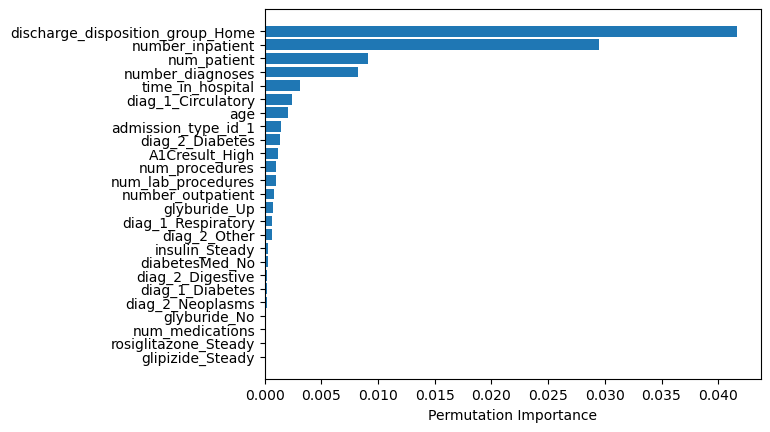

In [294]:
plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [295]:
colx_25 =x_train.columns[sorted_idx]
colx_25

Index(['glipizide_Steady', 'rosiglitazone_Steady', 'num_medications',
       'glyburide_No', 'diag_2_Neoplasms', 'diag_1_Diabetes',
       'diag_2_Digestive', 'diabetesMed_No', 'insulin_Steady', 'diag_2_Other',
       'diag_1_Respiratory', 'glyburide_Up', 'number_outpatient',
       'num_lab_procedures', 'num_procedures', 'A1Cresult_High',
       'diag_2_Diabetes', 'admission_type_id_1', 'age', 'diag_1_Circulatory',
       'time_in_hospital', 'number_diagnoses', 'num_patient',
       'number_inpatient', 'discharge_disposition_group_Home'],
      dtype='object')

In [296]:
x_ds_xg = x_ds[colx_25]
x_test_xg = x_test[colx_25]

In [297]:
final_xg.fit(x_ds_xg, y_ds)
y_pred_xg2 = final_xg.predict(x_test_xg)
print (metrics.roc_auc_score(y_test, y_pred_xg2))
print(confusion_matrix(y_test,y_pred_xg2))
print(metrics.precision_score(y_test,y_pred_xg2))
print(metrics.f1_score(y_test,y_pred_xg2))

[21:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6236451726016933
[[3611 2066]
 [ 208  327]]
0.13664855829502717
0.22336065573770492


In [139]:
#drop correlated features

In [298]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();

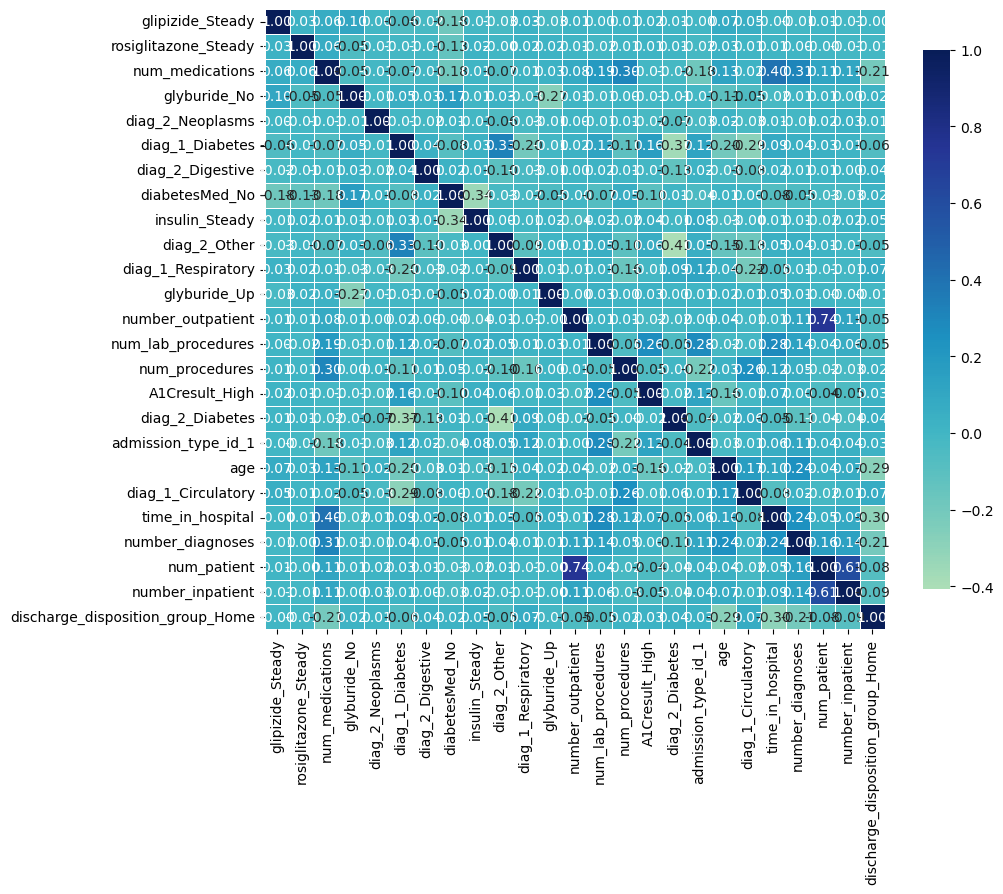

In [299]:
correlation_heatmap(x_train[x_train.columns[sorted_idx]])

In [301]:
x_train_final = x_ds_xg.drop('num_patient',axis=1)
x_train_final.columns

Index(['glipizide_Steady', 'rosiglitazone_Steady', 'num_medications',
       'glyburide_No', 'diag_2_Neoplasms', 'diag_1_Diabetes',
       'diag_2_Digestive', 'diabetesMed_No', 'insulin_Steady', 'diag_2_Other',
       'diag_1_Respiratory', 'glyburide_Up', 'number_outpatient',
       'num_lab_procedures', 'num_procedures', 'A1Cresult_High',
       'diag_2_Diabetes', 'admission_type_id_1', 'age', 'diag_1_Circulatory',
       'time_in_hospital', 'number_diagnoses', 'number_inpatient',
       'discharge_disposition_group_Home'],
      dtype='object')

In [302]:
x_test_final = x_test_xg.drop('num_patient',axis=1)

In [303]:
final_xg.fit(x_train_final, y_ds)
y_pred_xg3 = final_xg.predict(x_test_final)
print (metrics.roc_auc_score(y_test, y_pred_xg3))
print(confusion_matrix(y_test,y_pred_xg3))
print(metrics.precision_score(y_test,y_pred_xg3))
print(metrics.f1_score(y_test,y_pred_xg3))

[21:53:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6263412457876429
[[3631 2046]
 [ 207  328]]
0.13816343723673125
0.2255070470952217


In [348]:
print(metrics.recall_score(y_test,y_pred_xg3))

0.6130841121495327


In [237]:
y_pred_proba = final_xg.predict_proba(x_test_final)

In [346]:


x_train[x_train_final.columns].shape

(18635, 24)

In [343]:
print(x_train_final.shape)
print(x_test_final.shape)

(3338, 24)
(6212, 24)


##  k means clustering

In [172]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [173]:
from sklearn.decomposition import PCA

#### k means (elbow method_ on original X dataset then using PCA to reduce and plot,

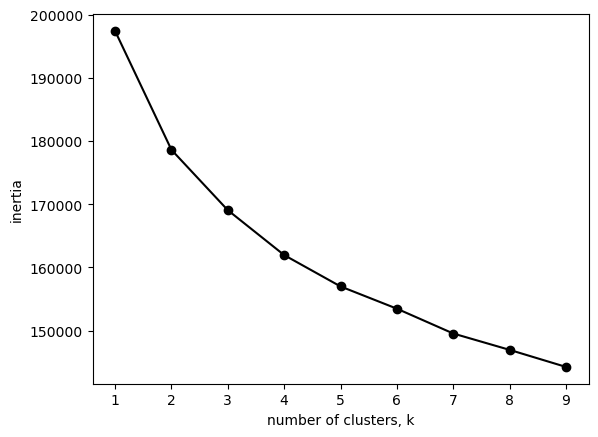

In [174]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [175]:
df_scale2 = X.copy()
kmeans_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df_scale2)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_scale2, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([df_scale2, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.07576204729482526


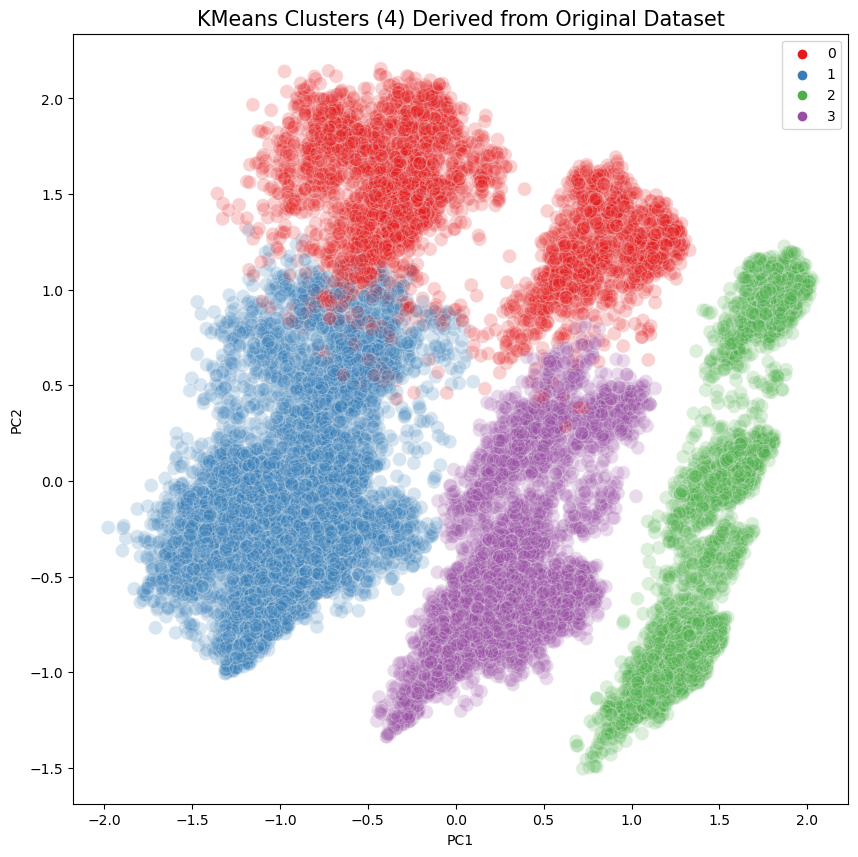

In [176]:
pca2 = PCA(n_components=3).fit(df_scale2)
pca2d = pca2.transform(df_scale2)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

##### PCA then k-means

In [177]:
# Make an instance of the Model
pca = PCA(.75)

In [178]:
pca.fit(X)

PCA(n_components=0.75)

In [179]:
X_PCA = pca.transform(X)

In [180]:
print("original shape:   ", X.shape)
print("transformed shape:", X_PCA.shape)

original shape:    (24847, 132)
transformed shape: (24847, 17)


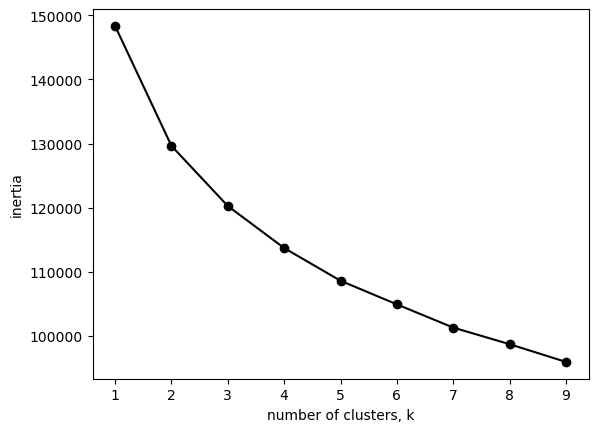

In [181]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X_PCA)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [182]:
df_scale3 = pd.DataFrame(X_PCA)
kmeans_scale = KMeans(n_clusters=4, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df_scale2)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_scale3, kmeans_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_scale.labels_
clusters_scale_pca = pd.concat([df_scale3, pd.DataFrame({'cluster_scaled':labels_pca_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.10454045385588993


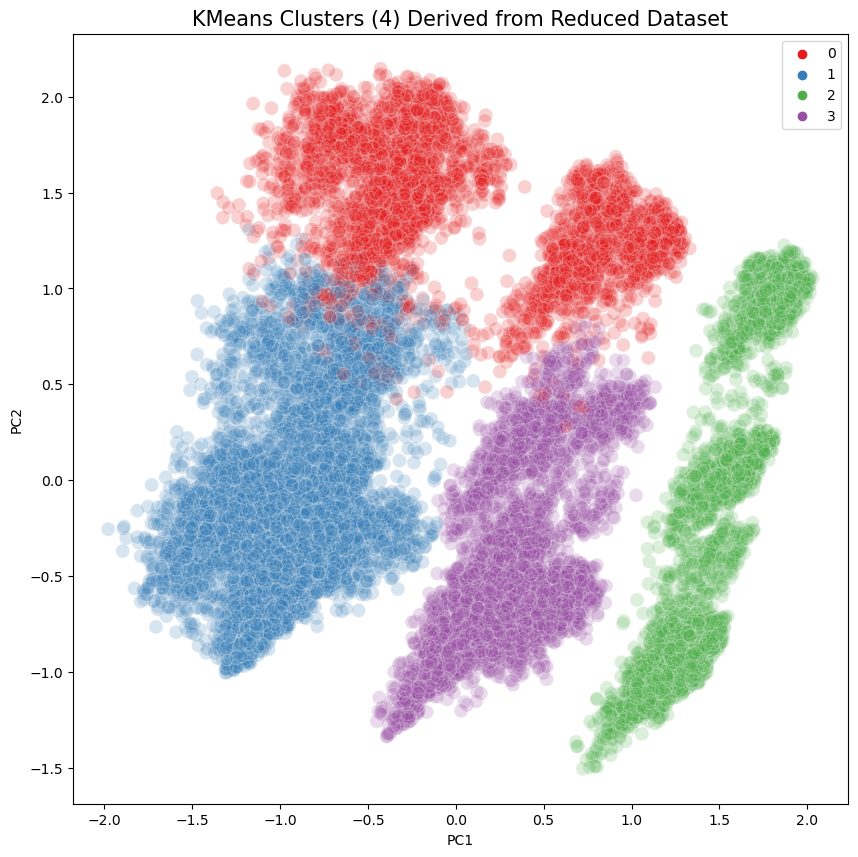

In [183]:
pca2 = PCA(n_components=3).fit(df_scale3)
pca2d = pca2.transform(df_scale3)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_pca_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (4) Derived from Reduced Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [184]:
clusters_scale_pca

0         1         2         3         4         5         6  \
0     -0.827239 -0.419674 -0.983821 -0.371044  0.334237 -0.035187 -0.124462   
1      0.418353 -0.684360 -1.059053 -0.503806  0.517082 -0.550556  0.385228   
2     -0.791472 -0.342565 -0.557232  0.922581  0.418201 -0.074802 -0.308141   
3     -0.790429 -0.268495  0.911741  0.537548 -0.088685 -0.503547 -0.600980   
4      0.617452  0.402710  1.025219  0.602097 -0.778375 -0.854125 -0.974804   
...         ...       ...       ...       ...       ...       ...       ...   
24842 -1.325359 -0.255820  0.579567 -0.896915  0.099477  1.281852  0.165525   
24843 -0.759939  1.943450  0.731948 -0.922167 -0.004139  0.528797 -0.514200   
24844 -1.329994 -0.269711  0.154930  0.697648  0.168879  0.091847  0.832430   
24845 -0.646936 -0.358656  1.027718  0.562635 -0.129021 -0.000525  0.032651   
24846 -1.665708 -0.516878 -0.113457  0.536485 -0.291799  1.162750  1.107397   

              7         8         9        10        11        12        13  \
0     -0.861039 -0.621205 -0.532759 -0.233441 -0.174349 -0.897553  0.189447   
1      0.637036 -0.125723 -0.126003 -0.111355  1.253059 -1.004447  0.474278   
2     -0.370536 -0.855162 -0.587542 -0.706911 -0.121003  0.223517 -0.311036   
3     -0.142006 -0.155163 -0.430159 -0.311346  1.103899 -0.257871 -0.161138   
4      0.145973 -0.216021  0.241667  0.601499 -0.145581 -0.011594  0.202964   
...         ...       ...       ...       ...       ...       ...       ...   
24842 -0.538866  0.350249  0.717432 -1.037860 -0.841190  0.106633  0.578179   
24843  0.335003  0.703239  1.004634  0.099290  0.772955 -0.418061 -0.786637   
24844  0.188709  0.087350 -0.582756  0.365558 -0.262575  0.146366 -0.543492   
24845 -0.574789 -0.698596 -0.586308 -0.228299 -0.002705  0.371359  0.726554   
24846  0.918880  0.496820  0.544725 -0.343412 -0.196421  0.963747 -0.408465   

             14        15        16  cluster_scaled  
0     -0.060655 -0.187014  0.005709               1  
1      0.358340  0.175737 -0.201791               3  
2     -0.037518 -0.353119  0.083256               1  
3      0.198102 -0.105058 -0.205892               1  
4     -0.268104 -0.407517 -0.010259               3  
...         ...       ...       ...             ...  
24842  0.435732 -0.044306 -0.400308               1  
24843 -0.226091  0.038053 -0.050808               0  
24844 -0.582119  0.048917 -0.036449               1  
24845 -0.504016  0.195139 -0.126478               1  
24846 -0.626325  0.154238 -0.005014               1  

[24847 rows x 18 columns]

In [185]:
pca_df = pd.concat([df.reset_index(), pd.DataFrame({'cluster_scaled':labels_pca_scale}).reset_index()], axis=1)

In [186]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24847 entries, 0 to 24846
Data columns (total 52 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        24847 non-null  int64  
 1   race                         24124 non-null  object 
 2   gender                       24847 non-null  object 
 3   age                          24847 non-null  int64  
 4   admission_type_id            24847 non-null  object 
 5   admission_source_id          24847 non-null  object 
 6   time_in_hospital             24847 non-null  int64  
 7   num_lab_procedures           24847 non-null  int64  
 8   num_procedures               24847 non-null  int64  
 9   num_medications              24847 non-null  int64  
 10  number_outpatient            24847 non-null  int64  
 11  number_emergency             24847 non-null  int64  
 12  number_inpatient             24847 non-null  int64  
 13  diag_1          

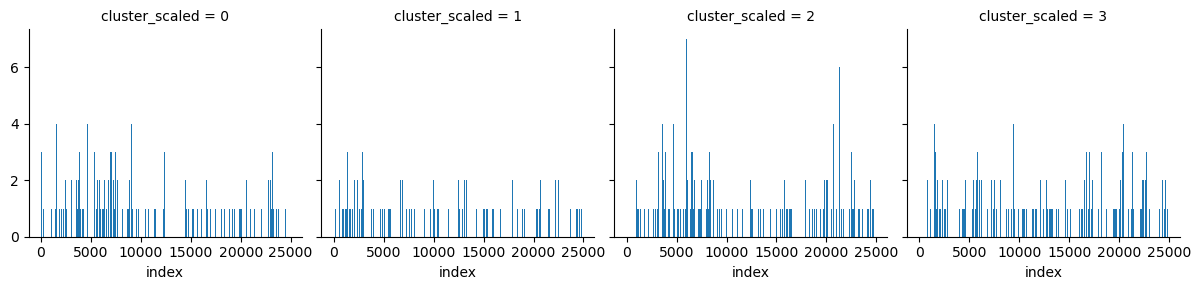

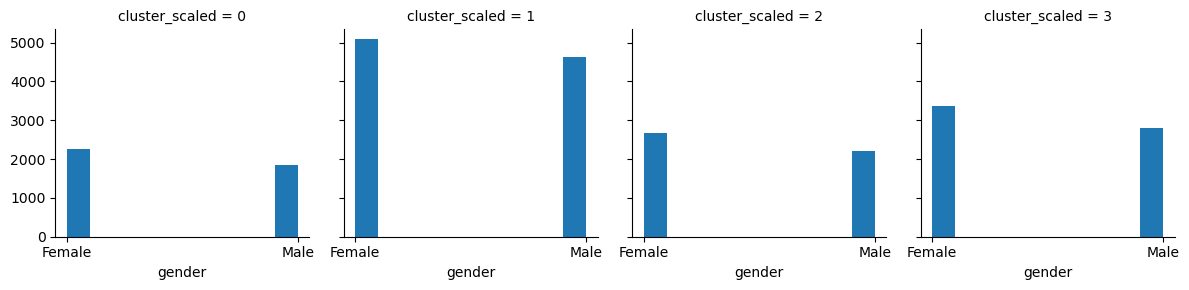

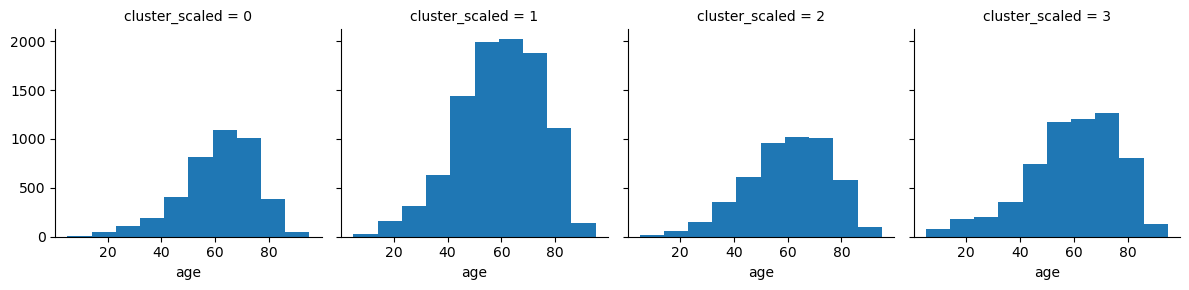

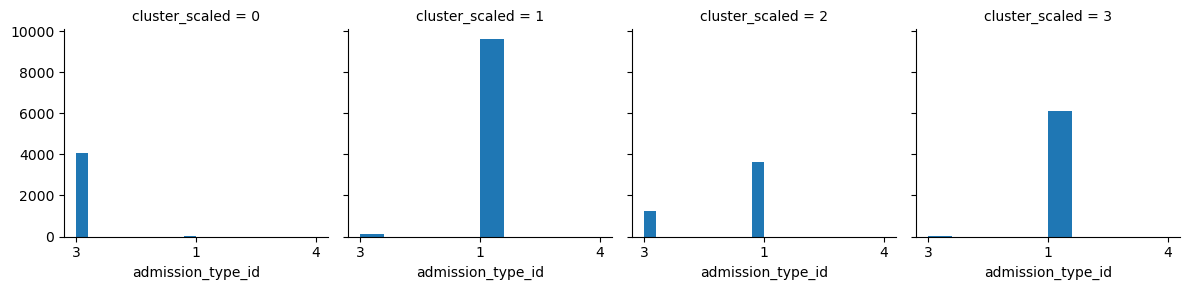

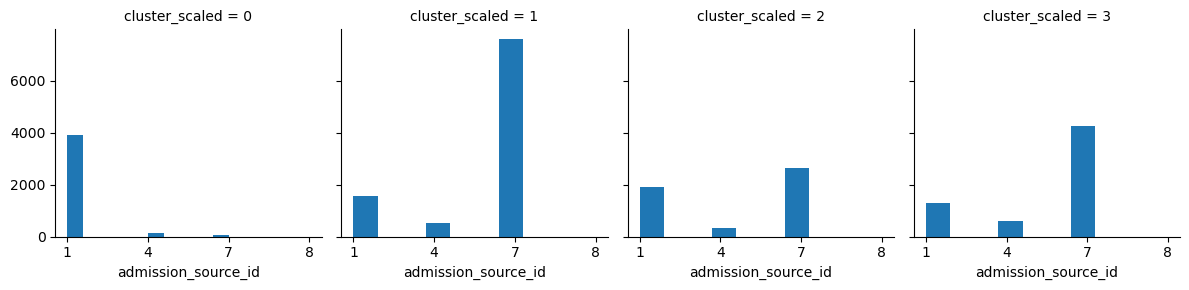

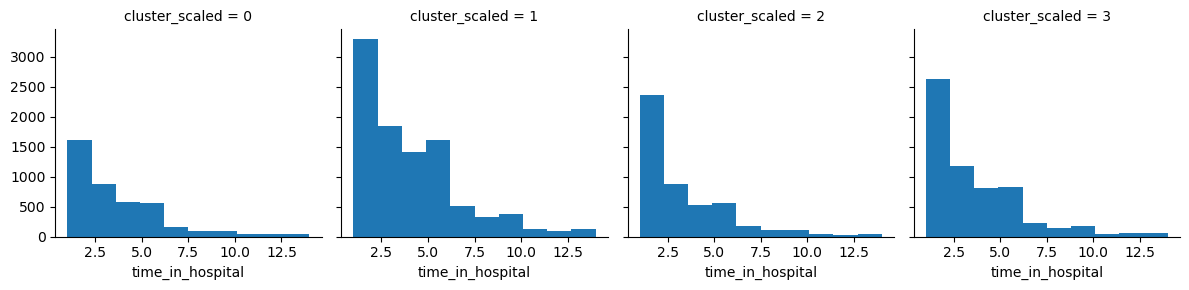

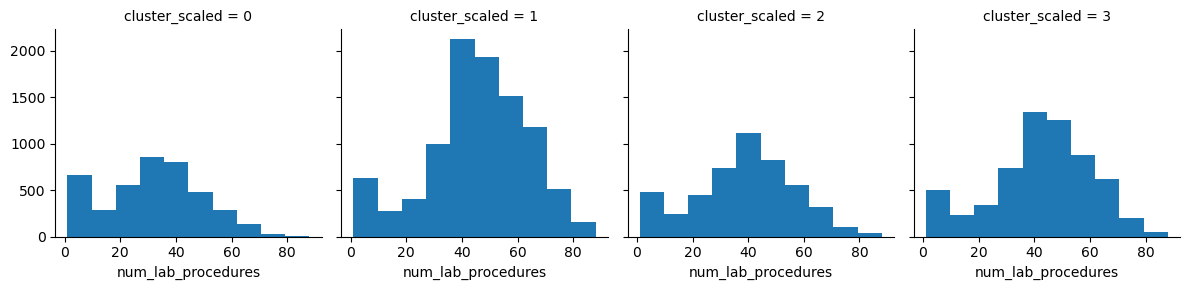

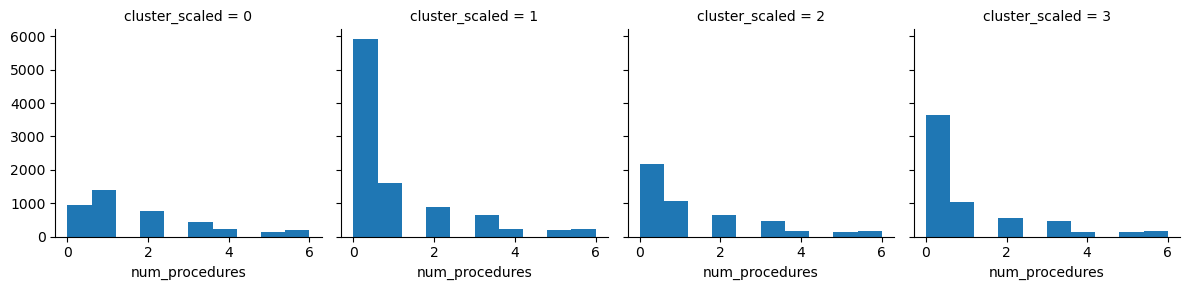

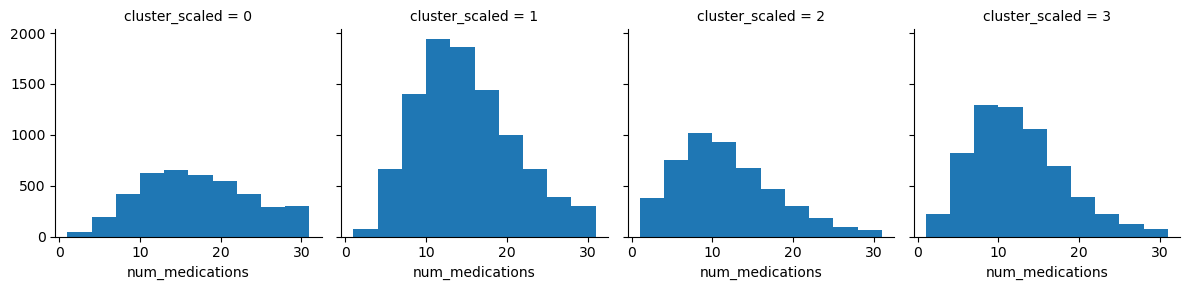

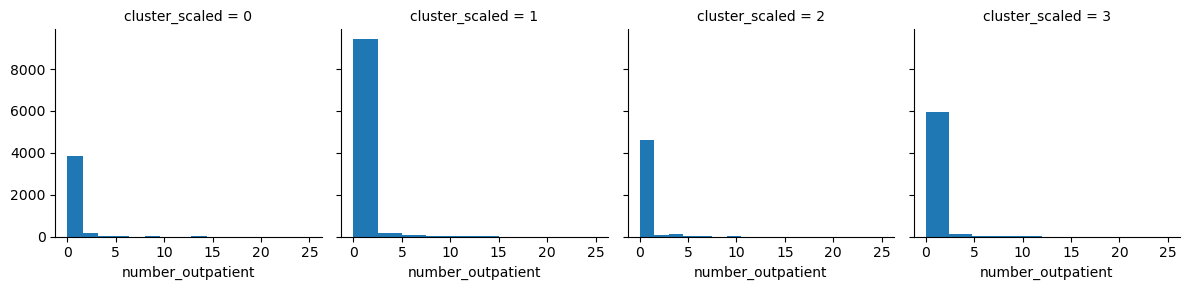

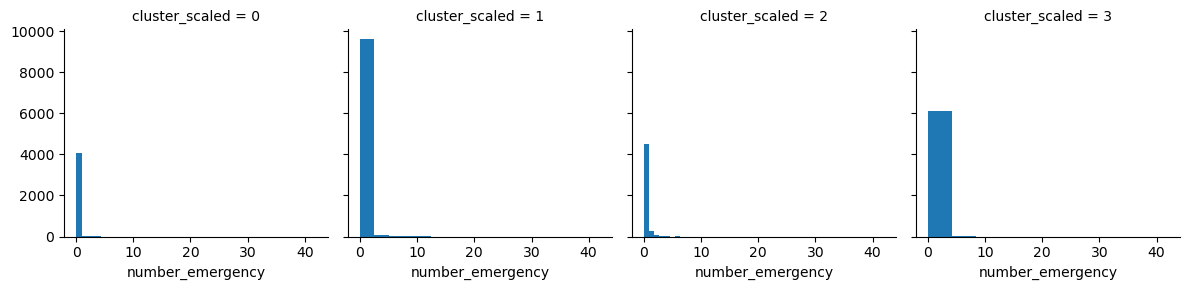

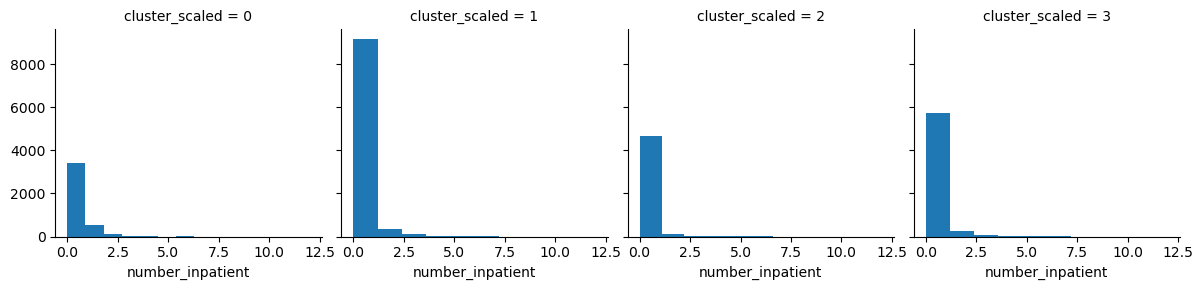

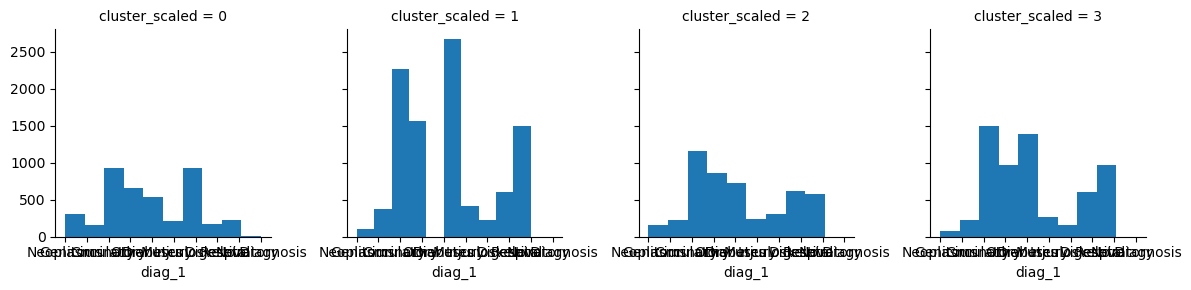

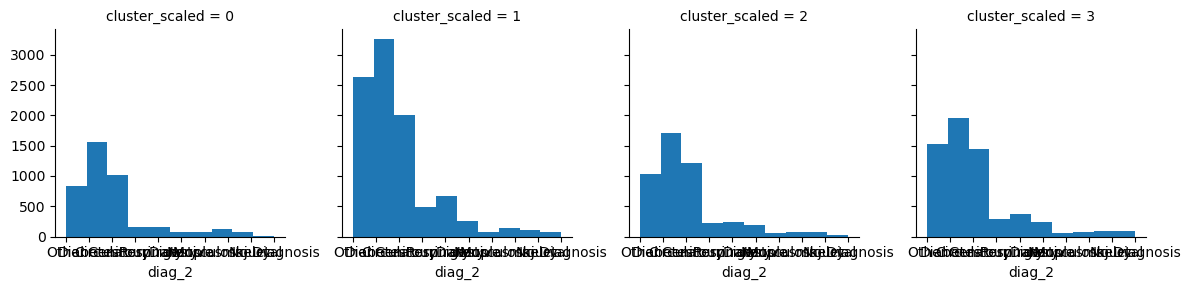

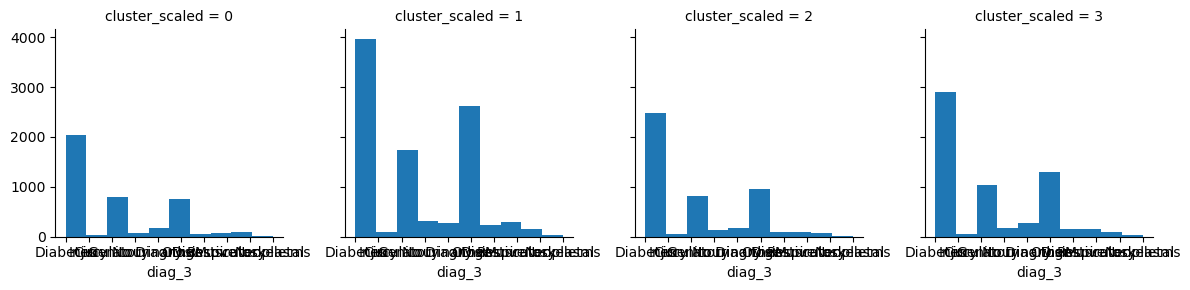

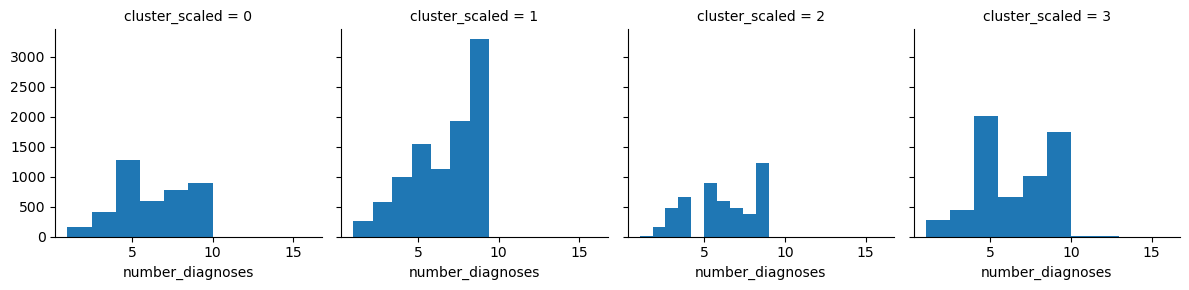

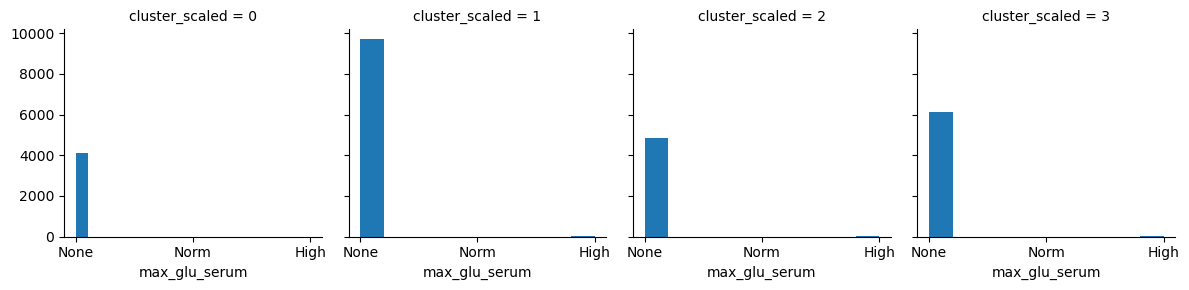

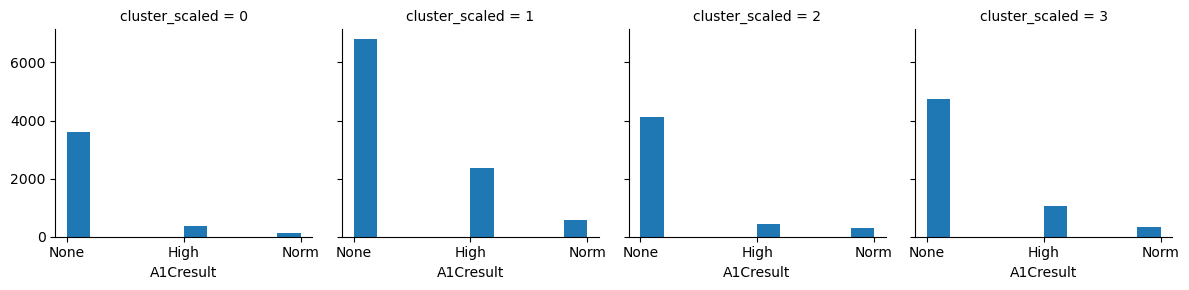

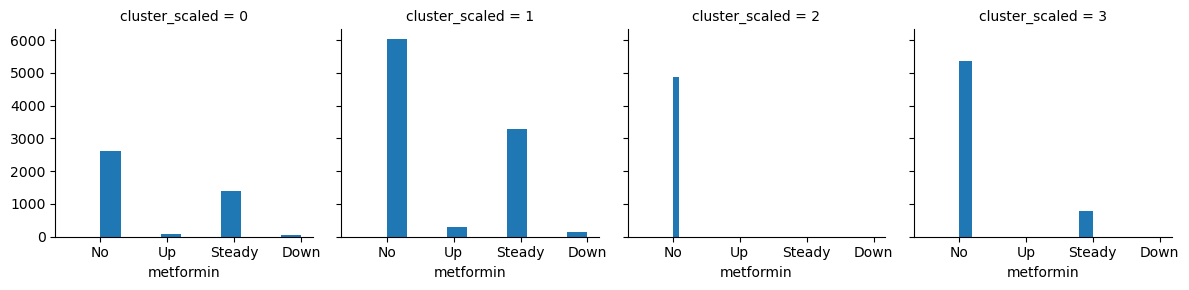

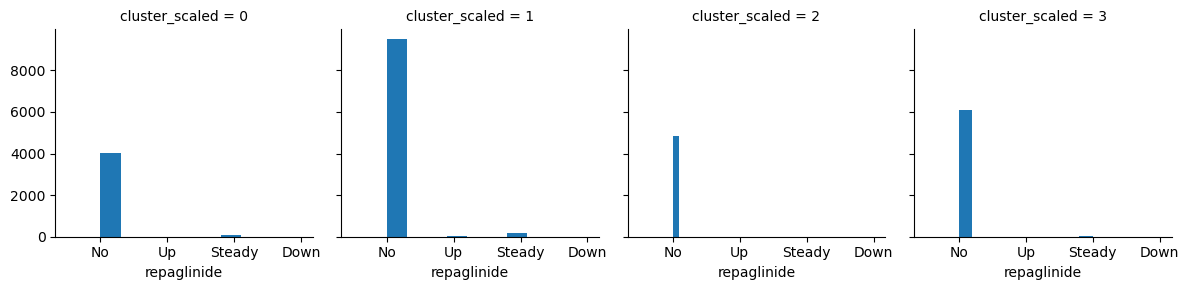

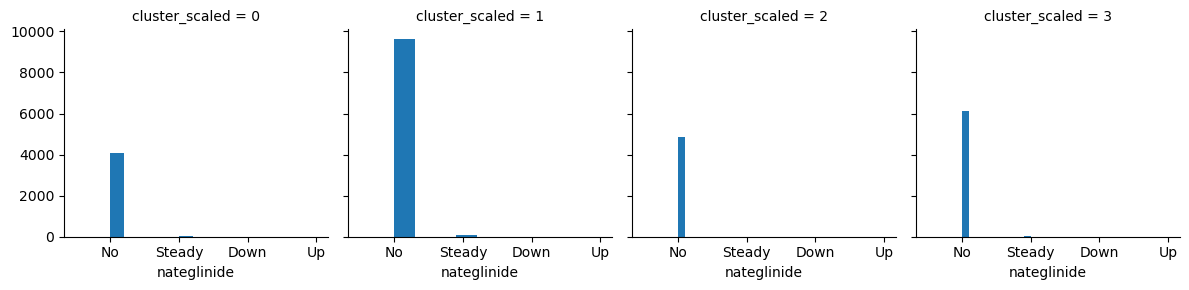

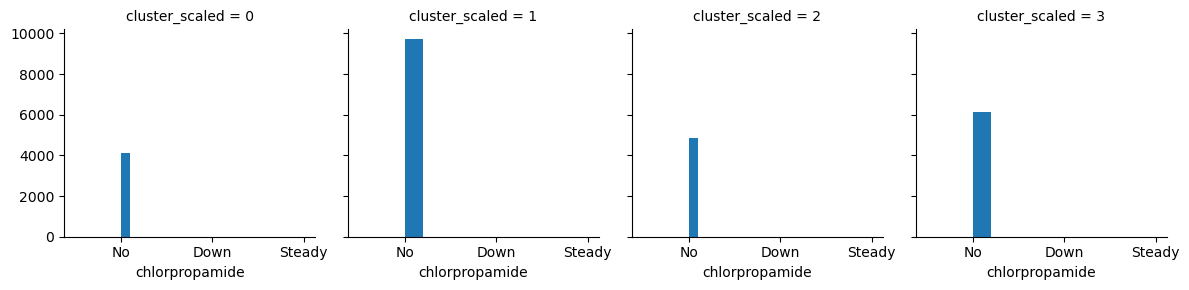

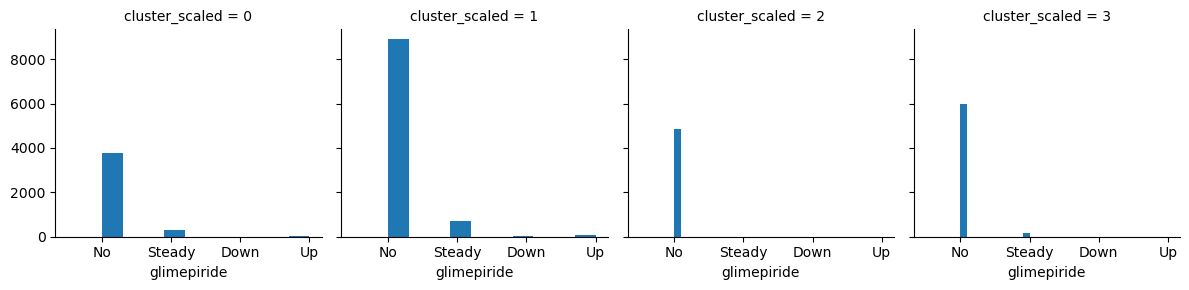

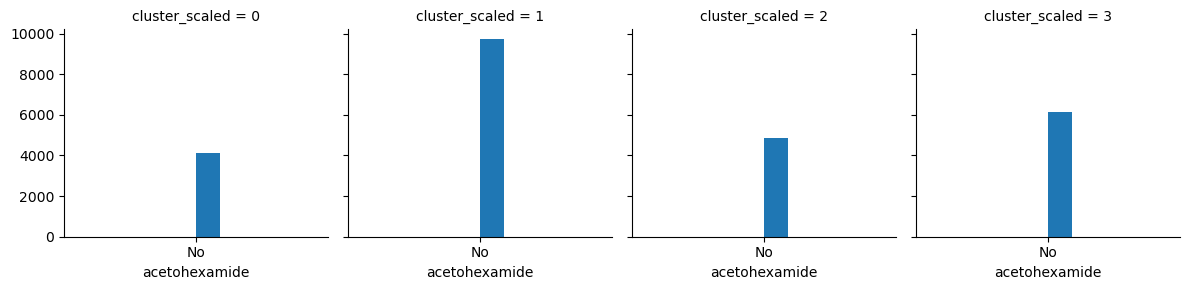

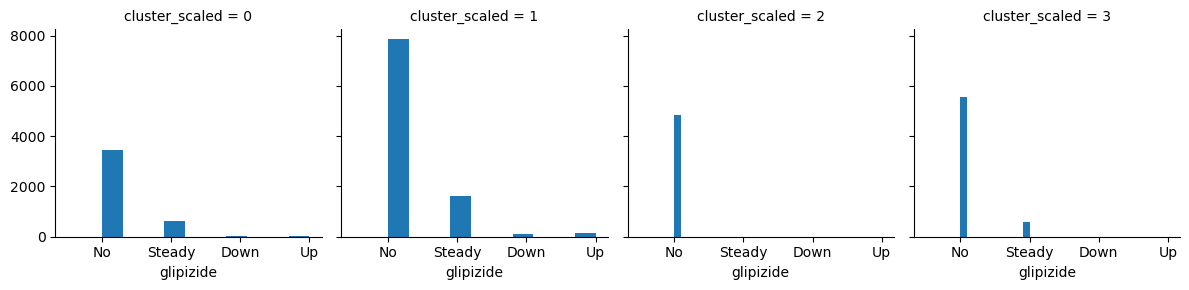

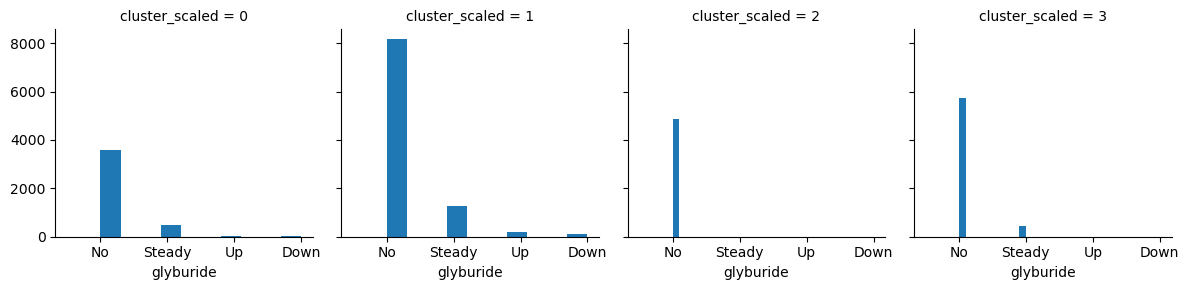

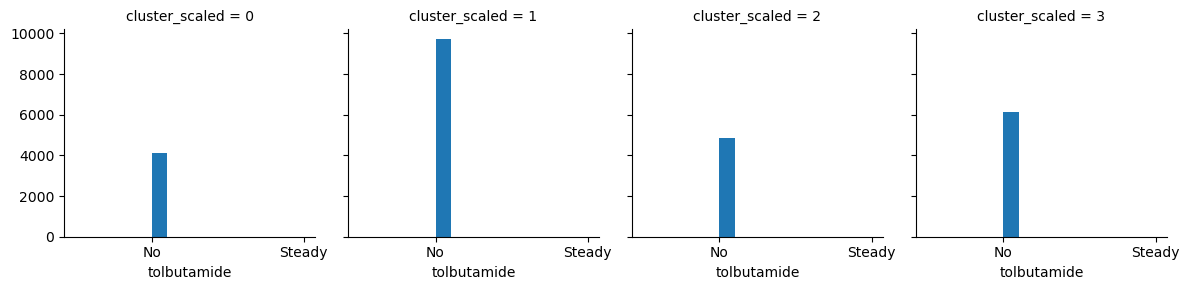

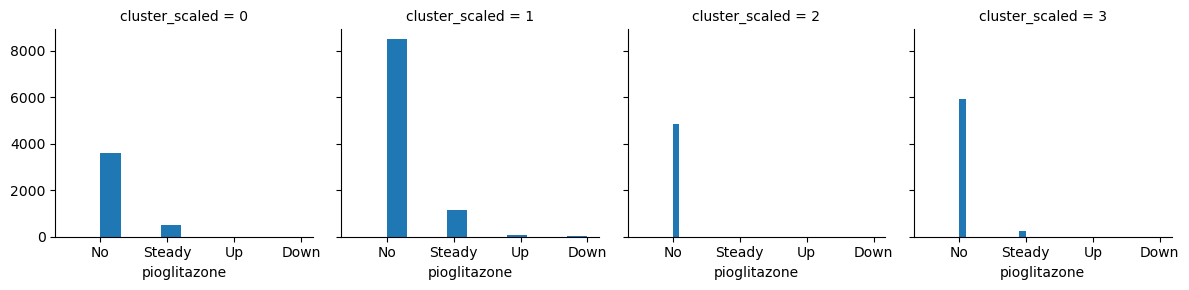

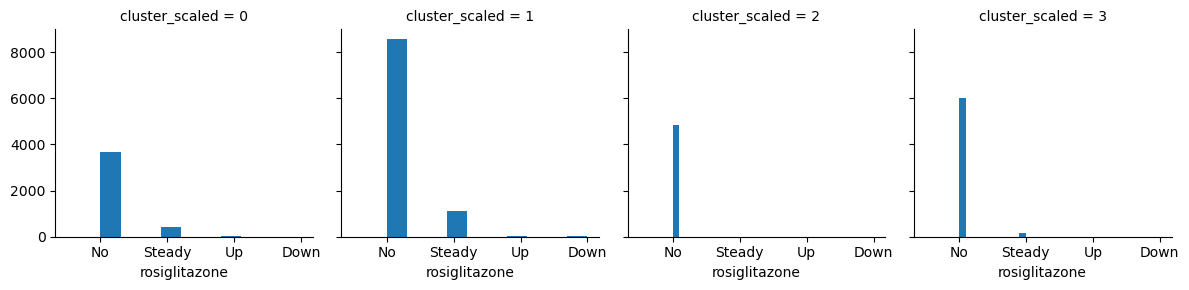

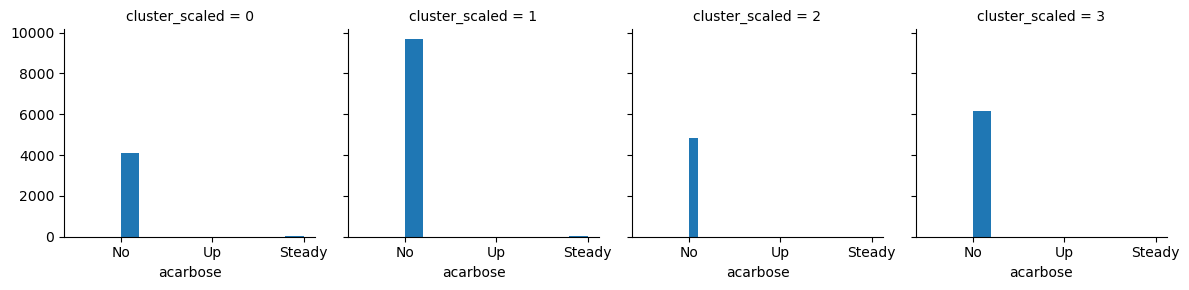

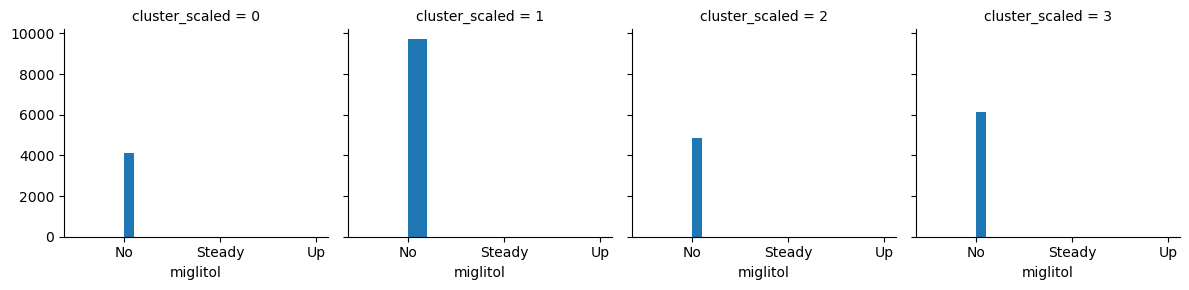

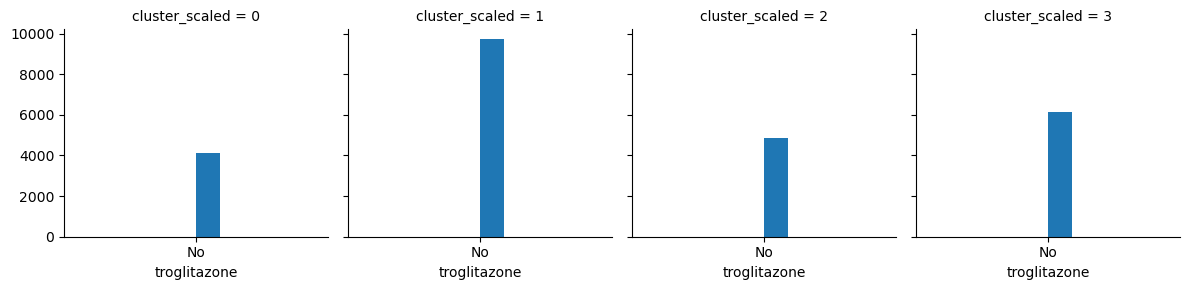

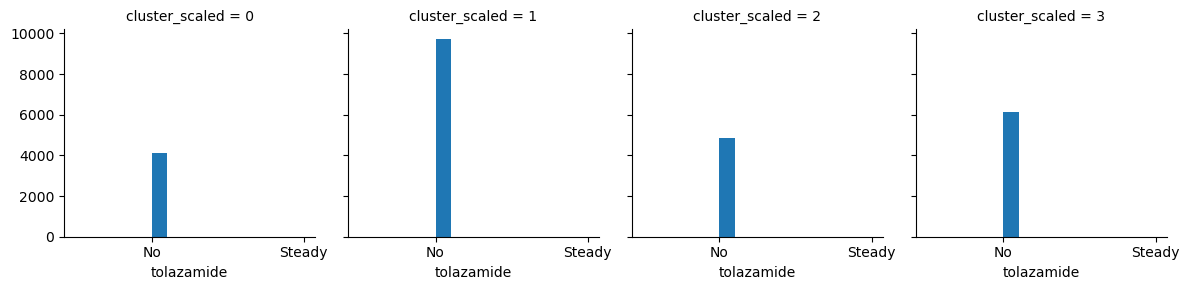

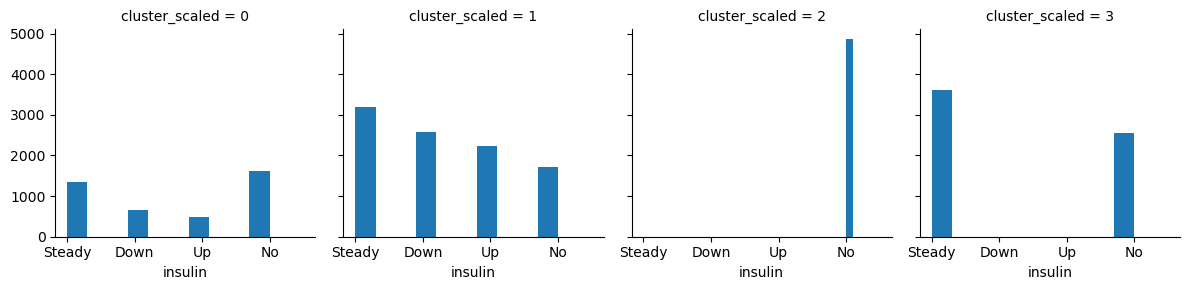

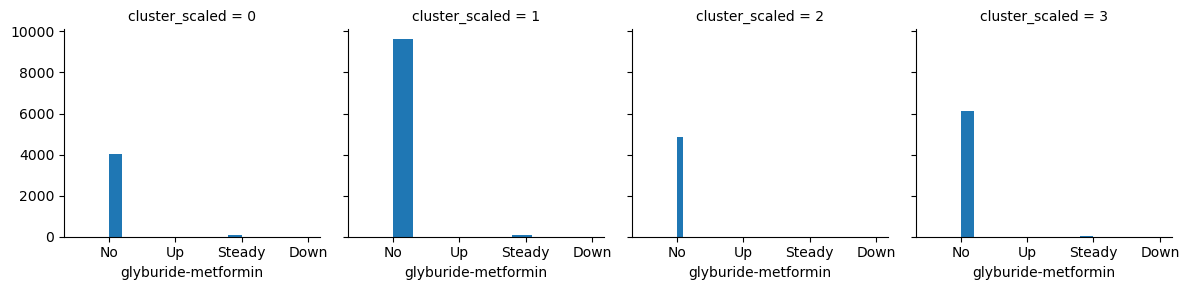

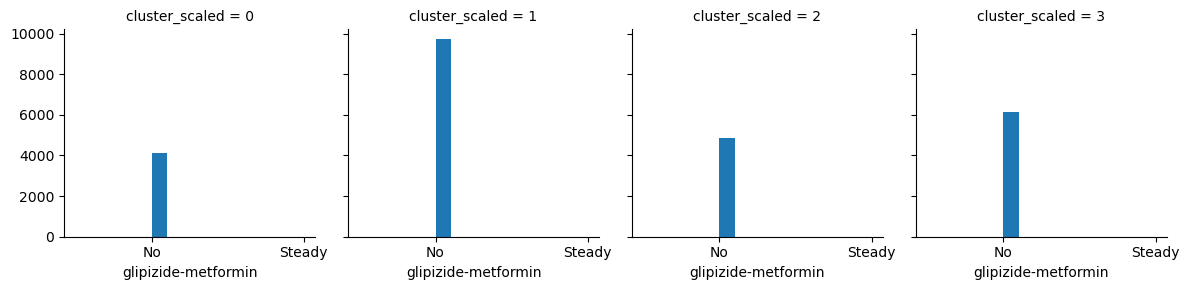

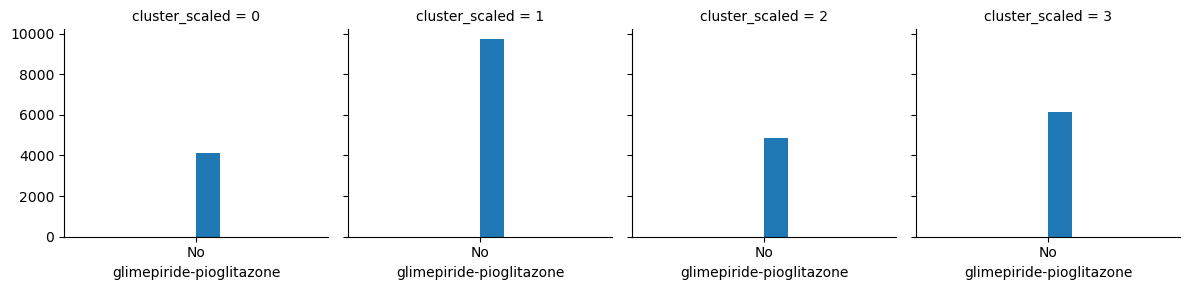

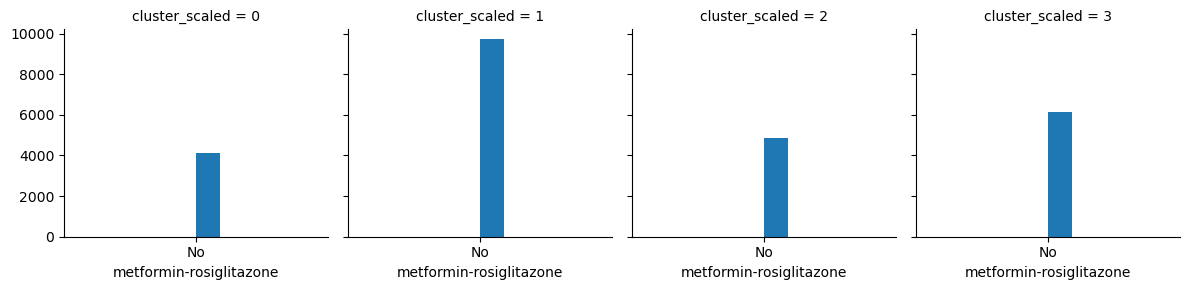

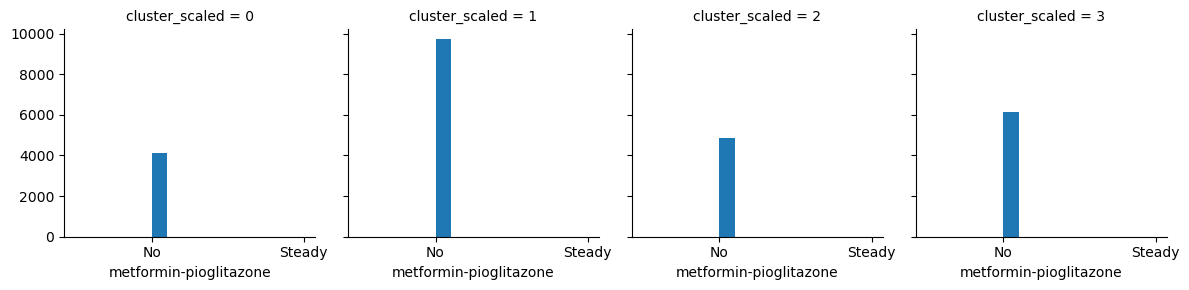

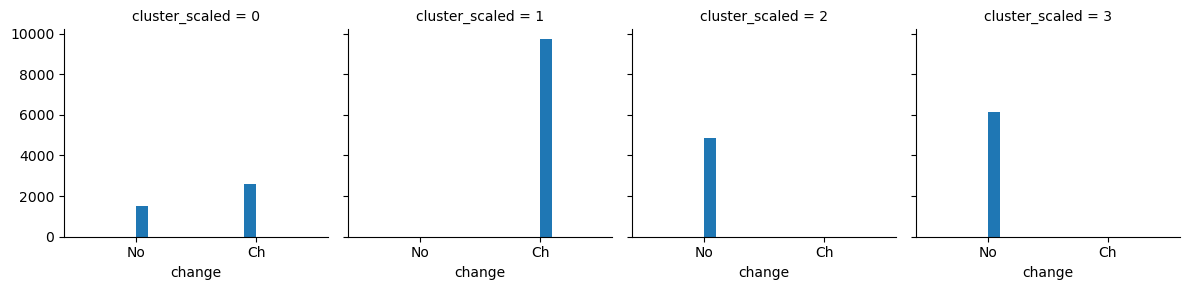

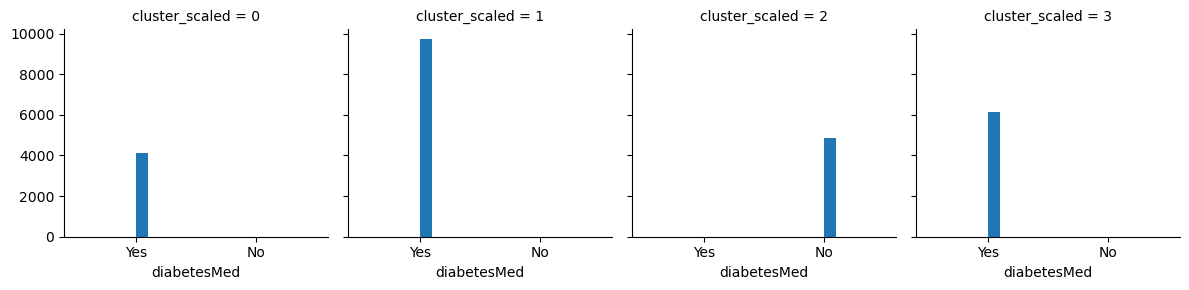

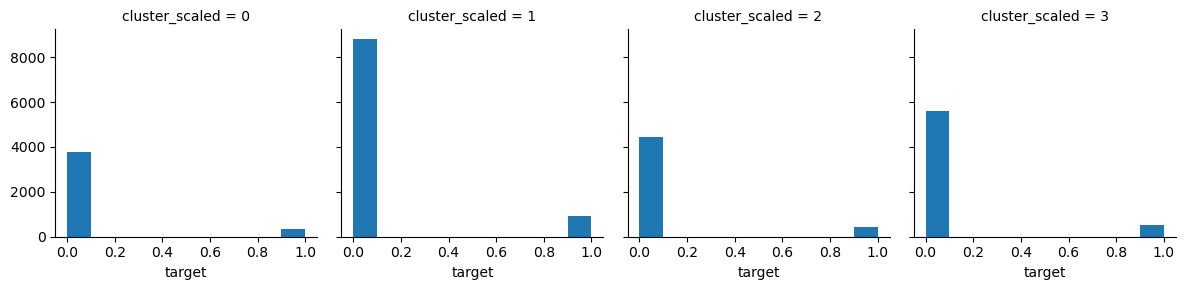

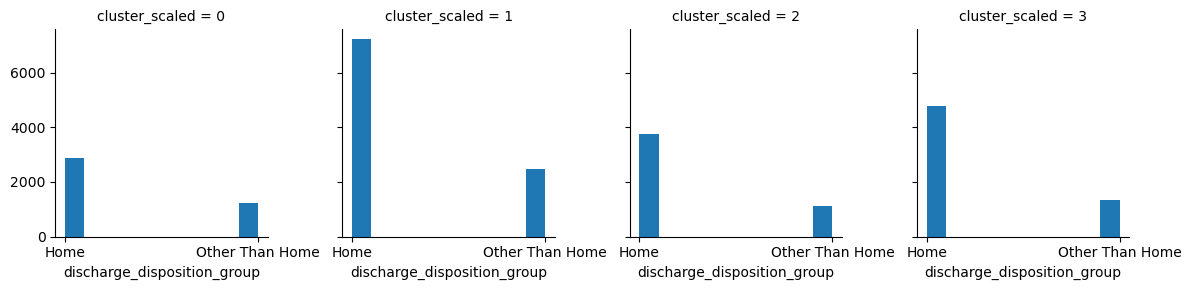

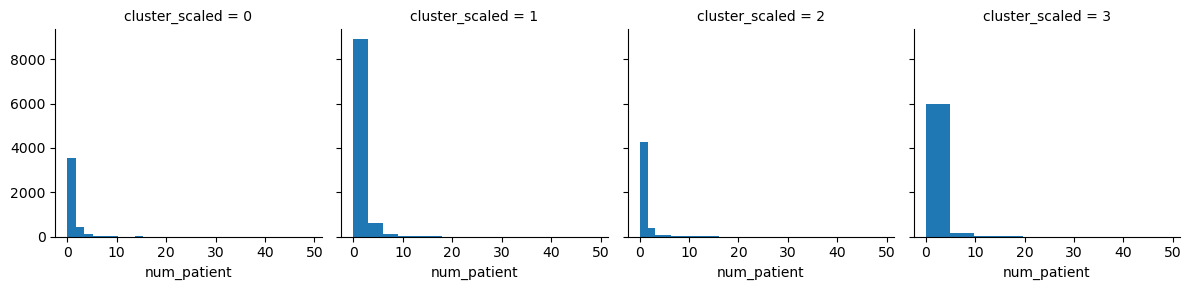

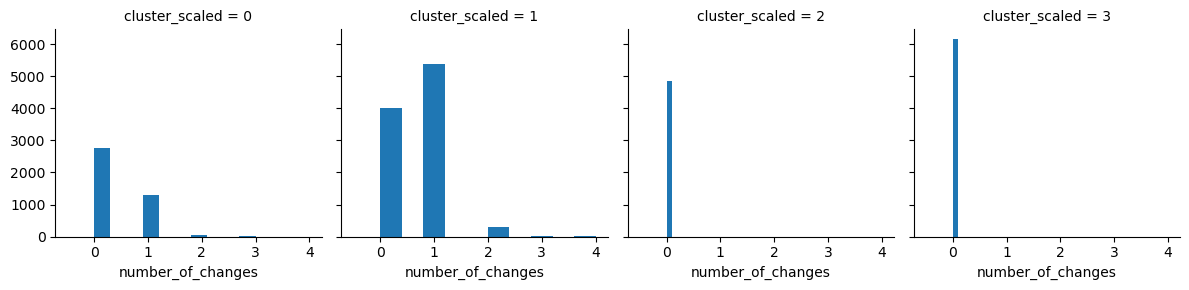

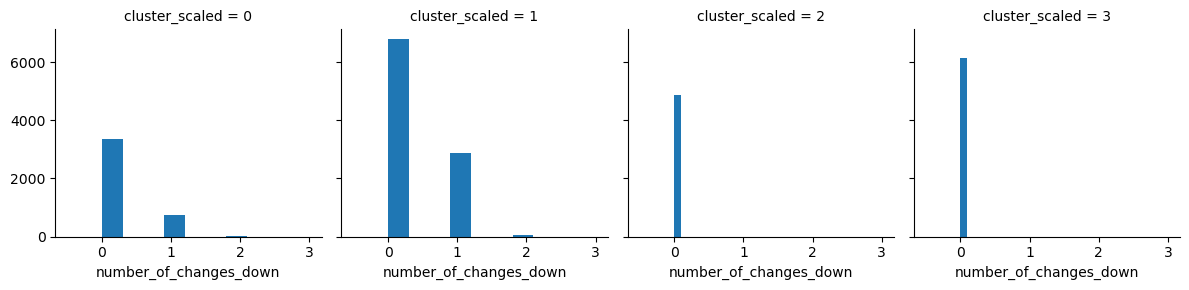

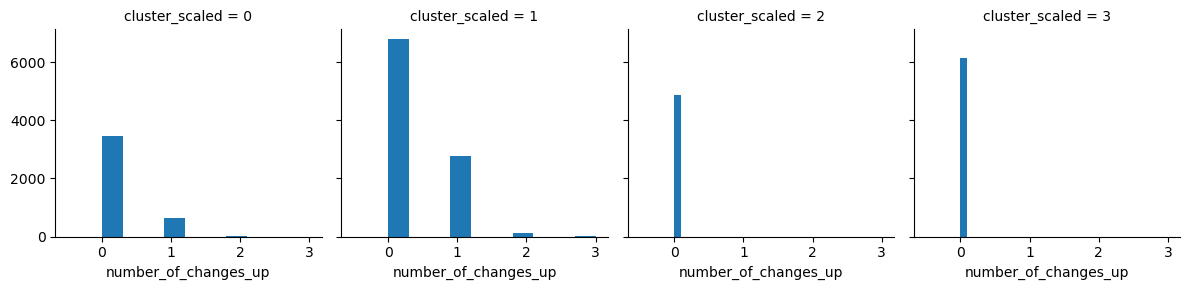

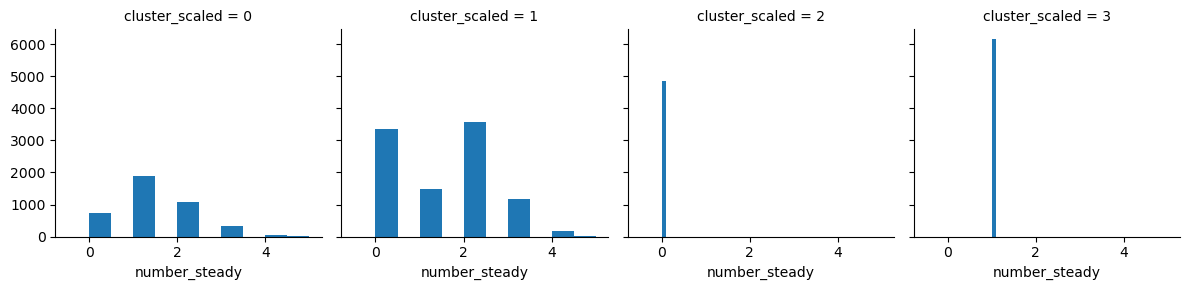

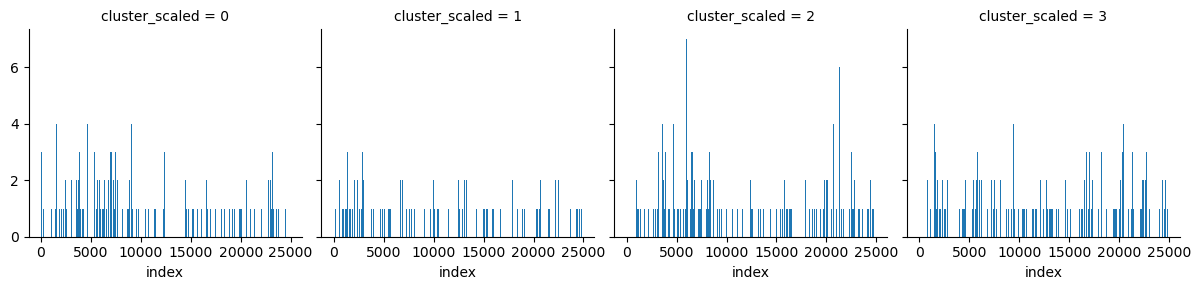

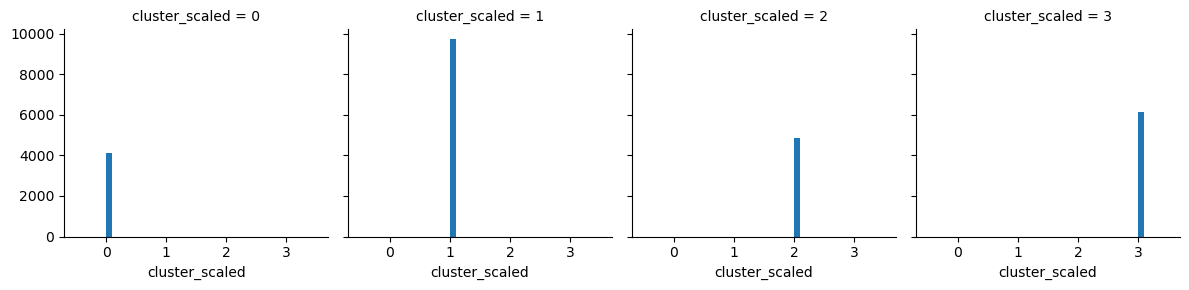

In [187]:
#drop_list = 'severity_index
drop_list = 'race'

pca_df = pca_df.drop(drop_list,axis=1)

drop_list = 'severity_index'
pca_df = pca_df.drop(drop_list,axis=1)

for c in pca_df:
    grid = sns.FacetGrid(pca_df, col='cluster_scaled')
    grid.map(plt.hist, c)
    plt.show()

In [188]:
pca_df.groupby(by=['cluster_scaled'])['target'].mean()

cluster_scaled
0    0.080574
1    0.094435
2    0.084739
3    0.088207
Name: target, dtype: float64

In [189]:
pca_df.groupby(by=['cluster_scaled'])['num_lab_procedures'].mean()

cluster_scaled
0    31.396787
1    45.446045
2    38.421843
3    42.471248
Name: num_lab_procedures, dtype: float64

In [190]:
pca_df.groupby(by=['cluster_scaled'])['num_procedures'].mean()

cluster_scaled
0    1.730039
1    0.893324
2    1.277458
3    0.946069
Name: num_procedures, dtype: float64

In [191]:
pca_df.groupby(by=['cluster_scaled'])['num_medications'].mean()

cluster_scaled
0    16.490263
1    14.457257
2    11.239613
3    11.951592
Name: num_medications, dtype: float64

In [192]:
pca_df.groupby(by=['cluster_scaled'])['number_of_changes'].mean()

cluster_scaled
0    0.349805
1    0.623598
2    0.000000
3    0.000000
Name: number_of_changes, dtype: float64

In [308]:
pca_df.groupby(by=['cluster_scaled'])['time_in_hospital'].mean()

cluster_scaled
0    3.558423
1    4.016459
2    3.277664
3    3.528590
Name: time_in_hospital, dtype: float64

In [194]:
ad_type_count = pca_df.groupby(['cluster_scaled','admission_type_id']).agg({'target': 'count'})

ad_type_pcts = ad_type_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

ad_type_pcts.unstack()

target                     
admission_type_id          1          3         4
cluster_scaled                                   
0                   1.241480  98.758520       NaN
1                  98.775846   1.203580  0.020574
2                  74.496092  25.503908       NaN
3                  99.171540   0.795971  0.032489

In [195]:
age_count = pca_df.groupby(['cluster_scaled','age']).agg({'target': 'count'})

age_pcts = age_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

age_pcts.unstack()

target                                                      \
age                   5         15        25        35         45         55   
cluster_scaled                                                                 
0               0.170399  1.217137  2.580331  4.698150   9.931840  19.936709   
1               0.288036  1.676782  3.188972  6.470528  14.792717  20.543154   
2               0.411353  1.110654  3.167421  7.219251  12.607980  19.806664   
3               1.332034  3.005198  3.248863  5.766732  12.037037  19.135802   

                                                           
age                    65         75         85        95  
cluster_scaled                                             
0               26.460565  24.586173   9.323272  1.095424  
1               20.790042  19.391009  11.428865  1.429894  
2               20.937886  20.835047  11.867544  2.036199  
3               19.558155  20.646524  13.157895  2.111761

In [196]:
th_count = pca_df.groupby(['cluster_scaled','time_in_hospital']).agg({'target': 'count'})

th_pcts = th_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

th_pcts.unstack()

target                                             \
time_in_hospital         1          2          3          4         5    
cluster_scaled                                                           
0                 21.178189  18.184031  21.567673  13.899708  8.057449   
1                 13.681720  20.234544  19.020677  14.525255  9.957823   
2                 26.264912  22.377622  18.140683  10.777458  6.890169   
3                 19.379467  23.245614  19.087070  13.157895  8.170890   

                                                                              \
time_in_hospital        6         7         8         9         10        11   
cluster_scaled                                                                 
0                 5.647517  3.700097  2.458617  1.411879  0.998053  0.851996   
1                 6.552824  5.246374  3.374138  2.232281  1.707643  1.255015   
2                 4.668861  3.805019  2.344714  1.048951  1.275195  0.946113   
3                 5.376868  3.736192  2.420403  1.591943  1.218324  0.795971   

                                                
time_in_hospital        12        13        14  
cluster_scaled                                  
0                 0.900682  0.632911  0.511198  
1                 0.874396  0.678942  0.658368  
2                 0.575895  0.534759  0.349650  
3                 0.860949  0.552307  0.406108

In [197]:
diag_1_count = pca_df.groupby(['cluster_scaled','diag_1']).agg({'target': 'count'})

diag_1_pcts = diag_1_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

diag_1_pcts.unstack()

target                                                \
diag_1         Circulatory   Diabetes  Digestive Genitourinary    Injury   
cluster_scaled                                                             
0                22.492697  12.950341   4.211295      3.797468  5.014606   
1                23.320646  27.445736   6.254501      3.806193  4.279395   
2                23.837927  14.870424  12.731386      4.566022  4.956808   
3                24.301494  22.547109   9.876543      3.606238  4.385965   

                                                                              
diag_1         Musculoskeletal Neoplasms No Diagnosis      Other Respiratory  
cluster_scaled                                                                
0                    22.517040  7.448880     0.048685  16.114898    5.404090  
1                     2.283716  1.090423          NaN  16.088880   15.430511  
2                     6.273139  3.352530     0.020568  17.626491   11.764706  
3                     2.599090  1.332034     0.016244  15.675763   15.659519

In [198]:
diag_2_count = pca_df.groupby(['cluster_scaled','diag_2']).agg({'target': 'count'})

diag_2_pcts = diag_2_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

diag_2_pcts.unstack()

target                                               \
diag_2         Circulatory   Diabetes Digestive Genitourinary    Injury   
cluster_scaled                                                            
0                24.780915  38.023369  1.996105      3.675755  2.020448   
1                20.687172  33.504783  2.643761      4.958338  1.183006   
2                25.133690  35.232415  3.825586      4.463184  1.460304   
3                23.570500  31.822612  3.784925      4.727096  1.461988   

                                                                              
diag_2         Musculoskeletal Neoplasms No Diagnosis      Other Respiratory  
cluster_scaled                                                                
0                     3.067186  1.801363     0.413827  20.204479    4.016553  
1                     1.501903  0.699517     0.761239  27.147413    6.912869  
2                     1.624846  1.336898     0.452489  21.369807    5.100782  
3                     1.332034  0.958415     1.413255  24.772580    6.156595

In [199]:
diag_3_count = pca_df.groupby(['cluster_scaled','diag_3']).agg({'target': 'count'})

diag_3_pcts = diag_3_count.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

diag_3_pcts.unstack()

target                                               \
diag_3         Circulatory   Diabetes Digestive Genitourinary    Injury   
cluster_scaled                                                            
0                19.352483  49.707887  1.484907      1.971762  0.803311   
1                17.961115  40.726263  2.386586      3.291842  0.997840   
2                16.824352  50.966680  1.892225      2.550391  1.048951   
3                16.861598  47.238467  2.485380      2.696556  0.795971   

                                                                              
diag_3         Musculoskeletal Neoplasms No Diagnosis      Other Respiratory  
cluster_scaled                                                                
0                     2.190847  0.194742     4.113924  18.403116    1.777020  
1                     1.604773  0.360045     2.787779  26.849090    3.034667  
2                     1.357466  0.349650     3.599342  19.559852    1.851090  
3                     1.397011  0.438596     4.515919  21.020143    2.550357

#### cluster 0: referrals from dr, elective care, primary diagnosis more often muscoskeletal or neoplasms, taking diabetes medcine, less severe hospitalizations. SOME SORT OF SYMPTOM AT OUTPATIENT - LIKELY MEDICINE CHANGE. THEY WERE GOING TO DR - MAYBE NOT SDH PROBLEM. CARE MANAGEMENT MAY BE TEMPORARY. LOW TOUCH SUPPORT.

#### cluster 1: most severe hospitalizations, emergency room source and er type, primary diagnosis diabetes, respiratory, other. taking diabetes medicine, most often a change in prescription. FOCUSED PATIENT MONITORING - SNF/HIGHER ACUTEY SIGHT OF CARE. RISK MITIGATION IN FIRST 30 DAYS.

#### cluster 2: not taking medicine -  newly diagnoses. TEST AIC AND DEVELOP CARE PLAN.

#### cluster 3: taking medicine but not change. primary diagnosis, circulatory or diabetes. NORMAL DIABETIC THAT CRASHED INTO ER - WAS THERE AN ADHERENCE PROBLEM? NOT SEEING DR ENOUGH. FOCUS ON SOCIAL DETERMINENTS OF HEALTH. IS IT EDUCATION? SHOULDN'T BE CRASHING - PATIENTS SHOULD BE ABLE TO MANAGE DIABETES. DIABETES COMMISSION MGMT PROGRAM - CHECK IN MONTHLY AND BUILD RELATIONSHIP WITH PATIENT. SUPPORT FOR SOCIAL DETERMINENTS OF HEALTH

In [200]:
pca_df.groupby(by=['cluster_scaled'])['age'].count()

cluster_scaled
0    4108
1    9721
2    4862
3    6156
Name: age, dtype: int64

In [201]:
pca_df

index  gender  age admission_type_id admission_source_id  \
0           1  Female   15                 1                   7   
1           2  Female   25                 1                   7   
2           3    Male   35                 1                   7   
3           4    Male   45                 1                   7   
4           5    Male   55                 1                   1   
...       ...     ...  ...               ...                 ...   
24842  101748  Female   45                 1                   7   
24843  101749  Female   75                 3                   1   
24844  101753    Male   45                 1                   7   
24845  101759    Male   85                 1                   7   
24846  101761    Male   75                 1                   7   

       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                     3                  59               0               18   
1                     2                  11               5               13   
2                     2                  44               1               16   
3                     1                  51               0                8   
4                     3                  31               6               16   
...                 ...                 ...             ...              ...   
24842                14                  69               0               16   
24843                 3                  27               1               29   
24844                13                  51               2               13   
24845                 1                   1               0               15   
24846                 3                  51               0               16   

       number_outpatient  ...  diabetesMed  target  \
0                      0  ...          Yes       0   
1                      2  ...          Yes       0   
2                      0  ...          Yes       0   
3                      0  ...          Yes       0   
4                      0  ...          Yes       0   
...                  ...  ...          ...     ...   
24842                  0  ...          Yes       0   
24843                  0  ...          Yes       0   
24844                  0  ...          Yes       0   
24845                  3  ...          Yes       0   
24846                  0  ...          Yes       0   

      discharge_disposition_group num_patient number_of_changes  \
0                            Home           0                 1   
1                            Home           3                 0   
2                            Home           0                 1   
3                            Home           0                 0   
4                            Home           0                 0   
...                           ...         ...               ...   
24842             Other Than Home           0                 2   
24843             Other Than Home           1                 0   
24844                        Home           0                 1   
24845                        Home           3                 1   
24846             Other Than Home           0                 1   

       number_of_changes_down number_of_changes_up number_steady  index  \
0                           0                    1             0      0   
1                           0                    0             1      1   
2                           0                    1             0      2   
3                           0                    0             2      3   
4                           0                    0             1      4   
...                       ...                  ...           ...    ...   
24842                       1                    1             1  24842   
24843                       0                    0             3  24843   
24844                       1                    0             1  24844   
24845                     

# Prepare data for app

In [215]:
corvus_df = diabetes_df.iloc[y_test.index]

In [231]:
corvus_df.tail()

encounter_id  patient_nbr             race  gender      age    weight  \
2990        19063380       546156  AfricanAmerican  Female  [50-60)       NaN   
30910       99604818     23319567  AfricanAmerican  Female  [80-90)       NaN   
21065       73682826     19285515        Caucasian    Male  [50-60)       NaN   
95422      361456358    181307975        Caucasian  Female  [60-70)       NaN   
100959     433130288     44945478        Caucasian    Male  [70-80)  [75-100)   

        admission_type_id  discharge_disposition_id  admission_source_id  \
2990                    2                         1                    1   
30910                   1                         1                    7   
21065                   1                         1                    7   
95422                   1                         1                    7   
100959                  1                         1                    7   

        time_in_hospital  ... insulin glyburide-metformin  \
2990                   2  ...      No                  No   
30910                  7  ...      No                  No   
21065                  1  ...  Steady                  No   
95422                  1  ...      No                  No   
100959                 5  ...      No                  No   

        glipizide-metformin  glimepiride-pioglitazone  \
2990                     No                        No   
30910                    No                        No   
21065                    No                        No   
95422                    No                        No   
100959                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed  \
2990                         No                      No      No          Yes   
30910                        No                      No      No           No   
21065                        No                      No      Ch          Yes   
95422                        No                      No      No           No   
100959                       No                      No      No           No   

       readmitted y_pred  
2990          >30      0  
30910         >30      0  
21065          NO      0  
95422          NO      0  
100959         NO      1  

[5 rows x 51 columns]

In [217]:
corvus_df['y_pred'] = y_pred_xg3
corvus_df = corvus_df.drop('target',axis=1)
corvus_df = corvus_df.drop('Diabetes_Diagnosis',axis=1)

In [226]:
test_df = pca_df.set_index(pca_df.iloc[:,0])

In [232]:
test_df = test_df.iloc[x_test.index]

In [233]:
test_set_cluster = test_df['cluster_scaled']

In [234]:
corvus_df['cluster'] = test_set_cluster.to_numpy()

In [235]:
corvus_df.head()

encounter_id  patient_nbr             race  gender       age weight  \
67637     190032510    110219913        Caucasian    Male   [30-40)    NaN   
72841     214066392     55985841        Caucasian    Male   [40-50)    NaN   
13007      52262484    107434413        Caucasian  Female  [90-100)    NaN   
47893     146798304     61226820        Caucasian  Female   [50-60)    NaN   
22252      76842114     18351549  AfricanAmerican    Male   [50-60)    NaN   

       admission_type_id  discharge_disposition_id  admission_source_id  \
67637                  1                         1                    7   
72841                  1                         6                    7   
13007                  1                         3                    7   
47893                  2                         1                    1   
22252                  3                         1                    1   

       time_in_hospital  ... glyburide-metformin glipizide-metformin  \
67637                12  ...                  No                  No   
72841                 8  ...                  No                  No   
13007                 1  ...                  No                  No   
47893                 4  ...                  No                  No   
22252                 1  ...                  No                  No   

       glimepiride-pioglitazone  metformin-rosiglitazone  \
67637                        No                       No   
72841                        No                       No   
13007                        No                       No   
47893                        No                       No   
22252                        No                       No   

       metformin-pioglitazone  change  diabetesMed  readmitted y_pred cluster  
67637                      No      No           No          NO      0       2  
72841                      No      No           No          NO      0       2  
13007                      No      No           No         >30      1       2  
47893                      No      Ch          Yes          NO      0       1  
22252                      No      No          Yes          NO      0       0  

[5 rows x 52 columns]

In [238]:
corvus_df['y_probability_pred'] = y_pred_proba[:,1]

In [239]:
corvus_df.to_csv('readmission_classifier_and_clusters.csv',index=False)